# 3) Whole slide image feature extraction and Pseudotime using phikon

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import skimage
import skimage.io
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models
from torchvision import transforms
from transformers import ViTModel

import cv2
from segmentation_functions import getMask_from_csv, chooseRandPixel, getMask

/project/OSPH/Xiao_lab/shared/yangL/miniconda3/envs/envpytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CLASSES = {"G1", 
           "G2",
           "G3",
           "G4",
           "other"
          }
N_CLASSES = 5
CLASSES_NAMES = ["G1", "G2", "G3", "G4", "other"]

DEVICE = "cuda:1"

# 1) Dataset

In [3]:
# Annotated slides
slide_folder = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/"
slide_names = [_ for _ in os.listdir(slide_folder) if _.endswith(".svs")]

mapping_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/AACode-Filename-Mapping-curated.csv"
clinical_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/nlst_clinical.csv"

mapping_df = pd.read_csv(mapping_file, index_col=0)
clinical_df = pd.read_csv(clinical_file, index_col=0)

In [4]:
# Explore dataset
mapping_df.index = [_.split(" ")[0] for _ in mapping_df.index.values]
mapping_df.index.name = "ID"
clinical_df = clinical_df.merge(mapping_df, left_on = "ID", right_on="ID")
print(np.histogram(clinical_df['Grade'], bins=np.arange(9)+0.5))
clinical_df

(array([ 44, 161, 487, 425,  27,  61,   0,  26]), array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))


,Age,Gender,Tobacco.history,Stage,Grade,filename
ID,,,,,,
AA00116,61,2,1,3,3,11445.svs
AA00116,61,2,1,3,3,11446.svs
AA00116,61,2,1,3,3,11447.svs
AA00343,68,1,0,3,3,NLSI0000526.svs
AA00681,65,1,0,3,4,9483.svs
...,...,...,...,...,...,...
AA00228,64,2,0,3,3,10379.svs
AA00228,64,2,0,3,3,10380.svs
AA00037,66,1,1,4,4,NLSI0000234.svs


In [5]:
class Slide:
    def __init__(self, slide_file, pattern="ROI"):
        """Initiate a Slide class.
        
        Args:
            slide_file: Path to slide
            pattern: Labeling in the xml file
            
        Attributes:
            slide_mask, slide_image (on lowest dimension)
            slide: an open_slide object (should be initialized after loading)
            magnitude: 20X or 40X
            level_dims: N*2 array
            slide: open_slide object (None if to save or to load)
        """
        self.slide_file = slide_file
        self.error = 0
        
        xml_file = re.search(".*(?=svs)", slide_file).group(0) + "xml"
        if not os.path.exists(xml_file):
            print("XML file not found.")
            self.error = 1
            return
        else:
            # Get mask for ROI; x axis of mask is y (rows) of slide image 
            slide, mask = getMask(xml_file, slide_file, pattern)
            self.slide = slide
            self.mask = cv2.erode(mask, np.ones((50, 50)))
            
            if not np.any(self.mask):
                # print("Mask too small")
                self.error = 1
                return
            
            try:
                self.magnitude = self.slide.properties['openslide.objective-power']
            except:
                print("Error find magnitude")
                self.magnitude = "None"
                self.error = 1
                return
            
            if self.magnitude not in ("20", "40"):
                print("Improper magnitude.")
                self.error = 1
                return
                
            try:
                self.level_dims = self.slide.level_dimensions
                self.zoom = self.level_dims[0][0] / self.level_dims[-1][0]
                # self.slide_image = self.slide.read_region((0, 0), len(self.level_dims) - 1, self.level_dims[-1])
                self.slide_id = slide_file.split("/")[-1]
            except:
                print("Error find level dimensions")
                self.error = 1
                
            # self.slide = None  ## Uncomment for saving purpose
            
            ### For filtering with HD-Staining
            try:
                cell_summary = pd.read_csv(os.path.join("/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/", 
                                                   "nuclei_segmentation/output/NLST_ADC", 
                                                   slide_file.split("/")[-1], 
                                                   "cell_summary_{}X.csv".format(self.magnitude)), 
                                      usecols=['cell_type', 'coordinate_x', 'coordinate_y'])
                if self.magnitude == "20":
                    cell_summary['coordinate_x'] /= 2
                    cell_summary['coordinate_y'] /= 2
                _coords_x = np.floor((cell_summary['coordinate_x'].values/self.zoom)).astype(np.int64)
                _coords_y = np.floor((cell_summary['coordinate_y'].values/self.zoom)).astype(np.int64)
                _coords_x[_coords_x >= self.mask.shape[0]] = self.mask.shape[0] - 1
                _coords_y[_coords_y >= self.mask.shape[1]] = self.mask.shape[1] - 1
                # Keep only roi
                cell_summary = cell_summary.loc[self.mask[_coords_x, _coords_y].astype(bool), :]
                self.cell_sumamry = cell_summary
            except Exception as e:
                print("Error get HD-Staining")
                print(e)
                self.error = 1
            
    
    @staticmethod
    def get_patch(slide, PATCH_SIZE=512, scale=1, x=None, y=None):
        """Return an image patch (numpy array) within ROI.
        
        Args:
            PATCH_SIZE: patch size at 40X
            scale: e.g., 0.5 means getting patch from 10X
            
        Returns:
            category: None for the labeled grade; 4 for others/normal
        """
        '''
        x, y = chooseRandPixel(slide.mask)  # x is the columns of original image
        x = int(x * slide.zoom)
        y = int(y * slide.zoom)
        '''
        # Try 20 times; if fail 20 times, choose the last one
        category = None
        if x is None or y is None:  # Random choose a pixel from ROI
            for _ in range(20):
                x, y = chooseRandPixel(slide.mask)  # x is the columns of original image
                x = int(x * slide.zoom)
                y = int(y * slide.zoom)
                if slide.magnitude == "20":
                    cell_type = cell_summary.loc[np.logical_and(np.logical_and(cell_summary['coordinate_x'] > x, 
                                                                   cell_summary['coordinate_x'] < x + PATCH_SIZE/2), 
                                                                np.logical_and(cell_summary['coordinate_y'] > y, 
                                                                   cell_summary['coordinate_y'] < y + PATCH_SIZE/2)), 
                                                 'cell_type']
                else:
                    cell_type = cell_summary.loc[np.logical_and(np.logical_and(cell_summary['coordinate_x'] > x, 
                                                                   cell_summary['coordinate_x'] < x + PATCH_SIZE), 
                                                                np.logical_and(cell_summary['coordinate_y'] > y, 
                                                                   cell_summary['coordinate_y'] < y + PATCH_SIZE)), 
                                                 'cell_type']
                n_tumors = sum(cell_type == 1)
                if n_tumors == 0:
                    category = 4
                    break
                elif n_tumors >= 10:
                    break  # Use this one and keep the grade labels
        else:
            if slide.magnitude == "20":
                cell_type = cell_summary.loc[np.logical_and(np.logical_and(cell_summary['coordinate_x'] > x, 
                                                               cell_summary['coordinate_x'] < x + PATCH_SIZE/2), 
                                                            np.logical_and(cell_summary['coordinate_y'] > y, 
                                                               cell_summary['coordinate_y'] < y + PATCH_SIZE/2)), 
                                             'cell_type']
            else:
                cell_type = cell_summary.loc[np.logical_and(np.logical_and(cell_summary['coordinate_x'] > x, 
                                                               cell_summary['coordinate_x'] < x + PATCH_SIZE), 
                                                            np.logical_and(cell_summary['coordinate_y'] > y, 
                                                               cell_summary['coordinate_y'] < y + PATCH_SIZE)), 
                                             'cell_type']
            n_tumors = sum(cell_type == 1)
            if n_tumors == 0:
                category = 4
            elif n_tumors >= 10:
                category = None
        
        if slide.magnitude == "20":
            patch = slide.slide.read_region((x, y), 0, (int(PATCH_SIZE/2), int(PATCH_SIZE/2)))
        else:
            patch = slide.slide.read_region((x, y), 0, (PATCH_SIZE, PATCH_SIZE))
        patch = np.array(patch)[..., 0:3]
        
        # Resize to 40X
        if slide.magnitude == "20":
            patch = skimage.transform.rescale(patch, 2, preserve_range=True, multichannel=True)
            
        if scale != 1:
            patch = skimage.transform.rescale(patch, scale, preserve_range=True, multichannel=True)
        
        return patch, x, y, category

In [6]:
from tqdm import tqdm
from openslide import open_slide, ImageSlide
slides_dict = {}
for slide_name in tqdm(slide_names):
    annotation_path = os.path.join(slide_folder, slide_name[:-3] + 'xml')
    if os.path.exists(annotation_path):
        if slide_name in clinical_df['filename'].values:
            ID = clinical_df.index.values[clinical_df['filename'] == slide_name][0]
            grade = clinical_df.loc[ID, 'Grade']
            if type(grade) != np.int64:
                grade = grade.values[0]
            if grade in np.arange(2, 6):
                slide_dict = {}
                slide_dict['ID'] = ID
                slide_dict['Grade'] = grade - 2  # 0, 1, 2, 3
                slide_path = os.path.join(slide_folder, slide_name)
                slide_dict['slide_path'] = slide_path
                slide_dict['annotation_path'] = annotation_path
                slide_dict['slide'] = Slide(slide_path)
                
                slides_dict[slide_name] = slide_dict

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 1/345 [00:02<14:49,  2.58s/it]

  1%|          | 2/345 [00:04<14:02,  2.46s/it]

  1%|          | 3/345 [00:06<11:22,  2.00s/it]

  1%|          | 4/345 [00:09<13:12,  2.32s/it]

  1%|▏         | 5/345 [00:10<10:20,  1.83s/it]

  2%|▏         | 6/345 [00:12<11:56,  2.11s/it]

  2%|▏         | 7/345 [00:13<09:41,  1.72s/it]

  2%|▏         | 8/345 [00:20<18:58,  3.38s/it]

  3%|▎         | 9/345 [00:25<20:42,  3.70s/it]

  3%|▎         | 10/345 [00:27<18:09,  3.25s/it]

  3%|▎         | 11/345 [00:29<16:07,  2.90s/it]

  3%|▎         | 12/345 [00:32<15:44,  2.84s/it]

  4%|▍         | 13/345 [00:34<15:12,  2.75s/it]

  5%|▍         | 16/345 [00:36<07:59,  1.46s/it]

  5%|▍         | 17/345 [00:36<06:58,  1.28s/it]

  5%|▌         | 18/345 [00:37<06:57,  1.28s/it]

  6%|▌         | 20/345 [00:40<07:25,  1.37s/it]

  6%|▌         | 21/345 [00:44<10:21,  1.92s/it]

  6%|▋         | 22/345 [00:46<10:15,  1.91s/it]

  7%|▋         | 23/345 [00:48<10:39,  1.99s/it]

  7%|▋         | 24/345 [00:50<10:03,  1.88s/it]

  7%|▋         | 25/345 [00:53<11:47,  2.21s/it]

  8%|▊         | 26/345 [00:57<13:46,  2.59s/it]

  8%|▊         | 27/345 [00:58<11:18,  2.13s/it]

  8%|▊         | 29/345 [01:01<10:45,  2.04s/it]

  9%|▊         | 30/345 [01:04<10:52,  2.07s/it]

  9%|▉         | 31/345 [01:10<16:13,  3.10s/it]

  9%|▉         | 32/345 [01:15<19:20,  3.71s/it]

 10%|▉         | 33/345 [01:17<16:45,  3.22s/it]

 10%|▉         | 34/345 [01:19<15:27,  2.98s/it]

 10%|█         | 35/345 [01:22<15:29,  3.00s/it]

 11%|█         | 37/345 [01:26<13:05,  2.55s/it]

 11%|█         | 38/345 [01:30<14:47,  2.89s/it]

 11%|█▏        | 39/345 [01:32<13:06,  2.57s/it]

 12%|█▏        | 40/345 [01:34<12:08,  2.39s/it]

 12%|█▏        | 41/345 [01:38<15:03,  2.97s/it]

 12%|█▏        | 42/345 [01:42<15:39,  3.10s/it]

 12%|█▏        | 43/345 [01:46<16:42,  3.32s/it]

 13%|█▎        | 44/345 [01:47<14:11,  2.83s/it]

 13%|█▎        | 46/345 [01:55<16:32,  3.32s/it]

 14%|█▎        | 47/345 [01:58<15:55,  3.21s/it]

 14%|█▍        | 48/345 [02:02<16:27,  3.33s/it]

 14%|█▍        | 49/345 [02:06<18:18,  3.71s/it]

 14%|█▍        | 50/345 [02:10<17:48,  3.62s/it]

 15%|█▍        | 51/345 [02:11<14:50,  3.03s/it]

 15%|█▌        | 52/345 [02:16<17:20,  3.55s/it]

 15%|█▌        | 53/345 [02:20<17:20,  3.56s/it]

 16%|█▌        | 54/345 [02:23<16:24,  3.38s/it]

 16%|█▌        | 55/345 [02:25<14:45,  3.05s/it]

 17%|█▋        | 57/345 [02:31<14:06,  2.94s/it]

 17%|█▋        | 58/345 [02:31<11:30,  2.41s/it]

 17%|█▋        | 59/345 [02:33<10:13,  2.14s/it]

 17%|█▋        | 60/345 [02:34<09:14,  1.94s/it]

 18%|█▊        | 62/345 [02:37<07:39,  1.62s/it]

 18%|█▊        | 63/345 [02:38<07:27,  1.59s/it]

 19%|█▊        | 64/345 [02:41<08:57,  1.91s/it]

 19%|█▉        | 65/345 [02:43<08:53,  1.91s/it]

 19%|█▉        | 66/345 [02:47<11:47,  2.54s/it]

 19%|█▉        | 67/345 [02:49<10:50,  2.34s/it]

 20%|██        | 69/345 [02:51<07:49,  1.70s/it]

 20%|██        | 70/345 [02:55<10:13,  2.23s/it]

 21%|██        | 71/345 [02:55<08:37,  1.89s/it]

 21%|██        | 72/345 [02:56<07:30,  1.65s/it]

 21%|██        | 73/345 [03:00<09:21,  2.06s/it]

 21%|██▏       | 74/345 [03:03<10:51,  2.40s/it]

 22%|██▏       | 75/345 [03:06<11:48,  2.62s/it]

 22%|██▏       | 76/345 [03:09<11:59,  2.67s/it]

 22%|██▏       | 77/345 [03:11<11:37,  2.60s/it]

 23%|██▎       | 78/345 [03:14<11:13,  2.52s/it]

 23%|██▎       | 79/345 [03:17<12:42,  2.87s/it]

 23%|██▎       | 80/345 [03:21<13:48,  3.13s/it]

 23%|██▎       | 81/345 [03:28<19:13,  4.37s/it]

 24%|██▍       | 82/345 [03:31<16:39,  3.80s/it]

 24%|██▍       | 83/345 [03:34<16:28,  3.77s/it]

 24%|██▍       | 84/345 [03:36<13:20,  3.07s/it]

 25%|██▍       | 85/345 [03:39<13:12,  3.05s/it]

 25%|██▍       | 86/345 [03:42<13:27,  3.12s/it]

 25%|██▌       | 87/345 [03:49<17:49,  4.15s/it]

 26%|██▌       | 89/345 [03:53<13:24,  3.14s/it]

 26%|██▌       | 90/345 [03:54<11:29,  2.70s/it]

 26%|██▋       | 91/345 [03:59<14:15,  3.37s/it]

 27%|██▋       | 92/345 [04:02<13:06,  3.11s/it]

 27%|██▋       | 93/345 [04:05<13:22,  3.18s/it]

 27%|██▋       | 94/345 [04:09<14:20,  3.43s/it]

 28%|██▊       | 95/345 [04:10<11:33,  2.77s/it]

 29%|██▊       | 99/345 [04:14<06:29,  1.58s/it]

 29%|██▉       | 100/345 [04:16<07:07,  1.74s/it]

 29%|██▉       | 101/345 [04:20<08:35,  2.11s/it]

 30%|██▉       | 102/345 [04:24<10:04,  2.49s/it]

 30%|██▉       | 103/345 [04:26<09:40,  2.40s/it]

 30%|███       | 104/345 [04:29<10:24,  2.59s/it]

 30%|███       | 105/345 [04:31<09:43,  2.43s/it]

 31%|███       | 106/345 [04:33<09:31,  2.39s/it]

 31%|███       | 107/345 [04:35<09:16,  2.34s/it]

 31%|███▏      | 108/345 [04:38<09:22,  2.37s/it]

 32%|███▏      | 109/345 [04:41<10:01,  2.55s/it]

 32%|███▏      | 110/345 [04:42<08:34,  2.19s/it]

 32%|███▏      | 111/345 [04:45<08:57,  2.30s/it]

 32%|███▏      | 112/345 [04:50<12:24,  3.20s/it]

 33%|███▎      | 113/345 [04:56<15:28,  4.00s/it]

 33%|███▎      | 114/345 [04:58<13:34,  3.53s/it]

 33%|███▎      | 115/345 [05:00<11:33,  3.01s/it]

 34%|███▍      | 117/345 [05:05<10:46,  2.84s/it]

 34%|███▍      | 118/345 [05:07<09:47,  2.59s/it]

 34%|███▍      | 119/345 [05:12<12:11,  3.24s/it]

 35%|███▍      | 120/345 [05:15<11:53,  3.17s/it]

 35%|███▌      | 121/345 [05:20<13:50,  3.71s/it]

 35%|███▌      | 122/345 [05:27<16:42,  4.50s/it]

 36%|███▌      | 123/345 [05:32<17:01,  4.60s/it]

 36%|███▌      | 124/345 [05:35<16:10,  4.39s/it]

 36%|███▌      | 125/345 [05:36<11:42,  3.19s/it]

 37%|███▋      | 126/345 [05:39<11:40,  3.20s/it]

 37%|███▋      | 127/345 [05:42<11:05,  3.05s/it]

 37%|███▋      | 128/345 [05:44<09:51,  2.73s/it]

 37%|███▋      | 129/345 [05:47<10:51,  3.02s/it]

 38%|███▊      | 130/345 [05:49<09:43,  2.71s/it]

 38%|███▊      | 131/345 [05:54<11:14,  3.15s/it]

 38%|███▊      | 132/345 [05:56<10:11,  2.87s/it]

 39%|███▊      | 133/345 [05:57<08:52,  2.51s/it]

 39%|███▉      | 134/345 [05:59<07:25,  2.11s/it]

 39%|███▉      | 135/345 [06:05<11:39,  3.33s/it]

 39%|███▉      | 136/345 [06:09<12:11,  3.50s/it]

 40%|███▉      | 137/345 [06:10<10:16,  2.96s/it]

 40%|████      | 138/345 [06:13<10:03,  2.92s/it]

 40%|████      | 139/345 [06:16<09:57,  2.90s/it]

 41%|████      | 140/345 [06:20<11:01,  3.23s/it]

 41%|████      | 141/345 [06:25<12:22,  3.64s/it]

 41%|████      | 142/345 [06:28<11:54,  3.52s/it]

 42%|████▏     | 144/345 [06:31<08:35,  2.57s/it]

 42%|████▏     | 146/345 [06:35<07:41,  2.32s/it]

 43%|████▎     | 148/345 [06:38<06:48,  2.07s/it]

 43%|████▎     | 149/345 [06:40<06:42,  2.05s/it]

 43%|████▎     | 150/345 [06:43<07:14,  2.23s/it]

 44%|████▍     | 151/345 [06:47<08:33,  2.64s/it]

 44%|████▍     | 153/345 [06:51<07:55,  2.47s/it]

 45%|████▍     | 154/345 [06:56<09:24,  2.96s/it]

 45%|████▍     | 155/345 [06:59<09:11,  2.90s/it]

 45%|████▌     | 156/345 [07:00<08:07,  2.58s/it]

 46%|████▌     | 157/345 [07:02<07:44,  2.47s/it]

 46%|████▌     | 158/345 [07:06<08:36,  2.76s/it]

 46%|████▌     | 159/345 [07:10<09:22,  3.02s/it]

 46%|████▋     | 160/345 [07:14<10:29,  3.40s/it]

 47%|████▋     | 161/345 [07:16<09:16,  3.02s/it]

 47%|████▋     | 162/345 [07:19<09:14,  3.03s/it]

 47%|████▋     | 163/345 [07:25<11:49,  3.90s/it]

 48%|████▊     | 164/345 [07:27<09:43,  3.22s/it]

 48%|████▊     | 165/345 [07:34<13:18,  4.43s/it]

 48%|████▊     | 166/345 [07:38<12:30,  4.19s/it]

 48%|████▊     | 167/345 [07:39<10:27,  3.53s/it]

 49%|████▊     | 168/345 [07:46<13:22,  4.53s/it]

 49%|████▉     | 169/345 [07:49<11:46,  4.01s/it]

 50%|████▉     | 171/345 [07:52<08:15,  2.85s/it]

 50%|████▉     | 172/345 [07:55<08:03,  2.79s/it]

 50%|█████     | 173/345 [07:59<09:06,  3.18s/it]

 50%|█████     | 174/345 [08:03<09:23,  3.29s/it]

 51%|█████     | 176/345 [08:08<08:30,  3.02s/it]

 51%|█████▏    | 177/345 [08:10<07:41,  2.75s/it]

 52%|█████▏    | 178/345 [08:15<09:02,  3.25s/it]

 52%|█████▏    | 179/345 [08:17<08:31,  3.08s/it]

 52%|█████▏    | 180/345 [08:22<09:48,  3.57s/it]

 52%|█████▏    | 181/345 [08:27<10:59,  4.02s/it]

 53%|█████▎    | 182/345 [08:31<10:58,  4.04s/it]

 53%|█████▎    | 183/345 [08:35<10:36,  3.93s/it]

 53%|█████▎    | 184/345 [08:37<09:13,  3.44s/it]

 54%|█████▎    | 185/345 [08:40<08:40,  3.26s/it]

 54%|█████▍    | 186/345 [08:42<07:44,  2.92s/it]

 54%|█████▍    | 187/345 [08:45<07:23,  2.81s/it]

 54%|█████▍    | 188/345 [08:47<07:01,  2.68s/it]

 55%|█████▍    | 189/345 [08:50<07:06,  2.73s/it]

 55%|█████▌    | 190/345 [08:53<07:35,  2.94s/it]

 55%|█████▌    | 191/345 [08:57<07:48,  3.05s/it]

 56%|█████▌    | 192/345 [09:01<08:24,  3.30s/it]

 56%|█████▌    | 193/345 [09:04<08:32,  3.37s/it]

 56%|█████▌    | 194/345 [09:11<10:48,  4.30s/it]

 57%|█████▋    | 195/345 [09:16<11:55,  4.77s/it]

 57%|█████▋    | 196/345 [09:19<10:25,  4.20s/it]

 57%|█████▋    | 198/345 [09:23<07:48,  3.19s/it]

 58%|█████▊    | 199/345 [09:26<07:11,  2.95s/it]

 58%|█████▊    | 200/345 [09:29<07:11,  2.98s/it]

 58%|█████▊    | 201/345 [09:34<08:26,  3.52s/it]

 59%|█████▉    | 203/345 [09:37<06:21,  2.69s/it]

 59%|█████▉    | 204/345 [09:39<06:04,  2.58s/it]

 59%|█████▉    | 205/345 [09:44<07:33,  3.24s/it]

 60%|█████▉    | 206/345 [09:48<07:31,  3.25s/it]

 60%|██████    | 207/345 [09:50<07:18,  3.18s/it]

 60%|██████    | 208/345 [09:54<07:11,  3.15s/it]

 61%|██████    | 209/345 [09:56<06:43,  2.97s/it]

 61%|██████    | 210/345 [09:59<06:37,  2.94s/it]

 61%|██████    | 211/345 [10:02<06:26,  2.88s/it]

 61%|██████▏   | 212/345 [10:04<06:12,  2.80s/it]

 62%|██████▏   | 213/345 [10:09<07:42,  3.50s/it]

 62%|██████▏   | 215/345 [10:13<05:40,  2.62s/it]

 63%|██████▎   | 216/345 [10:17<06:33,  3.05s/it]

 63%|██████▎   | 218/345 [10:20<05:12,  2.46s/it]

 63%|██████▎   | 219/345 [10:25<06:01,  2.87s/it]

 64%|██████▍   | 220/345 [10:28<06:28,  3.11s/it]

 64%|██████▍   | 221/345 [10:32<06:33,  3.18s/it]

 64%|██████▍   | 222/345 [10:33<05:22,  2.63s/it]

 65%|██████▍   | 224/345 [10:35<03:55,  1.95s/it]

 65%|██████▌   | 225/345 [10:40<05:13,  2.61s/it]

 66%|██████▌   | 226/345 [10:44<05:52,  2.96s/it]

 66%|██████▌   | 227/345 [10:45<05:04,  2.58s/it]

 66%|██████▌   | 228/345 [10:49<05:28,  2.81s/it]

 66%|██████▋   | 229/345 [10:51<05:20,  2.76s/it]

 67%|██████▋   | 230/345 [10:56<06:25,  3.35s/it]

 67%|██████▋   | 232/345 [11:03<06:25,  3.41s/it]

 68%|██████▊   | 233/345 [11:08<06:50,  3.67s/it]

 68%|██████▊   | 234/345 [11:12<07:20,  3.96s/it]

 68%|██████▊   | 235/345 [11:19<08:24,  4.58s/it]

 68%|██████▊   | 236/345 [11:22<07:42,  4.25s/it]

 69%|██████▊   | 237/345 [11:28<08:33,  4.75s/it]

 69%|██████▉   | 238/345 [11:30<06:58,  3.91s/it]

 69%|██████▉   | 239/345 [11:34<07:00,  3.97s/it]

 70%|██████▉   | 240/345 [11:37<06:13,  3.56s/it]

 70%|██████▉   | 241/345 [11:38<05:04,  2.93s/it]

 70%|███████   | 242/345 [11:41<04:50,  2.82s/it]

 70%|███████   | 243/345 [11:47<06:43,  3.95s/it]

 71%|███████   | 244/345 [11:50<05:53,  3.50s/it]

 71%|███████   | 245/345 [11:51<04:54,  2.95s/it]

 71%|███████▏  | 246/345 [11:54<04:55,  2.99s/it]

 72%|███████▏  | 247/345 [11:57<04:52,  2.99s/it]

 72%|███████▏  | 248/345 [11:59<03:57,  2.45s/it]

 72%|███████▏  | 249/345 [12:00<03:19,  2.08s/it]

 72%|███████▏  | 250/345 [12:06<05:10,  3.27s/it]

 73%|███████▎  | 251/345 [12:11<05:59,  3.82s/it]

 73%|███████▎  | 253/345 [12:12<03:34,  2.33s/it]

 74%|███████▎  | 254/345 [12:17<04:40,  3.08s/it]

 74%|███████▍  | 255/345 [12:20<04:34,  3.05s/it]

 74%|███████▍  | 257/345 [12:25<03:50,  2.62s/it]

 75%|███████▌  | 259/345 [12:26<02:46,  1.94s/it]

 75%|███████▌  | 260/345 [12:29<02:59,  2.11s/it]

 76%|███████▌  | 261/345 [12:31<03:07,  2.23s/it]

 76%|███████▌  | 262/345 [12:35<03:32,  2.56s/it]

 76%|███████▌  | 263/345 [12:37<03:08,  2.30s/it]

 77%|███████▋  | 264/345 [12:41<03:48,  2.82s/it]

 77%|███████▋  | 265/345 [12:43<03:26,  2.58s/it]

 77%|███████▋  | 266/345 [12:48<04:12,  3.19s/it]

 77%|███████▋  | 267/345 [12:50<03:54,  3.01s/it]

 78%|███████▊  | 268/345 [12:56<04:49,  3.76s/it]

 78%|███████▊  | 270/345 [12:59<03:35,  2.88s/it]

 79%|███████▊  | 271/345 [13:05<04:17,  3.48s/it]

 79%|███████▉  | 272/345 [13:07<03:59,  3.28s/it]

 79%|███████▉  | 273/345 [13:09<03:18,  2.76s/it]

 79%|███████▉  | 274/345 [13:11<03:08,  2.66s/it]

 80%|███████▉  | 275/345 [13:15<03:32,  3.04s/it]

 80%|████████  | 277/345 [13:18<02:35,  2.28s/it]

 81%|████████  | 278/345 [13:20<02:25,  2.18s/it]

 81%|████████  | 279/345 [13:23<02:39,  2.41s/it]

 81%|████████  | 280/345 [13:28<03:25,  3.16s/it]

 81%|████████▏ | 281/345 [13:30<03:08,  2.95s/it]

 82%|████████▏ | 282/345 [13:34<03:11,  3.03s/it]

 82%|████████▏ | 283/345 [13:39<03:47,  3.67s/it]

 82%|████████▏ | 284/345 [13:45<04:34,  4.49s/it]

 83%|████████▎ | 285/345 [13:48<04:00,  4.00s/it]

 83%|████████▎ | 286/345 [13:54<04:24,  4.48s/it]

 83%|████████▎ | 288/345 [14:00<03:42,  3.91s/it]

 84%|████████▍ | 289/345 [14:04<03:35,  3.85s/it]

 84%|████████▍ | 290/345 [14:06<03:11,  3.49s/it]

 84%|████████▍ | 291/345 [14:10<03:06,  3.46s/it]

 85%|████████▍ | 292/345 [14:13<02:58,  3.37s/it]

 85%|████████▍ | 293/345 [14:14<02:26,  2.82s/it]

 85%|████████▌ | 294/345 [14:17<02:18,  2.72s/it]

 86%|████████▌ | 296/345 [14:19<01:40,  2.06s/it]

 86%|████████▌ | 297/345 [14:25<02:20,  2.93s/it]

 86%|████████▋ | 298/345 [14:27<02:13,  2.83s/it]

 87%|████████▋ | 299/345 [14:31<02:12,  2.89s/it]

 87%|████████▋ | 300/345 [14:34<02:13,  2.97s/it]

 87%|████████▋ | 301/345 [14:36<02:06,  2.87s/it]

 88%|████████▊ | 302/345 [14:39<02:05,  2.92s/it]

 88%|████████▊ | 303/345 [14:43<02:10,  3.12s/it]

 88%|████████▊ | 304/345 [14:46<02:06,  3.08s/it]

 88%|████████▊ | 305/345 [14:49<02:06,  3.17s/it]

 89%|████████▊ | 306/345 [14:50<01:31,  2.34s/it]

 89%|████████▉ | 307/345 [14:52<01:24,  2.22s/it]

 90%|████████▉ | 309/345 [14:54<01:01,  1.70s/it]

 90%|████████▉ | 310/345 [14:57<01:08,  1.95s/it]

 90%|█████████ | 311/345 [15:03<01:48,  3.20s/it]

 90%|█████████ | 312/345 [15:06<01:37,  2.96s/it]

 91%|█████████ | 313/345 [15:08<01:30,  2.83s/it]

 91%|█████████ | 314/345 [15:10<01:21,  2.62s/it]

 92%|█████████▏| 316/345 [15:11<00:50,  1.73s/it]

 92%|█████████▏| 317/345 [15:15<00:59,  2.12s/it]

 92%|█████████▏| 318/345 [15:20<01:17,  2.86s/it]

 92%|█████████▏| 319/345 [15:25<01:29,  3.45s/it]

 93%|█████████▎| 320/345 [15:28<01:22,  3.29s/it]

 93%|█████████▎| 321/345 [15:31<01:15,  3.16s/it]

 93%|█████████▎| 322/345 [15:32<01:04,  2.80s/it]

 94%|█████████▎| 323/345 [15:35<01:02,  2.84s/it]

 94%|█████████▍| 324/345 [15:38<00:59,  2.83s/it]

 94%|█████████▍| 325/345 [15:41<00:55,  2.78s/it]

 94%|█████████▍| 326/345 [15:45<01:00,  3.18s/it]

 95%|█████████▍| 327/345 [15:48<00:54,  3.01s/it]

 95%|█████████▌| 329/345 [15:49<00:31,  2.00s/it]

 96%|█████████▌| 331/345 [15:55<00:33,  2.42s/it]

 96%|█████████▌| 332/345 [15:58<00:32,  2.52s/it]

 97%|█████████▋| 333/345 [16:03<00:37,  3.13s/it]

 97%|█████████▋| 334/345 [16:05<00:31,  2.88s/it]

 97%|█████████▋| 335/345 [16:09<00:29,  2.96s/it]

 97%|█████████▋| 336/345 [16:10<00:23,  2.60s/it]

 98%|█████████▊| 337/345 [16:14<00:23,  2.96s/it]

 98%|█████████▊| 338/345 [16:17<00:21,  3.04s/it]

 98%|█████████▊| 339/345 [16:21<00:19,  3.23s/it]

 99%|█████████▊| 340/345 [16:26<00:19,  3.87s/it]

 99%|█████████▉| 341/345 [16:30<00:14,  3.67s/it]

 99%|█████████▉| 342/345 [16:34<00:11,  3.93s/it]

 99%|█████████▉| 343/345 [16:36<00:06,  3.19s/it]

100%|█████████▉| 344/345 [16:39<00:03,  3.11s/it]

100%|██████████| 345/345 [16:41<00:00,  2.93s/it]

100%|██████████| 345/345 [16:41<00:00,  2.90s/it]

In [7]:
keys = list(slides_dict.keys())
print(len(keys))

315


# 2) Load model

In [8]:
from transformers import ViTModel
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, features_length, classes):
        super(MyModel, self).__init__()
        self.extractor = ViTModel.from_pretrained("owkin/phikon", add_pooling_layer=False)
        for param in self.extractor.parameters():
            param.requires_grad = False
        
        self.sigmoid1 = nn.Sigmoid()
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.linear2 = nn.Linear(128, classes, bias=True)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        feature = self.extractor(x).last_hidden_state[:, 0, :]
        x = self.sigmoid1(feature)
        # max_values, _ = torch.topk(x, k=300, dim=1)
        # min_values, _ = torch.topk(-x, k=300, dim=1)  # Use negative values to find minimum
        # # # Concatenate max and min values
        # top_values = torch.cat([max_values, -min_values], dim=1)
        # # Flatten the tensor
        # top_values = top_values.view(-1, 20)  # batch_size x 20
        out = self.linear1(x)
        out = self.sigmoid2(out)
        #out = self.dropout(out)
        out = self.linear2(out)

        return out
# net = MyModel(768, 2)

# 3) WSI

In [9]:
params = {}
params["epochs"] = 20
#params['device'] = 'cuda:1'
params['device'] = 'cpu'
params['batch_size'] = 32
params['num_workers'] = 4
params['lr'] = 0.001
params["weight_decay"] = 0.000005
params['model_save_path'] = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/classification/lungADC_grades/models/1_grade_classification_in_NLST_phikon_224/' # + str(time.time()) + '/'
params['train_dataset'] = 'train_224.csv'
params['val_dataset'] = 'val_224.csv'
params['test_dataset'] = 'test_224.csv'
params['feature_save_path'] = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/classification/lungADC_grades/outputs/3_WSI_image_feature_phikon_224_NLST'
params['min_score'] = 0

model=MyModel(768,5)
model.load_state_dict(torch.load(os.path.join(params['model_save_path'], "250_model.pt"), map_location=torch.device(params['device']) ))
#model


Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [10]:
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

norm = mpl.colors.Normalize(vmin=0, vmax=3)
cmap = cm.plasma
m = cm.ScalarMappable(norm=norm, cmap=cmap)
colors = []
for i in range(4):
    colors.append(m.to_rgba(i))
colors.append([0.7, 0.7, 0.7, 1])
mycmap = ListedColormap(colors)

In [11]:
network = "Phikon"
#network = 'Resnet'
transform_ops = [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                        ),
                    ]
train_transform = transforms.Compose(transform_ops)


Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 1/205 [00:00<02:44,  1.24it/s]

  1%|          | 2/205 [00:04<08:04,  2.39s/it]

  1%|▏         | 3/205 [00:09<11:51,  3.52s/it]

  2%|▏         | 4/205 [00:13<12:29,  3.73s/it]

  2%|▏         | 5/205 [00:17<12:35,  3.78s/it]

  3%|▎         | 6/205 [00:23<15:31,  4.68s/it]

  3%|▎         | 7/205 [00:30<17:47,  5.39s/it]

  4%|▍         | 8/205 [00:37<19:21,  5.89s/it]

  4%|▍         | 9/205 [00:44<20:29,  6.27s/it]

  5%|▍         | 10/205 [00:51<21:16,  6.54s/it]

  5%|▌         | 11/205 [00:59<22:48,  7.05s/it]

  6%|▌         | 12/205 [01:09<24:53,  7.74s/it]

  6%|▋         | 13/205 [01:20<27:53,  8.72s/it]

  7%|▋         | 14/205 [01:31<30:43,  9.65s/it]

  7%|▋         | 15/205 [01:43<32:48, 10.36s/it]

  8%|▊         | 16/205 [01:57<35:25, 11.24s/it]

  8%|▊         | 17/205 [02:14<41:12, 13.15s/it]

  9%|▉         | 18/205 [02:37<49:36, 15.92s/it]

  9%|▉         | 19/205 [02:58<54:50, 17.69s/it]

 10%|▉         | 20/205 [03:23<1:01:02, 19.80s/it]

 10%|█         | 21/205 [03:49<1:06:20, 21.63s/it]

 11%|█         | 22/205 [04:18<1:12:21, 23.72s/it]

 11%|█         | 23/205 [04:49<1:18:49, 25.99s/it]

 12%|█▏        | 24/205 [05:23<1:25:51, 28.46s/it]

 12%|█▏        | 25/205 [05:57<1:29:54, 29.97s/it]

 13%|█▎        | 26/205 [06:33<1:35:26, 31.99s/it]

 13%|█▎        | 27/205 [07:11<1:40:18, 33.81s/it]

 14%|█▎        | 28/205 [07:51<1:45:11, 35.66s/it]

 14%|█▍        | 29/205 [08:33<1:49:53, 37.46s/it]

 15%|█▍        | 30/205 [09:12<1:50:40, 37.95s/it]

 15%|█▌        | 31/205 [09:52<1:51:42, 38.52s/it]

 16%|█▌        | 32/205 [10:37<1:56:56, 40.56s/it]

 16%|█▌        | 33/205 [11:27<2:03:55, 43.23s/it]

 17%|█▋        | 34/205 [12:18<2:09:47, 45.54s/it]

 17%|█▋        | 35/205 [13:10<2:14:44, 47.56s/it]

 18%|█▊        | 36/205 [14:02<2:17:49, 48.93s/it]

 18%|█▊        | 37/205 [14:56<2:21:19, 50.47s/it]

 19%|█▊        | 38/205 [15:54<2:26:31, 52.64s/it]

 19%|█▉        | 39/205 [16:52<2:30:11, 54.29s/it]

 20%|█▉        | 40/205 [17:50<2:32:10, 55.33s/it]

 20%|██        | 41/205 [18:50<2:35:14, 56.80s/it]

 20%|██        | 42/205 [19:50<2:36:30, 57.61s/it]

 21%|██        | 43/205 [20:48<2:36:26, 57.94s/it]

 21%|██▏       | 44/205 [21:46<2:35:38, 58.00s/it]

 22%|██▏       | 45/205 [22:44<2:34:29, 57.93s/it]

 22%|██▏       | 46/205 [23:44<2:35:02, 58.51s/it]

 23%|██▎       | 47/205 [24:42<2:33:55, 58.46s/it]

 23%|██▎       | 48/205 [25:44<2:35:17, 59.35s/it]

 24%|██▍       | 49/205 [26:42<2:33:11, 58.92s/it]

 24%|██▍       | 50/205 [27:44<2:34:44, 59.90s/it]

 25%|██▍       | 51/205 [28:46<2:35:15, 60.49s/it]

 25%|██▌       | 52/205 [29:50<2:37:07, 61.62s/it]

 26%|██▌       | 53/205 [30:53<2:36:51, 61.92s/it]

 26%|██▋       | 54/205 [32:00<2:39:35, 63.42s/it]

 27%|██▋       | 55/205 [33:09<2:42:53, 65.16s/it]

 27%|██▋       | 56/205 [34:16<2:43:12, 65.72s/it]

 28%|██▊       | 57/205 [35:25<2:44:30, 66.69s/it]

 28%|██▊       | 58/205 [36:32<2:43:58, 66.93s/it]

 29%|██▉       | 59/205 [37:44<2:46:40, 68.49s/it]

 29%|██▉       | 60/205 [38:55<2:47:02, 69.12s/it]

 30%|██▉       | 61/205 [40:17<2:54:55, 72.89s/it]

 30%|███       | 62/205 [41:32<2:55:46, 73.75s/it]

 31%|███       | 63/205 [42:43<2:52:07, 72.73s/it]

 31%|███       | 64/205 [43:54<2:49:53, 72.29s/it]

 32%|███▏      | 65/205 [45:02<2:46:00, 71.14s/it]

 32%|███▏      | 66/205 [46:15<2:45:54, 71.62s/it]

 33%|███▎      | 67/205 [47:23<2:42:03, 70.46s/it]

 33%|███▎      | 68/205 [48:34<2:41:18, 70.64s/it]

 34%|███▎      | 69/205 [49:36<2:34:17, 68.07s/it]

 34%|███▍      | 70/205 [50:37<2:28:01, 65.79s/it]

 35%|███▍      | 71/205 [51:36<2:22:44, 63.92s/it]

 35%|███▌      | 72/205 [52:35<2:18:24, 62.44s/it]

 36%|███▌      | 73/205 [53:36<2:16:32, 62.07s/it]

 36%|███▌      | 74/205 [54:32<2:11:09, 60.07s/it]

 37%|███▋      | 75/205 [55:32<2:10:32, 60.25s/it]

 37%|███▋      | 76/205 [56:30<2:07:36, 59.35s/it]

 38%|███▊      | 77/205 [57:35<2:10:32, 61.19s/it]

 38%|███▊      | 78/205 [58:33<2:07:31, 60.25s/it]

 39%|███▊      | 79/205 [59:32<2:05:33, 59.79s/it]

 39%|███▉      | 80/205 [1:00:25<2:00:24, 57.80s/it]

 40%|███▉      | 81/205 [1:01:19<1:56:49, 56.53s/it]

 40%|████      | 82/205 [1:02:12<1:53:39, 55.45s/it]

 40%|████      | 83/205 [1:03:06<1:51:57, 55.06s/it]

 41%|████      | 84/205 [1:04:00<1:50:28, 54.78s/it]

 41%|████▏     | 85/205 [1:04:55<1:50:06, 55.05s/it]

 42%|████▏     | 86/205 [1:05:53<1:50:26, 55.69s/it]

 42%|████▏     | 87/205 [1:06:49<1:49:54, 55.89s/it]

 43%|████▎     | 88/205 [1:07:46<1:49:28, 56.14s/it]

 43%|████▎     | 89/205 [1:08:42<1:48:53, 56.32s/it]

 44%|████▍     | 90/205 [1:09:38<1:47:14, 55.95s/it]

 44%|████▍     | 91/205 [1:10:33<1:46:08, 55.87s/it]

 45%|████▍     | 92/205 [1:11:31<1:46:09, 56.37s/it]

 45%|████▌     | 93/205 [1:12:26<1:44:40, 56.08s/it]

 46%|████▌     | 94/205 [1:13:21<1:43:03, 55.71s/it]

 46%|████▋     | 95/205 [1:14:16<1:41:48, 55.53s/it]

 47%|████▋     | 96/205 [1:15:10<1:39:41, 54.88s/it]

 47%|████▋     | 97/205 [1:16:01<1:36:41, 53.72s/it]

 48%|████▊     | 98/205 [1:16:49<1:32:59, 52.14s/it]

 48%|████▊     | 99/205 [1:17:38<1:30:29, 51.22s/it]

 49%|████▉     | 100/205 [1:18:33<1:31:41, 52.39s/it]

 49%|████▉     | 101/205 [1:19:24<1:29:50, 51.83s/it]

 50%|████▉     | 102/205 [1:20:16<1:29:25, 52.09s/it]

 50%|█████     | 103/205 [1:21:06<1:27:09, 51.27s/it]

 51%|█████     | 104/205 [1:21:53<1:24:13, 50.04s/it]

 51%|█████     | 105/205 [1:22:39<1:21:30, 48.90s/it]

 52%|█████▏    | 106/205 [1:23:26<1:19:29, 48.18s/it]

 52%|█████▏    | 107/205 [1:24:13<1:18:07, 47.83s/it]

 53%|█████▎    | 108/205 [1:24:59<1:16:30, 47.33s/it]

 53%|█████▎    | 109/205 [1:25:45<1:15:09, 46.98s/it]

 54%|█████▎    | 110/205 [1:26:30<1:13:21, 46.33s/it]

 54%|█████▍    | 111/205 [1:27:15<1:12:06, 46.03s/it]

 55%|█████▍    | 112/205 [1:28:05<1:13:13, 47.24s/it]

 55%|█████▌    | 113/205 [1:28:53<1:12:55, 47.56s/it]

 56%|█████▌    | 114/205 [1:29:42<1:12:43, 47.95s/it]

 56%|█████▌    | 115/205 [1:30:31<1:12:22, 48.25s/it]

 57%|█████▋    | 116/205 [1:31:21<1:12:23, 48.80s/it]

 57%|█████▋    | 117/205 [1:32:13<1:12:50, 49.67s/it]

 58%|█████▊    | 118/205 [1:33:03<1:12:17, 49.86s/it]

 58%|█████▊    | 119/205 [1:33:54<1:11:37, 49.97s/it]

 59%|█████▊    | 120/205 [1:34:43<1:10:22, 49.68s/it]

 59%|█████▉    | 121/205 [1:35:31<1:08:55, 49.24s/it]

 60%|█████▉    | 122/205 [1:36:19<1:07:39, 48.91s/it]

 60%|██████    | 123/205 [1:37:11<1:08:04, 49.81s/it]

 60%|██████    | 124/205 [1:38:01<1:07:22, 49.91s/it]

 61%|██████    | 125/205 [1:38:49<1:05:51, 49.39s/it]

 61%|██████▏   | 126/205 [1:39:40<1:05:36, 49.83s/it]

 62%|██████▏   | 127/205 [1:40:33<1:05:50, 50.65s/it]

 62%|██████▏   | 128/205 [1:41:23<1:04:55, 50.59s/it]

 63%|██████▎   | 129/205 [1:42:14<1:04:04, 50.58s/it]

 63%|██████▎   | 130/205 [1:43:02<1:02:33, 50.05s/it]

 64%|██████▍   | 131/205 [1:43:51<1:01:16, 49.68s/it]

 64%|██████▍   | 132/205 [1:44:42<1:00:45, 49.94s/it]

 65%|██████▍   | 133/205 [1:45:31<59:33, 49.63s/it]  

 65%|██████▌   | 134/205 [1:46:18<57:45, 48.81s/it]

 66%|██████▌   | 135/205 [1:47:05<56:26, 48.38s/it]

 66%|██████▋   | 136/205 [1:47:51<54:49, 47.67s/it]

 67%|██████▋   | 137/205 [1:48:38<53:45, 47.44s/it]

 67%|██████▋   | 138/205 [1:49:24<52:26, 46.97s/it]

 68%|██████▊   | 139/205 [1:50:09<51:04, 46.43s/it]

 68%|██████▊   | 140/205 [1:50:52<49:12, 45.42s/it]

 69%|██████▉   | 141/205 [1:51:35<47:35, 44.61s/it]

 69%|██████▉   | 142/205 [1:52:17<46:12, 44.02s/it]

 70%|██████▉   | 143/205 [1:53:02<45:34, 44.10s/it]

 70%|███████   | 144/205 [1:53:45<44:35, 43.87s/it]

 71%|███████   | 145/205 [1:54:28<43:30, 43.50s/it]

 71%|███████   | 146/205 [1:55:11<42:41, 43.42s/it]

 72%|███████▏  | 147/205 [1:55:52<41:23, 42.82s/it]

 72%|███████▏  | 148/205 [1:56:33<40:01, 42.14s/it]

 73%|███████▎  | 149/205 [1:57:11<38:12, 40.93s/it]

 73%|███████▎  | 150/205 [1:57:49<36:47, 40.14s/it]

 74%|███████▎  | 151/205 [1:58:27<35:28, 39.41s/it]

 74%|███████▍  | 152/205 [1:59:05<34:30, 39.07s/it]

 75%|███████▍  | 153/205 [1:59:42<33:14, 38.36s/it]

 75%|███████▌  | 154/205 [2:00:21<32:52, 38.67s/it]

 76%|███████▌  | 155/205 [2:00:58<31:47, 38.16s/it]

 76%|███████▌  | 156/205 [2:01:34<30:32, 37.40s/it]

 77%|███████▋  | 157/205 [2:02:09<29:15, 36.57s/it]

 77%|███████▋  | 158/205 [2:02:46<28:57, 36.97s/it]

 78%|███████▊  | 159/205 [2:03:21<27:51, 36.33s/it]

 78%|███████▊  | 160/205 [2:03:54<26:31, 35.37s/it]

 79%|███████▊  | 161/205 [2:04:28<25:26, 34.70s/it]

 79%|███████▉  | 162/205 [2:05:01<24:36, 34.33s/it]

 80%|███████▉  | 163/205 [2:05:33<23:37, 33.75s/it]

 80%|████████  | 164/205 [2:06:04<22:29, 32.91s/it]

 80%|████████  | 165/205 [2:06:35<21:27, 32.18s/it]

 81%|████████  | 166/205 [2:07:05<20:32, 31.61s/it]

 81%|████████▏ | 167/205 [2:07:34<19:28, 30.74s/it]

 82%|████████▏ | 168/205 [2:08:02<18:34, 30.12s/it]

 82%|████████▏ | 169/205 [2:08:31<17:49, 29.70s/it]

 83%|████████▎ | 170/205 [2:08:58<16:51, 28.91s/it]

 83%|████████▎ | 171/205 [2:09:25<16:03, 28.34s/it]

 84%|████████▍ | 172/205 [2:09:51<15:13, 27.69s/it]

 84%|████████▍ | 173/205 [2:10:19<14:43, 27.62s/it]

 85%|████████▍ | 174/205 [2:10:45<13:59, 27.07s/it]

 85%|████████▌ | 175/205 [2:11:09<13:10, 26.33s/it]

 86%|████████▌ | 176/205 [2:11:31<12:02, 24.90s/it]

 86%|████████▋ | 177/205 [2:11:52<11:08, 23.87s/it]

 87%|████████▋ | 178/205 [2:12:13<10:16, 22.85s/it]

 87%|████████▋ | 179/205 [2:12:32<09:21, 21.61s/it]

 88%|████████▊ | 180/205 [2:12:51<08:45, 21.00s/it]

 88%|████████▊ | 181/205 [2:13:11<08:13, 20.56s/it]

 89%|████████▉ | 182/205 [2:13:29<07:36, 19.85s/it]

 89%|████████▉ | 183/205 [2:13:47<07:08, 19.47s/it]

 90%|████████▉ | 184/205 [2:14:04<06:30, 18.62s/it]

 90%|█████████ | 185/205 [2:14:19<05:50, 17.52s/it]

 91%|█████████ | 186/205 [2:14:34<05:16, 16.65s/it]

 91%|█████████ | 187/205 [2:14:47<04:41, 15.62s/it]

 92%|█████████▏| 188/205 [2:15:00<04:13, 14.94s/it]

 92%|█████████▏| 189/205 [2:15:13<03:47, 14.20s/it]

 93%|█████████▎| 190/205 [2:15:23<03:17, 13.15s/it]

 93%|█████████▎| 191/205 [2:15:34<02:51, 12.28s/it]

 94%|█████████▎| 192/205 [2:15:43<02:28, 11.43s/it]

 94%|█████████▍| 193/205 [2:15:51<02:03, 10.30s/it]

 95%|█████████▍| 194/205 [2:15:57<01:40,  9.16s/it]

 95%|█████████▌| 195/205 [2:16:03<01:21,  8.17s/it]

 96%|█████████▌| 196/205 [2:16:07<01:02,  6.89s/it]

 96%|█████████▌| 197/205 [2:16:08<00:41,  5.16s/it]

 97%|█████████▋| 198/205 [2:16:09<00:27,  3.87s/it]

 97%|█████████▋| 199/205 [2:16:10<00:17,  2.96s/it]

 98%|█████████▊| 200/205 [2:16:11<00:11,  2.32s/it]

 98%|█████████▊| 201/205 [2:16:12<00:07,  1.89s/it]

100%|██████████| 205/205 [2:16:12<00:00, 39.86s/it]

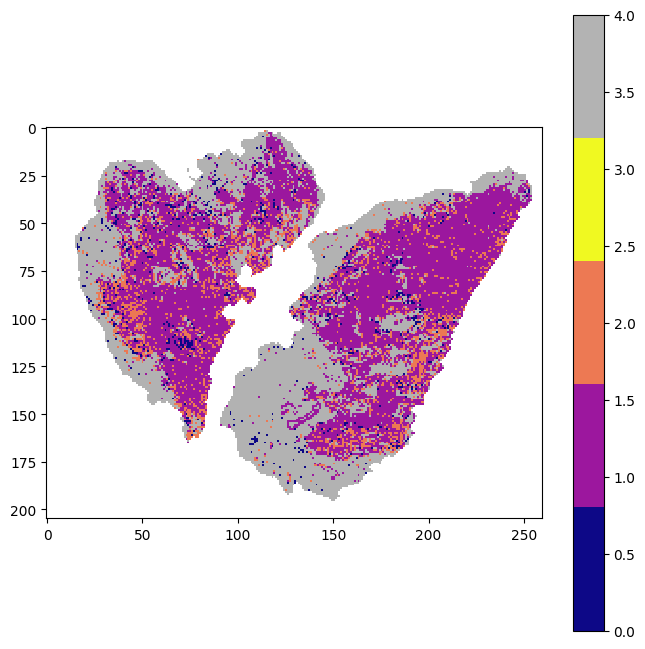

  0%|          | 0/210 [00:00<?, ?it/s]

  6%|▌         | 13/210 [00:01<00:17, 10.97it/s]

  7%|▋         | 15/210 [00:11<03:12,  1.01it/s]

  8%|▊         | 16/210 [00:19<05:59,  1.86s/it]

  8%|▊         | 17/210 [00:28<09:11,  2.86s/it]

  9%|▊         | 18/210 [00:41<14:14,  4.45s/it]

  9%|▉         | 19/210 [00:55<20:04,  6.31s/it]

 10%|▉         | 20/210 [01:10<25:49,  8.16s/it]

 10%|█         | 21/210 [01:25<31:05,  9.87s/it]

 10%|█         | 22/210 [01:41<35:18, 11.27s/it]

 11%|█         | 23/210 [02:00<41:21, 13.27s/it]

 11%|█▏        | 24/210 [02:21<48:03, 15.50s/it]

 12%|█▏        | 25/210 [02:46<55:54, 18.13s/it]

 12%|█▏        | 26/210 [03:11<1:02:10, 20.28s/it]

 13%|█▎        | 27/210 [03:38<1:07:53, 22.26s/it]

 13%|█▎        | 28/210 [04:08<1:13:39, 24.28s/it]

 14%|█▍        | 29/210 [04:39<1:19:26, 26.34s/it]

 14%|█▍        | 30/210 [05:13<1:25:50, 28.61s/it]

 15%|█▍        | 31/210 [05:47<1:30:03, 30.19s/it]

 15%|█▌        | 32/210 [06:24<1:35:36, 32.23s/it]

 16%|█▌        | 33/210 [07:01<1:39:33, 33.75s/it]

 16%|█▌        | 34/210 [07:39<1:43:01, 35.12s/it]

 17%|█▋        | 35/210 [08:19<1:46:08, 36.39s/it]

 17%|█▋        | 36/210 [09:01<1:50:24, 38.07s/it]

 18%|█▊        | 37/210 [09:45<1:54:36, 39.75s/it]

 18%|█▊        | 38/210 [10:29<1:58:20, 41.28s/it]

 19%|█▊        | 39/210 [11:14<2:00:11, 42.17s/it]

 19%|█▉        | 40/210 [11:57<2:00:37, 42.57s/it]

 20%|█▉        | 41/210 [12:43<2:02:33, 43.51s/it]

 20%|██        | 42/210 [13:26<2:01:36, 43.43s/it]

 20%|██        | 43/210 [14:09<2:00:14, 43.20s/it]

 21%|██        | 44/210 [14:54<2:01:07, 43.78s/it]

 21%|██▏       | 45/210 [15:37<1:59:51, 43.59s/it]

 22%|██▏       | 46/210 [16:29<2:06:15, 46.19s/it]

 22%|██▏       | 47/210 [17:19<2:08:26, 47.28s/it]

 23%|██▎       | 48/210 [18:07<2:07:57, 47.39s/it]

 23%|██▎       | 49/210 [18:57<2:09:22, 48.21s/it]

 24%|██▍       | 50/210 [19:50<2:12:12, 49.58s/it]

 24%|██▍       | 51/210 [20:45<2:15:49, 51.25s/it]

 25%|██▍       | 52/210 [21:41<2:18:52, 52.74s/it]

 25%|██▌       | 53/210 [22:41<2:23:55, 55.00s/it]

 26%|██▌       | 54/210 [23:45<2:29:24, 57.47s/it]

 26%|██▌       | 55/210 [24:56<2:39:01, 61.56s/it]

 27%|██▋       | 56/210 [26:01<2:40:50, 62.66s/it]

 27%|██▋       | 57/210 [27:06<2:41:22, 63.28s/it]

 28%|██▊       | 58/210 [28:13<2:43:31, 64.55s/it]

 28%|██▊       | 59/210 [29:21<2:44:39, 65.43s/it]

 29%|██▊       | 60/210 [30:29<2:45:35, 66.24s/it]

 29%|██▉       | 61/210 [31:37<2:46:06, 66.89s/it]

 30%|██▉       | 62/210 [32:49<2:48:57, 68.50s/it]

 30%|███       | 63/210 [34:04<2:51:59, 70.20s/it]

 30%|███       | 64/210 [35:15<2:51:30, 70.48s/it]

 31%|███       | 65/210 [36:29<2:53:02, 71.61s/it]

 31%|███▏      | 66/210 [37:45<2:54:51, 72.86s/it]

 32%|███▏      | 67/210 [39:01<2:56:19, 73.98s/it]

 32%|███▏      | 68/210 [40:15<2:54:51, 73.88s/it]

 33%|███▎      | 69/210 [41:32<2:55:58, 74.88s/it]

 33%|███▎      | 70/210 [42:48<2:55:32, 75.23s/it]

 34%|███▍      | 71/210 [44:06<2:56:18, 76.10s/it]

 34%|███▍      | 72/210 [45:24<2:55:59, 76.52s/it]

 35%|███▍      | 73/210 [46:42<2:56:04, 77.12s/it]

 35%|███▌      | 74/210 [47:59<2:54:26, 76.96s/it]

 36%|███▌      | 75/210 [49:15<2:52:49, 76.81s/it]

 36%|███▌      | 76/210 [50:36<2:53:51, 77.85s/it]

 37%|███▋      | 77/210 [51:54<2:52:48, 77.96s/it]

 37%|███▋      | 78/210 [53:12<2:51:47, 78.09s/it]

 38%|███▊      | 79/210 [54:31<2:50:41, 78.18s/it]

 38%|███▊      | 80/210 [55:49<2:49:36, 78.28s/it]

 39%|███▊      | 81/210 [57:06<2:47:39, 77.98s/it]

 39%|███▉      | 82/210 [58:26<2:47:21, 78.45s/it]

 40%|███▉      | 83/210 [59:47<2:47:41, 79.22s/it]

 40%|████      | 84/210 [1:01:04<2:45:05, 78.61s/it]

 40%|████      | 85/210 [1:02:25<2:45:04, 79.23s/it]

 41%|████      | 86/210 [1:03:45<2:44:32, 79.62s/it]

 41%|████▏     | 87/210 [1:05:06<2:43:57, 79.98s/it]

 42%|████▏     | 88/210 [1:06:25<2:41:54, 79.63s/it]

 42%|████▏     | 89/210 [1:07:46<2:41:17, 79.98s/it]

 43%|████▎     | 90/210 [1:09:03<2:38:02, 79.02s/it]

 43%|████▎     | 91/210 [1:10:19<2:35:17, 78.30s/it]

 44%|████▍     | 92/210 [1:11:41<2:36:05, 79.37s/it]

 44%|████▍     | 93/210 [1:13:02<2:35:24, 79.70s/it]

 45%|████▍     | 94/210 [1:14:20<2:33:35, 79.45s/it]

 45%|████▌     | 95/210 [1:15:40<2:32:02, 79.33s/it]

 46%|████▌     | 96/210 [1:16:59<2:30:55, 79.44s/it]

 46%|████▌     | 97/210 [1:18:20<2:30:08, 79.72s/it]

 47%|████▋     | 98/210 [1:19:40<2:29:28, 80.08s/it]

 47%|████▋     | 99/210 [1:21:02<2:28:55, 80.50s/it]

 48%|████▊     | 100/210 [1:22:22<2:27:08, 80.26s/it]

 48%|████▊     | 101/210 [1:23:42<2:25:45, 80.23s/it]

 49%|████▊     | 102/210 [1:25:03<2:24:56, 80.52s/it]

 49%|████▉     | 103/210 [1:26:24<2:24:00, 80.75s/it]

 50%|████▉     | 104/210 [1:27:43<2:21:21, 80.01s/it]

 50%|█████     | 105/210 [1:29:03<2:20:00, 80.01s/it]

 50%|█████     | 106/210 [1:30:24<2:19:17, 80.36s/it]

 51%|█████     | 107/210 [1:31:44<2:17:58, 80.37s/it]

 51%|█████▏    | 108/210 [1:33:08<2:18:36, 81.53s/it]

 52%|█████▏    | 109/210 [1:34:31<2:17:56, 81.95s/it]

 52%|█████▏    | 110/210 [1:36:03<2:21:13, 84.74s/it]

 53%|█████▎    | 111/210 [1:37:26<2:19:09, 84.34s/it]

 53%|█████▎    | 112/210 [1:38:50<2:17:37, 84.26s/it]

 54%|█████▍    | 113/210 [1:40:11<2:14:48, 83.39s/it]

 54%|█████▍    | 114/210 [1:41:36<2:13:44, 83.59s/it]

 55%|█████▍    | 115/210 [1:42:59<2:12:17, 83.55s/it]

 55%|█████▌    | 116/210 [1:44:23<2:11:02, 83.64s/it]

 56%|█████▌    | 117/210 [1:45:47<2:10:01, 83.88s/it]

 56%|█████▌    | 118/210 [1:47:11<2:08:32, 83.83s/it]

 57%|█████▋    | 119/210 [1:48:36<2:07:37, 84.14s/it]

 57%|█████▋    | 120/210 [1:49:58<2:05:23, 83.60s/it]

 58%|█████▊    | 121/210 [1:51:21<2:03:46, 83.44s/it]

 58%|█████▊    | 122/210 [1:52:44<2:02:17, 83.38s/it]

 59%|█████▊    | 123/210 [1:54:07<2:00:28, 83.09s/it]

 59%|█████▉    | 124/210 [1:55:30<1:59:17, 83.23s/it]

 60%|█████▉    | 125/210 [1:56:52<1:57:06, 82.66s/it]

 60%|██████    | 126/210 [1:58:14<1:55:36, 82.58s/it]

 60%|██████    | 127/210 [1:59:34<1:53:08, 81.78s/it]

 61%|██████    | 128/210 [2:00:54<1:51:11, 81.36s/it]

 61%|██████▏   | 129/210 [2:02:10<1:47:32, 79.66s/it]

 62%|██████▏   | 130/210 [2:03:32<1:46:53, 80.17s/it]

 62%|██████▏   | 131/210 [2:04:48<1:43:55, 78.93s/it]

 63%|██████▎   | 132/210 [2:06:05<1:42:00, 78.46s/it]

 63%|██████▎   | 133/210 [2:07:22<1:40:19, 78.17s/it]

 64%|██████▍   | 134/210 [2:08:42<1:39:37, 78.65s/it]

 64%|██████▍   | 135/210 [2:10:02<1:38:38, 78.92s/it]

 65%|██████▍   | 136/210 [2:11:21<1:37:27, 79.02s/it]

 65%|██████▌   | 137/210 [2:12:37<1:35:11, 78.24s/it]

 66%|██████▌   | 138/210 [2:13:50<1:31:43, 76.43s/it]

 66%|██████▌   | 139/210 [2:15:07<1:30:46, 76.70s/it]

 67%|██████▋   | 140/210 [2:16:22<1:29:02, 76.32s/it]

 67%|██████▋   | 141/210 [2:17:37<1:27:20, 75.94s/it]

 68%|██████▊   | 142/210 [2:18:52<1:25:36, 75.53s/it]

 68%|██████▊   | 143/210 [2:20:05<1:23:24, 74.70s/it]

 69%|██████▊   | 144/210 [2:21:16<1:20:53, 73.53s/it]

 69%|██████▉   | 145/210 [2:22:27<1:18:50, 72.77s/it]

 70%|██████▉   | 146/210 [2:23:39<1:17:27, 72.62s/it]

 70%|███████   | 147/210 [2:24:51<1:15:58, 72.35s/it]

 70%|███████   | 148/210 [2:26:05<1:15:26, 73.00s/it]

 71%|███████   | 149/210 [2:27:20<1:14:44, 73.51s/it]

 71%|███████▏  | 150/210 [2:28:32<1:13:02, 73.04s/it]

 72%|███████▏  | 151/210 [2:29:41<1:10:46, 71.97s/it]

 72%|███████▏  | 152/210 [2:30:53<1:09:24, 71.79s/it]

 73%|███████▎  | 153/210 [2:32:02<1:07:29, 71.04s/it]

 73%|███████▎  | 154/210 [2:33:14<1:06:41, 71.45s/it]

 74%|███████▍  | 155/210 [2:34:35<1:08:10, 74.38s/it]

 74%|███████▍  | 156/210 [2:35:46<1:05:58, 73.30s/it]

 75%|███████▍  | 157/210 [2:36:59<1:04:40, 73.22s/it]

 75%|███████▌  | 158/210 [2:38:12<1:03:13, 72.95s/it]

 76%|███████▌  | 159/210 [2:39:25<1:02:03, 73.00s/it]

 76%|███████▌  | 160/210 [2:40:37<1:00:45, 72.92s/it]

 77%|███████▋  | 161/210 [2:41:46<58:27, 71.58s/it]  

 77%|███████▋  | 162/210 [2:42:55<56:43, 70.91s/it]

 78%|███████▊  | 163/210 [2:44:08<55:58, 71.46s/it]

 78%|███████▊  | 164/210 [2:45:18<54:31, 71.11s/it]

 79%|███████▊  | 165/210 [2:46:27<52:46, 70.36s/it]

 79%|███████▉  | 166/210 [2:47:39<52:01, 70.95s/it]

 80%|███████▉  | 167/210 [2:48:49<50:35, 70.59s/it]

 80%|████████  | 168/210 [2:50:00<49:32, 70.78s/it]

 80%|████████  | 169/210 [2:51:10<48:13, 70.58s/it]

 81%|████████  | 170/210 [2:52:16<46:00, 69.02s/it]

 81%|████████▏ | 171/210 [2:53:25<44:50, 68.99s/it]

 82%|████████▏ | 172/210 [2:54:37<44:24, 70.12s/it]

 82%|████████▏ | 173/210 [2:55:43<42:29, 68.89s/it]

 83%|████████▎ | 174/210 [2:56:52<41:18, 68.86s/it]

 83%|████████▎ | 175/210 [2:58:00<39:55, 68.45s/it]

 84%|████████▍ | 176/210 [2:59:01<37:38, 66.43s/it]

 84%|████████▍ | 177/210 [3:00:05<36:05, 65.63s/it]

 85%|████████▍ | 178/210 [3:01:11<35:03, 65.74s/it]

 85%|████████▌ | 179/210 [3:02:12<33:09, 64.19s/it]

 86%|████████▌ | 180/210 [3:03:17<32:18, 64.63s/it]

 86%|████████▌ | 181/210 [3:04:25<31:37, 65.44s/it]

 87%|████████▋ | 182/210 [3:05:27<30:01, 64.35s/it]

 87%|████████▋ | 183/210 [3:06:27<28:25, 63.17s/it]

 88%|████████▊ | 184/210 [3:07:26<26:48, 61.85s/it]

 88%|████████▊ | 185/210 [3:08:33<26:29, 63.59s/it]

 89%|████████▊ | 186/210 [3:09:28<24:21, 60.88s/it]

 89%|████████▉ | 187/210 [3:10:23<22:42, 59.26s/it]

 90%|████████▉ | 188/210 [3:11:16<21:02, 57.40s/it]

 90%|█████████ | 189/210 [3:12:08<19:28, 55.63s/it]

 90%|█████████ | 190/210 [3:12:58<17:59, 53.97s/it]

 91%|█████████ | 191/210 [3:13:47<16:38, 52.56s/it]

 91%|█████████▏| 192/210 [3:14:34<15:12, 50.68s/it]

 92%|█████████▏| 193/210 [3:15:17<13:44, 48.52s/it]

 92%|█████████▏| 194/210 [3:15:58<12:21, 46.33s/it]

 93%|█████████▎| 195/210 [3:16:38<11:03, 44.22s/it]

 93%|█████████▎| 196/210 [3:17:17<09:56, 42.63s/it]

 94%|█████████▍| 197/210 [3:17:55<08:57, 41.37s/it]

 94%|█████████▍| 198/210 [3:18:34<08:07, 40.66s/it]

 95%|█████████▍| 199/210 [3:19:11<07:14, 39.52s/it]

 95%|█████████▌| 200/210 [3:19:47<06:24, 38.43s/it]

 96%|█████████▌| 201/210 [3:20:22<05:36, 37.39s/it]

 96%|█████████▌| 202/210 [3:20:53<04:43, 35.43s/it]

 97%|█████████▋| 203/210 [3:21:22<03:54, 33.53s/it]

 97%|█████████▋| 204/210 [3:21:44<03:01, 30.31s/it]

 98%|█████████▊| 205/210 [3:22:05<02:16, 27.27s/it]

 98%|█████████▊| 206/210 [3:22:24<01:39, 24.88s/it]

 99%|█████████▊| 207/210 [3:22:41<01:08, 22.68s/it]

 99%|█████████▉| 208/210 [3:22:58<00:41, 20.86s/it]

100%|█████████▉| 209/210 [3:23:13<00:19, 19.16s/it]

100%|██████████| 210/210 [3:23:28<00:00, 17.87s/it]

100%|██████████| 210/210 [3:23:28<00:00, 58.14s/it]

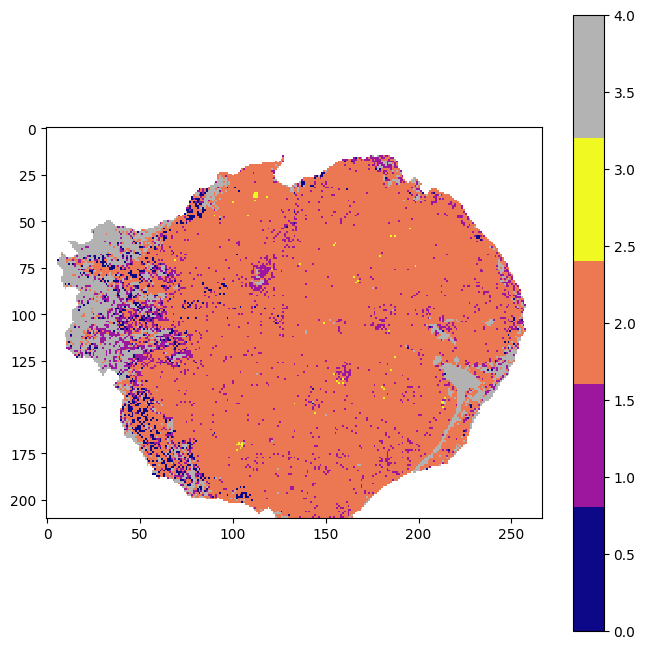

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 1/215 [00:23<1:23:53, 23.52s/it]

  1%|          | 2/215 [00:45<1:20:22, 22.64s/it]

  1%|▏         | 3/215 [01:10<1:24:19, 23.87s/it]

  2%|▏         | 4/215 [01:37<1:27:58, 25.02s/it]

  2%|▏         | 5/215 [02:05<1:31:03, 26.02s/it]

  3%|▎         | 6/215 [02:32<1:31:55, 26.39s/it]

  3%|▎         | 7/215 [03:01<1:34:27, 27.25s/it]

  4%|▎         | 8/215 [03:34<1:40:05, 29.01s/it]

  4%|▍         | 9/215 [04:09<1:45:50, 30.83s/it]

  5%|▍         | 10/215 [04:47<1:52:58, 33.06s/it]

  5%|▌         | 11/215 [05:37<2:09:52, 38.20s/it]

  6%|▌         | 12/215 [06:38<2:33:27, 45.36s/it]

  6%|▌         | 13/215 [07:49<2:58:26, 53.00s/it]

  7%|▋         | 14/215 [09:04<3:19:44, 59.62s/it]

  7%|▋         | 15/215 [10:18<3:33:25, 64.03s/it]

  7%|▋         | 16/215 [11:37<3:46:58, 68.43s/it]

  8%|▊         | 17/215 [12:58<3:58:06, 72.15s/it]

  8%|▊         | 18/215 [14:16<4:02:45, 73.93s/it]

  9%|▉         | 19/215 [15:32<4:04:17, 74.78s/it]

  9%|▉         | 20/215 [16:53<4:08:20, 76.42s/it]

 10%|▉         | 21/215 [18:17<4:15:14, 78.94s/it]

 10%|█         | 22/215 [19:37<4:14:44, 79.20s/it]

 11%|█         | 23/215 [20:59<4:15:58, 79.99s/it]

 11%|█         | 24/215 [22:21<4:16:07, 80.46s/it]

 12%|█▏        | 25/215 [23:45<4:18:16, 81.56s/it]

 12%|█▏        | 26/215 [25:06<4:16:58, 81.58s/it]

 13%|█▎        | 27/215 [26:30<4:17:05, 82.05s/it]

 13%|█▎        | 28/215 [27:51<4:14:55, 81.79s/it]

 13%|█▎        | 29/215 [29:16<4:16:28, 82.74s/it]

 14%|█▍        | 30/215 [30:39<4:15:13, 82.78s/it]

 14%|█▍        | 31/215 [32:04<4:16:00, 83.48s/it]

 15%|█▍        | 32/215 [33:29<4:16:46, 84.19s/it]

 15%|█▌        | 33/215 [34:55<4:16:31, 84.57s/it]

 16%|█▌        | 34/215 [36:20<4:15:56, 84.84s/it]

 16%|█▋        | 35/215 [37:47<4:16:22, 85.46s/it]

 17%|█▋        | 36/215 [39:15<4:17:01, 86.15s/it]

 17%|█▋        | 37/215 [40:47<4:20:44, 87.89s/it]

 18%|█▊        | 38/215 [42:13<4:17:56, 87.44s/it]

 18%|█▊        | 39/215 [43:38<4:14:00, 86.59s/it]

 19%|█▊        | 40/215 [45:04<4:11:51, 86.35s/it]

 19%|█▉        | 41/215 [46:31<4:10:52, 86.51s/it]

 20%|█▉        | 42/215 [48:00<4:12:12, 87.47s/it]

 20%|██        | 43/215 [49:27<4:09:57, 87.20s/it]

 20%|██        | 44/215 [50:53<4:07:24, 86.81s/it]

 21%|██        | 45/215 [52:19<4:05:47, 86.75s/it]

 21%|██▏       | 46/215 [53:46<4:04:23, 86.77s/it]

 22%|██▏       | 47/215 [55:20<4:08:55, 88.90s/it]

 22%|██▏       | 48/215 [56:48<4:06:28, 88.55s/it]

 23%|██▎       | 49/215 [58:18<4:06:25, 89.07s/it]

 23%|██▎       | 50/215 [59:48<4:05:18, 89.20s/it]

 24%|██▎       | 51/215 [1:01:18<4:05:01, 89.64s/it]

 24%|██▍       | 52/215 [1:02:46<4:01:37, 88.94s/it]

 25%|██▍       | 53/215 [1:04:18<4:03:00, 90.00s/it]

 25%|██▌       | 54/215 [1:05:50<4:02:36, 90.41s/it]

 26%|██▌       | 55/215 [1:07:20<4:00:46, 90.29s/it]

 26%|██▌       | 56/215 [1:08:49<3:58:40, 90.07s/it]

 27%|██▋       | 57/215 [1:10:17<3:55:19, 89.36s/it]

 27%|██▋       | 58/215 [1:11:46<3:53:28, 89.23s/it]

 27%|██▋       | 59/215 [1:13:16<3:52:46, 89.53s/it]

 28%|██▊       | 60/215 [1:14:45<3:50:37, 89.28s/it]

 28%|██▊       | 61/215 [1:16:13<3:48:38, 89.08s/it]

 29%|██▉       | 62/215 [1:17:43<3:47:35, 89.25s/it]

 29%|██▉       | 63/215 [1:19:13<3:46:38, 89.47s/it]

 30%|██▉       | 64/215 [1:20:42<3:44:49, 89.33s/it]

 30%|███       | 65/215 [1:22:13<3:44:52, 89.95s/it]

 31%|███       | 66/215 [1:23:41<3:41:56, 89.37s/it]

 31%|███       | 67/215 [1:25:17<3:44:52, 91.17s/it]

 32%|███▏      | 68/215 [1:26:46<3:41:39, 90.47s/it]

 32%|███▏      | 69/215 [1:28:18<3:41:39, 91.09s/it]

 33%|███▎      | 70/215 [1:29:57<3:45:40, 93.38s/it]

 33%|███▎      | 71/215 [1:31:26<3:41:09, 92.15s/it]

 33%|███▎      | 72/215 [1:33:00<3:41:02, 92.75s/it]

 34%|███▍      | 73/215 [1:34:32<3:38:52, 92.48s/it]

 34%|███▍      | 74/215 [1:36:05<3:37:47, 92.68s/it]

 35%|███▍      | 75/215 [1:37:38<3:36:03, 92.59s/it]

 35%|███▌      | 76/215 [1:39:13<3:36:40, 93.53s/it]

 36%|███▌      | 77/215 [1:40:47<3:35:15, 93.59s/it]

 36%|███▋      | 78/215 [1:42:20<3:33:14, 93.39s/it]

 37%|███▋      | 79/215 [1:43:53<3:31:44, 93.42s/it]

 37%|███▋      | 80/215 [1:45:32<3:33:29, 94.88s/it]

 38%|███▊      | 81/215 [1:47:06<3:31:46, 94.82s/it]

 38%|███▊      | 82/215 [1:48:40<3:29:07, 94.34s/it]

 39%|███▊      | 83/215 [1:50:14<3:27:39, 94.39s/it]

 39%|███▉      | 84/215 [1:51:46<3:24:41, 93.75s/it]

 40%|███▉      | 85/215 [1:53:20<3:22:44, 93.57s/it]

 40%|████      | 86/215 [1:54:59<3:25:07, 95.40s/it]

 40%|████      | 87/215 [1:56:33<3:22:27, 94.90s/it]

 41%|████      | 88/215 [1:58:08<3:21:05, 95.01s/it]

 41%|████▏     | 89/215 [1:59:47<3:21:43, 96.06s/it]

 42%|████▏     | 90/215 [2:01:22<3:19:23, 95.71s/it]

 42%|████▏     | 91/215 [2:03:03<3:21:21, 97.43s/it]

 43%|████▎     | 92/215 [2:04:41<3:20:20, 97.73s/it]

 43%|████▎     | 93/215 [2:06:18<3:17:40, 97.22s/it]

 44%|████▎     | 94/215 [2:07:54<3:15:23, 96.89s/it]

 44%|████▍     | 95/215 [2:09:32<3:14:45, 97.38s/it]

 45%|████▍     | 96/215 [2:11:12<3:14:22, 98.01s/it]

 45%|████▌     | 97/215 [2:12:47<3:11:05, 97.16s/it]

 46%|████▌     | 98/215 [2:14:24<3:09:15, 97.05s/it]

 46%|████▌     | 99/215 [2:16:00<3:07:09, 96.81s/it]

 47%|████▋     | 100/215 [2:17:35<3:04:42, 96.37s/it]

 47%|████▋     | 101/215 [2:19:12<3:03:13, 96.43s/it]

 47%|████▋     | 102/215 [2:20:46<3:00:19, 95.75s/it]

 48%|████▊     | 103/215 [2:22:24<2:59:53, 96.37s/it]

 48%|████▊     | 104/215 [2:24:01<2:58:41, 96.59s/it]

 49%|████▉     | 105/215 [2:25:36<2:56:11, 96.10s/it]

 49%|████▉     | 106/215 [2:27:13<2:54:55, 96.29s/it]

 50%|████▉     | 107/215 [2:28:47<2:52:30, 95.84s/it]

 50%|█████     | 108/215 [2:30:22<2:50:32, 95.63s/it]

 51%|█████     | 109/215 [2:31:58<2:48:54, 95.61s/it]

 51%|█████     | 110/215 [2:33:34<2:47:28, 95.70s/it]

 52%|█████▏    | 111/215 [2:35:09<2:45:33, 95.51s/it]

 52%|█████▏    | 112/215 [2:36:46<2:44:30, 95.83s/it]

 53%|█████▎    | 113/215 [2:38:21<2:42:34, 95.64s/it]

 53%|█████▎    | 114/215 [2:39:56<2:40:48, 95.53s/it]

 53%|█████▎    | 115/215 [2:41:31<2:38:47, 95.27s/it]

 54%|█████▍    | 116/215 [2:43:06<2:37:19, 95.35s/it]

 54%|█████▍    | 117/215 [2:44:42<2:35:54, 95.45s/it]

 55%|█████▍    | 118/215 [2:46:19<2:34:57, 95.85s/it]

 55%|█████▌    | 119/215 [2:47:54<2:33:17, 95.81s/it]

 56%|█████▌    | 120/215 [2:49:28<2:30:29, 95.05s/it]

 56%|█████▋    | 121/215 [2:51:08<2:31:34, 96.75s/it]

 57%|█████▋    | 122/215 [2:52:41<2:28:07, 95.57s/it]

 57%|█████▋    | 123/215 [2:54:17<2:26:44, 95.70s/it]

 58%|█████▊    | 124/215 [2:55:52<2:24:56, 95.56s/it]

 58%|█████▊    | 125/215 [2:57:31<2:24:38, 96.43s/it]

 59%|█████▊    | 126/215 [2:59:08<2:23:15, 96.58s/it]

 59%|█████▉    | 127/215 [3:00:46<2:22:22, 97.08s/it]

 60%|█████▉    | 128/215 [3:02:27<2:22:28, 98.25s/it]

 60%|██████    | 129/215 [3:04:04<2:20:15, 97.85s/it]

 60%|██████    | 130/215 [3:05:49<2:21:41, 100.02s/it]

 61%|██████    | 131/215 [3:07:25<2:18:28, 98.91s/it] 

 61%|██████▏   | 132/215 [3:09:08<2:18:11, 99.89s/it]

 62%|██████▏   | 133/215 [3:10:47<2:16:23, 99.80s/it]

 62%|██████▏   | 134/215 [3:12:23<2:13:03, 98.56s/it]

 63%|██████▎   | 135/215 [3:14:04<2:12:28, 99.36s/it]

 63%|██████▎   | 136/215 [3:15:45<2:11:16, 99.70s/it]

 64%|██████▎   | 137/215 [3:17:25<2:09:54, 99.93s/it]

 64%|██████▍   | 138/215 [3:19:01<2:06:53, 98.87s/it]

 65%|██████▍   | 139/215 [3:20:40<2:04:56, 98.64s/it]

 65%|██████▌   | 140/215 [3:22:18<2:03:17, 98.64s/it]

 66%|██████▌   | 141/215 [3:23:55<2:01:00, 98.11s/it]

 66%|██████▌   | 142/215 [3:25:29<1:57:49, 96.84s/it]

 67%|██████▋   | 143/215 [3:27:05<1:56:03, 96.71s/it]

 67%|██████▋   | 144/215 [3:28:37<1:52:31, 95.09s/it]

 67%|██████▋   | 145/215 [3:30:10<1:50:12, 94.46s/it]

 68%|██████▊   | 146/215 [3:31:42<1:47:48, 93.75s/it]

 68%|██████▊   | 147/215 [3:33:12<1:45:11, 92.81s/it]

 69%|██████▉   | 148/215 [3:34:49<1:44:56, 93.98s/it]

 69%|██████▉   | 149/215 [3:36:25<1:43:56, 94.49s/it]

 70%|██████▉   | 150/215 [3:37:59<1:42:16, 94.41s/it]

 70%|███████   | 151/215 [3:39:38<1:42:04, 95.70s/it]

 71%|███████   | 152/215 [3:41:12<1:39:59, 95.23s/it]

 71%|███████   | 153/215 [3:42:49<1:38:57, 95.77s/it]

 72%|███████▏  | 154/215 [3:44:27<1:37:59, 96.38s/it]

 72%|███████▏  | 155/215 [3:46:14<1:39:45, 99.76s/it]

 73%|███████▎  | 156/215 [3:47:52<1:37:37, 99.28s/it]

 73%|███████▎  | 157/215 [3:49:29<1:35:07, 98.41s/it]

 73%|███████▎  | 158/215 [3:51:04<1:32:35, 97.46s/it]

 74%|███████▍  | 159/215 [3:52:42<1:31:13, 97.73s/it]

 74%|███████▍  | 160/215 [3:54:18<1:29:00, 97.10s/it]

 75%|███████▍  | 161/215 [3:55:51<1:26:16, 95.85s/it]

 75%|███████▌  | 162/215 [3:57:28<1:24:51, 96.06s/it]

 76%|███████▌  | 163/215 [3:59:02<1:22:55, 95.68s/it]

 76%|███████▋  | 164/215 [4:00:38<1:21:16, 95.62s/it]

 77%|███████▋  | 165/215 [4:02:12<1:19:14, 95.09s/it]

 77%|███████▋  | 166/215 [4:03:48<1:17:58, 95.48s/it]

 78%|███████▊  | 167/215 [4:05:29<1:17:43, 97.16s/it]

 78%|███████▊  | 168/215 [4:07:03<1:15:15, 96.08s/it]

 79%|███████▊  | 169/215 [4:08:40<1:13:58, 96.49s/it]

 79%|███████▉  | 170/215 [4:10:14<1:11:44, 95.66s/it]

 80%|███████▉  | 171/215 [4:11:49<1:10:00, 95.46s/it]

 80%|████████  | 172/215 [4:13:23<1:08:06, 95.05s/it]

 80%|████████  | 173/215 [4:14:54<1:05:43, 93.90s/it]

 81%|████████  | 174/215 [4:16:24<1:03:20, 92.70s/it]

 81%|████████▏ | 175/215 [4:17:58<1:02:01, 93.04s/it]

 82%|████████▏ | 176/215 [4:19:30<1:00:20, 92.83s/it]

 82%|████████▏ | 177/215 [4:21:01<58:25, 92.26s/it]  

 83%|████████▎ | 178/215 [4:22:34<56:58, 92.40s/it]

 83%|████████▎ | 179/215 [4:24:11<56:20, 93.90s/it]

 84%|████████▎ | 180/215 [4:25:40<53:54, 92.42s/it]

 84%|████████▍ | 181/215 [4:27:10<51:51, 91.50s/it]

 85%|████████▍ | 182/215 [4:28:39<49:59, 90.89s/it]

 85%|████████▌ | 183/215 [4:30:07<48:03, 90.10s/it]

 86%|████████▌ | 184/215 [4:31:35<46:11, 89.42s/it]

 86%|████████▌ | 185/215 [4:33:02<44:23, 88.78s/it]

 87%|████████▋ | 186/215 [4:34:23<41:45, 86.41s/it]

 87%|████████▋ | 187/215 [4:35:49<40:15, 86.26s/it]

 87%|████████▋ | 188/215 [4:37:12<38:18, 85.15s/it]

 88%|████████▊ | 189/215 [4:38:36<36:45, 84.81s/it]

 88%|████████▊ | 190/215 [4:39:58<35:03, 84.15s/it]

 89%|████████▉ | 191/215 [4:41:17<33:02, 82.59s/it]

 89%|████████▉ | 192/215 [4:42:27<30:07, 78.59s/it]

 90%|████████▉ | 193/215 [4:43:17<25:42, 70.11s/it]

 90%|█████████ | 194/215 [4:43:59<21:33, 61.58s/it]

 91%|█████████ | 195/215 [4:44:38<18:17, 54.86s/it]

 91%|█████████ | 196/215 [4:45:18<15:56, 50.33s/it]

 92%|█████████▏| 197/215 [4:45:54<13:53, 46.29s/it]

 92%|█████████▏| 198/215 [4:46:31<12:18, 43.44s/it]

 93%|█████████▎| 199/215 [4:47:09<11:06, 41.64s/it]

 93%|█████████▎| 200/215 [4:47:46<10:03, 40.24s/it]

 93%|█████████▎| 201/215 [4:48:20<08:57, 38.37s/it]

 94%|█████████▍| 202/215 [4:48:53<07:59, 36.88s/it]

 94%|█████████▍| 203/215 [4:49:23<06:57, 34.80s/it]

 95%|█████████▍| 204/215 [4:49:52<06:05, 33.19s/it]

 95%|█████████▌| 205/215 [4:50:20<05:15, 31.51s/it]

 96%|█████████▌| 206/215 [4:50:45<04:24, 29.43s/it]

 96%|█████████▋| 207/215 [4:51:07<03:37, 27.20s/it]

 97%|█████████▋| 208/215 [4:51:26<02:53, 24.81s/it]

 97%|█████████▋| 209/215 [4:51:41<02:11, 21.89s/it]

 98%|█████████▊| 210/215 [4:51:48<01:27, 17.54s/it]

 98%|█████████▊| 211/215 [4:51:49<00:49, 12.38s/it]

100%|██████████| 215/215 [4:51:49<00:00, 81.44s/it]

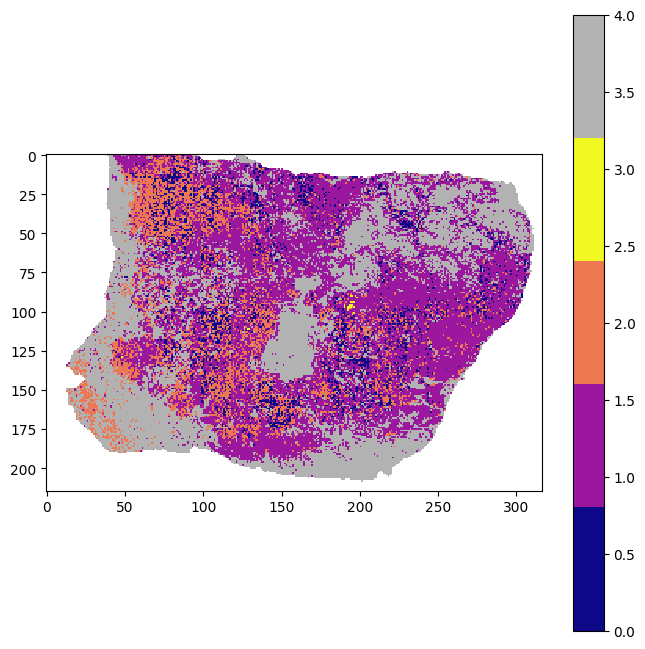

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 1/215 [00:19<1:07:48, 19.01s/it]

  1%|          | 2/215 [00:33<58:20, 16.43s/it]  

  1%|▏         | 3/215 [00:48<55:40, 15.76s/it]

  2%|▏         | 4/215 [01:03<53:57, 15.34s/it]

  2%|▏         | 5/215 [01:18<53:26, 15.27s/it]

  3%|▎         | 6/215 [01:37<58:13, 16.72s/it]

  3%|▎         | 7/215 [01:54<57:10, 16.49s/it]

  4%|▎         | 8/215 [02:12<58:55, 17.08s/it]

  4%|▍         | 9/215 [02:33<1:02:57, 18.34s/it]

  5%|▍         | 10/215 [02:54<1:05:35, 19.20s/it]

  5%|▌         | 11/215 [03:15<1:07:33, 19.87s/it]

  6%|▌         | 12/215 [03:39<1:11:19, 21.08s/it]

  6%|▌         | 13/215 [04:02<1:12:54, 21.66s/it]

  7%|▋         | 14/215 [04:24<1:12:08, 21.53s/it]

  7%|▋         | 15/215 [04:44<1:11:03, 21.32s/it]

  7%|▋         | 16/215 [05:07<1:11:36, 21.59s/it]

  8%|▊         | 17/215 [05:28<1:11:07, 21.56s/it]

  8%|▊         | 18/215 [05:49<1:10:34, 21.50s/it]

  9%|▉         | 19/215 [06:10<1:09:36, 21.31s/it]

  9%|▉         | 20/215 [06:32<1:09:43, 21.45s/it]

 10%|▉         | 21/215 [06:53<1:08:44, 21.26s/it]

 10%|█         | 22/215 [07:14<1:07:59, 21.14s/it]

 11%|█         | 23/215 [07:35<1:07:55, 21.23s/it]

 11%|█         | 24/215 [07:56<1:07:11, 21.11s/it]

 12%|█▏        | 25/215 [08:17<1:06:55, 21.14s/it]

 12%|█▏        | 26/215 [08:37<1:05:30, 20.79s/it]

 13%|█▎        | 27/215 [08:58<1:05:22, 20.87s/it]

 13%|█▎        | 28/215 [09:27<1:12:25, 23.24s/it]

 13%|█▎        | 29/215 [09:51<1:12:50, 23.50s/it]

 14%|█▍        | 30/215 [10:14<1:11:29, 23.18s/it]

 14%|█▍        | 31/215 [10:37<1:11:38, 23.36s/it]

 15%|█▍        | 32/215 [11:04<1:14:22, 24.39s/it]

 15%|█▌        | 33/215 [11:26<1:11:54, 23.71s/it]

 16%|█▌        | 34/215 [11:49<1:10:35, 23.40s/it]

 16%|█▋        | 35/215 [12:12<1:09:59, 23.33s/it]

 17%|█▋        | 36/215 [12:35<1:09:27, 23.28s/it]

 17%|█▋        | 37/215 [12:57<1:07:28, 22.74s/it]

 18%|█▊        | 38/215 [13:17<1:04:52, 21.99s/it]

 18%|█▊        | 39/215 [13:36<1:02:00, 21.14s/it]

 19%|█▊        | 40/215 [13:59<1:02:48, 21.54s/it]

 19%|█▉        | 41/215 [14:27<1:08:23, 23.59s/it]

 20%|█▉        | 42/215 [14:47<1:04:35, 22.40s/it]

 20%|██        | 43/215 [15:06<1:01:26, 21.43s/it]

 20%|██        | 44/215 [15:26<59:47, 20.98s/it]  

 21%|██        | 45/215 [15:50<1:02:07, 21.93s/it]

 21%|██▏       | 46/215 [16:14<1:03:16, 22.46s/it]

 22%|██▏       | 47/215 [16:37<1:03:38, 22.73s/it]

 22%|██▏       | 48/215 [17:01<1:04:02, 23.01s/it]

 23%|██▎       | 49/215 [17:24<1:03:44, 23.04s/it]

 23%|██▎       | 50/215 [17:47<1:03:39, 23.15s/it]

 24%|██▎       | 51/215 [18:10<1:03:29, 23.23s/it]

 24%|██▍       | 52/215 [18:35<1:04:08, 23.61s/it]

 25%|██▍       | 53/215 [18:59<1:03:48, 23.63s/it]

 25%|██▌       | 54/215 [19:22<1:03:26, 23.64s/it]

 26%|██▌       | 55/215 [19:46<1:03:10, 23.69s/it]

 26%|██▌       | 56/215 [20:13<1:05:18, 24.64s/it]

 27%|██▋       | 57/215 [20:41<1:07:25, 25.60s/it]

 27%|██▋       | 58/215 [21:10<1:10:07, 26.80s/it]

 27%|██▋       | 59/215 [21:45<1:15:45, 29.14s/it]

 28%|██▊       | 60/215 [22:20<1:19:30, 30.78s/it]

 28%|██▊       | 61/215 [23:02<1:27:41, 34.16s/it]

 29%|██▉       | 62/215 [23:43<1:32:23, 36.23s/it]

 29%|██▉       | 63/215 [24:27<1:38:13, 38.78s/it]

 30%|██▉       | 64/215 [25:16<1:45:03, 41.74s/it]

 30%|███       | 65/215 [26:06<1:50:39, 44.27s/it]

 31%|███       | 66/215 [26:58<1:55:34, 46.54s/it]

 31%|███       | 67/215 [27:51<1:59:27, 48.43s/it]

 32%|███▏      | 68/215 [28:46<2:03:43, 50.50s/it]

 32%|███▏      | 69/215 [29:45<2:08:34, 52.84s/it]

 33%|███▎      | 70/215 [30:43<2:11:54, 54.59s/it]

 33%|███▎      | 71/215 [31:51<2:20:47, 58.66s/it]

 33%|███▎      | 72/215 [32:51<2:20:15, 58.85s/it]

 34%|███▍      | 73/215 [33:53<2:21:33, 59.82s/it]

 34%|███▍      | 74/215 [34:52<2:20:28, 59.78s/it]

 35%|███▍      | 75/215 [35:54<2:20:34, 60.25s/it]

 35%|███▌      | 76/215 [36:56<2:21:06, 60.91s/it]

 36%|███▌      | 77/215 [37:57<2:20:11, 60.95s/it]

 36%|███▋      | 78/215 [38:59<2:19:21, 61.03s/it]

 37%|███▋      | 79/215 [40:02<2:19:49, 61.69s/it]

 37%|███▋      | 80/215 [41:04<2:18:49, 61.70s/it]

 38%|███▊      | 81/215 [42:06<2:18:15, 61.91s/it]

 38%|███▊      | 82/215 [43:10<2:18:26, 62.46s/it]

 39%|███▊      | 83/215 [44:12<2:17:14, 62.38s/it]

 39%|███▉      | 84/215 [45:14<2:16:15, 62.41s/it]

 40%|███▉      | 85/215 [46:20<2:17:06, 63.28s/it]

 40%|████      | 86/215 [47:25<2:17:35, 64.00s/it]

 40%|████      | 87/215 [48:31<2:17:42, 64.55s/it]

 41%|████      | 88/215 [49:34<2:15:32, 64.03s/it]

 41%|████▏     | 89/215 [50:39<2:14:56, 64.26s/it]

 42%|████▏     | 90/215 [51:50<2:18:22, 66.42s/it]

 42%|████▏     | 91/215 [53:01<2:19:43, 67.61s/it]

 43%|████▎     | 92/215 [54:10<2:19:28, 68.04s/it]

 43%|████▎     | 93/215 [55:20<2:19:55, 68.82s/it]

 44%|████▎     | 94/215 [56:33<2:20:55, 69.88s/it]

 44%|████▍     | 95/215 [57:45<2:21:08, 70.57s/it]

 45%|████▍     | 96/215 [58:57<2:21:07, 71.16s/it]

 45%|████▌     | 97/215 [1:00:09<2:20:01, 71.20s/it]

 46%|████▌     | 98/215 [1:01:20<2:18:51, 71.21s/it]

 46%|████▌     | 99/215 [1:02:32<2:18:22, 71.57s/it]

 47%|████▋     | 100/215 [1:03:45<2:17:51, 71.93s/it]

 47%|████▋     | 101/215 [1:04:57<2:16:26, 71.81s/it]

 47%|████▋     | 102/215 [1:06:08<2:14:57, 71.66s/it]

 48%|████▊     | 103/215 [1:07:21<2:14:19, 71.96s/it]

 48%|████▊     | 104/215 [1:08:37<2:15:30, 73.25s/it]

 49%|████▉     | 105/215 [1:09:50<2:14:15, 73.23s/it]

 49%|████▉     | 106/215 [1:11:00<2:11:18, 72.28s/it]

 50%|████▉     | 107/215 [1:12:12<2:09:46, 72.09s/it]

 50%|█████     | 108/215 [1:13:28<2:10:50, 73.37s/it]

 51%|█████     | 109/215 [1:14:41<2:09:38, 73.38s/it]

 51%|█████     | 110/215 [1:15:56<2:09:16, 73.88s/it]

 52%|█████▏    | 111/215 [1:17:12<2:09:03, 74.46s/it]

 52%|█████▏    | 112/215 [1:18:27<2:07:46, 74.43s/it]

 53%|█████▎    | 113/215 [1:19:41<2:06:13, 74.25s/it]

 53%|█████▎    | 114/215 [1:20:56<2:05:43, 74.69s/it]

 53%|█████▎    | 115/215 [1:22:12<2:05:09, 75.09s/it]

 54%|█████▍    | 116/215 [1:23:27<2:03:30, 74.86s/it]

 54%|█████▍    | 117/215 [1:24:43<2:03:15, 75.46s/it]

 55%|█████▍    | 118/215 [1:25:59<2:01:53, 75.40s/it]

 55%|█████▌    | 119/215 [1:27:14<2:00:38, 75.41s/it]

 56%|█████▌    | 120/215 [1:28:28<1:58:44, 74.99s/it]

 56%|█████▋    | 121/215 [1:29:45<1:58:23, 75.57s/it]

 57%|█████▋    | 122/215 [1:30:59<1:56:32, 75.19s/it]

 57%|█████▋    | 123/215 [1:32:15<1:55:41, 75.45s/it]

 58%|█████▊    | 124/215 [1:33:32<1:54:46, 75.67s/it]

 58%|█████▊    | 125/215 [1:34:49<1:54:08, 76.10s/it]

 59%|█████▊    | 126/215 [1:36:06<1:53:26, 76.47s/it]

 59%|█████▉    | 127/215 [1:37:22<1:51:46, 76.21s/it]

 60%|█████▉    | 128/215 [1:38:38<1:50:35, 76.27s/it]

 60%|██████    | 129/215 [1:39:54<1:49:04, 76.09s/it]

 60%|██████    | 130/215 [1:41:12<1:48:51, 76.84s/it]

 61%|██████    | 131/215 [1:42:26<1:46:15, 75.90s/it]

 61%|██████▏   | 132/215 [1:43:39<1:43:48, 75.04s/it]

 62%|██████▏   | 133/215 [1:44:53<1:41:56, 74.60s/it]

 62%|██████▏   | 134/215 [1:46:06<1:40:10, 74.20s/it]

 63%|██████▎   | 135/215 [1:47:18<1:37:53, 73.42s/it]

 63%|██████▎   | 136/215 [1:48:27<1:35:14, 72.33s/it]

 64%|██████▎   | 137/215 [1:49:45<1:36:07, 73.94s/it]

 64%|██████▍   | 138/215 [1:50:54<1:32:58, 72.45s/it]

 65%|██████▍   | 139/215 [1:52:04<1:30:54, 71.77s/it]

 65%|██████▌   | 140/215 [1:53:13<1:28:39, 70.92s/it]

 66%|██████▌   | 141/215 [1:54:24<1:27:32, 70.97s/it]

 66%|██████▌   | 142/215 [1:55:34<1:25:51, 70.56s/it]

 67%|██████▋   | 143/215 [1:56:42<1:23:57, 69.97s/it]

 67%|██████▋   | 144/215 [1:57:51<1:22:15, 69.52s/it]

 67%|██████▋   | 145/215 [1:58:58<1:20:24, 68.92s/it]

 68%|██████▊   | 146/215 [2:00:07<1:19:00, 68.71s/it]

 68%|██████▊   | 147/215 [2:01:16<1:18:11, 68.99s/it]

 69%|██████▉   | 148/215 [2:02:24<1:16:35, 68.59s/it]

 69%|██████▉   | 149/215 [2:03:32<1:15:24, 68.55s/it]

 70%|██████▉   | 150/215 [2:04:42<1:14:37, 68.88s/it]

 70%|███████   | 151/215 [2:05:48<1:12:29, 67.97s/it]

 71%|███████   | 152/215 [2:06:55<1:11:11, 67.80s/it]

 71%|███████   | 153/215 [2:08:05<1:10:34, 68.30s/it]

 72%|███████▏  | 154/215 [2:09:13<1:09:25, 68.28s/it]

 72%|███████▏  | 155/215 [2:10:20<1:07:48, 67.81s/it]

 73%|███████▎  | 156/215 [2:11:29<1:07:03, 68.19s/it]

 73%|███████▎  | 157/215 [2:12:38<1:06:15, 68.54s/it]

 73%|███████▎  | 158/215 [2:13:47<1:05:07, 68.56s/it]

 74%|███████▍  | 159/215 [2:14:56<1:04:08, 68.73s/it]

 74%|███████▍  | 160/215 [2:16:07<1:03:45, 69.55s/it]

 75%|███████▍  | 161/215 [2:17:15<1:02:07, 69.03s/it]

 75%|███████▌  | 162/215 [2:18:20<59:52, 67.79s/it]  

 76%|███████▌  | 163/215 [2:19:24<57:48, 66.69s/it]

 76%|███████▋  | 164/215 [2:20:29<56:15, 66.18s/it]

 77%|███████▋  | 165/215 [2:21:34<54:50, 65.80s/it]

 77%|███████▋  | 166/215 [2:22:40<53:40, 65.71s/it]

 78%|███████▊  | 167/215 [2:23:42<51:54, 64.88s/it]

 78%|███████▊  | 168/215 [2:24:44<50:06, 63.96s/it]

 79%|███████▊  | 169/215 [2:25:52<49:52, 65.05s/it]

 79%|███████▉  | 170/215 [2:26:54<48:02, 64.05s/it]

 80%|███████▉  | 171/215 [2:27:55<46:23, 63.25s/it]

 80%|████████  | 172/215 [2:28:57<45:01, 62.83s/it]

 80%|████████  | 173/215 [2:29:58<43:34, 62.25s/it]

 81%|████████  | 174/215 [2:31:01<42:42, 62.49s/it]

 81%|████████▏ | 175/215 [2:32:06<42:17, 63.44s/it]

 82%|████████▏ | 176/215 [2:33:11<41:32, 63.92s/it]

 82%|████████▏ | 177/215 [2:34:12<39:49, 62.88s/it]

 83%|████████▎ | 178/215 [2:35:11<38:07, 61.81s/it]

 83%|████████▎ | 179/215 [2:36:10<36:30, 60.84s/it]

 84%|████████▎ | 180/215 [2:37:11<35:30, 60.87s/it]

 84%|████████▍ | 181/215 [2:38:11<34:21, 60.64s/it]

 85%|████████▍ | 182/215 [2:39:10<33:08, 60.24s/it]

 85%|████████▌ | 183/215 [2:40:10<32:08, 60.25s/it]

 86%|████████▌ | 184/215 [2:41:13<31:24, 60.80s/it]

 86%|████████▌ | 185/215 [2:42:15<30:36, 61.21s/it]

 87%|████████▋ | 186/215 [2:43:16<29:32, 61.11s/it]

 87%|████████▋ | 187/215 [2:44:19<28:47, 61.69s/it]

 87%|████████▋ | 188/215 [2:45:19<27:31, 61.17s/it]

 88%|████████▊ | 189/215 [2:46:17<26:11, 60.45s/it]

 88%|████████▊ | 190/215 [2:47:10<24:14, 58.19s/it]

 89%|████████▉ | 191/215 [2:48:02<22:30, 56.28s/it]

 89%|████████▉ | 192/215 [2:48:55<21:12, 55.31s/it]

 90%|████████▉ | 193/215 [2:49:47<19:53, 54.23s/it]

 90%|█████████ | 194/215 [2:50:39<18:46, 53.66s/it]

 91%|█████████ | 195/215 [2:51:29<17:31, 52.58s/it]

 91%|█████████ | 196/215 [2:52:19<16:23, 51.76s/it]

 92%|█████████▏| 197/215 [2:53:10<15:27, 51.50s/it]

 92%|█████████▏| 198/215 [2:53:58<14:17, 50.43s/it]

 93%|█████████▎| 199/215 [2:54:47<13:20, 50.04s/it]

 93%|█████████▎| 200/215 [2:55:33<12:10, 48.67s/it]

 93%|█████████▎| 201/215 [2:56:17<11:01, 47.26s/it]

 94%|█████████▍| 202/215 [2:57:01<10:03, 46.42s/it]

 94%|█████████▍| 203/215 [2:57:47<09:14, 46.17s/it]

 95%|█████████▍| 204/215 [2:58:30<08:19, 45.39s/it]

 95%|█████████▌| 205/215 [2:59:14<07:29, 44.96s/it]

 96%|█████████▌| 206/215 [2:59:55<06:33, 43.75s/it]

 96%|█████████▋| 207/215 [3:00:34<05:38, 42.36s/it]

 97%|█████████▋| 208/215 [3:01:17<04:56, 42.40s/it]

 97%|█████████▋| 209/215 [3:01:54<04:06, 41.01s/it]

 98%|█████████▊| 210/215 [3:02:31<03:19, 39.81s/it]

 98%|█████████▊| 211/215 [3:03:05<02:32, 38.01s/it]

 99%|█████████▊| 212/215 [3:03:31<01:42, 34.20s/it]

 99%|█████████▉| 213/215 [3:03:48<00:58, 29.15s/it]

100%|█████████▉| 214/215 [3:03:52<00:21, 21.64s/it]

100%|██████████| 215/215 [3:03:52<00:00, 15.24s/it]

100%|██████████| 215/215 [3:03:52<00:00, 51.32s/it]

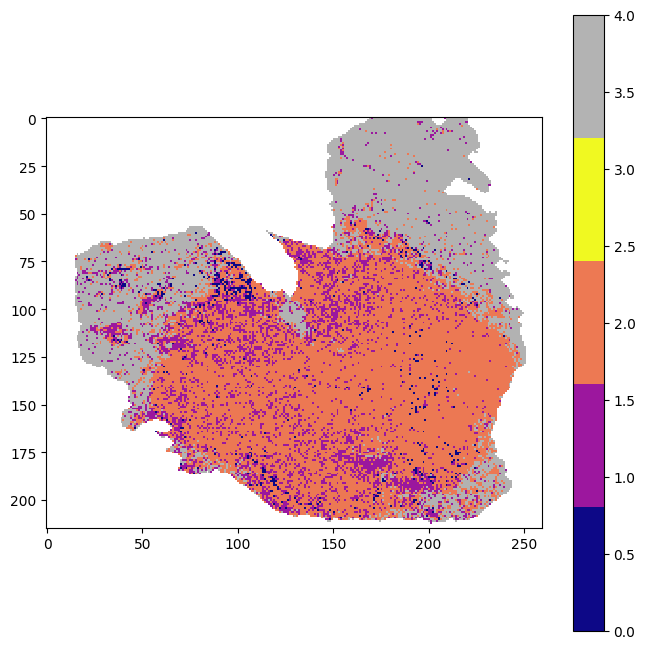

  0%|          | 0/45 [00:00<?, ?it/s]

  4%|▍         | 2/45 [00:00<00:17,  2.44it/s]

  7%|▋         | 3/45 [00:03<00:56,  1.36s/it]

  9%|▉         | 4/45 [00:07<01:33,  2.29s/it]

 11%|█         | 5/45 [00:11<01:58,  2.97s/it]

 13%|█▎        | 6/45 [00:16<02:22,  3.67s/it]

 16%|█▌        | 7/45 [00:22<02:41,  4.26s/it]

 18%|█▊        | 8/45 [00:28<03:02,  4.94s/it]

 20%|██        | 9/45 [00:35<03:16,  5.45s/it]

 22%|██▏       | 10/45 [00:42<03:28,  5.97s/it]

 24%|██▍       | 11/45 [00:49<03:37,  6.40s/it]

 27%|██▋       | 12/45 [00:57<03:44,  6.81s/it]

 29%|██▉       | 13/45 [01:05<03:49,  7.17s/it]

 31%|███       | 14/45 [01:13<03:53,  7.52s/it]

 33%|███▎      | 15/45 [01:22<03:53,  7.77s/it]

 36%|███▌      | 16/45 [01:29<03:44,  7.73s/it]

 38%|███▊      | 17/45 [01:37<03:33,  7.63s/it]

 40%|████      | 18/45 [01:45<03:32,  7.88s/it]

 42%|████▏     | 19/45 [01:53<03:25,  7.89s/it]

 44%|████▍     | 20/45 [02:01<03:14,  7.79s/it]

 47%|████▋     | 21/45 [02:08<03:07,  7.81s/it]

 49%|████▉     | 22/45 [02:17<03:02,  7.91s/it]

 51%|█████     | 23/45 [02:24<02:51,  7.78s/it]

 53%|█████▎    | 24/45 [02:31<02:38,  7.57s/it]

 56%|█████▌    | 25/45 [02:39<02:30,  7.53s/it]

 58%|█████▊    | 26/45 [02:46<02:20,  7.39s/it]

 60%|██████    | 27/45 [02:52<02:09,  7.19s/it]

 62%|██████▏   | 28/45 [02:59<01:58,  6.96s/it]

 64%|██████▍   | 29/45 [03:05<01:48,  6.77s/it]

 67%|██████▋   | 30/45 [03:12<01:43,  6.89s/it]

 69%|██████▉   | 31/45 [03:18<01:32,  6.60s/it]

 71%|███████   | 32/45 [03:24<01:21,  6.29s/it]

 73%|███████▎  | 33/45 [03:29<01:11,  5.95s/it]

 76%|███████▌  | 34/45 [03:34<01:01,  5.55s/it]

 78%|███████▊  | 35/45 [03:37<00:50,  5.02s/it]

 80%|████████  | 36/45 [03:41<00:40,  4.47s/it]

 82%|████████▏ | 37/45 [03:44<00:32,  4.05s/it]

 84%|████████▍ | 38/45 [03:46<00:24,  3.55s/it]

 87%|████████▋ | 39/45 [03:48<00:17,  2.96s/it]

 89%|████████▉ | 40/45 [03:49<00:12,  2.52s/it]

 91%|█████████ | 41/45 [03:50<00:08,  2.08s/it]

100%|██████████| 45/45 [03:50<00:00,  5.13s/it]

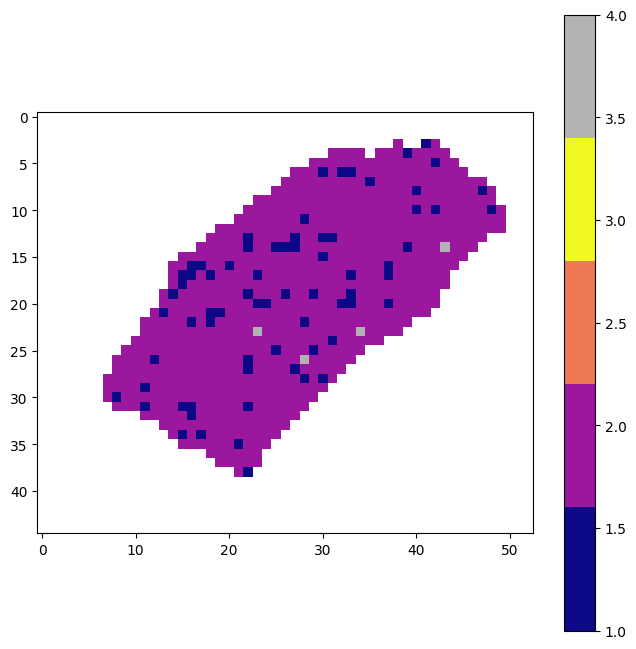

  0%|          | 0/188 [00:00<?, ?it/s]

  4%|▍         | 8/188 [00:00<00:09, 18.66it/s]

  5%|▌         | 10/188 [00:17<06:38,  2.24s/it]

  6%|▌         | 11/188 [00:31<12:27,  4.23s/it]

  6%|▋         | 12/188 [00:51<20:41,  7.05s/it]

  7%|▋         | 13/188 [01:13<29:21, 10.07s/it]

  7%|▋         | 14/188 [01:37<39:00, 13.45s/it]

  8%|▊         | 15/188 [02:05<49:02, 17.01s/it]

  9%|▊         | 16/188 [02:33<56:48, 19.82s/it]

  9%|▉         | 17/188 [03:02<1:03:34, 22.31s/it]

 10%|▉         | 18/188 [03:32<1:09:05, 24.38s/it]

 10%|█         | 19/188 [04:03<1:14:13, 26.35s/it]

 11%|█         | 20/188 [04:35<1:18:12, 27.93s/it]

 11%|█         | 21/188 [05:05<1:19:40, 28.63s/it]

 12%|█▏        | 22/188 [05:37<1:21:55, 29.61s/it]

 12%|█▏        | 23/188 [06:11<1:24:45, 30.82s/it]

 13%|█▎        | 24/188 [06:43<1:25:03, 31.12s/it]

 13%|█▎        | 25/188 [07:16<1:26:19, 31.77s/it]

 14%|█▍        | 26/188 [07:48<1:25:49, 31.79s/it]

 14%|█▍        | 27/188 [08:21<1:26:34, 32.26s/it]

 15%|█▍        | 28/188 [08:54<1:26:30, 32.44s/it]

 15%|█▌        | 29/188 [09:28<1:27:16, 32.93s/it]

 16%|█▌        | 30/188 [10:01<1:26:40, 32.91s/it]

 16%|█▋        | 31/188 [10:36<1:27:35, 33.47s/it]

 17%|█▋        | 32/188 [11:10<1:27:48, 33.77s/it]

 18%|█▊        | 33/188 [11:44<1:27:29, 33.87s/it]

 18%|█▊        | 34/188 [12:18<1:27:10, 33.96s/it]

 19%|█▊        | 35/188 [12:53<1:27:23, 34.27s/it]

 19%|█▉        | 36/188 [13:26<1:25:40, 33.82s/it]

 20%|█▉        | 37/188 [13:58<1:23:57, 33.36s/it]

 20%|██        | 38/188 [14:31<1:22:55, 33.17s/it]

 21%|██        | 39/188 [15:04<1:21:45, 32.92s/it]

 21%|██▏       | 40/188 [15:35<1:19:45, 32.33s/it]

 22%|██▏       | 41/188 [16:05<1:17:58, 31.82s/it]

 22%|██▏       | 42/188 [16:35<1:16:16, 31.35s/it]

 23%|██▎       | 43/188 [17:05<1:14:39, 30.89s/it]

 23%|██▎       | 44/188 [17:35<1:13:15, 30.53s/it]

 24%|██▍       | 45/188 [18:05<1:12:31, 30.43s/it]

 24%|██▍       | 46/188 [18:36<1:12:21, 30.57s/it]

 25%|██▌       | 47/188 [19:06<1:11:35, 30.47s/it]

 26%|██▌       | 48/188 [19:39<1:12:44, 31.17s/it]

 26%|██▌       | 49/188 [20:11<1:12:37, 31.35s/it]

 27%|██▋       | 50/188 [20:42<1:12:13, 31.40s/it]

 27%|██▋       | 51/188 [21:12<1:10:40, 30.96s/it]

 28%|██▊       | 52/188 [21:43<1:10:10, 30.96s/it]

 28%|██▊       | 53/188 [22:18<1:12:08, 32.06s/it]

 29%|██▊       | 54/188 [22:52<1:13:01, 32.70s/it]

 29%|██▉       | 55/188 [23:27<1:13:44, 33.27s/it]

 30%|██▉       | 56/188 [24:00<1:13:02, 33.20s/it]

 30%|███       | 57/188 [24:31<1:11:18, 32.66s/it]

 31%|███       | 58/188 [25:01<1:08:58, 31.83s/it]

 31%|███▏      | 59/188 [25:32<1:08:03, 31.65s/it]

 32%|███▏      | 60/188 [26:05<1:07:57, 31.86s/it]

 32%|███▏      | 61/188 [26:36<1:07:26, 31.86s/it]

 33%|███▎      | 62/188 [27:09<1:07:23, 32.09s/it]

 34%|███▎      | 63/188 [27:43<1:08:11, 32.73s/it]

 34%|███▍      | 64/188 [28:12<1:05:23, 31.64s/it]

 35%|███▍      | 65/188 [28:46<1:05:53, 32.14s/it]

 35%|███▌      | 66/188 [29:19<1:06:04, 32.50s/it]

 36%|███▌      | 67/188 [29:53<1:06:18, 32.88s/it]

 36%|███▌      | 68/188 [30:28<1:07:01, 33.51s/it]

 37%|███▋      | 69/188 [31:02<1:07:09, 33.86s/it]

 37%|███▋      | 70/188 [31:37<1:07:00, 34.07s/it]

 38%|███▊      | 71/188 [32:12<1:07:04, 34.40s/it]

 38%|███▊      | 72/188 [32:46<1:06:24, 34.35s/it]

 39%|███▉      | 73/188 [33:22<1:06:23, 34.64s/it]

 39%|███▉      | 74/188 [33:54<1:04:44, 34.08s/it]

 40%|███▉      | 75/188 [34:29<1:04:10, 34.08s/it]

 40%|████      | 76/188 [35:03<1:04:04, 34.32s/it]

 41%|████      | 77/188 [35:40<1:04:58, 35.12s/it]

 41%|████▏     | 78/188 [36:16<1:04:38, 35.26s/it]

 42%|████▏     | 79/188 [36:50<1:03:24, 34.91s/it]

 43%|████▎     | 80/188 [37:25<1:02:58, 34.99s/it]

 43%|████▎     | 81/188 [38:04<1:04:30, 36.17s/it]

 44%|████▎     | 82/188 [38:42<1:04:46, 36.66s/it]

 44%|████▍     | 83/188 [39:15<1:02:28, 35.70s/it]

 45%|████▍     | 84/188 [39:51<1:01:58, 35.75s/it]

 45%|████▌     | 85/188 [40:29<1:02:09, 36.21s/it]

 46%|████▌     | 86/188 [41:05<1:01:40, 36.28s/it]

 46%|████▋     | 87/188 [41:45<1:02:56, 37.39s/it]

 47%|████▋     | 88/188 [42:23<1:02:41, 37.61s/it]

 47%|████▋     | 89/188 [43:02<1:02:35, 37.94s/it]

 48%|████▊     | 90/188 [43:41<1:02:37, 38.35s/it]

 48%|████▊     | 91/188 [44:20<1:02:09, 38.45s/it]

 49%|████▉     | 92/188 [44:59<1:01:50, 38.65s/it]

 49%|████▉     | 93/188 [45:37<1:01:08, 38.61s/it]

 50%|█████     | 94/188 [46:17<1:00:47, 38.80s/it]

 51%|█████     | 95/188 [46:58<1:01:21, 39.59s/it]

 51%|█████     | 96/188 [47:38<1:00:40, 39.57s/it]

 52%|█████▏    | 97/188 [48:17<59:45, 39.41s/it]  

 52%|█████▏    | 98/188 [48:56<58:59, 39.32s/it]

 53%|█████▎    | 99/188 [49:37<59:08, 39.87s/it]

 53%|█████▎    | 100/188 [50:17<58:41, 40.02s/it]

 54%|█████▎    | 101/188 [50:58<58:05, 40.07s/it]

 54%|█████▍    | 102/188 [51:38<57:46, 40.30s/it]

 55%|█████▍    | 103/188 [52:19<57:12, 40.39s/it]

 55%|█████▌    | 104/188 [53:02<57:30, 41.08s/it]

 56%|█████▌    | 105/188 [53:43<57:03, 41.25s/it]

 56%|█████▋    | 106/188 [54:24<55:59, 40.98s/it]

 57%|█████▋    | 107/188 [55:04<55:04, 40.79s/it]

 57%|█████▋    | 108/188 [55:46<54:40, 41.01s/it]

 58%|█████▊    | 109/188 [56:30<55:23, 42.06s/it]

 59%|█████▊    | 110/188 [57:16<56:13, 43.25s/it]

 59%|█████▉    | 111/188 [58:01<55:58, 43.62s/it]

 60%|█████▉    | 112/188 [58:45<55:31, 43.83s/it]

 60%|██████    | 113/188 [59:29<54:55, 43.94s/it]

 61%|██████    | 114/188 [1:00:20<56:49, 46.07s/it]

 61%|██████    | 115/188 [1:01:04<55:14, 45.40s/it]

 62%|██████▏   | 116/188 [1:01:48<54:09, 45.14s/it]

 62%|██████▏   | 117/188 [1:02:35<53:50, 45.49s/it]

 63%|██████▎   | 118/188 [1:03:20<53:03, 45.48s/it]

 63%|██████▎   | 119/188 [1:04:09<53:22, 46.42s/it]

 64%|██████▍   | 120/188 [1:04:57<53:15, 46.99s/it]

 64%|██████▍   | 121/188 [1:05:45<52:50, 47.32s/it]

 65%|██████▍   | 122/188 [1:06:33<52:17, 47.54s/it]

 65%|██████▌   | 123/188 [1:07:20<51:14, 47.30s/it]

 66%|██████▌   | 124/188 [1:08:17<53:37, 50.27s/it]

 66%|██████▋   | 125/188 [1:09:03<51:29, 49.04s/it]

 67%|██████▋   | 126/188 [1:09:48<49:09, 47.58s/it]

 68%|██████▊   | 127/188 [1:10:40<49:47, 48.98s/it]

 68%|██████▊   | 128/188 [1:11:24<47:40, 47.67s/it]

 69%|██████▊   | 129/188 [1:12:09<46:00, 46.79s/it]

 69%|██████▉   | 130/188 [1:12:54<44:46, 46.33s/it]

 70%|██████▉   | 131/188 [1:13:44<45:03, 47.42s/it]

 70%|███████   | 132/188 [1:14:31<44:08, 47.30s/it]

 71%|███████   | 133/188 [1:17:59<1:27:19, 95.27s/it]

 71%|███████▏  | 134/188 [1:18:45<1:12:38, 80.71s/it]

 72%|███████▏  | 135/188 [1:19:32<1:02:10, 70.40s/it]

 72%|███████▏  | 136/188 [1:20:16<54:18, 62.66s/it]  

 73%|███████▎  | 137/188 [1:21:01<48:41, 57.28s/it]

 73%|███████▎  | 138/188 [1:21:45<44:25, 53.31s/it]

 74%|███████▍  | 139/188 [1:22:31<41:41, 51.05s/it]

 74%|███████▍  | 140/188 [1:23:15<39:13, 49.03s/it]

 75%|███████▌  | 141/188 [1:23:58<37:01, 47.26s/it]

 76%|███████▌  | 142/188 [1:24:40<35:03, 45.73s/it]

 76%|███████▌  | 143/188 [1:25:25<33:59, 45.31s/it]

 77%|███████▋  | 144/188 [1:26:07<32:37, 44.48s/it]

 77%|███████▋  | 145/188 [1:26:48<31:04, 43.37s/it]

 78%|███████▊  | 146/188 [1:27:29<29:47, 42.56s/it]

 78%|███████▊  | 147/188 [1:28:07<28:15, 41.35s/it]

 79%|███████▊  | 148/188 [1:28:46<26:58, 40.46s/it]

 79%|███████▉  | 149/188 [1:29:21<25:21, 39.00s/it]

 80%|███████▉  | 150/188 [1:35:16<1:24:42, 133.74s/it]

 80%|████████  | 151/188 [1:36:20<1:09:35, 112.85s/it]

 81%|████████  | 152/188 [1:36:58<54:10, 90.30s/it]   

 81%|████████▏ | 153/188 [1:37:37<43:46, 75.05s/it]

 82%|████████▏ | 154/188 [1:38:13<35:52, 63.31s/it]

 82%|████████▏ | 155/188 [1:38:52<30:41, 55.81s/it]

 83%|████████▎ | 156/188 [1:39:27<26:30, 49.69s/it]

 84%|████████▎ | 157/188 [1:40:00<23:04, 44.65s/it]

 84%|████████▍ | 158/188 [1:40:34<20:41, 41.38s/it]

 85%|████████▍ | 159/188 [1:41:18<20:23, 42.19s/it]

 85%|████████▌ | 160/188 [1:41:50<18:14, 39.09s/it]

 86%|████████▌ | 161/188 [1:42:21<16:30, 36.68s/it]

 86%|████████▌ | 162/188 [1:42:48<14:41, 33.89s/it]

 87%|████████▋ | 163/188 [1:43:16<13:23, 32.13s/it]

 87%|████████▋ | 164/188 [1:43:43<12:13, 30.57s/it]

 88%|████████▊ | 165/188 [1:44:10<11:16, 29.39s/it]

 88%|████████▊ | 166/188 [1:44:34<10:15, 27.98s/it]

 89%|████████▉ | 167/188 [1:44:58<09:22, 26.79s/it]

 89%|████████▉ | 168/188 [1:45:23<08:45, 26.26s/it]

 90%|████████▉ | 169/188 [1:45:47<08:02, 25.38s/it]

 90%|█████████ | 170/188 [1:46:10<07:25, 24.74s/it]

 91%|█████████ | 171/188 [1:46:31<06:41, 23.60s/it]

 91%|█████████▏| 172/188 [1:46:50<05:55, 22.19s/it]

 92%|█████████▏| 173/188 [1:47:09<05:19, 21.33s/it]

 93%|█████████▎| 174/188 [1:47:26<04:39, 19.99s/it]

 93%|█████████▎| 175/188 [1:47:41<04:01, 18.55s/it]

 94%|█████████▎| 176/188 [1:47:56<03:29, 17.43s/it]

 94%|█████████▍| 177/188 [1:48:07<02:51, 15.62s/it]

 95%|█████████▍| 178/188 [1:48:11<02:01, 12.10s/it]

 95%|█████████▌| 179/188 [1:48:12<01:17,  8.63s/it]

 96%|█████████▌| 180/188 [1:48:12<00:48,  6.12s/it]

 96%|█████████▋| 181/188 [1:48:12<00:30,  4.36s/it]

 97%|█████████▋| 182/188 [1:48:13<00:18,  3.13s/it]

 97%|█████████▋| 183/188 [1:48:13<00:12,  2.48s/it]

 98%|█████████▊| 184/188 [1:48:15<00:08,  2.06s/it]

 98%|█████████▊| 185/188 [1:48:16<00:05,  1.86s/it]

 99%|█████████▉| 186/188 [1:48:17<00:03,  1.60s/it]

 99%|█████████▉| 187/188 [1:48:17<00:01,  1.28s/it]

100%|██████████| 188/188 [1:48:18<00:00,  1.05s/it]

100%|██████████| 188/188 [1:48:18<00:00, 34.57s/it]

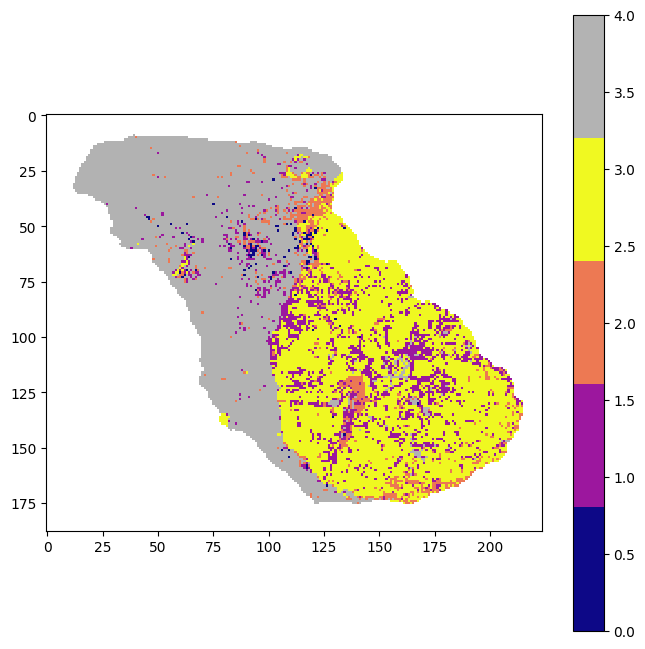

  0%|          | 0/186 [00:00<?, ?it/s]

  1%|          | 1/186 [00:08<26:37,  8.63s/it]

  1%|          | 2/186 [00:17<27:41,  9.03s/it]

  2%|▏         | 3/186 [00:26<26:55,  8.83s/it]

  2%|▏         | 4/186 [00:36<27:36,  9.10s/it]

  3%|▎         | 5/186 [00:45<28:16,  9.37s/it]

  3%|▎         | 6/186 [00:55<28:20,  9.45s/it]

  4%|▍         | 7/186 [01:04<27:56,  9.37s/it]

  4%|▍         | 8/186 [01:13<27:11,  9.17s/it]

  5%|▍         | 9/186 [01:21<26:02,  8.83s/it]

  5%|▌         | 10/186 [01:28<24:34,  8.38s/it]

  6%|▌         | 11/186 [01:35<22:55,  7.86s/it]

  6%|▋         | 12/186 [01:42<21:53,  7.55s/it]

  7%|▋         | 13/186 [01:48<20:48,  7.22s/it]

  8%|▊         | 14/186 [01:55<20:12,  7.05s/it]

  8%|▊         | 15/186 [02:01<19:29,  6.84s/it]

  9%|▊         | 16/186 [02:09<19:48,  6.99s/it]

  9%|▉         | 17/186 [02:18<21:13,  7.53s/it]

 10%|▉         | 18/186 [02:27<22:32,  8.05s/it]

 10%|█         | 19/186 [02:39<25:54,  9.31s/it]

 11%|█         | 20/186 [02:52<29:04, 10.51s/it]

 11%|█▏        | 21/186 [03:06<31:33, 11.48s/it]

 12%|█▏        | 22/186 [03:19<32:50, 12.01s/it]

 12%|█▏        | 23/186 [03:33<34:05, 12.55s/it]

 13%|█▎        | 24/186 [03:49<36:24, 13.48s/it]

 13%|█▎        | 25/186 [04:05<38:15, 14.26s/it]

 14%|█▍        | 26/186 [04:22<40:39, 15.25s/it]

 15%|█▍        | 27/186 [04:41<43:19, 16.35s/it]

 15%|█▌        | 28/186 [05:02<46:13, 17.55s/it]

 16%|█▌        | 29/186 [05:24<50:02, 19.13s/it]

 16%|█▌        | 30/186 [05:47<52:20, 20.13s/it]

 17%|█▋        | 31/186 [06:11<55:08, 21.34s/it]

 17%|█▋        | 32/186 [06:37<58:04, 22.62s/it]

 18%|█▊        | 33/186 [07:01<58:37, 22.99s/it]

 18%|█▊        | 34/186 [07:25<59:40, 23.56s/it]

 19%|█▉        | 35/186 [07:53<1:01:57, 24.62s/it]

 19%|█▉        | 36/186 [08:22<1:05:18, 26.12s/it]

 20%|█▉        | 37/186 [08:51<1:07:07, 27.03s/it]

 20%|██        | 38/186 [09:22<1:09:40, 28.25s/it]

 21%|██        | 39/186 [09:55<1:12:14, 29.49s/it]

 22%|██▏       | 40/186 [10:26<1:12:41, 29.88s/it]

 22%|██▏       | 41/186 [10:57<1:13:03, 30.23s/it]

 23%|██▎       | 42/186 [11:28<1:13:19, 30.55s/it]

 23%|██▎       | 43/186 [12:02<1:14:58, 31.46s/it]

 24%|██▎       | 44/186 [12:37<1:17:04, 32.57s/it]

 24%|██▍       | 45/186 [13:13<1:19:30, 33.83s/it]

 25%|██▍       | 46/186 [13:50<1:20:32, 34.52s/it]

 25%|██▌       | 47/186 [14:27<1:21:50, 35.33s/it]

 26%|██▌       | 48/186 [15:04<1:22:30, 35.88s/it]

 26%|██▋       | 49/186 [15:39<1:21:32, 35.72s/it]

 27%|██▋       | 50/186 [16:15<1:21:04, 35.77s/it]

 27%|██▋       | 51/186 [16:52<1:21:29, 36.22s/it]

 28%|██▊       | 52/186 [17:29<1:21:26, 36.47s/it]

 28%|██▊       | 53/186 [18:07<1:21:51, 36.93s/it]

 29%|██▉       | 54/186 [18:47<1:22:37, 37.55s/it]

 30%|██▉       | 55/186 [19:25<1:22:19, 37.71s/it]

 30%|███       | 56/186 [20:01<1:20:49, 37.30s/it]

 31%|███       | 57/186 [20:37<1:19:26, 36.95s/it]

 31%|███       | 58/186 [21:13<1:18:08, 36.63s/it]

 32%|███▏      | 59/186 [21:51<1:18:43, 37.19s/it]

 32%|███▏      | 60/186 [22:29<1:18:11, 37.23s/it]

 33%|███▎      | 61/186 [23:07<1:17:55, 37.41s/it]

 33%|███▎      | 62/186 [23:47<1:19:07, 38.29s/it]

 34%|███▍      | 63/186 [24:26<1:18:47, 38.44s/it]

 34%|███▍      | 64/186 [25:06<1:19:26, 39.07s/it]

 35%|███▍      | 65/186 [25:48<1:20:32, 39.93s/it]

 35%|███▌      | 66/186 [26:29<1:20:13, 40.11s/it]

 36%|███▌      | 67/186 [27:09<1:19:45, 40.22s/it]

 37%|███▋      | 68/186 [27:52<1:20:25, 40.89s/it]

 37%|███▋      | 69/186 [28:34<1:20:34, 41.32s/it]

 38%|███▊      | 70/186 [29:16<1:20:04, 41.42s/it]

 38%|███▊      | 71/186 [29:58<1:19:40, 41.57s/it]

 39%|███▊      | 72/186 [30:40<1:19:17, 41.73s/it]

 39%|███▉      | 73/186 [31:23<1:19:40, 42.31s/it]

 40%|███▉      | 74/186 [32:09<1:21:01, 43.41s/it]

 40%|████      | 75/186 [32:55<1:21:41, 44.15s/it]

 41%|████      | 76/186 [33:44<1:23:25, 45.51s/it]

 41%|████▏     | 77/186 [34:33<1:24:29, 46.51s/it]

 42%|████▏     | 78/186 [35:21<1:24:40, 47.04s/it]

 42%|████▏     | 79/186 [36:12<1:25:51, 48.14s/it]

 43%|████▎     | 80/186 [37:03<1:26:57, 49.23s/it]

 44%|████▎     | 81/186 [37:53<1:26:30, 49.43s/it]

 44%|████▍     | 82/186 [38:46<1:27:15, 50.34s/it]

 45%|████▍     | 83/186 [39:36<1:26:16, 50.26s/it]

 45%|████▌     | 84/186 [40:26<1:25:25, 50.25s/it]

 46%|████▌     | 85/186 [41:15<1:23:55, 49.86s/it]

 46%|████▌     | 86/186 [42:03<1:22:13, 49.34s/it]

 47%|████▋     | 87/186 [42:51<1:20:46, 48.96s/it]

 47%|████▋     | 88/186 [43:44<1:21:46, 50.07s/it]

 48%|████▊     | 89/186 [44:34<1:20:50, 50.01s/it]

 48%|████▊     | 90/186 [45:25<1:20:22, 50.23s/it]

 49%|████▉     | 91/186 [46:17<1:20:40, 50.95s/it]

 49%|████▉     | 92/186 [47:11<1:20:59, 51.70s/it]

 50%|█████     | 93/186 [48:03<1:20:14, 51.77s/it]

 51%|█████     | 94/186 [48:55<1:19:38, 51.94s/it]

 51%|█████     | 95/186 [49:46<1:18:15, 51.60s/it]

 52%|█████▏    | 96/186 [50:36<1:16:36, 51.07s/it]

 52%|█████▏    | 97/186 [51:25<1:15:11, 50.69s/it]

 53%|█████▎    | 98/186 [52:16<1:14:16, 50.64s/it]

 53%|█████▎    | 99/186 [53:06<1:13:19, 50.57s/it]

 54%|█████▍    | 100/186 [53:59<1:13:23, 51.21s/it]

 54%|█████▍    | 101/186 [54:50<1:12:36, 51.26s/it]

 55%|█████▍    | 102/186 [55:42<1:11:44, 51.24s/it]

 55%|█████▌    | 103/186 [56:35<1:11:52, 51.96s/it]

 56%|█████▌    | 104/186 [57:29<1:11:57, 52.65s/it]

 56%|█████▋    | 105/186 [58:22<1:11:12, 52.74s/it]

 57%|█████▋    | 106/186 [59:12<1:09:02, 51.79s/it]

 58%|█████▊    | 107/186 [1:00:05<1:08:32, 52.06s/it]

 58%|█████▊    | 108/186 [1:00:58<1:08:19, 52.56s/it]

 59%|█████▊    | 109/186 [1:01:53<1:08:11, 53.14s/it]

 59%|█████▉    | 110/186 [1:02:43<1:06:05, 52.17s/it]

 60%|█████▉    | 111/186 [1:03:32<1:04:00, 51.20s/it]

 60%|██████    | 112/186 [1:04:21<1:02:21, 50.56s/it]

 61%|██████    | 113/186 [1:05:10<1:00:57, 50.10s/it]

 61%|██████▏   | 114/186 [1:05:59<59:37, 49.69s/it]  

 62%|██████▏   | 115/186 [1:06:54<1:00:58, 51.52s/it]

 62%|██████▏   | 116/186 [1:07:45<59:52, 51.32s/it]  

 63%|██████▎   | 117/186 [1:08:37<59:01, 51.33s/it]

 63%|██████▎   | 118/186 [1:09:31<59:07, 52.18s/it]

 64%|██████▍   | 119/186 [1:10:26<59:16, 53.09s/it]

 65%|██████▍   | 120/186 [1:11:19<58:23, 53.08s/it]

 65%|██████▌   | 121/186 [1:12:10<56:53, 52.52s/it]

 66%|██████▌   | 122/186 [1:13:01<55:20, 51.89s/it]

 66%|██████▌   | 123/186 [1:13:52<54:18, 51.73s/it]

 67%|██████▋   | 124/186 [1:14:41<52:43, 51.03s/it]

 67%|██████▋   | 125/186 [1:15:33<51:55, 51.08s/it]

 68%|██████▊   | 126/186 [1:16:24<51:09, 51.16s/it]

 68%|██████▊   | 127/186 [1:17:17<50:47, 51.66s/it]

 69%|██████▉   | 128/186 [1:18:07<49:40, 51.39s/it]

 69%|██████▉   | 129/186 [1:18:58<48:35, 51.15s/it]

 70%|██████▉   | 130/186 [1:19:50<47:56, 51.36s/it]

 70%|███████   | 131/186 [1:20:38<46:11, 50.40s/it]

 71%|███████   | 132/186 [1:21:28<45:10, 50.19s/it]

 72%|███████▏  | 133/186 [1:22:16<43:47, 49.57s/it]

 72%|███████▏  | 134/186 [1:23:05<42:44, 49.31s/it]

 73%|███████▎  | 135/186 [1:23:53<41:40, 49.03s/it]

 73%|███████▎  | 136/186 [1:24:40<40:26, 48.53s/it]

 74%|███████▎  | 137/186 [1:25:27<39:11, 47.99s/it]

 74%|███████▍  | 138/186 [1:26:14<38:13, 47.77s/it]

 75%|███████▍  | 139/186 [1:27:04<37:58, 48.48s/it]

 75%|███████▌  | 140/186 [1:27:52<36:50, 48.06s/it]

 76%|███████▌  | 141/186 [1:28:38<35:37, 47.51s/it]

 76%|███████▋  | 142/186 [1:29:22<34:13, 46.68s/it]

 77%|███████▋  | 143/186 [1:30:08<33:13, 46.37s/it]

 77%|███████▋  | 144/186 [1:30:50<31:35, 45.14s/it]

 78%|███████▊  | 145/186 [1:31:31<29:56, 43.81s/it]

 78%|███████▊  | 146/186 [1:32:13<28:43, 43.08s/it]

 79%|███████▉  | 147/186 [1:32:52<27:18, 42.02s/it]

 80%|███████▉  | 148/186 [1:33:32<26:07, 41.25s/it]

 80%|████████  | 149/186 [1:34:09<24:44, 40.13s/it]

 81%|████████  | 150/186 [1:34:45<23:18, 38.84s/it]

 81%|████████  | 151/186 [1:35:20<22:04, 37.85s/it]

 82%|████████▏ | 152/186 [1:35:55<20:57, 36.98s/it]

 82%|████████▏ | 153/186 [1:36:29<19:50, 36.08s/it]

 83%|████████▎ | 154/186 [1:37:00<18:24, 34.53s/it]

 83%|████████▎ | 155/186 [1:37:28<16:49, 32.55s/it]

 84%|████████▍ | 156/186 [1:37:56<15:32, 31.09s/it]

 84%|████████▍ | 157/186 [1:38:22<14:22, 29.73s/it]

 85%|████████▍ | 158/186 [1:38:50<13:34, 29.09s/it]

 85%|████████▌ | 159/186 [1:39:16<12:41, 28.19s/it]

 86%|████████▌ | 160/186 [1:39:43<11:59, 27.66s/it]

 87%|████████▋ | 161/186 [1:40:06<11:02, 26.52s/it]

 87%|████████▋ | 162/186 [1:40:29<10:05, 25.22s/it]

 88%|████████▊ | 163/186 [1:40:49<09:10, 23.94s/it]

 88%|████████▊ | 164/186 [1:41:10<08:26, 23.00s/it]

 89%|████████▊ | 165/186 [1:41:30<07:41, 22.00s/it]

 89%|████████▉ | 166/186 [1:41:50<07:07, 21.36s/it]

 90%|████████▉ | 167/186 [1:42:12<06:47, 21.46s/it]

 90%|█████████ | 168/186 [1:42:31<06:15, 20.85s/it]

 91%|█████████ | 169/186 [1:42:49<05:38, 19.91s/it]

 91%|█████████▏| 170/186 [1:43:02<04:48, 18.05s/it]

 92%|█████████▏| 171/186 [1:43:15<04:06, 16.46s/it]

 92%|█████████▏| 172/186 [1:43:27<03:33, 15.23s/it]

 93%|█████████▎| 173/186 [1:43:38<02:58, 13.70s/it]

 94%|█████████▎| 174/186 [1:43:46<02:25, 12.14s/it]

 94%|█████████▍| 175/186 [1:43:53<01:55, 10.51s/it]

 95%|█████████▍| 176/186 [1:43:59<01:31,  9.15s/it]

 95%|█████████▌| 177/186 [1:44:04<01:10,  7.85s/it]

 96%|█████████▌| 178/186 [1:44:08<00:53,  6.74s/it]

 96%|█████████▌| 179/186 [1:44:09<00:35,  5.05s/it]

100%|██████████| 186/186 [1:44:09<00:00, 33.60s/it]

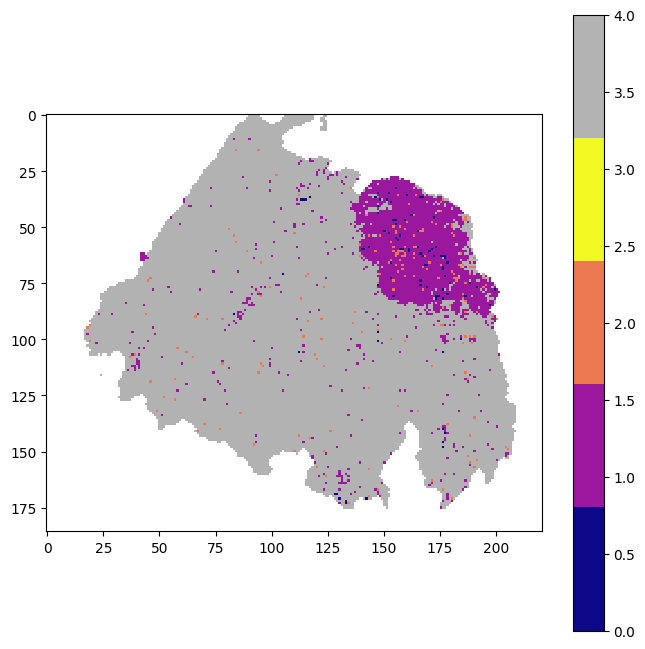

  0%|          | 0/215 [00:00<?, ?it/s]

  6%|▌         | 12/215 [00:00<00:12, 16.86it/s]

  7%|▋         | 14/215 [00:08<02:33,  1.31it/s]

  7%|▋         | 15/215 [00:12<04:10,  1.25s/it]

  7%|▋         | 16/215 [00:18<06:00,  1.81s/it]

  8%|▊         | 17/215 [00:24<08:23,  2.54s/it]

  8%|▊         | 18/215 [00:30<11:01,  3.36s/it]

  9%|▉         | 19/215 [00:39<15:16,  4.68s/it]

  9%|▉         | 20/215 [00:54<22:40,  6.98s/it]

 10%|▉         | 21/215 [01:07<28:01,  8.67s/it]

 10%|█         | 22/215 [01:21<31:55,  9.92s/it]

 11%|█         | 23/215 [01:39<38:45, 12.11s/it]

 11%|█         | 24/215 [02:04<50:51, 15.97s/it]

 12%|█▏        | 25/215 [02:34<1:03:16, 19.98s/it]

 12%|█▏        | 26/215 [03:08<1:15:18, 23.91s/it]

 13%|█▎        | 27/215 [03:43<1:25:29, 27.28s/it]

 13%|█▎        | 28/215 [04:22<1:35:45, 30.72s/it]

 13%|█▎        | 29/215 [05:00<1:42:07, 32.94s/it]

 14%|█▍        | 30/215 [05:41<1:48:46, 35.28s/it]

 14%|█▍        | 31/215 [06:23<1:54:30, 37.34s/it]

 15%|█▍        | 32/215 [07:07<1:59:35, 39.21s/it]

 15%|█▌        | 33/215 [07:48<2:00:58, 39.88s/it]

 16%|█▌        | 34/215 [08:33<2:04:44, 41.35s/it]

 16%|█▋        | 35/215 [09:19<2:08:08, 42.72s/it]

 17%|█▋        | 36/215 [10:05<2:10:26, 43.72s/it]

 17%|█▋        | 37/215 [10:56<2:16:37, 46.06s/it]

 18%|█▊        | 38/215 [11:49<2:21:39, 48.02s/it]

 18%|█▊        | 39/215 [12:38<2:21:52, 48.36s/it]

 19%|█▊        | 40/215 [13:33<2:27:06, 50.44s/it]

 19%|█▉        | 41/215 [14:29<2:30:54, 52.04s/it]

 20%|█▉        | 42/215 [15:20<2:28:35, 51.53s/it]

 20%|██        | 43/215 [16:10<2:26:52, 51.24s/it]

 20%|██        | 44/215 [17:04<2:27:58, 51.92s/it]

 21%|██        | 45/215 [17:58<2:28:50, 52.53s/it]

 21%|██▏       | 46/215 [18:52<2:29:51, 53.20s/it]

 22%|██▏       | 47/215 [19:49<2:31:54, 54.25s/it]

 22%|██▏       | 48/215 [20:45<2:32:13, 54.69s/it]

 23%|██▎       | 49/215 [21:39<2:31:10, 54.64s/it]

 23%|██▎       | 50/215 [22:38<2:33:34, 55.84s/it]

 24%|██▎       | 51/215 [23:36<2:34:17, 56.45s/it]

 24%|██▍       | 52/215 [24:38<2:37:39, 58.03s/it]

 25%|██▍       | 53/215 [25:40<2:40:15, 59.36s/it]

 25%|██▌       | 54/215 [26:42<2:41:14, 60.09s/it]

 26%|██▌       | 55/215 [27:46<2:43:36, 61.35s/it]

 26%|██▌       | 56/215 [28:49<2:43:56, 61.86s/it]

 27%|██▋       | 57/215 [29:50<2:42:07, 61.56s/it]

 27%|██▋       | 58/215 [30:52<2:41:26, 61.70s/it]

 27%|██▋       | 59/215 [31:56<2:42:31, 62.51s/it]

 28%|██▊       | 60/215 [33:00<2:42:25, 62.87s/it]

 28%|██▊       | 61/215 [34:09<2:46:18, 64.80s/it]

 29%|██▉       | 62/215 [35:16<2:46:31, 65.31s/it]

 29%|██▉       | 63/215 [36:21<2:45:32, 65.34s/it]

 30%|██▉       | 64/215 [37:25<2:42:56, 64.75s/it]

 30%|███       | 65/215 [38:30<2:41:58, 64.79s/it]

 31%|███       | 66/215 [39:35<2:41:35, 65.07s/it]

 31%|███       | 67/215 [40:39<2:39:24, 64.63s/it]

 32%|███▏      | 68/215 [41:46<2:40:20, 65.44s/it]

 32%|███▏      | 69/215 [42:53<2:40:02, 65.77s/it]

 33%|███▎      | 70/215 [43:58<2:38:46, 65.70s/it]

 33%|███▎      | 71/215 [45:07<2:39:50, 66.60s/it]

 33%|███▎      | 72/215 [46:18<2:41:30, 67.76s/it]

 34%|███▍      | 73/215 [47:29<2:42:48, 68.79s/it]

 34%|███▍      | 74/215 [48:34<2:39:03, 67.69s/it]

 35%|███▍      | 75/215 [49:44<2:39:21, 68.29s/it]

 35%|███▌      | 76/215 [50:52<2:38:37, 68.47s/it]

 36%|███▌      | 77/215 [52:00<2:36:34, 68.08s/it]

 36%|███▋      | 78/215 [53:09<2:36:15, 68.44s/it]

 37%|███▋      | 79/215 [54:22<2:38:10, 69.78s/it]

 37%|███▋      | 80/215 [55:34<2:38:44, 70.55s/it]

 38%|███▊      | 81/215 [56:44<2:36:57, 70.28s/it]

 38%|███▊      | 82/215 [57:55<2:36:16, 70.50s/it]

 39%|███▊      | 83/215 [59:02<2:33:09, 69.62s/it]

 39%|███▉      | 84/215 [1:00:13<2:32:49, 69.99s/it]

 40%|███▉      | 85/215 [1:01:21<2:30:15, 69.35s/it]

 40%|████      | 86/215 [1:02:31<2:29:22, 69.48s/it]

 40%|████      | 87/215 [1:03:37<2:26:12, 68.53s/it]

 41%|████      | 88/215 [1:04:49<2:27:23, 69.63s/it]

 41%|████▏     | 89/215 [1:05:56<2:24:30, 68.81s/it]

 42%|████▏     | 90/215 [1:07:03<2:22:19, 68.32s/it]

 42%|████▏     | 91/215 [1:08:12<2:21:10, 68.31s/it]

 43%|████▎     | 92/215 [1:09:30<2:26:16, 71.36s/it]

 43%|████▎     | 93/215 [1:10:42<2:25:06, 71.36s/it]

 44%|████▎     | 94/215 [1:11:52<2:23:01, 70.92s/it]

 44%|████▍     | 95/215 [1:13:07<2:24:21, 72.18s/it]

 45%|████▍     | 96/215 [1:14:20<2:24:00, 72.61s/it]

 45%|████▌     | 97/215 [1:15:33<2:22:39, 72.54s/it]

 46%|████▌     | 98/215 [1:16:46<2:22:11, 72.92s/it]

 46%|████▌     | 99/215 [1:17:59<2:20:36, 72.73s/it]

 47%|████▋     | 100/215 [1:19:10<2:18:48, 72.42s/it]

 47%|████▋     | 101/215 [1:20:22<2:17:09, 72.19s/it]

 47%|████▋     | 102/215 [1:21:35<2:16:14, 72.34s/it]

 48%|████▊     | 103/215 [1:22:49<2:16:18, 73.02s/it]

 48%|████▊     | 104/215 [1:24:09<2:18:49, 75.04s/it]

 49%|████▉     | 105/215 [1:25:23<2:17:10, 74.82s/it]

 49%|████▉     | 106/215 [1:26:36<2:14:26, 74.01s/it]

 50%|████▉     | 107/215 [1:27:52<2:14:24, 74.67s/it]

 50%|█████     | 108/215 [1:29:10<2:15:05, 75.76s/it]

 51%|█████     | 109/215 [1:30:23<2:12:34, 75.05s/it]

 51%|█████     | 110/215 [1:31:35<2:09:27, 73.98s/it]

 52%|█████▏    | 111/215 [1:32:48<2:07:48, 73.73s/it]

 52%|█████▏    | 112/215 [1:34:02<2:06:27, 73.66s/it]

 53%|█████▎    | 113/215 [1:35:12<2:03:46, 72.81s/it]

 53%|█████▎    | 114/215 [1:36:26<2:02:48, 72.96s/it]

 53%|█████▎    | 115/215 [1:37:35<1:59:53, 71.93s/it]

 54%|█████▍    | 116/215 [1:38:45<1:57:32, 71.24s/it]

 54%|█████▍    | 117/215 [1:39:56<1:56:17, 71.20s/it]

 55%|█████▍    | 118/215 [1:41:08<1:55:26, 71.40s/it]

 55%|█████▌    | 119/215 [1:42:20<1:54:49, 71.77s/it]

 56%|█████▌    | 120/215 [1:43:35<1:54:50, 72.53s/it]

 56%|█████▋    | 121/215 [1:44:47<1:53:16, 72.30s/it]

 57%|█████▋    | 122/215 [1:45:59<1:51:59, 72.25s/it]

 57%|█████▋    | 123/215 [1:47:11<1:50:41, 72.19s/it]

 58%|█████▊    | 124/215 [1:48:23<1:49:44, 72.36s/it]

 58%|█████▊    | 125/215 [1:49:35<1:48:23, 72.26s/it]

 59%|█████▊    | 126/215 [1:50:50<1:48:18, 73.02s/it]

 59%|█████▉    | 127/215 [1:52:04<1:47:32, 73.32s/it]

 60%|█████▉    | 128/215 [1:53:17<1:46:12, 73.25s/it]

 60%|██████    | 129/215 [1:54:30<1:44:51, 73.15s/it]

 60%|██████    | 130/215 [1:55:44<1:43:54, 73.34s/it]

 61%|██████    | 131/215 [1:57:00<1:43:52, 74.20s/it]

 61%|██████▏   | 132/215 [1:58:14<1:42:17, 73.95s/it]

 62%|██████▏   | 133/215 [1:59:29<1:41:45, 74.46s/it]

 62%|██████▏   | 134/215 [2:00:48<1:42:17, 75.77s/it]

 63%|██████▎   | 135/215 [2:02:02<1:40:20, 75.26s/it]

 63%|██████▎   | 136/215 [2:03:18<1:39:18, 75.43s/it]

 64%|██████▎   | 137/215 [2:04:34<1:38:07, 75.48s/it]

 64%|██████▍   | 138/215 [2:05:46<1:35:51, 74.69s/it]

 65%|██████▍   | 139/215 [2:07:02<1:35:04, 75.06s/it]

 65%|██████▌   | 140/215 [2:08:17<1:33:41, 74.95s/it]

 66%|██████▌   | 141/215 [2:09:31<1:31:58, 74.58s/it]

 66%|██████▌   | 142/215 [2:10:45<1:30:40, 74.53s/it]

 67%|██████▋   | 143/215 [2:11:58<1:28:54, 74.08s/it]

 67%|██████▋   | 144/215 [2:13:10<1:26:50, 73.39s/it]

 67%|██████▋   | 145/215 [2:14:25<1:26:05, 73.80s/it]

 68%|██████▊   | 146/215 [2:15:38<1:24:34, 73.55s/it]

 68%|██████▊   | 147/215 [2:16:49<1:22:30, 72.80s/it]

 69%|██████▉   | 148/215 [2:18:02<1:21:26, 72.93s/it]

 69%|██████▉   | 149/215 [2:19:17<1:20:47, 73.45s/it]

 70%|██████▉   | 150/215 [2:20:31<1:19:53, 73.75s/it]

 70%|███████   | 151/215 [2:21:45<1:18:43, 73.80s/it]

 71%|███████   | 152/215 [2:22:58<1:17:09, 73.48s/it]

 71%|███████   | 153/215 [2:24:12<1:16:08, 73.68s/it]

 72%|███████▏  | 154/215 [2:25:25<1:14:35, 73.37s/it]

 72%|███████▏  | 155/215 [2:26:38<1:13:24, 73.41s/it]

 73%|███████▎  | 156/215 [2:27:50<1:11:49, 73.04s/it]

 73%|███████▎  | 157/215 [2:29:01<1:10:04, 72.49s/it]

 73%|███████▎  | 158/215 [2:30:12<1:08:24, 72.01s/it]

 74%|███████▍  | 159/215 [2:31:25<1:07:30, 72.33s/it]

 74%|███████▍  | 160/215 [2:32:37<1:05:59, 72.00s/it]

 75%|███████▍  | 161/215 [2:33:46<1:04:08, 71.26s/it]

 75%|███████▌  | 162/215 [2:35:02<1:04:16, 72.76s/it]

 76%|███████▌  | 163/215 [2:36:12<1:02:19, 71.91s/it]

 76%|███████▋  | 164/215 [2:37:24<1:01:00, 71.78s/it]

 77%|███████▋  | 165/215 [2:38:36<59:59, 72.00s/it]  

 77%|███████▋  | 166/215 [2:39:49<59:03, 72.31s/it]

 78%|███████▊  | 167/215 [2:41:00<57:28, 71.83s/it]

 78%|███████▊  | 168/215 [2:42:12<56:19, 71.90s/it]

 79%|███████▊  | 169/215 [2:43:24<55:13, 72.03s/it]

 79%|███████▉  | 170/215 [2:44:38<54:20, 72.45s/it]

 80%|███████▉  | 171/215 [2:45:50<52:57, 72.21s/it]

 80%|████████  | 172/215 [2:47:04<52:13, 72.88s/it]

 80%|████████  | 173/215 [2:48:16<50:43, 72.46s/it]

 81%|████████  | 174/215 [2:49:27<49:20, 72.20s/it]

 81%|████████▏ | 175/215 [2:50:38<47:52, 71.82s/it]

 82%|████████▏ | 176/215 [2:51:46<46:00, 70.78s/it]

 82%|████████▏ | 177/215 [2:52:55<44:23, 70.10s/it]

 83%|████████▎ | 178/215 [2:54:03<42:54, 69.58s/it]

 83%|████████▎ | 179/215 [2:55:13<41:42, 69.53s/it]

 84%|████████▎ | 180/215 [2:56:22<40:36, 69.62s/it]

 84%|████████▍ | 181/215 [2:57:34<39:41, 70.03s/it]

 85%|████████▍ | 182/215 [2:58:43<38:30, 70.02s/it]

 85%|████████▌ | 183/215 [2:59:52<37:03, 69.50s/it]

 86%|████████▌ | 184/215 [3:01:02<36:04, 69.81s/it]

 86%|████████▌ | 185/215 [3:02:12<34:55, 69.85s/it]

 87%|████████▋ | 186/215 [3:03:21<33:37, 69.58s/it]

 87%|████████▋ | 187/215 [3:04:31<32:33, 69.76s/it]

 87%|████████▋ | 188/215 [3:05:40<31:17, 69.53s/it]

 88%|████████▊ | 189/215 [3:06:50<30:09, 69.61s/it]

 88%|████████▊ | 190/215 [3:07:59<28:50, 69.23s/it]

 89%|████████▉ | 191/215 [3:09:07<27:38, 69.09s/it]

 89%|████████▉ | 192/215 [3:10:17<26:30, 69.16s/it]

 90%|████████▉ | 193/215 [3:11:23<25:04, 68.38s/it]

 90%|█████████ | 194/215 [3:12:31<23:50, 68.10s/it]

 91%|█████████ | 195/215 [3:13:37<22:30, 67.50s/it]

 91%|█████████ | 196/215 [3:14:42<21:11, 66.90s/it]

 92%|█████████▏| 197/215 [3:15:46<19:45, 65.85s/it]

 92%|█████████▏| 198/215 [3:16:48<18:22, 64.85s/it]

 93%|█████████▎| 199/215 [3:17:50<17:03, 64.00s/it]

 93%|█████████▎| 200/215 [3:18:39<14:54, 59.61s/it]

 93%|█████████▎| 201/215 [3:19:25<12:56, 55.44s/it]

 94%|█████████▍| 202/215 [3:20:07<11:06, 51.25s/it]

 94%|█████████▍| 203/215 [3:20:38<09:03, 45.33s/it]

 95%|█████████▍| 204/215 [3:21:10<07:34, 41.33s/it]

 95%|█████████▌| 205/215 [3:21:27<05:38, 33.89s/it]

 96%|█████████▌| 206/215 [3:21:29<03:39, 24.39s/it]

 96%|█████████▋| 207/215 [3:21:30<02:18, 17.34s/it]

100%|██████████| 215/215 [3:21:30<00:00, 56.23s/it]

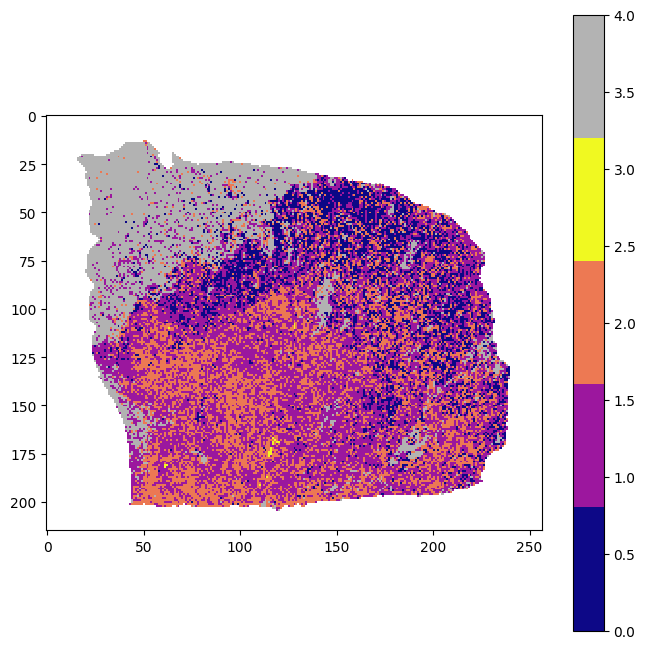

  0%|          | 0/65 [00:00<?, ?it/s]

  3%|▎         | 2/65 [00:00<00:15,  4.12it/s]

  5%|▍         | 3/65 [00:01<00:37,  1.66it/s]

  6%|▌         | 4/65 [00:04<01:30,  1.49s/it]

  8%|▊         | 5/65 [00:08<02:21,  2.36s/it]

  9%|▉         | 6/65 [00:13<03:04,  3.12s/it]

 11%|█         | 7/65 [00:20<04:26,  4.59s/it]

 12%|█▏        | 8/65 [00:29<05:28,  5.76s/it]

 14%|█▍        | 9/65 [00:37<06:05,  6.53s/it]

 15%|█▌        | 10/65 [00:45<06:29,  7.08s/it]

 17%|█▋        | 11/65 [00:54<06:55,  7.69s/it]

 18%|█▊        | 12/65 [01:03<06:57,  7.89s/it]

 20%|██        | 13/65 [01:12<07:08,  8.23s/it]

 22%|██▏       | 14/65 [01:23<07:39,  9.01s/it]

 23%|██▎       | 15/65 [01:33<07:55,  9.51s/it]

 25%|██▍       | 16/65 [01:45<08:16, 10.14s/it]

 26%|██▌       | 17/65 [01:56<08:23, 10.48s/it]

 28%|██▊       | 18/65 [02:08<08:26, 10.77s/it]

 29%|██▉       | 19/65 [02:19<08:24, 10.96s/it]

 31%|███       | 20/65 [02:31<08:26, 11.25s/it]

 32%|███▏      | 21/65 [02:43<08:28, 11.56s/it]

 34%|███▍      | 22/65 [02:55<08:18, 11.60s/it]

 35%|███▌      | 23/65 [03:07<08:09, 11.65s/it]

 37%|███▋      | 24/65 [03:18<07:58, 11.67s/it]

 38%|███▊      | 25/65 [03:30<07:43, 11.58s/it]

 40%|████      | 26/65 [03:41<07:33, 11.64s/it]

 42%|████▏     | 27/65 [03:53<07:21, 11.61s/it]

 43%|████▎     | 28/65 [04:05<07:12, 11.70s/it]

 45%|████▍     | 29/65 [04:18<07:15, 12.10s/it]

 46%|████▌     | 30/65 [04:31<07:15, 12.46s/it]

 48%|████▊     | 31/65 [04:46<07:23, 13.04s/it]

 49%|████▉     | 32/65 [05:00<07:21, 13.37s/it]

 51%|█████     | 33/65 [05:13<07:07, 13.35s/it]

 52%|█████▏    | 34/65 [05:28<07:04, 13.69s/it]

 54%|█████▍    | 35/65 [05:41<06:48, 13.61s/it]

 55%|█████▌    | 36/65 [05:55<06:41, 13.86s/it]

 57%|█████▋    | 37/65 [06:09<06:24, 13.71s/it]

 58%|█████▊    | 38/65 [06:23<06:11, 13.78s/it]

 60%|██████    | 39/65 [06:36<05:57, 13.76s/it]

 62%|██████▏   | 40/65 [06:50<05:44, 13.77s/it]

 63%|██████▎   | 41/65 [07:03<05:23, 13.46s/it]

 65%|██████▍   | 42/65 [07:16<05:05, 13.28s/it]

 66%|██████▌   | 43/65 [07:29<04:52, 13.29s/it]

 68%|██████▊   | 44/65 [07:42<04:33, 13.04s/it]

 69%|██████▉   | 45/65 [07:54<04:16, 12.83s/it]

 71%|███████   | 46/65 [08:05<03:56, 12.42s/it]

 72%|███████▏  | 47/65 [08:17<03:41, 12.31s/it]

 74%|███████▍  | 48/65 [08:28<03:22, 11.89s/it]

 75%|███████▌  | 49/65 [08:38<02:59, 11.21s/it]

 77%|███████▋  | 50/65 [08:47<02:38, 10.58s/it]

 78%|███████▊  | 51/65 [08:56<02:18,  9.93s/it]

 80%|████████  | 52/65 [09:03<02:01,  9.33s/it]

 82%|████████▏ | 53/65 [09:10<01:41,  8.48s/it]

 83%|████████▎ | 54/65 [09:17<01:27,  7.93s/it]

 85%|████████▍ | 55/65 [09:23<01:14,  7.45s/it]

 86%|████████▌ | 56/65 [09:29<01:02,  6.91s/it]

 88%|████████▊ | 57/65 [09:34<00:52,  6.54s/it]

 89%|████████▉ | 58/65 [09:39<00:41,  5.94s/it]

 91%|█████████ | 59/65 [09:42<00:30,  5.02s/it]

 92%|█████████▏| 60/65 [09:44<00:21,  4.28s/it]

 94%|█████████▍| 61/65 [09:45<00:13,  3.25s/it]

100%|██████████| 65/65 [09:45<00:00,  9.01s/it]

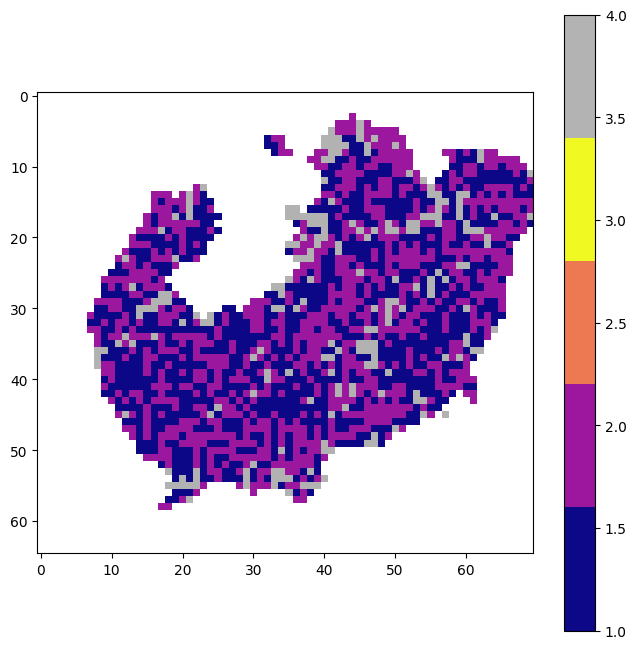

  0%|          | 0/88 [00:00<?, ?it/s]

  6%|▌         | 5/88 [00:01<00:27,  3.07it/s]

  7%|▋         | 6/88 [00:03<00:49,  1.67it/s]

  8%|▊         | 7/88 [00:06<01:45,  1.30s/it]

  9%|▉         | 8/88 [00:10<02:28,  1.86s/it]

 10%|█         | 9/88 [00:13<03:01,  2.30s/it]

 11%|█▏        | 10/88 [00:17<03:34,  2.75s/it]

 12%|█▎        | 11/88 [00:22<04:14,  3.30s/it]

 14%|█▎        | 12/88 [00:28<05:21,  4.23s/it]

 15%|█▍        | 13/88 [00:35<06:05,  4.87s/it]

 16%|█▌        | 14/88 [00:41<06:26,  5.22s/it]

 17%|█▋        | 15/88 [00:47<06:50,  5.62s/it]

 18%|█▊        | 16/88 [00:54<07:06,  5.92s/it]

 19%|█▉        | 17/88 [01:01<07:20,  6.21s/it]

 20%|██        | 18/88 [01:07<07:07,  6.11s/it]

 22%|██▏       | 19/88 [01:13<06:58,  6.06s/it]

 23%|██▎       | 20/88 [01:19<06:53,  6.08s/it]

 24%|██▍       | 21/88 [01:24<06:35,  5.90s/it]

 25%|██▌       | 22/88 [01:30<06:23,  5.81s/it]

 26%|██▌       | 23/88 [01:35<06:12,  5.73s/it]

 27%|██▋       | 24/88 [01:41<06:01,  5.66s/it]

 28%|██▊       | 25/88 [01:47<05:54,  5.62s/it]

 30%|██▉       | 26/88 [01:53<05:56,  5.75s/it]

 31%|███       | 27/88 [01:59<05:56,  5.84s/it]

 32%|███▏      | 28/88 [02:05<05:51,  5.86s/it]

 33%|███▎      | 29/88 [02:10<05:42,  5.80s/it]

 34%|███▍      | 30/88 [02:16<05:40,  5.87s/it]

 35%|███▌      | 31/88 [02:21<05:12,  5.49s/it]

 36%|███▋      | 32/88 [02:24<04:33,  4.88s/it]

 38%|███▊      | 33/88 [02:29<04:20,  4.73s/it]

 39%|███▊      | 34/88 [02:33<04:07,  4.58s/it]

 40%|███▉      | 35/88 [02:37<03:55,  4.45s/it]

 41%|████      | 36/88 [02:41<03:50,  4.43s/it]

 42%|████▏     | 37/88 [02:46<03:43,  4.37s/it]

 43%|████▎     | 38/88 [02:50<03:45,  4.52s/it]

 44%|████▍     | 39/88 [02:58<04:27,  5.45s/it]

 45%|████▌     | 40/88 [03:07<05:04,  6.34s/it]

 47%|████▋     | 41/88 [03:18<06:04,  7.76s/it]

 48%|████▊     | 42/88 [03:31<07:10,  9.35s/it]

 49%|████▉     | 43/88 [03:43<07:43, 10.30s/it]

 50%|█████     | 44/88 [03:56<08:08, 11.11s/it]

 51%|█████     | 45/88 [04:12<09:00, 12.57s/it]

 52%|█████▏    | 46/88 [04:31<10:02, 14.34s/it]

 53%|█████▎    | 47/88 [04:49<10:31, 15.41s/it]

 55%|█████▍    | 48/88 [05:07<10:56, 16.41s/it]

 56%|█████▌    | 49/88 [05:25<10:55, 16.82s/it]

 57%|█████▋    | 50/88 [05:43<10:51, 17.13s/it]

 58%|█████▊    | 51/88 [06:01<10:42, 17.36s/it]

 59%|█████▉    | 52/88 [06:18<10:26, 17.40s/it]

 60%|██████    | 53/88 [06:37<10:20, 17.74s/it]

 61%|██████▏   | 54/88 [06:56<10:16, 18.13s/it]

 62%|██████▎   | 55/88 [07:14<10:01, 18.22s/it]

 64%|██████▎   | 56/88 [07:33<09:46, 18.33s/it]

 65%|██████▍   | 57/88 [07:52<09:33, 18.50s/it]

 66%|██████▌   | 58/88 [08:11<09:17, 18.58s/it]

 67%|██████▋   | 59/88 [08:29<08:58, 18.58s/it]

 68%|██████▊   | 60/88 [08:47<08:38, 18.51s/it]

 69%|██████▉   | 61/88 [09:06<08:20, 18.54s/it]

 70%|███████   | 62/88 [09:25<08:03, 18.60s/it]

 72%|███████▏  | 63/88 [09:44<07:47, 18.70s/it]

 73%|███████▎  | 64/88 [10:02<07:26, 18.60s/it]

 74%|███████▍  | 65/88 [10:19<06:58, 18.19s/it]

 75%|███████▌  | 66/88 [10:37<06:38, 18.12s/it]

 76%|███████▌  | 67/88 [10:55<06:18, 18.05s/it]

 77%|███████▋  | 68/88 [11:12<05:51, 17.59s/it]

 78%|███████▊  | 69/88 [11:27<05:23, 17.04s/it]

 80%|███████▉  | 70/88 [11:44<05:05, 16.97s/it]

 81%|████████  | 71/88 [12:01<04:46, 16.86s/it]

 82%|████████▏ | 72/88 [12:16<04:21, 16.31s/it]

 83%|████████▎ | 73/88 [12:32<04:03, 16.24s/it]

 84%|████████▍ | 74/88 [12:48<03:46, 16.15s/it]

 85%|████████▌ | 75/88 [13:04<03:28, 16.02s/it]

 86%|████████▋ | 76/88 [13:19<03:08, 15.71s/it]

 88%|████████▊ | 77/88 [13:33<02:49, 15.38s/it]

 89%|████████▊ | 78/88 [13:46<02:27, 14.71s/it]

 90%|████████▉ | 79/88 [14:00<02:08, 14.27s/it]

 91%|█████████ | 80/88 [14:11<01:46, 13.31s/it]

 92%|█████████▏| 81/88 [14:21<01:25, 12.28s/it]

 93%|█████████▎| 82/88 [14:30<01:08, 11.41s/it]

 94%|█████████▍| 83/88 [14:38<00:51, 10.27s/it]

 95%|█████████▌| 84/88 [14:44<00:35,  8.98s/it]

 97%|█████████▋| 85/88 [14:47<00:22,  7.36s/it]

 98%|█████████▊| 86/88 [14:48<00:10,  5.42s/it]

100%|██████████| 88/88 [14:48<00:00, 10.10s/it]

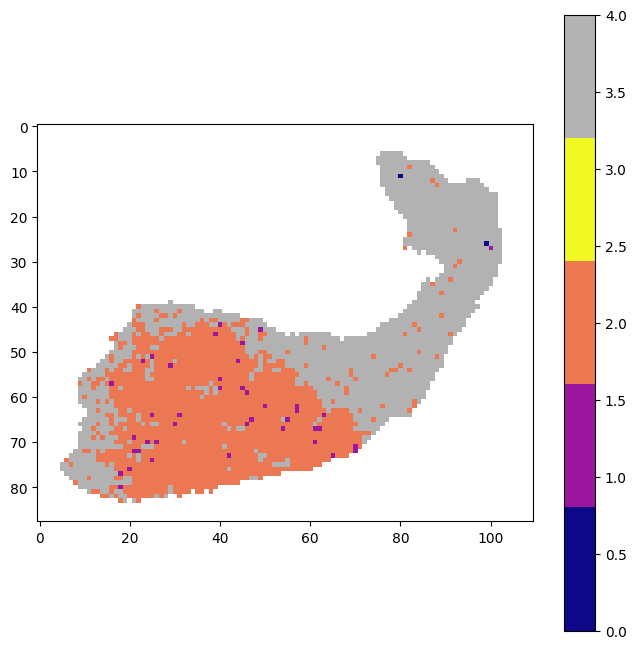

  0%|          | 0/214 [00:00<?, ?it/s]

  1%|          | 2/214 [00:00<00:47,  4.47it/s]

  1%|▏         | 3/214 [00:05<08:20,  2.37s/it]

  2%|▏         | 4/214 [00:14<16:01,  4.58s/it]

  2%|▏         | 5/214 [00:22<20:34,  5.91s/it]

  3%|▎         | 6/214 [00:31<23:31,  6.79s/it]

  3%|▎         | 7/214 [00:41<27:49,  8.07s/it]

  4%|▎         | 8/214 [00:52<30:29,  8.88s/it]

  4%|▍         | 9/214 [01:03<32:51,  9.62s/it]

  5%|▍         | 10/214 [01:16<35:53, 10.55s/it]

  5%|▌         | 11/214 [01:29<38:49, 11.48s/it]

  6%|▌         | 12/214 [01:43<40:34, 12.05s/it]

  6%|▌         | 13/214 [01:57<42:30, 12.69s/it]

  7%|▋         | 14/214 [02:12<44:28, 13.34s/it]

  7%|▋         | 15/214 [02:27<45:54, 13.84s/it]

  7%|▋         | 16/214 [02:42<46:53, 14.21s/it]

  8%|▊         | 17/214 [02:56<46:59, 14.31s/it]

  8%|▊         | 18/214 [03:11<47:22, 14.50s/it]

  9%|▉         | 19/214 [03:32<52:58, 16.30s/it]

  9%|▉         | 20/214 [03:56<1:00:31, 18.72s/it]

 10%|▉         | 21/214 [04:23<1:07:37, 21.03s/it]

 10%|█         | 22/214 [04:49<1:12:25, 22.63s/it]

 11%|█         | 23/214 [05:17<1:17:08, 24.23s/it]

 11%|█         | 24/214 [05:45<1:20:21, 25.38s/it]

 12%|█▏        | 25/214 [06:15<1:24:06, 26.70s/it]

 12%|█▏        | 26/214 [06:43<1:24:35, 27.00s/it]

 13%|█▎        | 27/214 [07:13<1:27:05, 27.94s/it]

 13%|█▎        | 28/214 [07:44<1:29:17, 28.81s/it]

 14%|█▎        | 29/214 [08:14<1:30:42, 29.42s/it]

 14%|█▍        | 30/214 [08:46<1:32:19, 30.11s/it]

 14%|█▍        | 31/214 [09:16<1:31:32, 30.01s/it]

 15%|█▍        | 32/214 [09:48<1:33:22, 30.78s/it]

 15%|█▌        | 33/214 [10:19<1:32:58, 30.82s/it]

 16%|█▌        | 34/214 [10:51<1:32:59, 30.99s/it]

 16%|█▋        | 35/214 [11:21<1:31:44, 30.75s/it]

 17%|█▋        | 36/214 [11:52<1:31:30, 30.84s/it]

 17%|█▋        | 37/214 [12:24<1:32:25, 31.33s/it]

 18%|█▊        | 38/214 [12:58<1:33:44, 31.96s/it]

 18%|█▊        | 39/214 [13:30<1:33:42, 32.13s/it]

 19%|█▊        | 40/214 [14:04<1:34:30, 32.59s/it]

 19%|█▉        | 41/214 [14:39<1:35:35, 33.15s/it]

 20%|█▉        | 42/214 [15:12<1:35:20, 33.26s/it]

 20%|██        | 43/214 [15:44<1:33:54, 32.95s/it]

 21%|██        | 44/214 [16:17<1:33:25, 32.97s/it]

 21%|██        | 45/214 [16:51<1:33:14, 33.11s/it]

 21%|██▏       | 46/214 [17:25<1:33:14, 33.30s/it]

 22%|██▏       | 47/214 [18:00<1:34:55, 34.11s/it]

 22%|██▏       | 48/214 [18:36<1:35:24, 34.48s/it]

 23%|██▎       | 49/214 [19:11<1:35:03, 34.57s/it]

 23%|██▎       | 50/214 [19:51<1:39:14, 36.31s/it]

 24%|██▍       | 51/214 [20:28<1:39:13, 36.52s/it]

 24%|██▍       | 52/214 [21:05<1:38:48, 36.59s/it]

 25%|██▍       | 53/214 [21:43<1:39:34, 37.11s/it]

 25%|██▌       | 54/214 [22:24<1:42:19, 38.37s/it]

 26%|██▌       | 55/214 [23:04<1:42:44, 38.77s/it]

 26%|██▌       | 56/214 [23:42<1:41:12, 38.43s/it]

 27%|██▋       | 57/214 [24:23<1:42:27, 39.16s/it]

 27%|██▋       | 58/214 [25:05<1:44:41, 40.26s/it]

 28%|██▊       | 59/214 [25:54<1:50:19, 42.71s/it]

 28%|██▊       | 60/214 [26:44<1:55:34, 45.03s/it]

 29%|██▊       | 61/214 [27:38<2:01:37, 47.70s/it]

 29%|██▉       | 62/214 [28:35<2:07:44, 50.43s/it]

 29%|██▉       | 63/214 [29:35<2:13:46, 53.15s/it]

 30%|██▉       | 64/214 [30:33<2:16:46, 54.71s/it]

 30%|███       | 65/214 [31:30<2:17:39, 55.43s/it]

 31%|███       | 66/214 [32:31<2:21:07, 57.21s/it]

 31%|███▏      | 67/214 [33:32<2:22:22, 58.11s/it]

 32%|███▏      | 68/214 [34:32<2:22:59, 58.76s/it]

 32%|███▏      | 69/214 [35:33<2:23:29, 59.37s/it]

 33%|███▎      | 70/214 [36:34<2:24:01, 60.01s/it]

 33%|███▎      | 71/214 [37:40<2:27:06, 61.73s/it]

 34%|███▎      | 72/214 [38:43<2:27:19, 62.25s/it]

 34%|███▍      | 73/214 [39:46<2:26:54, 62.51s/it]

 35%|███▍      | 74/214 [40:50<2:26:45, 62.90s/it]

 35%|███▌      | 75/214 [41:55<2:26:56, 63.43s/it]

 36%|███▌      | 76/214 [43:01<2:27:27, 64.11s/it]

 36%|███▌      | 77/214 [44:07<2:27:41, 64.68s/it]

 36%|███▋      | 78/214 [45:11<2:26:37, 64.69s/it]

 37%|███▋      | 79/214 [46:17<2:26:30, 65.12s/it]

 37%|███▋      | 80/214 [47:27<2:28:36, 66.54s/it]

 38%|███▊      | 81/214 [48:34<2:27:50, 66.69s/it]

 38%|███▊      | 82/214 [49:41<2:26:43, 66.69s/it]

 39%|███▉      | 83/214 [50:48<2:25:36, 66.69s/it]

 39%|███▉      | 84/214 [51:54<2:24:29, 66.69s/it]

 40%|███▉      | 85/214 [53:02<2:23:52, 66.92s/it]

 40%|████      | 86/214 [54:12<2:25:00, 67.97s/it]

 41%|████      | 87/214 [55:22<2:24:41, 68.36s/it]

 41%|████      | 88/214 [56:30<2:23:31, 68.34s/it]

 42%|████▏     | 89/214 [57:41<2:24:05, 69.17s/it]

 42%|████▏     | 90/214 [58:51<2:23:30, 69.44s/it]

 43%|████▎     | 91/214 [1:00:01<2:22:49, 69.67s/it]

 43%|████▎     | 92/214 [1:01:11<2:21:54, 69.79s/it]

 43%|████▎     | 93/214 [1:02:21<2:20:43, 69.78s/it]

 44%|████▍     | 94/214 [1:03:34<2:21:21, 70.68s/it]

 44%|████▍     | 95/214 [1:04:43<2:19:17, 70.23s/it]

 45%|████▍     | 96/214 [1:05:54<2:18:39, 70.50s/it]

 45%|████▌     | 97/214 [1:07:05<2:17:38, 70.58s/it]

 46%|████▌     | 98/214 [1:08:20<2:19:02, 71.91s/it]

 46%|████▋     | 99/214 [1:09:31<2:17:17, 71.63s/it]

 47%|████▋     | 100/214 [1:10:44<2:16:44, 71.97s/it]

 47%|████▋     | 101/214 [1:11:55<2:15:10, 71.77s/it]

 48%|████▊     | 102/214 [1:13:07<2:13:57, 71.76s/it]

 48%|████▊     | 103/214 [1:14:18<2:12:28, 71.61s/it]

 49%|████▊     | 104/214 [1:15:29<2:10:45, 71.32s/it]

 49%|████▉     | 105/214 [1:16:43<2:11:15, 72.25s/it]

 50%|████▉     | 106/214 [1:17:55<2:09:42, 72.06s/it]

 50%|█████     | 107/214 [1:19:09<2:09:33, 72.65s/it]

 50%|█████     | 108/214 [1:20:19<2:07:09, 71.97s/it]

 51%|█████     | 109/214 [1:21:31<2:05:46, 71.87s/it]

 51%|█████▏    | 110/214 [1:22:39<2:02:55, 70.91s/it]

 52%|█████▏    | 111/214 [1:23:49<2:01:11, 70.60s/it]

 52%|█████▏    | 112/214 [1:24:59<1:59:26, 70.26s/it]

 53%|█████▎    | 113/214 [1:26:08<1:57:45, 69.96s/it]

 53%|█████▎    | 114/214 [1:27:15<1:55:06, 69.06s/it]

 54%|█████▎    | 115/214 [1:28:20<1:52:08, 67.97s/it]

 54%|█████▍    | 116/214 [1:29:26<1:49:54, 67.29s/it]

 55%|█████▍    | 117/214 [1:30:34<1:49:16, 67.59s/it]

 55%|█████▌    | 118/214 [1:31:44<1:49:17, 68.30s/it]

 56%|█████▌    | 119/214 [1:32:51<1:47:11, 67.70s/it]

 56%|█████▌    | 120/214 [1:33:59<1:46:29, 67.98s/it]

 57%|█████▋    | 121/214 [1:35:07<1:45:10, 67.85s/it]

 57%|█████▋    | 122/214 [1:36:14<1:43:34, 67.55s/it]

 57%|█████▋    | 123/214 [1:37:22<1:42:59, 67.91s/it]

 58%|█████▊    | 124/214 [1:38:32<1:42:23, 68.26s/it]

 58%|█████▊    | 125/214 [1:39:42<1:42:13, 68.92s/it]

 59%|█████▉    | 126/214 [1:40:52<1:41:40, 69.32s/it]

 59%|█████▉    | 127/214 [1:42:02<1:40:29, 69.30s/it]

 60%|█████▉    | 128/214 [1:43:12<1:40:03, 69.80s/it]

 60%|██████    | 129/214 [1:44:21<1:38:21, 69.43s/it]

 61%|██████    | 130/214 [1:45:30<1:36:52, 69.19s/it]

 61%|██████    | 131/214 [1:46:37<1:34:59, 68.67s/it]

 62%|██████▏   | 132/214 [1:47:45<1:33:23, 68.33s/it]

 62%|██████▏   | 133/214 [1:48:50<1:31:04, 67.46s/it]

 63%|██████▎   | 134/214 [1:49:56<1:29:23, 67.04s/it]

 63%|██████▎   | 135/214 [1:51:02<1:27:38, 66.56s/it]

 64%|██████▎   | 136/214 [1:52:10<1:27:26, 67.26s/it]

 64%|██████▍   | 137/214 [1:53:16<1:25:49, 66.88s/it]

 64%|██████▍   | 138/214 [1:54:25<1:25:11, 67.26s/it]

 65%|██████▍   | 139/214 [1:55:32<1:23:56, 67.15s/it]

 65%|██████▌   | 140/214 [1:56:36<1:21:53, 66.40s/it]

 66%|██████▌   | 141/214 [1:57:43<1:21:00, 66.58s/it]

 66%|██████▋   | 142/214 [1:58:47<1:18:57, 65.80s/it]

 67%|██████▋   | 143/214 [1:59:53<1:17:52, 65.80s/it]

 67%|██████▋   | 144/214 [2:00:57<1:16:18, 65.41s/it]

 68%|██████▊   | 145/214 [2:01:57<1:13:03, 63.53s/it]

 68%|██████▊   | 146/214 [2:03:01<1:12:22, 63.85s/it]

 69%|██████▊   | 147/214 [2:04:01<1:10:03, 62.74s/it]

 69%|██████▉   | 148/214 [2:05:04<1:08:56, 62.68s/it]

 70%|██████▉   | 149/214 [2:06:06<1:07:41, 62.48s/it]

 70%|███████   | 150/214 [2:07:07<1:06:14, 62.10s/it]

 71%|███████   | 151/214 [2:08:12<1:06:14, 63.08s/it]

 71%|███████   | 152/214 [2:09:17<1:05:35, 63.48s/it]

 71%|███████▏  | 153/214 [2:10:20<1:04:28, 63.42s/it]

 72%|███████▏  | 154/214 [2:11:21<1:02:41, 62.69s/it]

 72%|███████▏  | 155/214 [2:12:22<1:01:02, 62.07s/it]

 73%|███████▎  | 156/214 [2:13:24<1:00:04, 62.15s/it]

 73%|███████▎  | 157/214 [2:14:27<59:12, 62.32s/it]  

 74%|███████▍  | 158/214 [2:15:31<58:32, 62.72s/it]

 74%|███████▍  | 159/214 [2:16:33<57:18, 62.52s/it]

 75%|███████▍  | 160/214 [2:17:37<56:51, 63.18s/it]

 75%|███████▌  | 161/214 [2:18:41<55:49, 63.19s/it]

 76%|███████▌  | 162/214 [2:19:44<54:55, 63.38s/it]

 76%|███████▌  | 163/214 [2:20:45<53:11, 62.58s/it]

 77%|███████▋  | 164/214 [2:21:49<52:30, 63.01s/it]

 77%|███████▋  | 165/214 [2:22:52<51:20, 62.87s/it]

 78%|███████▊  | 166/214 [2:23:56<50:35, 63.24s/it]

 78%|███████▊  | 167/214 [2:24:55<48:35, 62.04s/it]

 79%|███████▊  | 168/214 [2:25:53<46:38, 60.84s/it]

 79%|███████▉  | 169/214 [2:26:48<44:20, 59.11s/it]

 79%|███████▉  | 170/214 [2:27:39<41:38, 56.77s/it]

 80%|███████▉  | 171/214 [2:28:28<39:01, 54.45s/it]

 80%|████████  | 172/214 [2:29:11<35:38, 50.90s/it]

 81%|████████  | 173/214 [2:29:50<32:15, 47.22s/it]

 81%|████████▏ | 174/214 [2:30:20<28:12, 42.31s/it]

 82%|████████▏ | 175/214 [2:30:47<24:25, 37.59s/it]

 82%|████████▏ | 176/214 [2:31:12<21:28, 33.92s/it]

 83%|████████▎ | 177/214 [2:31:35<18:44, 30.38s/it]

 83%|████████▎ | 178/214 [2:31:55<16:27, 27.42s/it]

 84%|████████▎ | 179/214 [2:32:13<14:18, 24.52s/it]

 84%|████████▍ | 180/214 [2:32:30<12:35, 22.22s/it]

 85%|████████▍ | 181/214 [2:32:43<10:49, 19.69s/it]

 85%|████████▌ | 182/214 [2:32:56<09:22, 17.59s/it]

 86%|████████▌ | 183/214 [2:33:08<08:12, 15.87s/it]

 86%|████████▌ | 184/214 [2:33:20<07:24, 14.81s/it]

 86%|████████▋ | 185/214 [2:33:32<06:41, 13.85s/it]

 87%|████████▋ | 186/214 [2:33:43<06:03, 12.98s/it]

 87%|████████▋ | 187/214 [2:33:54<05:37, 12.50s/it]

 88%|████████▊ | 188/214 [2:34:05<05:12, 12.02s/it]

 88%|████████▊ | 189/214 [2:34:17<04:57, 11.89s/it]

 89%|████████▉ | 190/214 [2:34:26<04:27, 11.13s/it]

 89%|████████▉ | 191/214 [2:34:35<04:01, 10.48s/it]

 90%|████████▉ | 192/214 [2:34:45<03:44, 10.22s/it]

 90%|█████████ | 193/214 [2:34:53<03:21,  9.59s/it]

 91%|█████████ | 194/214 [2:35:01<03:03,  9.19s/it]

 91%|█████████ | 195/214 [2:35:07<02:35,  8.20s/it]

 92%|█████████▏| 196/214 [2:35:12<02:13,  7.39s/it]

 92%|█████████▏| 197/214 [2:35:15<01:40,  5.94s/it]

 93%|█████████▎| 198/214 [2:35:16<01:13,  4.57s/it]

100%|██████████| 214/214 [2:35:16<00:00, 43.54s/it]

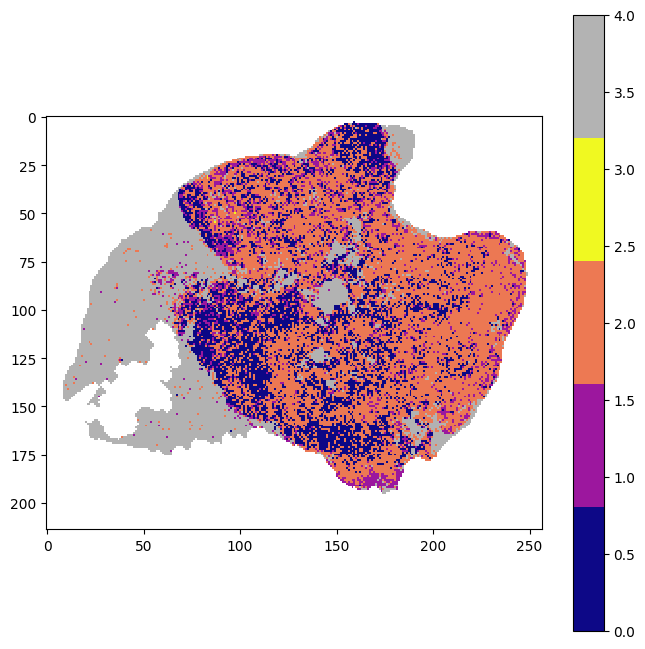

  0%|          | 0/180 [00:00<?, ?it/s]

  4%|▍         | 7/180 [00:02<01:11,  2.43it/s]

  4%|▍         | 8/180 [00:09<03:58,  1.39s/it]

  5%|▌         | 9/180 [00:18<08:17,  2.91s/it]

  6%|▌         | 10/180 [00:28<12:36,  4.45s/it]

  6%|▌         | 11/180 [00:38<16:22,  5.81s/it]

  7%|▋         | 12/180 [00:49<20:18,  7.26s/it]

  7%|▋         | 13/180 [01:02<24:00,  8.63s/it]

  8%|▊         | 14/180 [01:15<27:13,  9.84s/it]

  8%|▊         | 15/180 [01:29<30:18, 11.02s/it]

  9%|▉         | 16/180 [01:44<33:10, 12.14s/it]

  9%|▉         | 17/180 [02:00<36:14, 13.34s/it]

 10%|█         | 18/180 [02:17<38:37, 14.30s/it]

 11%|█         | 19/180 [02:37<42:43, 15.92s/it]

 11%|█         | 20/180 [02:57<46:10, 17.31s/it]

 12%|█▏        | 21/180 [03:18<48:54, 18.45s/it]

 12%|█▏        | 22/180 [03:41<51:48, 19.67s/it]

 13%|█▎        | 23/180 [04:04<54:17, 20.75s/it]

 13%|█▎        | 24/180 [04:29<57:12, 22.00s/it]

 14%|█▍        | 25/180 [04:55<1:00:01, 23.23s/it]

 14%|█▍        | 26/180 [05:22<1:02:34, 24.38s/it]

 15%|█▌        | 27/180 [05:49<1:03:48, 25.02s/it]

 16%|█▌        | 28/180 [06:18<1:06:33, 26.27s/it]

 16%|█▌        | 29/180 [06:46<1:07:23, 26.78s/it]

 17%|█▋        | 30/180 [07:15<1:08:53, 27.56s/it]

 17%|█▋        | 31/180 [07:45<1:10:02, 28.21s/it]

 18%|█▊        | 32/180 [08:14<1:10:12, 28.46s/it]

 18%|█▊        | 33/180 [08:42<1:09:20, 28.30s/it]

 19%|█▉        | 34/180 [09:10<1:08:47, 28.27s/it]

 19%|█▉        | 35/180 [09:38<1:08:10, 28.21s/it]

 20%|██        | 36/180 [10:07<1:07:55, 28.30s/it]

 21%|██        | 37/180 [10:37<1:09:06, 28.99s/it]

 21%|██        | 38/180 [11:06<1:08:40, 29.02s/it]

 22%|██▏       | 39/180 [11:38<1:09:43, 29.67s/it]

 22%|██▏       | 40/180 [12:08<1:09:59, 30.00s/it]

 23%|██▎       | 41/180 [12:39<1:09:47, 30.12s/it]

 23%|██▎       | 42/180 [13:08<1:08:41, 29.87s/it]

 24%|██▍       | 43/180 [13:37<1:07:53, 29.73s/it]

 24%|██▍       | 44/180 [14:08<1:08:12, 30.09s/it]

 25%|██▌       | 45/180 [14:39<1:08:16, 30.35s/it]

 26%|██▌       | 46/180 [15:09<1:07:29, 30.22s/it]

 26%|██▌       | 47/180 [15:42<1:08:26, 30.88s/it]

 27%|██▋       | 48/180 [16:13<1:08:15, 31.02s/it]

 27%|██▋       | 49/180 [16:44<1:07:30, 30.92s/it]

 28%|██▊       | 50/180 [17:15<1:07:11, 31.01s/it]

 28%|██▊       | 51/180 [17:48<1:08:05, 31.67s/it]

 29%|██▉       | 52/180 [18:20<1:07:57, 31.86s/it]

 29%|██▉       | 53/180 [18:54<1:08:32, 32.38s/it]

 30%|███       | 54/180 [19:29<1:09:21, 33.03s/it]

 31%|███       | 55/180 [20:02<1:08:44, 33.00s/it]

 31%|███       | 56/180 [20:36<1:09:23, 33.57s/it]

 32%|███▏      | 57/180 [21:10<1:09:05, 33.70s/it]

 32%|███▏      | 58/180 [21:45<1:08:51, 33.86s/it]

 33%|███▎      | 59/180 [22:21<1:09:39, 34.54s/it]

 33%|███▎      | 60/180 [22:59<1:11:06, 35.56s/it]

 34%|███▍      | 61/180 [23:36<1:11:31, 36.07s/it]

 34%|███▍      | 62/180 [24:15<1:12:49, 37.03s/it]

 35%|███▌      | 63/180 [24:56<1:14:18, 38.11s/it]

 36%|███▌      | 64/180 [25:38<1:15:48, 39.21s/it]

 36%|███▌      | 65/180 [26:23<1:18:37, 41.02s/it]

 37%|███▋      | 66/180 [27:06<1:19:13, 41.70s/it]

 37%|███▋      | 67/180 [27:48<1:18:33, 41.71s/it]

 38%|███▊      | 68/180 [28:34<1:20:22, 43.06s/it]

 38%|███▊      | 69/180 [29:18<1:20:22, 43.44s/it]

 39%|███▉      | 70/180 [30:04<1:20:50, 44.09s/it]

 39%|███▉      | 71/180 [30:49<1:20:29, 44.30s/it]

 40%|████      | 72/180 [31:35<1:20:51, 44.92s/it]

 41%|████      | 73/180 [32:23<1:21:32, 45.72s/it]

 41%|████      | 74/180 [33:11<1:22:09, 46.50s/it]

 42%|████▏     | 75/180 [33:59<1:22:10, 46.96s/it]

 42%|████▏     | 76/180 [34:47<1:21:41, 47.13s/it]

 43%|████▎     | 77/180 [35:36<1:22:03, 47.80s/it]

 43%|████▎     | 78/180 [36:24<1:21:12, 47.77s/it]

 44%|████▍     | 79/180 [37:11<1:20:01, 47.54s/it]

 44%|████▍     | 80/180 [38:00<1:20:08, 48.09s/it]

 45%|████▌     | 81/180 [38:47<1:18:55, 47.83s/it]

 46%|████▌     | 82/180 [39:35<1:18:05, 47.81s/it]

 46%|████▌     | 83/180 [40:21<1:16:17, 47.19s/it]

 47%|████▋     | 84/180 [41:09<1:16:10, 47.61s/it]

 47%|████▋     | 85/180 [41:59<1:16:11, 48.12s/it]

 48%|████▊     | 86/180 [42:48<1:16:02, 48.54s/it]

 48%|████▊     | 87/180 [43:35<1:14:31, 48.08s/it]

 49%|████▉     | 88/180 [44:22<1:13:09, 47.72s/it]

 49%|████▉     | 89/180 [45:09<1:11:58, 47.45s/it]

 50%|█████     | 90/180 [45:56<1:11:02, 47.37s/it]

 51%|█████     | 91/180 [46:44<1:10:23, 47.45s/it]

 51%|█████     | 92/180 [47:31<1:09:21, 47.29s/it]

 52%|█████▏    | 93/180 [48:19<1:08:49, 47.46s/it]

 52%|█████▏    | 94/180 [49:06<1:07:57, 47.41s/it]

 53%|█████▎    | 95/180 [49:52<1:06:24, 46.88s/it]

 53%|█████▎    | 96/180 [50:37<1:05:14, 46.60s/it]

 54%|█████▍    | 97/180 [51:22<1:03:38, 46.00s/it]

 54%|█████▍    | 98/180 [52:06<1:02:09, 45.48s/it]

 55%|█████▌    | 99/180 [52:49<1:00:22, 44.73s/it]

 56%|█████▌    | 100/180 [53:34<59:40, 44.76s/it] 

 56%|█████▌    | 101/180 [54:19<59:07, 44.91s/it]

 57%|█████▋    | 102/180 [55:06<59:00, 45.39s/it]

 57%|█████▋    | 103/180 [55:50<57:48, 45.04s/it]

 58%|█████▊    | 104/180 [56:37<57:54, 45.72s/it]

 58%|█████▊    | 105/180 [57:21<56:18, 45.04s/it]

 59%|█████▉    | 106/180 [58:05<55:16, 44.81s/it]

 59%|█████▉    | 107/180 [58:48<53:41, 44.13s/it]

 60%|██████    | 108/180 [59:32<52:54, 44.09s/it]

 61%|██████    | 109/180 [1:00:15<51:47, 43.76s/it]

 61%|██████    | 110/180 [1:00:58<50:58, 43.69s/it]

 62%|██████▏   | 111/180 [1:01:41<50:05, 43.55s/it]

 62%|██████▏   | 112/180 [1:02:24<49:01, 43.25s/it]

 63%|██████▎   | 113/180 [1:03:05<47:23, 42.43s/it]

 63%|██████▎   | 114/180 [1:03:48<47:04, 42.79s/it]

 64%|██████▍   | 115/180 [1:04:29<45:37, 42.12s/it]

 64%|██████▍   | 116/180 [1:05:10<44:36, 41.82s/it]

 65%|██████▌   | 117/180 [1:05:49<43:13, 41.16s/it]

 66%|██████▌   | 118/180 [1:06:27<41:19, 39.98s/it]

 66%|██████▌   | 119/180 [1:07:02<39:20, 38.70s/it]

 67%|██████▋   | 120/180 [1:07:39<38:00, 38.01s/it]

 67%|██████▋   | 121/180 [1:08:14<36:28, 37.10s/it]

 68%|██████▊   | 122/180 [1:08:49<35:24, 36.62s/it]

 68%|██████▊   | 123/180 [1:09:26<34:45, 36.58s/it]

 69%|██████▉   | 124/180 [1:10:00<33:35, 36.00s/it]

 69%|██████▉   | 125/180 [1:10:34<32:13, 35.16s/it]

 70%|███████   | 126/180 [1:11:05<30:41, 34.09s/it]

 71%|███████   | 127/180 [1:11:38<29:53, 33.84s/it]

 71%|███████   | 128/180 [1:12:11<28:59, 33.45s/it]

 72%|███████▏  | 129/180 [1:12:43<28:02, 32.99s/it]

 72%|███████▏  | 130/180 [1:13:16<27:31, 33.03s/it]

 73%|███████▎  | 131/180 [1:13:47<26:26, 32.38s/it]

 73%|███████▎  | 132/180 [1:14:18<25:28, 31.85s/it]

 74%|███████▍  | 133/180 [1:14:50<25:01, 31.94s/it]

 74%|███████▍  | 134/180 [1:15:20<24:03, 31.39s/it]

 75%|███████▌  | 135/180 [1:15:50<23:19, 31.10s/it]

 76%|███████▌  | 136/180 [1:16:19<22:23, 30.54s/it]

 76%|███████▌  | 137/180 [1:16:49<21:34, 30.11s/it]

 77%|███████▋  | 138/180 [1:17:16<20:34, 29.40s/it]

 77%|███████▋  | 139/180 [1:17:44<19:49, 29.02s/it]

 78%|███████▊  | 140/180 [1:18:10<18:44, 28.10s/it]

 78%|███████▊  | 141/180 [1:18:38<18:05, 27.84s/it]

 79%|███████▉  | 142/180 [1:19:03<17:13, 27.19s/it]

 79%|███████▉  | 143/180 [1:19:29<16:25, 26.65s/it]

 80%|████████  | 144/180 [1:19:51<15:15, 25.44s/it]

 81%|████████  | 145/180 [1:20:12<14:03, 24.09s/it]

 81%|████████  | 146/180 [1:20:34<13:19, 23.51s/it]

 82%|████████▏ | 147/180 [1:20:54<12:21, 22.48s/it]

 82%|████████▏ | 148/180 [1:21:15<11:41, 21.92s/it]

 83%|████████▎ | 149/180 [1:21:34<10:55, 21.14s/it]

 83%|████████▎ | 150/180 [1:21:55<10:24, 20.83s/it]

 84%|████████▍ | 151/180 [1:22:15<09:57, 20.59s/it]

 84%|████████▍ | 152/180 [1:22:34<09:28, 20.29s/it]

 85%|████████▌ | 153/180 [1:22:53<08:54, 19.78s/it]

 86%|████████▌ | 154/180 [1:23:11<08:24, 19.42s/it]

 86%|████████▌ | 155/180 [1:23:29<07:51, 18.87s/it]

 87%|████████▋ | 156/180 [1:23:46<07:17, 18.24s/it]

 87%|████████▋ | 157/180 [1:24:03<06:50, 17.83s/it]

 88%|████████▊ | 158/180 [1:24:18<06:18, 17.19s/it]

 88%|████████▊ | 159/180 [1:24:34<05:52, 16.76s/it]

 89%|████████▉ | 160/180 [1:24:48<05:21, 16.08s/it]

 89%|████████▉ | 161/180 [1:25:03<04:56, 15.63s/it]

 90%|█████████ | 162/180 [1:25:18<04:36, 15.35s/it]

 91%|█████████ | 163/180 [1:25:34<04:23, 15.48s/it]

 91%|█████████ | 164/180 [1:25:47<03:58, 14.89s/it]

 92%|█████████▏| 165/180 [1:26:00<03:36, 14.45s/it]

 92%|█████████▏| 166/180 [1:26:11<03:05, 13.22s/it]

 93%|█████████▎| 167/180 [1:26:21<02:38, 12.16s/it]

 93%|█████████▎| 168/180 [1:26:29<02:14, 11.19s/it]

 94%|█████████▍| 169/180 [1:26:36<01:48,  9.85s/it]

 94%|█████████▍| 170/180 [1:26:42<01:26,  8.69s/it]

 95%|█████████▌| 171/180 [1:26:47<01:08,  7.67s/it]

 96%|█████████▌| 172/180 [1:26:52<00:54,  6.80s/it]

 96%|█████████▌| 173/180 [1:26:57<00:43,  6.22s/it]

 97%|█████████▋| 174/180 [1:26:59<00:29,  4.86s/it]

100%|██████████| 180/180 [1:26:59<00:00, 29.00s/it]

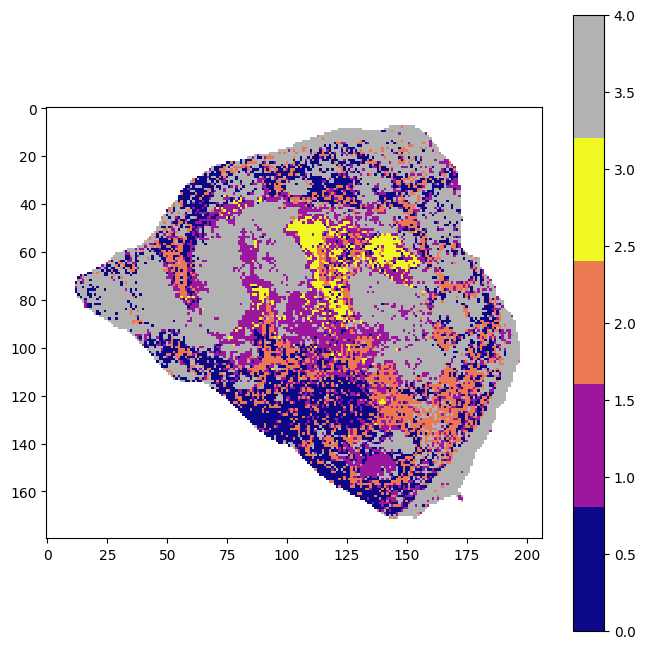

  0%|          | 0/124 [00:00<?, ?it/s]

  2%|▏         | 2/124 [00:00<00:26,  4.53it/s]

  2%|▏         | 3/124 [00:01<01:20,  1.50it/s]

  3%|▎         | 4/124 [00:03<02:17,  1.14s/it]

  4%|▍         | 5/124 [00:06<03:11,  1.61s/it]

  5%|▍         | 6/124 [00:11<05:22,  2.73s/it]

  6%|▌         | 7/124 [00:16<06:57,  3.57s/it]

  6%|▋         | 8/124 [00:21<07:57,  4.12s/it]

  7%|▋         | 9/124 [00:27<08:45,  4.57s/it]

  8%|▊         | 10/124 [00:32<09:01,  4.75s/it]

  9%|▉         | 11/124 [00:38<09:43,  5.16s/it]

 10%|▉         | 12/124 [00:44<09:55,  5.31s/it]

 10%|█         | 13/124 [00:50<10:20,  5.59s/it]

 11%|█▏        | 14/124 [00:56<10:36,  5.78s/it]

 12%|█▏        | 15/124 [01:03<10:55,  6.01s/it]

 13%|█▎        | 16/124 [01:10<11:17,  6.28s/it]

 14%|█▎        | 17/124 [01:17<11:31,  6.46s/it]

 15%|█▍        | 18/124 [01:24<11:52,  6.73s/it]

 15%|█▌        | 19/124 [01:32<12:14,  6.99s/it]

 16%|█▌        | 20/124 [01:40<12:42,  7.34s/it]

 17%|█▋        | 21/124 [01:48<12:55,  7.52s/it]

 18%|█▊        | 22/124 [01:56<12:59,  7.64s/it]

 19%|█▊        | 23/124 [02:05<13:31,  8.03s/it]

 19%|█▉        | 24/124 [02:14<14:06,  8.46s/it]

 20%|██        | 25/124 [02:23<14:16,  8.65s/it]

 21%|██        | 26/124 [02:32<14:17,  8.75s/it]

 22%|██▏       | 27/124 [02:42<14:39,  9.07s/it]

 23%|██▎       | 28/124 [02:51<14:45,  9.23s/it]

 23%|██▎       | 29/124 [03:01<14:40,  9.27s/it]

 24%|██▍       | 30/124 [03:11<14:45,  9.42s/it]

 25%|██▌       | 31/124 [03:20<14:29,  9.35s/it]

 26%|██▌       | 32/124 [03:29<14:23,  9.39s/it]

 27%|██▋       | 33/124 [03:38<14:05,  9.29s/it]

 27%|██▋       | 34/124 [03:47<13:42,  9.14s/it]

 28%|██▊       | 35/124 [03:56<13:20,  8.99s/it]

 29%|██▉       | 36/124 [04:04<12:48,  8.74s/it]

 30%|██▉       | 37/124 [04:12<12:12,  8.41s/it]

 31%|███       | 38/124 [04:18<11:17,  7.88s/it]

 31%|███▏      | 39/124 [04:24<10:19,  7.29s/it]

 32%|███▏      | 40/124 [04:36<12:06,  8.65s/it]

 33%|███▎      | 41/124 [04:50<14:06, 10.20s/it]

 34%|███▍      | 42/124 [05:04<15:28, 11.33s/it]

 35%|███▍      | 43/124 [05:20<17:16, 12.80s/it]

 35%|███▌      | 44/124 [05:37<18:36, 13.96s/it]

 36%|███▋      | 45/124 [05:54<19:46, 15.01s/it]

 37%|███▋      | 46/124 [06:13<21:10, 16.29s/it]

 38%|███▊      | 47/124 [06:33<22:03, 17.19s/it]

 39%|███▊      | 48/124 [06:52<22:42, 17.93s/it]

 40%|███▉      | 49/124 [07:13<23:22, 18.70s/it]

 40%|████      | 50/124 [07:32<23:21, 18.94s/it]

 41%|████      | 51/124 [07:52<23:19, 19.17s/it]

 42%|████▏     | 52/124 [08:12<23:08, 19.28s/it]

 43%|████▎     | 53/124 [08:31<22:44, 19.22s/it]

 44%|████▎     | 54/124 [08:50<22:26, 19.23s/it]

 44%|████▍     | 55/124 [09:08<21:33, 18.75s/it]

 45%|████▌     | 56/124 [09:25<20:57, 18.50s/it]

 46%|████▌     | 57/124 [09:43<20:27, 18.32s/it]

 47%|████▋     | 58/124 [10:01<19:56, 18.13s/it]

 48%|████▊     | 59/124 [10:19<19:41, 18.17s/it]

 48%|████▊     | 60/124 [10:37<19:10, 17.97s/it]

 49%|████▉     | 61/124 [10:54<18:35, 17.70s/it]

 50%|█████     | 62/124 [11:11<18:15, 17.68s/it]

 51%|█████     | 63/124 [11:28<17:44, 17.45s/it]

 52%|█████▏    | 64/124 [11:47<17:39, 17.66s/it]

 52%|█████▏    | 65/124 [12:04<17:09, 17.45s/it]

 53%|█████▎    | 66/124 [12:22<17:15, 17.86s/it]

 54%|█████▍    | 67/124 [12:40<16:55, 17.82s/it]

 55%|█████▍    | 68/124 [12:58<16:34, 17.76s/it]

 56%|█████▌    | 69/124 [13:16<16:24, 17.90s/it]

 56%|█████▋    | 70/124 [13:33<15:59, 17.78s/it]

 57%|█████▋    | 71/124 [13:52<15:55, 18.03s/it]

 58%|█████▊    | 72/124 [14:08<15:04, 17.40s/it]

 59%|█████▉    | 73/124 [14:23<14:18, 16.84s/it]

 60%|█████▉    | 74/124 [14:40<13:51, 16.63s/it]

 60%|██████    | 75/124 [14:55<13:17, 16.27s/it]

 61%|██████▏   | 76/124 [15:10<12:47, 15.99s/it]

 62%|██████▏   | 77/124 [15:26<12:30, 15.97s/it]

 63%|██████▎   | 78/124 [15:43<12:27, 16.24s/it]

 64%|██████▎   | 79/124 [15:59<12:07, 16.16s/it]

 65%|██████▍   | 80/124 [16:16<11:54, 16.24s/it]

 65%|██████▌   | 81/124 [16:31<11:27, 15.99s/it]

 66%|██████▌   | 82/124 [16:48<11:27, 16.36s/it]

 67%|██████▋   | 83/124 [17:04<11:03, 16.18s/it]

 68%|██████▊   | 84/124 [17:21<10:51, 16.30s/it]

 69%|██████▊   | 85/124 [17:38<10:45, 16.55s/it]

 69%|██████▉   | 86/124 [17:55<10:41, 16.87s/it]

 70%|███████   | 87/124 [18:12<10:23, 16.84s/it]

 71%|███████   | 88/124 [18:29<10:08, 16.91s/it]

 72%|███████▏  | 89/124 [18:46<09:49, 16.85s/it]

 73%|███████▎  | 90/124 [19:02<09:21, 16.52s/it]

 73%|███████▎  | 91/124 [19:18<09:07, 16.59s/it]

 74%|███████▍  | 92/124 [19:34<08:46, 16.45s/it]

 75%|███████▌  | 93/124 [19:51<08:30, 16.47s/it]

 76%|███████▌  | 94/124 [20:08<08:16, 16.56s/it]

 77%|███████▋  | 95/124 [20:24<07:59, 16.53s/it]

 77%|███████▋  | 96/124 [20:39<07:24, 15.89s/it]

 78%|███████▊  | 97/124 [20:52<06:52, 15.28s/it]

 79%|███████▉  | 98/124 [21:06<06:20, 14.64s/it]

 80%|███████▉  | 99/124 [21:20<06:02, 14.49s/it]

 81%|████████  | 100/124 [21:33<05:36, 14.03s/it]

 81%|████████▏ | 101/124 [21:45<05:11, 13.53s/it]

 82%|████████▏ | 102/124 [21:56<04:40, 12.77s/it]

 83%|████████▎ | 103/124 [22:07<04:14, 12.11s/it]

 84%|████████▍ | 104/124 [22:17<03:49, 11.47s/it]

 85%|████████▍ | 105/124 [22:26<03:28, 10.99s/it]

 85%|████████▌ | 106/124 [22:36<03:11, 10.64s/it]

 86%|████████▋ | 107/124 [22:46<02:55, 10.31s/it]

 87%|████████▋ | 108/124 [22:54<02:35,  9.75s/it]

 88%|████████▊ | 109/124 [23:02<02:18,  9.25s/it]

 89%|████████▊ | 110/124 [23:11<02:06,  9.01s/it]

 90%|████████▉ | 111/124 [23:18<01:48,  8.37s/it]

 90%|█████████ | 112/124 [23:25<01:36,  8.03s/it]

 91%|█████████ | 113/124 [23:32<01:23,  7.61s/it]

 92%|█████████▏| 114/124 [23:38<01:13,  7.30s/it]

 93%|█████████▎| 115/124 [23:45<01:04,  7.12s/it]

 94%|█████████▎| 116/124 [23:49<00:50,  6.32s/it]

 94%|█████████▍| 117/124 [23:53<00:37,  5.41s/it]

 95%|█████████▌| 118/124 [23:54<00:25,  4.27s/it]

 96%|█████████▌| 119/124 [23:56<00:17,  3.41s/it]

 97%|█████████▋| 120/124 [23:57<00:10,  2.66s/it]

100%|██████████| 124/124 [23:57<00:00, 11.59s/it]

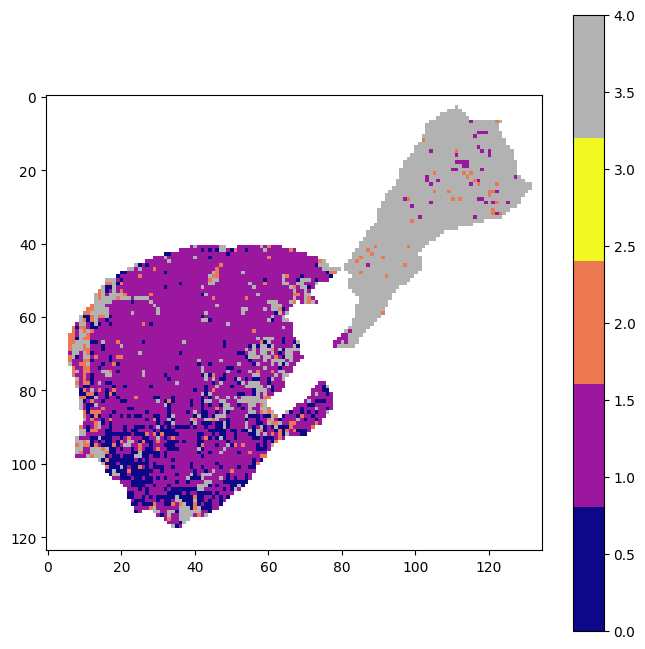

  0%|          | 0/206 [00:00<?, ?it/s]

  8%|▊         | 17/206 [00:01<00:15, 12.03it/s]

  9%|▉         | 19/206 [00:09<02:03,  1.52it/s]

 10%|▉         | 20/206 [00:16<03:54,  1.26s/it]

 10%|█         | 21/206 [00:25<06:44,  2.18s/it]

 11%|█         | 22/206 [00:36<10:32,  3.44s/it]

 11%|█         | 23/206 [00:49<15:10,  4.98s/it]

 12%|█▏        | 24/206 [01:03<20:36,  6.80s/it]

 12%|█▏        | 25/206 [01:18<26:15,  8.71s/it]

 13%|█▎        | 26/206 [01:34<31:08, 10.38s/it]

 13%|█▎        | 27/206 [01:54<38:09, 12.79s/it]

 14%|█▎        | 28/206 [02:16<45:11, 15.23s/it]

 14%|█▍        | 29/206 [02:39<51:33, 17.48s/it]

 15%|█▍        | 30/206 [03:04<56:47, 19.36s/it]

 15%|█▌        | 31/206 [03:29<1:01:17, 21.01s/it]

 16%|█▌        | 32/206 [03:57<1:07:28, 23.27s/it]

 16%|█▌        | 33/206 [04:30<1:14:31, 25.85s/it]

 17%|█▋        | 34/206 [05:04<1:21:46, 28.52s/it]

 17%|█▋        | 35/206 [05:40<1:26:54, 30.49s/it]

 17%|█▋        | 36/206 [06:16<1:31:33, 32.32s/it]

 18%|█▊        | 37/206 [06:53<1:34:35, 33.59s/it]

 18%|█▊        | 38/206 [07:33<1:39:50, 35.66s/it]

 19%|█▉        | 39/206 [08:16<1:44:57, 37.71s/it]

 19%|█▉        | 40/206 [09:01<1:50:16, 39.86s/it]

 20%|█▉        | 41/206 [09:47<1:55:07, 41.87s/it]

 20%|██        | 42/206 [10:31<1:55:56, 42.41s/it]

 21%|██        | 43/206 [11:18<1:58:51, 43.75s/it]

 21%|██▏       | 44/206 [12:08<2:03:41, 45.81s/it]

 22%|██▏       | 45/206 [12:59<2:06:43, 47.22s/it]

 22%|██▏       | 46/206 [13:49<2:07:57, 47.98s/it]

 23%|██▎       | 47/206 [14:37<2:07:31, 48.13s/it]

 23%|██▎       | 48/206 [15:27<2:07:52, 48.56s/it]

 24%|██▍       | 49/206 [16:18<2:09:29, 49.48s/it]

 24%|██▍       | 50/206 [17:10<2:10:40, 50.26s/it]

 25%|██▍       | 51/206 [18:02<2:11:06, 50.75s/it]

 25%|██▌       | 52/206 [18:53<2:10:03, 50.67s/it]

 26%|██▌       | 53/206 [19:46<2:11:17, 51.49s/it]

 26%|██▌       | 54/206 [20:44<2:15:21, 53.43s/it]

 27%|██▋       | 55/206 [21:39<2:15:39, 53.91s/it]

 27%|██▋       | 56/206 [22:36<2:17:15, 54.90s/it]

 28%|██▊       | 57/206 [23:33<2:17:53, 55.53s/it]

 28%|██▊       | 58/206 [24:30<2:17:35, 55.78s/it]

 29%|██▊       | 59/206 [25:27<2:17:48, 56.25s/it]

 29%|██▉       | 60/206 [26:26<2:18:27, 56.90s/it]

 30%|██▉       | 61/206 [27:29<2:22:34, 58.99s/it]

 30%|███       | 62/206 [28:34<2:25:14, 60.52s/it]

 31%|███       | 63/206 [29:38<2:26:48, 61.60s/it]

 31%|███       | 64/206 [30:47<2:30:58, 63.79s/it]

 32%|███▏      | 65/206 [31:53<2:31:26, 64.44s/it]

 32%|███▏      | 66/206 [32:59<2:31:35, 64.97s/it]

 33%|███▎      | 67/206 [34:07<2:32:41, 65.91s/it]

 33%|███▎      | 68/206 [35:17<2:34:12, 67.05s/it]

 33%|███▎      | 69/206 [36:27<2:35:40, 68.18s/it]

 34%|███▍      | 70/206 [37:35<2:34:26, 68.13s/it]

 34%|███▍      | 71/206 [38:42<2:32:09, 67.63s/it]

 35%|███▍      | 72/206 [39:51<2:32:18, 68.20s/it]

 35%|███▌      | 73/206 [41:00<2:31:11, 68.21s/it]

 36%|███▌      | 74/206 [42:08<2:30:16, 68.30s/it]

 36%|███▋      | 75/206 [43:19<2:30:38, 68.99s/it]

 37%|███▋      | 76/206 [44:30<2:30:51, 69.62s/it]

 37%|███▋      | 77/206 [45:40<2:29:52, 69.71s/it]

 38%|███▊      | 78/206 [46:50<2:29:08, 69.91s/it]

 38%|███▊      | 79/206 [48:01<2:28:24, 70.11s/it]

 39%|███▉      | 80/206 [49:10<2:26:57, 69.98s/it]

 39%|███▉      | 81/206 [50:19<2:25:11, 69.69s/it]

 40%|███▉      | 82/206 [51:32<2:25:56, 70.62s/it]

 40%|████      | 83/206 [52:44<2:25:35, 71.02s/it]

 41%|████      | 84/206 [53:57<2:25:35, 71.60s/it]

 41%|████▏     | 85/206 [55:10<2:25:03, 71.93s/it]

 42%|████▏     | 86/206 [56:22<2:23:55, 71.97s/it]

 42%|████▏     | 87/206 [57:35<2:23:25, 72.32s/it]

 43%|████▎     | 88/206 [58:51<2:24:23, 73.42s/it]

 43%|████▎     | 89/206 [1:00:06<2:23:58, 73.83s/it]

 44%|████▎     | 90/206 [1:01:19<2:22:11, 73.55s/it]

 44%|████▍     | 91/206 [1:02:35<2:22:19, 74.26s/it]

 45%|████▍     | 92/206 [1:03:46<2:19:39, 73.50s/it]

 45%|████▌     | 93/206 [1:05:01<2:19:17, 73.96s/it]

 46%|████▌     | 94/206 [1:06:17<2:18:52, 74.40s/it]

 46%|████▌     | 95/206 [1:07:31<2:17:23, 74.27s/it]

 47%|████▋     | 96/206 [1:08:44<2:15:24, 73.86s/it]

 47%|████▋     | 97/206 [1:09:59<2:14:57, 74.29s/it]

 48%|████▊     | 98/206 [1:11:15<2:14:29, 74.72s/it]

 48%|████▊     | 99/206 [1:12:28<2:12:33, 74.33s/it]

 49%|████▊     | 100/206 [1:13:44<2:11:55, 74.68s/it]

 49%|████▉     | 101/206 [1:14:57<2:10:05, 74.34s/it]

 50%|████▉     | 102/206 [1:16:13<2:09:31, 74.72s/it]

 50%|█████     | 103/206 [1:17:28<2:08:21, 74.77s/it]

 50%|█████     | 104/206 [1:18:43<2:07:17, 74.88s/it]

 51%|█████     | 105/206 [1:19:57<2:05:58, 74.83s/it]

 51%|█████▏    | 106/206 [1:21:11<2:03:57, 74.37s/it]

 52%|█████▏    | 107/206 [1:22:26<2:02:55, 74.50s/it]

 52%|█████▏    | 108/206 [1:23:40<2:01:36, 74.45s/it]

 53%|█████▎    | 109/206 [1:24:56<2:01:16, 75.01s/it]

 53%|█████▎    | 110/206 [1:26:11<1:59:58, 74.98s/it]

 54%|█████▍    | 111/206 [1:27:25<1:58:08, 74.61s/it]

 54%|█████▍    | 112/206 [1:28:41<1:57:30, 75.01s/it]

 55%|█████▍    | 113/206 [1:29:54<1:55:39, 74.62s/it]

 55%|█████▌    | 114/206 [1:31:07<1:53:19, 73.90s/it]

 56%|█████▌    | 115/206 [1:32:19<1:51:18, 73.39s/it]

 56%|█████▋    | 116/206 [1:33:32<1:50:01, 73.35s/it]

 57%|█████▋    | 117/206 [1:34:45<1:48:41, 73.27s/it]

 57%|█████▋    | 118/206 [1:35:59<1:47:38, 73.39s/it]

 58%|█████▊    | 119/206 [1:37:12<1:46:06, 73.17s/it]

 58%|█████▊    | 120/206 [1:38:23<1:44:08, 72.66s/it]

 59%|█████▊    | 121/206 [1:39:35<1:42:34, 72.40s/it]

 59%|█████▉    | 122/206 [1:40:48<1:41:38, 72.60s/it]

 60%|█████▉    | 123/206 [1:41:59<1:39:56, 72.25s/it]

 60%|██████    | 124/206 [1:43:12<1:38:42, 72.23s/it]

 61%|██████    | 125/206 [1:44:23<1:37:05, 71.92s/it]

 61%|██████    | 126/206 [1:45:34<1:35:42, 71.79s/it]

 62%|██████▏   | 127/206 [1:46:45<1:34:07, 71.49s/it]

 62%|██████▏   | 128/206 [1:47:53<1:31:42, 70.55s/it]

 63%|██████▎   | 129/206 [1:48:59<1:28:46, 69.17s/it]

 63%|██████▎   | 130/206 [1:50:07<1:27:08, 68.80s/it]

 64%|██████▎   | 131/206 [1:51:16<1:25:53, 68.72s/it]

 64%|██████▍   | 132/206 [1:52:22<1:23:48, 67.96s/it]

 65%|██████▍   | 133/206 [1:53:28<1:22:05, 67.47s/it]

 65%|██████▌   | 134/206 [1:54:33<1:19:54, 66.59s/it]

 66%|██████▌   | 135/206 [1:55:41<1:19:17, 67.01s/it]

 66%|██████▌   | 136/206 [1:56:47<1:17:55, 66.80s/it]

 67%|██████▋   | 137/206 [1:57:52<1:16:11, 66.26s/it]

 67%|██████▋   | 138/206 [1:58:57<1:14:40, 65.90s/it]

 67%|██████▋   | 139/206 [2:00:05<1:14:12, 66.45s/it]

 68%|██████▊   | 140/206 [2:01:15<1:14:16, 67.53s/it]

 68%|██████▊   | 141/206 [2:02:21<1:12:45, 67.16s/it]

 69%|██████▉   | 142/206 [2:03:25<1:10:24, 66.01s/it]

 69%|██████▉   | 143/206 [2:04:28<1:08:25, 65.17s/it]

 70%|██████▉   | 144/206 [2:05:32<1:07:04, 64.92s/it]

 70%|███████   | 145/206 [2:06:34<1:05:12, 64.14s/it]

 71%|███████   | 146/206 [2:07:38<1:03:57, 63.96s/it]

 71%|███████▏  | 147/206 [2:08:40<1:02:23, 63.45s/it]

 72%|███████▏  | 148/206 [2:09:44<1:01:17, 63.41s/it]

 72%|███████▏  | 149/206 [2:10:47<1:00:08, 63.30s/it]

 73%|███████▎  | 150/206 [2:11:47<58:09, 62.31s/it]  

 73%|███████▎  | 151/206 [2:12:47<56:27, 61.60s/it]

 74%|███████▍  | 152/206 [2:13:45<54:34, 60.63s/it]

 74%|███████▍  | 153/206 [2:14:44<53:04, 60.09s/it]

 75%|███████▍  | 154/206 [2:15:40<51:03, 58.92s/it]

 75%|███████▌  | 155/206 [2:16:38<49:45, 58.54s/it]

 76%|███████▌  | 156/206 [2:17:33<48:05, 57.71s/it]

 76%|███████▌  | 157/206 [2:18:30<46:48, 57.31s/it]

 77%|███████▋  | 158/206 [2:19:22<44:43, 55.91s/it]

 77%|███████▋  | 159/206 [2:20:13<42:33, 54.33s/it]

 78%|███████▊  | 160/206 [2:21:04<40:56, 53.41s/it]

 78%|███████▊  | 161/206 [2:21:55<39:33, 52.74s/it]

 79%|███████▊  | 162/206 [2:22:45<38:00, 51.82s/it]

 79%|███████▉  | 163/206 [2:23:32<36:01, 50.27s/it]

 80%|███████▉  | 164/206 [2:24:21<34:57, 49.94s/it]

 80%|████████  | 165/206 [2:25:06<33:06, 48.45s/it]

 81%|████████  | 166/206 [2:25:53<32:00, 48.01s/it]

 81%|████████  | 167/206 [2:26:38<30:41, 47.21s/it]

 82%|████████▏ | 168/206 [2:27:27<30:10, 47.65s/it]

 82%|████████▏ | 169/206 [2:28:15<29:27, 47.77s/it]

 83%|████████▎ | 170/206 [2:29:00<28:07, 46.88s/it]

 83%|████████▎ | 171/206 [2:29:39<26:03, 44.68s/it]

 83%|████████▎ | 172/206 [2:30:20<24:35, 43.41s/it]

 84%|████████▍ | 173/206 [2:30:58<23:00, 41.83s/it]

 84%|████████▍ | 174/206 [2:31:36<21:46, 40.82s/it]

 85%|████████▍ | 175/206 [2:32:15<20:44, 40.14s/it]

 85%|████████▌ | 176/206 [2:32:52<19:39, 39.31s/it]

 86%|████████▌ | 177/206 [2:33:35<19:29, 40.32s/it]

 86%|████████▋ | 178/206 [2:34:11<18:13, 39.04s/it]

 87%|████████▋ | 179/206 [2:34:46<16:57, 37.69s/it]

 87%|████████▋ | 180/206 [2:35:22<16:12, 37.40s/it]

 88%|████████▊ | 181/206 [2:35:56<15:08, 36.32s/it]

 88%|████████▊ | 182/206 [2:36:30<14:16, 35.67s/it]

 89%|████████▉ | 183/206 [2:37:02<13:14, 34.53s/it]

 89%|████████▉ | 184/206 [2:37:34<12:23, 33.79s/it]

 90%|████████▉ | 185/206 [2:38:08<11:49, 33.78s/it]

 90%|█████████ | 186/206 [2:38:40<11:07, 33.36s/it]

 91%|█████████ | 187/206 [2:39:13<10:28, 33.09s/it]

 91%|█████████▏| 188/206 [2:39:44<09:44, 32.45s/it]

 92%|█████████▏| 189/206 [2:40:15<09:03, 31.96s/it]

 92%|█████████▏| 190/206 [2:40:45<08:26, 31.63s/it]

 93%|█████████▎| 191/206 [2:41:16<07:51, 31.42s/it]

 93%|█████████▎| 192/206 [2:41:47<07:17, 31.25s/it]

 94%|█████████▎| 193/206 [2:42:17<06:39, 30.74s/it]

 94%|█████████▍| 194/206 [2:42:46<06:04, 30.38s/it]

 95%|█████████▍| 195/206 [2:43:17<05:34, 30.38s/it]

 95%|█████████▌| 196/206 [2:43:47<05:02, 30.27s/it]

 96%|█████████▌| 197/206 [2:44:11<04:15, 28.40s/it]

 96%|█████████▌| 198/206 [2:44:27<03:18, 24.76s/it]

 97%|█████████▋| 199/206 [2:44:36<02:20, 20.08s/it]

 97%|█████████▋| 200/206 [2:44:44<01:39, 16.53s/it]

 98%|█████████▊| 201/206 [2:44:50<01:05, 13.10s/it]

 98%|█████████▊| 202/206 [2:44:53<00:40, 10.09s/it]

100%|██████████| 206/206 [2:44:53<00:00, 48.02s/it]

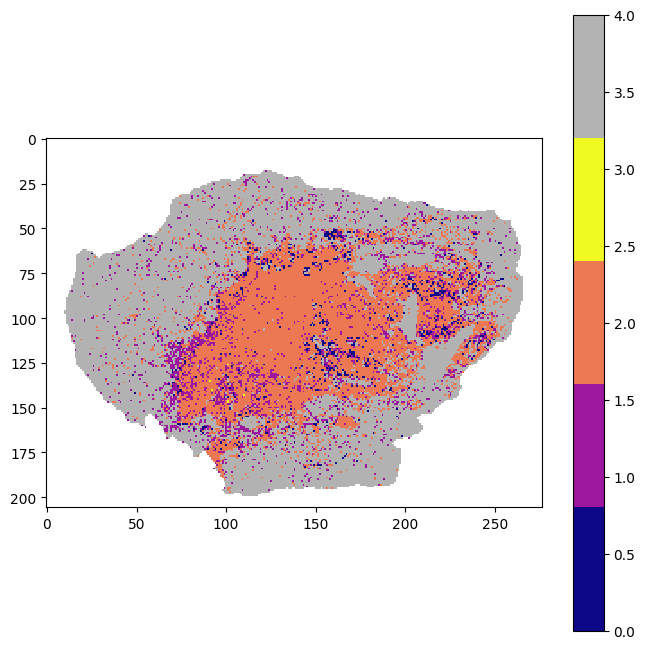

  0%|          | 0/176 [00:00<?, ?it/s]

  1%|          | 2/176 [00:00<00:46,  3.74it/s]

  2%|▏         | 3/176 [00:02<03:10,  1.10s/it]

  2%|▏         | 4/176 [00:06<05:24,  1.89s/it]

  3%|▎         | 5/176 [00:10<08:03,  2.83s/it]

  3%|▎         | 6/176 [00:15<10:24,  3.67s/it]

  4%|▍         | 7/176 [00:21<12:11,  4.33s/it]

  5%|▍         | 8/176 [00:28<14:35,  5.21s/it]

  5%|▌         | 9/176 [00:35<15:54,  5.72s/it]

  6%|▌         | 10/176 [00:42<17:10,  6.21s/it]

  6%|▋         | 11/176 [00:50<18:13,  6.63s/it]

  7%|▋         | 12/176 [00:58<18:59,  6.95s/it]

  7%|▋         | 13/176 [01:06<19:48,  7.29s/it]

  8%|▊         | 14/176 [01:15<21:33,  7.98s/it]

  9%|▊         | 15/176 [01:25<22:46,  8.49s/it]

  9%|▉         | 16/176 [01:37<25:17,  9.48s/it]

 10%|▉         | 17/176 [01:49<27:36, 10.42s/it]

 10%|█         | 18/176 [02:01<28:10, 10.70s/it]

 11%|█         | 19/176 [02:12<28:41, 10.97s/it]

 11%|█▏        | 20/176 [02:24<29:08, 11.21s/it]

 12%|█▏        | 21/176 [02:36<29:39, 11.48s/it]

 12%|█▎        | 22/176 [02:49<30:21, 11.83s/it]

 13%|█▎        | 23/176 [03:00<29:57, 11.75s/it]

 14%|█▎        | 24/176 [03:13<30:01, 11.85s/it]

 14%|█▍        | 25/176 [03:25<30:17, 12.04s/it]

 15%|█▍        | 26/176 [03:38<30:29, 12.20s/it]

 15%|█▌        | 27/176 [03:51<31:02, 12.50s/it]

 16%|█▌        | 28/176 [04:06<33:05, 13.42s/it]

 16%|█▋        | 29/176 [04:20<33:20, 13.61s/it]

 17%|█▋        | 30/176 [04:35<34:05, 14.01s/it]

 18%|█▊        | 31/176 [04:50<34:20, 14.21s/it]

 18%|█▊        | 32/176 [05:04<33:53, 14.12s/it]

 19%|█▉        | 33/176 [05:18<33:45, 14.17s/it]

 19%|█▉        | 34/176 [05:33<33:46, 14.27s/it]

 20%|█▉        | 35/176 [05:47<33:38, 14.31s/it]

 20%|██        | 36/176 [06:02<33:52, 14.52s/it]

 21%|██        | 37/176 [06:17<33:53, 14.63s/it]

 22%|██▏       | 38/176 [06:32<33:33, 14.59s/it]

 22%|██▏       | 39/176 [06:49<35:08, 15.39s/it]

 23%|██▎       | 40/176 [07:04<34:33, 15.25s/it]

 23%|██▎       | 41/176 [07:19<34:30, 15.34s/it]

 24%|██▍       | 42/176 [07:34<34:03, 15.25s/it]

 24%|██▍       | 43/176 [07:51<34:36, 15.61s/it]

 25%|██▌       | 44/176 [08:07<34:52, 15.85s/it]

 26%|██▌       | 45/176 [08:23<34:46, 15.93s/it]

 26%|██▌       | 46/176 [08:40<34:50, 16.08s/it]

 27%|██▋       | 47/176 [08:57<35:28, 16.50s/it]

 27%|██▋       | 48/176 [09:14<35:34, 16.67s/it]

 28%|██▊       | 49/176 [09:30<34:40, 16.38s/it]

 28%|██▊       | 50/176 [09:48<35:14, 16.78s/it]

 29%|██▉       | 51/176 [10:05<35:04, 16.84s/it]

 30%|██▉       | 52/176 [10:23<35:40, 17.26s/it]

 30%|███       | 53/176 [10:41<36:02, 17.58s/it]

 31%|███       | 54/176 [10:59<36:02, 17.72s/it]

 31%|███▏      | 55/176 [11:18<36:30, 18.10s/it]

 32%|███▏      | 56/176 [11:37<36:38, 18.32s/it]

 32%|███▏      | 57/176 [11:55<36:20, 18.32s/it]

 33%|███▎      | 58/176 [12:13<35:51, 18.23s/it]

 34%|███▎      | 59/176 [12:32<35:37, 18.27s/it]

 34%|███▍      | 60/176 [12:51<35:43, 18.47s/it]

 35%|███▍      | 61/176 [13:10<35:44, 18.65s/it]

 35%|███▌      | 62/176 [13:29<35:51, 18.87s/it]

 36%|███▌      | 63/176 [13:47<35:12, 18.70s/it]

 36%|███▋      | 64/176 [14:07<35:21, 18.94s/it]

 37%|███▋      | 65/176 [14:27<35:43, 19.31s/it]

 38%|███▊      | 66/176 [14:48<36:08, 19.71s/it]

 38%|███▊      | 67/176 [15:06<35:13, 19.39s/it]

 39%|███▊      | 68/176 [15:26<34:55, 19.40s/it]

 39%|███▉      | 69/176 [15:46<34:48, 19.52s/it]

 40%|███▉      | 70/176 [16:05<34:10, 19.35s/it]

 40%|████      | 71/176 [16:23<33:28, 19.13s/it]

 41%|████      | 72/176 [16:43<33:23, 19.26s/it]

 41%|████▏     | 73/176 [17:02<32:47, 19.10s/it]

 42%|████▏     | 74/176 [17:22<33:04, 19.45s/it]

 43%|████▎     | 75/176 [17:40<32:13, 19.14s/it]

 43%|████▎     | 76/176 [18:00<32:03, 19.23s/it]

 44%|████▍     | 77/176 [18:19<31:45, 19.25s/it]

 44%|████▍     | 78/176 [18:37<31:03, 19.01s/it]

 45%|████▍     | 79/176 [18:56<30:41, 18.98s/it]

 45%|████▌     | 80/176 [19:15<30:17, 18.93s/it]

 46%|████▌     | 81/176 [19:34<29:50, 18.85s/it]

 47%|████▋     | 82/176 [19:53<29:34, 18.88s/it]

 47%|████▋     | 83/176 [20:11<29:06, 18.78s/it]

 48%|████▊     | 84/176 [20:31<29:08, 19.01s/it]

 48%|████▊     | 85/176 [20:50<28:47, 18.98s/it]

 49%|████▉     | 86/176 [21:09<28:22, 18.91s/it]

 49%|████▉     | 87/176 [21:28<28:10, 18.99s/it]

 50%|█████     | 88/176 [21:47<27:57, 19.07s/it]

 51%|█████     | 89/176 [22:07<28:13, 19.47s/it]

 51%|█████     | 90/176 [22:26<27:29, 19.18s/it]

 52%|█████▏    | 91/176 [22:45<27:01, 19.08s/it]

 52%|█████▏    | 92/176 [23:04<26:36, 19.00s/it]

 53%|█████▎    | 93/176 [23:24<26:43, 19.33s/it]

 53%|█████▎    | 94/176 [23:43<26:16, 19.22s/it]

 54%|█████▍    | 95/176 [24:02<26:00, 19.26s/it]

 55%|█████▍    | 96/176 [24:22<26:00, 19.51s/it]

 55%|█████▌    | 97/176 [24:41<25:17, 19.21s/it]

 56%|█████▌    | 98/176 [25:00<25:00, 19.24s/it]

 56%|█████▋    | 99/176 [25:21<25:20, 19.75s/it]

 57%|█████▋    | 100/176 [25:41<25:12, 19.91s/it]

 57%|█████▋    | 101/176 [26:01<24:58, 19.99s/it]

 58%|█████▊    | 102/176 [26:23<25:27, 20.64s/it]

 59%|█████▊    | 103/176 [26:45<25:20, 20.83s/it]

 59%|█████▉    | 104/176 [27:05<24:46, 20.65s/it]

 60%|█████▉    | 105/176 [27:25<24:22, 20.60s/it]

 60%|██████    | 106/176 [27:44<23:22, 20.03s/it]

 61%|██████    | 107/176 [28:03<22:34, 19.63s/it]

 61%|██████▏   | 108/176 [28:22<22:14, 19.62s/it]

 62%|██████▏   | 109/176 [28:41<21:26, 19.20s/it]

 62%|██████▎   | 110/176 [29:01<21:26, 19.50s/it]

 63%|██████▎   | 111/176 [29:23<22:06, 20.41s/it]

 64%|██████▎   | 112/176 [29:45<22:17, 20.90s/it]

 64%|██████▍   | 113/176 [30:07<22:07, 21.08s/it]

 65%|██████▍   | 114/176 [30:31<22:40, 21.94s/it]

 65%|██████▌   | 115/176 [30:53<22:22, 22.01s/it]

 66%|██████▌   | 116/176 [31:17<22:34, 22.58s/it]

 66%|██████▋   | 117/176 [31:40<22:29, 22.88s/it]

 67%|██████▋   | 118/176 [32:06<22:44, 23.53s/it]

 68%|██████▊   | 119/176 [32:32<23:14, 24.47s/it]

 68%|██████▊   | 120/176 [32:56<22:46, 24.41s/it]

 69%|██████▉   | 121/176 [33:20<22:15, 24.28s/it]

 69%|██████▉   | 122/176 [33:44<21:35, 23.99s/it]

 70%|██████▉   | 123/176 [34:08<21:11, 23.99s/it]

 70%|███████   | 124/176 [34:33<21:08, 24.40s/it]

 71%|███████   | 125/176 [34:59<21:08, 24.88s/it]

 72%|███████▏  | 126/176 [35:25<21:04, 25.30s/it]

 72%|███████▏  | 127/176 [35:51<20:50, 25.51s/it]

 73%|███████▎  | 128/176 [36:19<20:58, 26.22s/it]

 73%|███████▎  | 129/176 [36:43<20:00, 25.55s/it]

 74%|███████▍  | 130/176 [37:08<19:23, 25.29s/it]

 74%|███████▍  | 131/176 [37:32<18:45, 25.02s/it]

 75%|███████▌  | 132/176 [37:56<17:58, 24.52s/it]

 76%|███████▌  | 133/176 [38:20<17:33, 24.50s/it]

 76%|███████▌  | 134/176 [38:44<16:59, 24.27s/it]

 77%|███████▋  | 135/176 [39:07<16:24, 24.01s/it]

 77%|███████▋  | 136/176 [39:31<15:54, 23.86s/it]

 78%|███████▊  | 137/176 [39:53<15:07, 23.26s/it]

 78%|███████▊  | 138/176 [40:15<14:29, 22.87s/it]

 79%|███████▉  | 139/176 [40:36<13:48, 22.40s/it]

 80%|███████▉  | 140/176 [40:57<13:17, 22.16s/it]

 80%|████████  | 141/176 [41:18<12:38, 21.67s/it]

 81%|████████  | 142/176 [41:37<11:54, 21.01s/it]

 81%|████████▏ | 143/176 [41:56<11:13, 20.40s/it]

 82%|████████▏ | 144/176 [42:14<10:29, 19.69s/it]

 82%|████████▏ | 145/176 [42:32<09:49, 19.00s/it]

 83%|████████▎ | 146/176 [42:49<09:14, 18.50s/it]

 84%|████████▎ | 147/176 [43:05<08:29, 17.57s/it]

 84%|████████▍ | 148/176 [43:21<08:04, 17.30s/it]

 85%|████████▍ | 149/176 [43:35<07:21, 16.34s/it]

 85%|████████▌ | 150/176 [43:50<06:51, 15.82s/it]

 86%|████████▌ | 151/176 [44:03<06:14, 14.99s/it]

 86%|████████▋ | 152/176 [44:17<05:51, 14.65s/it]

 87%|████████▋ | 153/176 [44:29<05:19, 13.91s/it]

 88%|████████▊ | 154/176 [44:41<04:50, 13.18s/it]

 88%|████████▊ | 155/176 [44:52<04:25, 12.67s/it]

 89%|████████▊ | 156/176 [45:02<03:59, 11.95s/it]

 89%|████████▉ | 157/176 [45:12<03:31, 11.14s/it]

 90%|████████▉ | 158/176 [45:21<03:13, 10.74s/it]

 90%|█████████ | 159/176 [45:30<02:50, 10.03s/it]

 91%|█████████ | 160/176 [45:38<02:29,  9.35s/it]

 91%|█████████▏| 161/176 [45:45<02:13,  8.88s/it]

 92%|█████████▏| 162/176 [45:53<01:58,  8.49s/it]

 93%|█████████▎| 163/176 [46:00<01:44,  8.02s/it]

 93%|█████████▎| 164/176 [46:07<01:33,  7.83s/it]

 94%|█████████▍| 165/176 [46:14<01:21,  7.44s/it]

 94%|█████████▍| 166/176 [46:19<01:06,  6.65s/it]

 95%|█████████▍| 167/176 [46:20<00:46,  5.18s/it]

 95%|█████████▌| 168/176 [46:22<00:32,  4.12s/it]

 96%|█████████▌| 169/176 [46:23<00:23,  3.32s/it]

 97%|█████████▋| 170/176 [46:24<00:15,  2.53s/it]

100%|██████████| 176/176 [46:24<00:00, 15.82s/it]

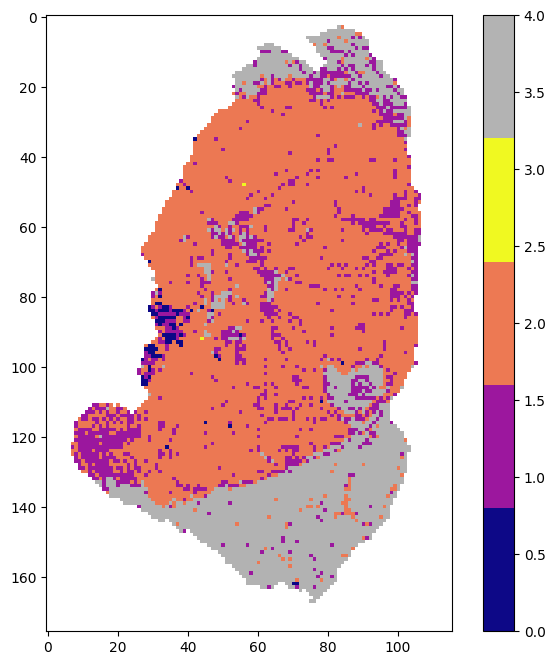

  0%|          | 0/99 [00:00<?, ?it/s]

  3%|▎         | 3/99 [00:01<00:59,  1.60it/s]

  4%|▍         | 4/99 [00:04<01:57,  1.24s/it]

  5%|▌         | 5/99 [00:07<03:03,  1.95s/it]

  6%|▌         | 6/99 [00:11<03:37,  2.34s/it]

  7%|▋         | 7/99 [00:15<04:34,  2.98s/it]

  8%|▊         | 8/99 [00:19<05:10,  3.41s/it]

  9%|▉         | 9/99 [00:25<05:58,  3.99s/it]

 10%|█         | 10/99 [00:30<06:32,  4.41s/it]

 11%|█         | 11/99 [00:36<06:58,  4.76s/it]

 12%|█▏        | 12/99 [00:42<07:39,  5.28s/it]

 13%|█▎        | 13/99 [00:50<08:28,  5.91s/it]

 14%|█▍        | 14/99 [00:58<09:17,  6.56s/it]

 15%|█▌        | 15/99 [01:08<10:43,  7.66s/it]

 16%|█▌        | 16/99 [01:17<11:14,  8.13s/it]

 17%|█▋        | 17/99 [01:27<11:54,  8.71s/it]

 18%|█▊        | 18/99 [01:37<12:24,  9.19s/it]

 19%|█▉        | 19/99 [01:50<13:47, 10.35s/it]

 20%|██        | 20/99 [02:05<15:24, 11.71s/it]

 21%|██        | 21/99 [02:23<17:29, 13.45s/it]

 22%|██▏       | 22/99 [02:42<19:27, 15.16s/it]

 23%|██▎       | 23/99 [03:01<20:31, 16.20s/it]

 24%|██▍       | 24/99 [03:24<22:45, 18.21s/it]

 25%|██▌       | 25/99 [03:48<24:44, 20.07s/it]

 26%|██▋       | 26/99 [04:13<26:19, 21.64s/it]

 27%|██▋       | 27/99 [04:38<27:13, 22.68s/it]

 28%|██▊       | 28/99 [05:04<27:43, 23.43s/it]

 29%|██▉       | 29/99 [05:29<28:06, 24.10s/it]

 30%|███       | 30/99 [05:56<28:37, 24.89s/it]

 31%|███▏      | 31/99 [06:23<29:00, 25.60s/it]

 32%|███▏      | 32/99 [06:52<29:39, 26.55s/it]

 33%|███▎      | 33/99 [07:27<31:59, 29.08s/it]

 34%|███▍      | 34/99 [07:57<31:53, 29.44s/it]

 35%|███▌      | 35/99 [08:27<31:35, 29.61s/it]

 36%|███▋      | 36/99 [08:57<31:00, 29.53s/it]

 37%|███▋      | 37/99 [09:25<30:03, 29.09s/it]

 38%|███▊      | 38/99 [09:53<29:17, 28.80s/it]

 39%|███▉      | 39/99 [10:22<29:02, 29.04s/it]

 40%|████      | 40/99 [10:50<28:14, 28.72s/it]

 41%|████▏     | 41/99 [11:20<28:09, 29.12s/it]

 42%|████▏     | 42/99 [11:51<28:08, 29.63s/it]

 43%|████▎     | 43/99 [12:21<27:40, 29.65s/it]

 44%|████▍     | 44/99 [12:50<27:04, 29.53s/it]

 45%|████▌     | 45/99 [13:22<27:05, 30.11s/it]

 46%|████▋     | 46/99 [13:54<27:16, 30.88s/it]

 47%|████▋     | 47/99 [14:28<27:32, 31.77s/it]

 48%|████▊     | 48/99 [15:02<27:27, 32.31s/it]

 49%|████▉     | 49/99 [15:34<26:51, 32.23s/it]

 51%|█████     | 50/99 [16:07<26:33, 32.52s/it]

 52%|█████▏    | 51/99 [16:39<25:55, 32.40s/it]

 53%|█████▎    | 52/99 [17:13<25:44, 32.87s/it]

 54%|█████▎    | 53/99 [17:50<26:06, 34.06s/it]

 55%|█████▍    | 54/99 [18:29<26:44, 35.66s/it]

 56%|█████▌    | 55/99 [19:07<26:31, 36.17s/it]

 57%|█████▋    | 56/99 [19:45<26:29, 36.95s/it]

 58%|█████▊    | 57/99 [20:23<26:01, 37.17s/it]

 59%|█████▊    | 58/99 [21:00<25:16, 37.00s/it]

 60%|█████▉    | 59/99 [21:37<24:46, 37.15s/it]

 61%|██████    | 60/99 [22:14<24:04, 37.04s/it]

 62%|██████▏   | 61/99 [22:51<23:30, 37.12s/it]

 63%|██████▎   | 62/99 [23:28<22:44, 36.88s/it]

 64%|██████▎   | 63/99 [24:07<22:38, 37.73s/it]

 65%|██████▍   | 64/99 [24:47<22:19, 38.27s/it]

 66%|██████▌   | 65/99 [25:25<21:40, 38.26s/it]

 67%|██████▋   | 66/99 [26:02<20:44, 37.72s/it]

 68%|██████▊   | 67/99 [26:38<19:55, 37.35s/it]

 69%|██████▊   | 68/99 [27:15<19:10, 37.12s/it]

 70%|██████▉   | 69/99 [27:51<18:22, 36.76s/it]

 71%|███████   | 70/99 [28:27<17:43, 36.66s/it]

 72%|███████▏  | 71/99 [29:04<17:08, 36.74s/it]

 73%|███████▎  | 72/99 [29:42<16:40, 37.06s/it]

 74%|███████▎  | 73/99 [30:17<15:49, 36.51s/it]

 75%|███████▍  | 74/99 [30:49<14:42, 35.31s/it]

 76%|███████▌  | 75/99 [31:22<13:46, 34.42s/it]

 77%|███████▋  | 76/99 [31:54<12:53, 33.62s/it]

 78%|███████▊  | 77/99 [32:26<12:10, 33.21s/it]

 79%|███████▉  | 78/99 [32:56<11:20, 32.40s/it]

 80%|███████▉  | 79/99 [33:26<10:31, 31.57s/it]

 81%|████████  | 80/99 [33:56<09:50, 31.10s/it]

 82%|████████▏ | 81/99 [34:25<09:06, 30.36s/it]

 83%|████████▎ | 82/99 [34:54<08:31, 30.10s/it]

 84%|████████▍ | 83/99 [35:23<07:53, 29.62s/it]

 85%|████████▍ | 84/99 [35:51<07:19, 29.32s/it]

 86%|████████▌ | 85/99 [36:18<06:39, 28.54s/it]

 87%|████████▋ | 86/99 [36:43<05:56, 27.44s/it]

 88%|████████▊ | 87/99 [37:06<05:12, 26.07s/it]

 89%|████████▉ | 88/99 [37:28<04:35, 25.04s/it]

 90%|████████▉ | 89/99 [37:47<03:51, 23.13s/it]

 91%|█████████ | 90/99 [38:02<03:07, 20.82s/it]

 92%|█████████▏| 91/99 [38:15<02:27, 18.45s/it]

 93%|█████████▎| 92/99 [38:26<01:52, 16.11s/it]

 94%|█████████▍| 93/99 [38:35<01:23, 13.85s/it]

 95%|█████████▍| 94/99 [38:41<00:58, 11.74s/it]

 96%|█████████▌| 95/99 [38:46<00:38,  9.61s/it]

 97%|█████████▋| 96/99 [38:50<00:23,  7.84s/it]

 98%|█████████▊| 97/99 [38:52<00:12,  6.14s/it]

100%|██████████| 99/99 [38:52<00:00, 23.56s/it]

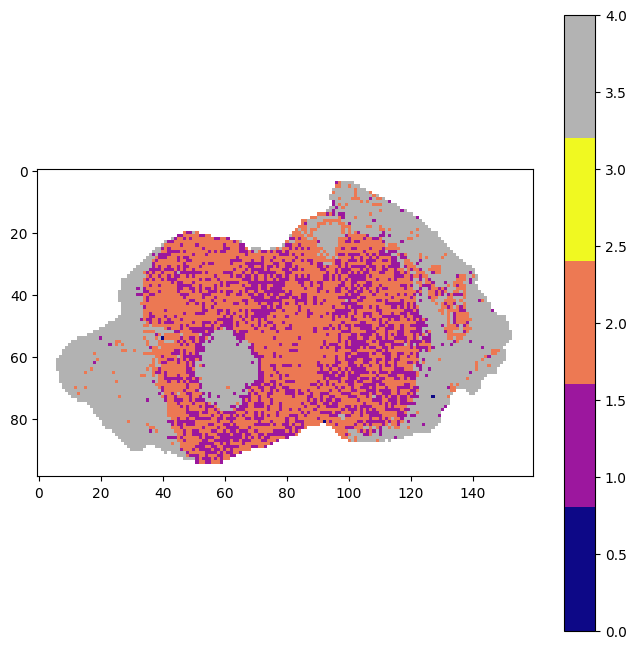

  0%|          | 0/106 [00:00<?, ?it/s]

  5%|▍         | 5/106 [00:00<00:06, 16.46it/s]

  7%|▋         | 7/106 [00:03<00:59,  1.66it/s]

  8%|▊         | 8/106 [00:05<01:37,  1.01it/s]

  8%|▊         | 9/106 [00:08<02:07,  1.32s/it]

  9%|▉         | 10/106 [00:11<02:39,  1.66s/it]

 10%|█         | 11/106 [00:13<03:04,  1.94s/it]

 11%|█▏        | 12/106 [00:16<03:24,  2.17s/it]

 12%|█▏        | 13/106 [00:19<03:32,  2.29s/it]

 13%|█▎        | 14/106 [00:22<03:52,  2.53s/it]

 14%|█▍        | 15/106 [00:25<04:09,  2.74s/it]

 15%|█▌        | 16/106 [00:28<04:10,  2.79s/it]

 16%|█▌        | 17/106 [00:31<04:12,  2.84s/it]

 17%|█▋        | 18/106 [00:34<04:11,  2.86s/it]

 18%|█▊        | 19/106 [00:39<04:58,  3.43s/it]

 19%|█▉        | 20/106 [00:47<06:50,  4.78s/it]

 20%|█▉        | 21/106 [00:55<08:18,  5.87s/it]

 21%|██        | 22/106 [01:07<10:44,  7.67s/it]

 22%|██▏       | 23/106 [01:22<13:34,  9.81s/it]

 23%|██▎       | 24/106 [01:35<14:49, 10.84s/it]

 24%|██▎       | 25/106 [01:50<16:17, 12.07s/it]

 25%|██▍       | 26/106 [02:03<16:34, 12.44s/it]

 25%|██▌       | 27/106 [02:18<17:16, 13.12s/it]

 26%|██▋       | 28/106 [02:33<17:54, 13.78s/it]

 27%|██▋       | 29/106 [02:49<18:32, 14.45s/it]

 28%|██▊       | 30/106 [03:05<18:44, 14.79s/it]

 29%|██▉       | 31/106 [03:22<19:16, 15.42s/it]

 30%|███       | 32/106 [03:42<20:40, 16.76s/it]

 31%|███       | 33/106 [04:04<22:19, 18.35s/it]

 32%|███▏      | 34/106 [04:28<24:02, 20.03s/it]

 33%|███▎      | 35/106 [04:51<25:01, 21.15s/it]

 34%|███▍      | 36/106 [05:19<26:52, 23.03s/it]

 35%|███▍      | 37/106 [05:45<27:40, 24.06s/it]

 36%|███▌      | 38/106 [06:12<28:04, 24.77s/it]

 37%|███▋      | 39/106 [06:40<28:45, 25.75s/it]

 38%|███▊      | 40/106 [07:06<28:32, 25.95s/it]

 39%|███▊      | 41/106 [07:33<28:24, 26.22s/it]

 40%|███▉      | 42/106 [08:00<28:05, 26.33s/it]

 41%|████      | 43/106 [08:25<27:21, 26.06s/it]

 42%|████▏     | 44/106 [08:54<27:48, 26.92s/it]

 42%|████▏     | 45/106 [09:20<27:12, 26.76s/it]

 43%|████▎     | 46/106 [09:45<26:15, 26.26s/it]

 44%|████▍     | 47/106 [10:10<25:22, 25.80s/it]

 45%|████▌     | 48/106 [10:36<25:05, 25.95s/it]

 46%|████▌     | 49/106 [11:01<24:19, 25.61s/it]

 47%|████▋     | 50/106 [11:27<23:53, 25.59s/it]

 48%|████▊     | 51/106 [11:53<23:35, 25.74s/it]

 49%|████▉     | 52/106 [12:19<23:08, 25.71s/it]

 50%|█████     | 53/106 [12:43<22:30, 25.47s/it]

 51%|█████     | 54/106 [13:07<21:36, 24.93s/it]

 52%|█████▏    | 55/106 [13:30<20:36, 24.24s/it]

 53%|█████▎    | 56/106 [13:53<19:54, 23.90s/it]

 54%|█████▍    | 57/106 [14:15<19:06, 23.40s/it]

 55%|█████▍    | 58/106 [14:37<18:20, 22.92s/it]

 56%|█████▌    | 59/106 [14:59<17:46, 22.69s/it]

 57%|█████▋    | 60/106 [15:20<17:06, 22.32s/it]

 58%|█████▊    | 61/106 [15:43<16:44, 22.33s/it]

 58%|█████▊    | 62/106 [16:05<16:26, 22.42s/it]

 59%|█████▉    | 63/106 [16:28<15:59, 22.31s/it]

 60%|██████    | 64/106 [16:51<15:47, 22.55s/it]

 61%|██████▏   | 65/106 [17:15<15:50, 23.17s/it]

 62%|██████▏   | 66/106 [17:37<15:12, 22.82s/it]

 63%|██████▎   | 67/106 [17:57<14:15, 21.95s/it]

 64%|██████▍   | 68/106 [18:17<13:34, 21.44s/it]

 65%|██████▌   | 69/106 [18:38<12:59, 21.06s/it]

 66%|██████▌   | 70/106 [18:57<12:17, 20.48s/it]

 67%|██████▋   | 71/106 [19:16<11:42, 20.07s/it]

 68%|██████▊   | 72/106 [19:34<11:05, 19.59s/it]

 69%|██████▉   | 73/106 [19:53<10:38, 19.35s/it]

 70%|██████▉   | 74/106 [20:12<10:18, 19.34s/it]

 71%|███████   | 75/106 [20:30<09:45, 18.89s/it]

 72%|███████▏  | 76/106 [20:48<09:19, 18.66s/it]

 73%|███████▎  | 77/106 [21:06<08:50, 18.31s/it]

 74%|███████▎  | 78/106 [21:24<08:31, 18.25s/it]

 75%|███████▍  | 79/106 [21:41<08:04, 17.94s/it]

 75%|███████▌  | 80/106 [21:58<07:33, 17.46s/it]

 76%|███████▋  | 81/106 [22:13<07:04, 16.99s/it]

 77%|███████▋  | 82/106 [22:28<06:27, 16.16s/it]

 78%|███████▊  | 83/106 [22:42<06:01, 15.71s/it]

 79%|███████▉  | 84/106 [22:57<05:35, 15.27s/it]

 80%|████████  | 85/106 [23:11<05:13, 14.91s/it]

 81%|████████  | 86/106 [23:24<04:50, 14.50s/it]

 82%|████████▏ | 87/106 [23:37<04:28, 14.12s/it]

 83%|████████▎ | 88/106 [23:49<04:02, 13.48s/it]

 84%|████████▍ | 89/106 [24:01<03:38, 12.88s/it]

 85%|████████▍ | 90/106 [24:11<03:12, 12.06s/it]

 86%|████████▌ | 91/106 [24:20<02:47, 11.16s/it]

 87%|████████▋ | 92/106 [24:28<02:21, 10.13s/it]

 88%|████████▊ | 93/106 [24:34<01:58,  9.09s/it]

 89%|████████▊ | 94/106 [24:41<01:39,  8.32s/it]

 90%|████████▉ | 95/106 [24:47<01:25,  7.78s/it]

 91%|█████████ | 96/106 [24:53<01:10,  7.03s/it]

 92%|█████████▏| 97/106 [24:57<00:56,  6.24s/it]

 92%|█████████▏| 98/106 [25:01<00:44,  5.55s/it]

 93%|█████████▎| 99/106 [25:05<00:35,  5.01s/it]

 94%|█████████▍| 100/106 [25:08<00:26,  4.35s/it]

 95%|█████████▌| 101/106 [25:09<00:16,  3.39s/it]

100%|██████████| 106/106 [25:09<00:00, 14.24s/it]

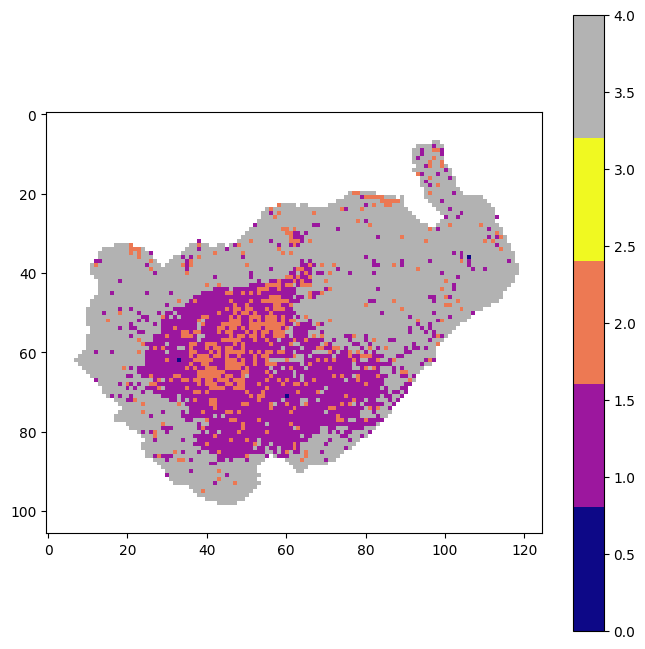

  0%|          | 0/86 [00:00<?, ?it/s]

  2%|▏         | 2/86 [00:00<00:40,  2.09it/s]

  3%|▎         | 3/86 [00:02<01:22,  1.00it/s]

  5%|▍         | 4/86 [00:05<02:23,  1.75s/it]

  6%|▌         | 5/86 [00:09<03:10,  2.36s/it]

  7%|▋         | 6/86 [00:13<04:00,  3.01s/it]

  8%|▊         | 7/86 [00:18<04:44,  3.60s/it]

  9%|▉         | 8/86 [00:24<05:41,  4.38s/it]

 10%|█         | 9/86 [00:30<06:12,  4.84s/it]

 12%|█▏        | 10/86 [00:36<06:41,  5.29s/it]

 13%|█▎        | 11/86 [00:43<07:08,  5.71s/it]

 14%|█▍        | 12/86 [00:51<07:53,  6.40s/it]

 15%|█▌        | 13/86 [01:00<08:43,  7.17s/it]

 16%|█▋        | 14/86 [01:12<10:19,  8.61s/it]

 17%|█▋        | 15/86 [01:25<12:01, 10.17s/it]

 19%|█▊        | 16/86 [01:40<13:23, 11.48s/it]

 20%|█▉        | 17/86 [01:55<14:23, 12.51s/it]

 21%|██        | 18/86 [02:10<15:06, 13.34s/it]

 22%|██▏       | 19/86 [02:27<16:01, 14.36s/it]

 23%|██▎       | 20/86 [02:45<17:02, 15.49s/it]

 24%|██▍       | 21/86 [03:03<17:43, 16.36s/it]

 26%|██▌       | 22/86 [03:22<18:09, 17.02s/it]

 27%|██▋       | 23/86 [03:42<18:51, 17.96s/it]

 28%|██▊       | 24/86 [04:01<18:55, 18.32s/it]

 29%|██▉       | 25/86 [04:23<19:41, 19.37s/it]

 30%|███       | 26/86 [04:44<19:45, 19.76s/it]

 31%|███▏      | 27/86 [05:05<19:46, 20.11s/it]

 33%|███▎      | 28/86 [05:26<19:55, 20.61s/it]

 34%|███▎      | 29/86 [05:47<19:37, 20.66s/it]

 35%|███▍      | 30/86 [06:09<19:34, 20.97s/it]

 36%|███▌      | 31/86 [06:30<19:21, 21.12s/it]

 37%|███▋      | 32/86 [06:51<18:57, 21.06s/it]

 38%|███▊      | 33/86 [07:13<18:48, 21.29s/it]

 40%|███▉      | 34/86 [07:35<18:33, 21.42s/it]

 41%|████      | 35/86 [07:56<18:11, 21.40s/it]

 42%|████▏     | 36/86 [08:19<18:03, 21.68s/it]

 43%|████▎     | 37/86 [08:43<18:19, 22.43s/it]

 44%|████▍     | 38/86 [09:06<18:12, 22.76s/it]

 45%|████▌     | 39/86 [09:30<17:57, 22.93s/it]

 47%|████▋     | 40/86 [09:53<17:40, 23.05s/it]

 48%|████▊     | 41/86 [10:16<17:21, 23.14s/it]

 49%|████▉     | 42/86 [10:41<17:24, 23.74s/it]

 50%|█████     | 43/86 [11:05<17:04, 23.82s/it]

 51%|█████     | 44/86 [11:29<16:35, 23.71s/it]

 52%|█████▏    | 45/86 [11:52<16:03, 23.49s/it]

 53%|█████▎    | 46/86 [12:16<15:43, 23.58s/it]

 55%|█████▍    | 47/86 [12:39<15:15, 23.48s/it]

 56%|█████▌    | 48/86 [13:02<14:43, 23.26s/it]

 57%|█████▋    | 49/86 [13:25<14:22, 23.31s/it]

 58%|█████▊    | 50/86 [13:47<13:43, 22.86s/it]

 59%|█████▉    | 51/86 [14:10<13:24, 22.98s/it]

 60%|██████    | 52/86 [14:33<12:55, 22.81s/it]

 62%|██████▏   | 53/86 [14:53<12:10, 22.14s/it]

 63%|██████▎   | 54/86 [15:12<11:20, 21.26s/it]

 64%|██████▍   | 55/86 [15:31<10:34, 20.48s/it]

 65%|██████▌   | 56/86 [15:49<09:52, 19.76s/it]

 66%|██████▋   | 57/86 [16:07<09:16, 19.19s/it]

 67%|██████▋   | 58/86 [16:26<08:57, 19.21s/it]

 69%|██████▊   | 59/86 [16:45<08:35, 19.10s/it]

 70%|██████▉   | 60/86 [17:05<08:19, 19.22s/it]

 71%|███████   | 61/86 [17:23<07:55, 19.00s/it]

 72%|███████▏  | 62/86 [17:41<07:29, 18.72s/it]

 73%|███████▎  | 63/86 [17:59<07:04, 18.45s/it]

 74%|███████▍  | 64/86 [18:15<06:27, 17.62s/it]

 76%|███████▌  | 65/86 [18:29<05:47, 16.55s/it]

 77%|███████▋  | 66/86 [18:41<05:04, 15.22s/it]

 78%|███████▊  | 67/86 [18:52<04:27, 14.07s/it]

 79%|███████▉  | 68/86 [19:03<03:54, 13.01s/it]

 80%|████████  | 69/86 [19:14<03:31, 12.45s/it]

 81%|████████▏ | 70/86 [19:25<03:12, 12.01s/it]

 83%|████████▎ | 71/86 [19:35<02:52, 11.51s/it]

 84%|████████▎ | 72/86 [19:46<02:38, 11.32s/it]

 85%|████████▍ | 73/86 [19:58<02:27, 11.38s/it]

 86%|████████▌ | 74/86 [20:08<02:12, 11.08s/it]

 87%|████████▋ | 75/86 [20:17<01:53, 10.34s/it]

 88%|████████▊ | 76/86 [20:24<01:36,  9.62s/it]

 90%|████████▉ | 77/86 [20:31<01:17,  8.58s/it]

 91%|█████████ | 78/86 [20:37<01:02,  7.80s/it]

 92%|█████████▏| 79/86 [20:42<00:49,  7.12s/it]

 93%|█████████▎| 80/86 [20:47<00:39,  6.51s/it]

 94%|█████████▍| 81/86 [20:52<00:29,  5.89s/it]

 95%|█████████▌| 82/86 [20:55<00:20,  5.15s/it]

 97%|█████████▋| 83/86 [20:56<00:11,  3.95s/it]

 98%|█████████▊| 84/86 [20:57<00:05,  2.95s/it]

100%|██████████| 86/86 [20:57<00:00, 14.62s/it]

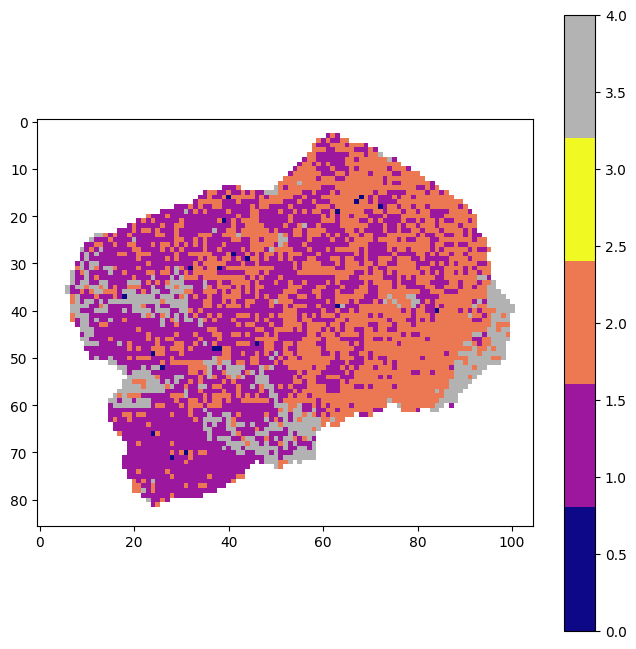

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 1/210 [00:27<1:35:24, 27.39s/it]

  1%|          | 2/210 [00:54<1:34:30, 27.26s/it]

  1%|▏         | 3/210 [01:20<1:31:16, 26.45s/it]

  2%|▏         | 4/210 [01:47<1:31:30, 26.65s/it]

  2%|▏         | 5/210 [02:15<1:33:50, 27.47s/it]

  3%|▎         | 6/210 [02:47<1:37:37, 28.71s/it]

  3%|▎         | 7/210 [03:18<1:40:16, 29.64s/it]

  4%|▍         | 8/210 [03:49<1:41:15, 30.08s/it]

  4%|▍         | 9/210 [04:21<1:42:27, 30.58s/it]

  5%|▍         | 10/210 [04:55<1:45:29, 31.65s/it]

  5%|▌         | 11/210 [05:29<1:47:52, 32.52s/it]

  6%|▌         | 12/210 [06:06<1:51:09, 33.68s/it]

  6%|▌         | 13/210 [06:44<1:55:16, 35.11s/it]

  7%|▋         | 14/210 [07:24<1:59:14, 36.50s/it]

  7%|▋         | 15/210 [08:06<2:04:05, 38.18s/it]

  8%|▊         | 16/210 [08:47<2:06:44, 39.20s/it]

  8%|▊         | 17/210 [09:27<2:06:53, 39.45s/it]

  9%|▊         | 18/210 [10:07<2:05:57, 39.36s/it]

  9%|▉         | 19/210 [10:45<2:04:33, 39.13s/it]

 10%|▉         | 20/210 [11:23<2:02:50, 38.79s/it]

 10%|█         | 21/210 [12:05<2:04:44, 39.60s/it]

 10%|█         | 22/210 [12:44<2:04:05, 39.60s/it]

 11%|█         | 23/210 [13:25<2:03:59, 39.79s/it]

 11%|█▏        | 24/210 [14:05<2:04:20, 40.11s/it]

 12%|█▏        | 25/210 [14:46<2:04:11, 40.28s/it]

 12%|█▏        | 26/210 [15:26<2:03:28, 40.26s/it]

 13%|█▎        | 27/210 [16:09<2:04:37, 40.86s/it]

 13%|█▎        | 28/210 [16:50<2:04:47, 41.14s/it]

 14%|█▍        | 29/210 [17:33<2:05:46, 41.69s/it]

 14%|█▍        | 30/210 [18:16<2:05:31, 41.84s/it]

 15%|█▍        | 31/210 [19:00<2:06:45, 42.49s/it]

 15%|█▌        | 32/210 [19:45<2:09:06, 43.52s/it]

 16%|█▌        | 33/210 [20:32<2:11:21, 44.53s/it]

 16%|█▌        | 34/210 [21:21<2:14:08, 45.73s/it]

 17%|█▋        | 35/210 [22:09<2:15:14, 46.37s/it]

 17%|█▋        | 36/210 [23:01<2:19:32, 48.12s/it]

 18%|█▊        | 37/210 [23:52<2:21:42, 49.15s/it]

 18%|█▊        | 38/210 [24:43<2:22:27, 49.69s/it]

 19%|█▊        | 39/210 [25:34<2:22:44, 50.08s/it]

 19%|█▉        | 40/210 [26:27<2:24:08, 50.88s/it]

 20%|█▉        | 41/210 [27:22<2:26:22, 51.97s/it]

 20%|██        | 42/210 [28:14<2:25:35, 52.00s/it]

 20%|██        | 43/210 [29:08<2:26:51, 52.77s/it]

 21%|██        | 44/210 [30:02<2:26:36, 52.99s/it]

 21%|██▏       | 45/210 [30:56<2:26:21, 53.22s/it]

 22%|██▏       | 46/210 [31:51<2:27:26, 53.94s/it]

 22%|██▏       | 47/210 [32:45<2:26:50, 54.05s/it]

 23%|██▎       | 48/210 [33:41<2:27:11, 54.52s/it]

 23%|██▎       | 49/210 [34:38<2:28:01, 55.16s/it]

 24%|██▍       | 50/210 [35:34<2:28:19, 55.62s/it]

 24%|██▍       | 51/210 [36:31<2:28:03, 55.87s/it]

 25%|██▍       | 52/210 [37:31<2:30:27, 57.14s/it]

 25%|██▌       | 53/210 [38:29<2:30:31, 57.53s/it]

 26%|██▌       | 54/210 [39:28<2:30:40, 57.95s/it]

 26%|██▌       | 55/210 [40:28<2:31:09, 58.51s/it]

 27%|██▋       | 56/210 [41:28<2:31:20, 58.96s/it]

 27%|██▋       | 57/210 [42:28<2:30:43, 59.11s/it]

 28%|██▊       | 58/210 [43:29<2:31:44, 59.90s/it]

 28%|██▊       | 59/210 [44:31<2:32:13, 60.49s/it]

 29%|██▊       | 60/210 [45:32<2:31:34, 60.63s/it]

 29%|██▉       | 61/210 [46:37<2:33:18, 61.73s/it]

 30%|██▉       | 62/210 [47:42<2:34:51, 62.78s/it]

 30%|███       | 63/210 [48:46<2:34:33, 63.09s/it]

 30%|███       | 64/210 [49:53<2:36:37, 64.36s/it]

 31%|███       | 65/210 [50:58<2:36:11, 64.63s/it]

 31%|███▏      | 66/210 [52:06<2:37:32, 65.64s/it]

 32%|███▏      | 67/210 [53:13<2:37:17, 66.00s/it]

 32%|███▏      | 68/210 [54:21<2:37:47, 66.67s/it]

 33%|███▎      | 69/210 [55:30<2:37:48, 67.16s/it]

 33%|███▎      | 70/210 [56:40<2:38:57, 68.12s/it]

 34%|███▍      | 71/210 [57:49<2:38:35, 68.46s/it]

 34%|███▍      | 72/210 [58:58<2:37:32, 68.50s/it]

 35%|███▍      | 73/210 [1:00:07<2:36:43, 68.64s/it]

 35%|███▌      | 74/210 [1:01:16<2:35:55, 68.79s/it]

 36%|███▌      | 75/210 [1:02:26<2:35:55, 69.30s/it]

 36%|███▌      | 76/210 [1:03:36<2:35:03, 69.43s/it]

 37%|███▋      | 77/210 [1:04:47<2:34:54, 69.88s/it]

 37%|███▋      | 78/210 [1:06:00<2:35:49, 70.83s/it]

 38%|███▊      | 79/210 [1:07:12<2:35:33, 71.25s/it]

 38%|███▊      | 80/210 [1:08:28<2:37:26, 72.67s/it]

 39%|███▊      | 81/210 [1:09:40<2:35:38, 72.40s/it]

 39%|███▉      | 82/210 [1:10:53<2:34:48, 72.56s/it]

 40%|███▉      | 83/210 [1:12:09<2:35:51, 73.63s/it]

 40%|████      | 84/210 [1:13:29<2:38:15, 75.36s/it]

 40%|████      | 85/210 [1:14:46<2:38:22, 76.02s/it]

 41%|████      | 86/210 [1:16:07<2:40:02, 77.44s/it]

 41%|████▏     | 87/210 [1:17:27<2:40:18, 78.20s/it]

 42%|████▏     | 88/210 [1:18:47<2:40:21, 78.86s/it]

 42%|████▏     | 89/210 [1:20:09<2:41:02, 79.86s/it]

 43%|████▎     | 90/210 [1:21:29<2:39:24, 79.70s/it]

 43%|████▎     | 91/210 [1:22:50<2:38:44, 80.04s/it]

 44%|████▍     | 92/210 [1:24:09<2:37:12, 79.94s/it]

 44%|████▍     | 93/210 [1:25:33<2:38:18, 81.18s/it]

 45%|████▍     | 94/210 [1:26:54<2:36:40, 81.04s/it]

 45%|████▌     | 95/210 [1:28:15<2:34:59, 80.87s/it]

 46%|████▌     | 96/210 [1:29:38<2:34:51, 81.51s/it]

 46%|████▌     | 97/210 [1:31:01<2:34:51, 82.22s/it]

 47%|████▋     | 98/210 [1:32:24<2:33:31, 82.25s/it]

 47%|████▋     | 99/210 [1:33:46<2:32:21, 82.36s/it]

 48%|████▊     | 100/210 [1:35:12<2:32:44, 83.32s/it]

 48%|████▊     | 101/210 [1:36:37<2:32:06, 83.73s/it]

 49%|████▊     | 102/210 [1:38:02<2:31:50, 84.35s/it]

 49%|████▉     | 103/210 [1:39:29<2:31:45, 85.10s/it]

 50%|████▉     | 104/210 [1:40:54<2:30:18, 85.08s/it]

 50%|█████     | 105/210 [1:42:19<2:28:58, 85.13s/it]

 50%|█████     | 106/210 [1:43:48<2:29:24, 86.19s/it]

 51%|█████     | 107/210 [1:45:16<2:28:48, 86.68s/it]

 51%|█████▏    | 108/210 [1:46:43<2:27:26, 86.73s/it]

 52%|█████▏    | 109/210 [1:48:12<2:27:07, 87.40s/it]

 52%|█████▏    | 110/210 [1:49:40<2:26:10, 87.71s/it]

 53%|█████▎    | 111/210 [1:51:09<2:25:05, 87.93s/it]

 53%|█████▎    | 112/210 [1:52:37<2:23:38, 87.95s/it]

 54%|█████▍    | 113/210 [1:54:12<2:25:58, 90.29s/it]

 54%|█████▍    | 114/210 [1:55:42<2:23:56, 89.97s/it]

 55%|█████▍    | 115/210 [1:57:08<2:20:55, 89.00s/it]

 55%|█████▌    | 116/210 [1:58:40<2:20:34, 89.73s/it]

 56%|█████▌    | 117/210 [2:00:13<2:20:31, 90.66s/it]

 56%|█████▌    | 118/210 [2:01:42<2:18:33, 90.37s/it]

 57%|█████▋    | 119/210 [2:03:13<2:17:16, 90.51s/it]

 57%|█████▋    | 120/210 [2:04:42<2:15:03, 90.04s/it]

 58%|█████▊    | 121/210 [2:06:10<2:12:26, 89.29s/it]

 58%|█████▊    | 122/210 [2:07:37<2:10:03, 88.68s/it]

 59%|█████▊    | 123/210 [2:09:07<2:09:16, 89.15s/it]

 59%|█████▉    | 124/210 [2:10:35<2:07:15, 88.79s/it]

 60%|█████▉    | 125/210 [2:12:02<2:05:07, 88.33s/it]

 60%|██████    | 126/210 [2:13:31<2:03:53, 88.50s/it]

 60%|██████    | 127/210 [2:15:00<2:02:30, 88.56s/it]

 61%|██████    | 128/210 [2:16:30<2:01:27, 88.87s/it]

 61%|██████▏   | 129/210 [2:17:54<1:58:15, 87.59s/it]

 62%|██████▏   | 130/210 [2:19:23<1:57:08, 87.86s/it]

 62%|██████▏   | 131/210 [2:20:52<1:56:15, 88.30s/it]

 63%|██████▎   | 132/210 [2:22:20<1:54:49, 88.33s/it]

 63%|██████▎   | 133/210 [2:23:51<1:54:04, 88.89s/it]

 64%|██████▍   | 134/210 [2:25:17<1:51:43, 88.20s/it]

 64%|██████▍   | 135/210 [2:26:44<1:49:53, 87.91s/it]

 65%|██████▍   | 136/210 [2:28:13<1:48:30, 87.98s/it]

 65%|██████▌   | 137/210 [2:29:41<1:47:10, 88.09s/it]

 66%|██████▌   | 138/210 [2:31:11<1:46:36, 88.84s/it]

 66%|██████▌   | 139/210 [2:32:37<1:44:05, 87.96s/it]

 67%|██████▋   | 140/210 [2:34:05<1:42:34, 87.92s/it]

 67%|██████▋   | 141/210 [2:35:33<1:41:03, 87.88s/it]

 68%|██████▊   | 142/210 [2:36:56<1:37:49, 86.32s/it]

 68%|██████▊   | 143/210 [2:38:19<1:35:28, 85.50s/it]

 69%|██████▊   | 144/210 [2:39:40<1:32:38, 84.23s/it]

 69%|██████▉   | 145/210 [2:40:59<1:29:22, 82.50s/it]

 70%|██████▉   | 146/210 [2:42:19<1:27:07, 81.68s/it]

 70%|███████   | 147/210 [2:43:35<1:24:08, 80.14s/it]

 70%|███████   | 148/210 [2:44:56<1:22:57, 80.28s/it]

 71%|███████   | 149/210 [2:46:14<1:20:49, 79.50s/it]

 71%|███████▏  | 150/210 [2:47:32<1:19:14, 79.24s/it]

 72%|███████▏  | 151/210 [2:48:50<1:17:29, 78.81s/it]

 72%|███████▏  | 152/210 [2:50:09<1:16:09, 78.78s/it]

 73%|███████▎  | 153/210 [2:51:26<1:14:25, 78.35s/it]

 73%|███████▎  | 154/210 [2:52:41<1:12:18, 77.48s/it]

 74%|███████▍  | 155/210 [2:53:58<1:10:51, 77.31s/it]

 74%|███████▍  | 156/210 [2:55:12<1:08:34, 76.20s/it]

 75%|███████▍  | 157/210 [2:56:25<1:06:32, 75.32s/it]

 75%|███████▌  | 158/210 [2:57:40<1:05:07, 75.14s/it]

 76%|███████▌  | 159/210 [2:58:52<1:02:56, 74.06s/it]

 76%|███████▌  | 160/210 [3:00:04<1:01:14, 73.49s/it]

 77%|███████▋  | 161/210 [3:01:14<59:15, 72.56s/it]  

 77%|███████▋  | 162/210 [3:02:23<57:13, 71.53s/it]

 78%|███████▊  | 163/210 [3:03:31<55:06, 70.36s/it]

 78%|███████▊  | 164/210 [3:04:35<52:24, 68.35s/it]

 79%|███████▊  | 165/210 [3:05:39<50:17, 67.05s/it]

 79%|███████▉  | 166/210 [3:06:42<48:23, 65.98s/it]

 80%|███████▉  | 167/210 [3:07:45<46:44, 65.21s/it]

 80%|████████  | 168/210 [3:08:47<44:52, 64.10s/it]

 80%|████████  | 169/210 [3:09:46<42:50, 62.70s/it]

 81%|████████  | 170/210 [3:10:44<40:52, 61.32s/it]

 81%|████████▏ | 171/210 [3:11:42<39:08, 60.23s/it]

 82%|████████▏ | 172/210 [3:12:40<37:39, 59.47s/it]

 82%|████████▏ | 173/210 [3:13:38<36:25, 59.06s/it]

 83%|████████▎ | 174/210 [3:14:34<34:50, 58.06s/it]

 83%|████████▎ | 175/210 [3:15:29<33:26, 57.32s/it]

 84%|████████▍ | 176/210 [3:16:25<32:12, 56.84s/it]

 84%|████████▍ | 177/210 [3:17:19<30:50, 56.06s/it]

 85%|████████▍ | 178/210 [3:18:13<29:34, 55.46s/it]

 85%|████████▌ | 179/210 [3:19:06<28:10, 54.52s/it]

 86%|████████▌ | 180/210 [3:19:57<26:45, 53.52s/it]

 86%|████████▌ | 181/210 [3:20:49<25:36, 52.98s/it]

 87%|████████▋ | 182/210 [3:21:37<24:07, 51.71s/it]

 87%|████████▋ | 183/210 [3:22:25<22:44, 50.55s/it]

 88%|████████▊ | 184/210 [3:23:13<21:33, 49.74s/it]

 88%|████████▊ | 185/210 [3:23:59<20:13, 48.55s/it]

 89%|████████▊ | 186/210 [3:24:43<18:54, 47.28s/it]

 89%|████████▉ | 187/210 [3:25:26<17:39, 46.08s/it]

 90%|████████▉ | 188/210 [3:26:09<16:34, 45.20s/it]

 90%|█████████ | 189/210 [3:26:50<15:19, 43.80s/it]

 90%|█████████ | 190/210 [3:27:30<14:10, 42.53s/it]

 91%|█████████ | 191/210 [3:28:07<13:00, 41.06s/it]

 91%|█████████▏| 192/210 [3:28:37<11:15, 37.55s/it]

 92%|█████████▏| 193/210 [3:28:58<09:17, 32.82s/it]

 92%|█████████▏| 194/210 [3:29:18<07:40, 28.77s/it]

 93%|█████████▎| 195/210 [3:29:34<06:16, 25.09s/it]

 93%|█████████▎| 196/210 [3:29:48<05:05, 21.85s/it]

 94%|█████████▍| 197/210 [3:30:02<04:11, 19.37s/it]

 94%|█████████▍| 198/210 [3:30:16<03:33, 17.79s/it]

 95%|█████████▍| 199/210 [3:30:29<02:58, 16.21s/it]

 95%|█████████▌| 200/210 [3:30:40<02:28, 14.80s/it]

 96%|█████████▌| 201/210 [3:30:51<02:01, 13.51s/it]

 96%|█████████▌| 202/210 [3:31:01<01:40, 12.62s/it]

 97%|█████████▋| 203/210 [3:31:11<01:21, 11.66s/it]

 97%|█████████▋| 204/210 [3:31:20<01:05, 10.87s/it]

 98%|█████████▊| 205/210 [3:31:28<00:50, 10.16s/it]

 98%|█████████▊| 206/210 [3:31:37<00:38,  9.67s/it]

 99%|█████████▊| 207/210 [3:31:44<00:27,  9.09s/it]

 99%|█████████▉| 208/210 [3:31:52<00:17,  8.61s/it]

100%|█████████▉| 209/210 [3:31:59<00:08,  8.23s/it]

100%|██████████| 210/210 [3:32:08<00:00,  8.24s/it]

100%|██████████| 210/210 [3:32:08<00:00, 60.61s/it]

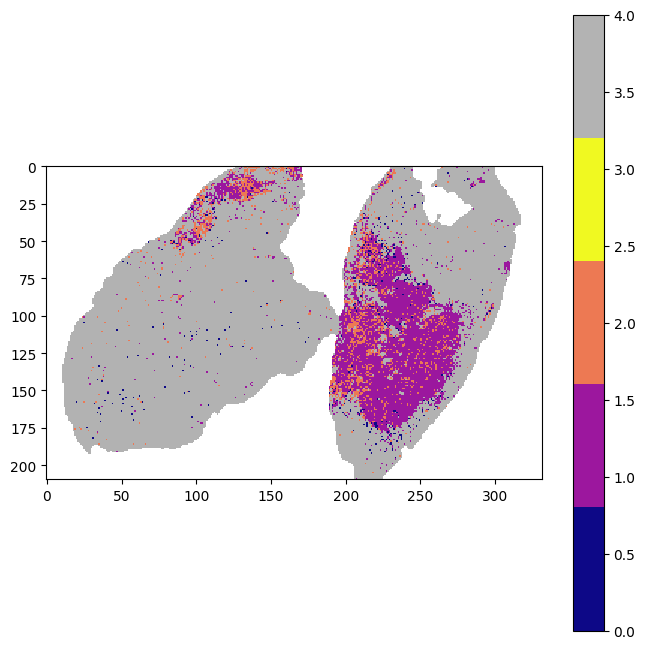

  0%|          | 0/160 [00:00<?, ?it/s]

  2%|▏         | 3/160 [00:01<01:08,  2.30it/s]

  2%|▎         | 4/160 [00:03<02:57,  1.14s/it]

  3%|▎         | 5/160 [00:07<04:58,  1.92s/it]

  4%|▍         | 6/160 [00:10<05:46,  2.25s/it]

  4%|▍         | 7/160 [00:14<07:19,  2.87s/it]

  5%|▌         | 8/160 [00:19<08:37,  3.41s/it]

  6%|▌         | 9/160 [00:24<09:51,  3.92s/it]

  6%|▋         | 10/160 [00:32<12:36,  5.04s/it]

  7%|▋         | 11/160 [00:41<15:30,  6.25s/it]

  8%|▊         | 12/160 [00:50<17:44,  7.19s/it]

  8%|▊         | 13/160 [01:00<19:54,  8.13s/it]

  9%|▉         | 14/160 [01:12<22:05,  9.08s/it]

  9%|▉         | 15/160 [01:24<24:33, 10.17s/it]

 10%|█         | 16/160 [01:39<27:32, 11.48s/it]

 11%|█         | 17/160 [01:52<28:44, 12.06s/it]

 11%|█▏        | 18/160 [02:07<30:19, 12.81s/it]

 12%|█▏        | 19/160 [02:22<31:57, 13.60s/it]

 12%|█▎        | 20/160 [02:38<33:12, 14.23s/it]

 13%|█▎        | 21/160 [02:54<34:19, 14.81s/it]

 14%|█▍        | 22/160 [03:12<36:00, 15.66s/it]

 14%|█▍        | 23/160 [03:29<36:44, 16.09s/it]

 15%|█▌        | 24/160 [03:47<37:53, 16.71s/it]

 16%|█▌        | 25/160 [04:05<38:13, 16.99s/it]

 16%|█▋        | 26/160 [04:24<39:10, 17.54s/it]

 17%|█▋        | 27/160 [04:45<41:14, 18.61s/it]

 18%|█▊        | 28/160 [05:04<41:38, 18.93s/it]

 18%|█▊        | 29/160 [05:25<42:28, 19.46s/it]

 19%|█▉        | 30/160 [05:46<43:03, 19.87s/it]

 19%|█▉        | 31/160 [06:06<43:10, 20.08s/it]

 20%|██        | 32/160 [06:28<44:02, 20.65s/it]

 21%|██        | 33/160 [06:53<46:00, 21.73s/it]

 21%|██▏       | 34/160 [07:18<48:08, 22.93s/it]

 22%|██▏       | 35/160 [07:45<49:57, 23.98s/it]

 22%|██▎       | 36/160 [08:10<50:34, 24.47s/it]

 23%|██▎       | 37/160 [08:37<51:27, 25.11s/it]

 24%|██▍       | 38/160 [09:03<51:17, 25.23s/it]

 24%|██▍       | 39/160 [09:30<52:01, 25.80s/it]

 25%|██▌       | 40/160 [09:57<52:14, 26.12s/it]

 26%|██▌       | 41/160 [10:26<53:55, 27.19s/it]

 26%|██▋       | 42/160 [10:56<54:55, 27.93s/it]

 27%|██▋       | 43/160 [11:26<55:50, 28.64s/it]

 28%|██▊       | 44/160 [11:57<56:31, 29.24s/it]

 28%|██▊       | 45/160 [12:27<56:28, 29.47s/it]

 29%|██▉       | 46/160 [12:56<55:41, 29.31s/it]

 29%|██▉       | 47/160 [13:26<55:37, 29.53s/it]

 30%|███       | 48/160 [13:57<55:56, 29.97s/it]

 31%|███       | 49/160 [14:27<55:48, 30.17s/it]

 31%|███▏      | 50/160 [14:59<55:57, 30.53s/it]

 32%|███▏      | 51/160 [15:30<55:40, 30.65s/it]

 32%|███▎      | 52/160 [16:02<55:57, 31.09s/it]

 33%|███▎      | 53/160 [16:34<56:06, 31.46s/it]

 34%|███▍      | 54/160 [17:06<55:48, 31.59s/it]

 34%|███▍      | 55/160 [17:37<55:09, 31.52s/it]

 35%|███▌      | 56/160 [18:10<54:58, 31.71s/it]

 36%|███▌      | 57/160 [18:42<54:45, 31.90s/it]

 36%|███▋      | 58/160 [19:13<53:34, 31.52s/it]

 37%|███▋      | 59/160 [19:47<54:22, 32.31s/it]

 38%|███▊      | 60/160 [20:20<54:09, 32.49s/it]

 38%|███▊      | 61/160 [20:52<53:46, 32.59s/it]

 39%|███▉      | 62/160 [21:25<53:21, 32.67s/it]

 39%|███▉      | 63/160 [21:58<52:43, 32.61s/it]

 40%|████      | 64/160 [22:30<52:15, 32.66s/it]

 41%|████      | 65/160 [23:02<51:14, 32.36s/it]

 41%|████▏     | 66/160 [23:33<50:03, 31.95s/it]

 42%|████▏     | 67/160 [24:05<49:32, 31.96s/it]

 42%|████▎     | 68/160 [24:43<51:36, 33.66s/it]

 43%|████▎     | 69/160 [25:22<53:43, 35.42s/it]

 44%|████▍     | 70/160 [26:01<54:23, 36.26s/it]

 44%|████▍     | 71/160 [26:41<55:53, 37.68s/it]

 45%|████▌     | 72/160 [27:23<56:46, 38.71s/it]

 46%|████▌     | 73/160 [28:03<56:53, 39.23s/it]

 46%|████▋     | 74/160 [28:44<57:07, 39.85s/it]

 47%|████▋     | 75/160 [29:28<57:52, 40.85s/it]

 48%|████▊     | 76/160 [30:10<57:57, 41.39s/it]

 48%|████▊     | 77/160 [30:52<57:21, 41.46s/it]

 49%|████▉     | 78/160 [31:33<56:45, 41.53s/it]

 49%|████▉     | 79/160 [32:20<57:58, 42.95s/it]

 50%|█████     | 80/160 [33:05<58:05, 43.57s/it]

 51%|█████     | 81/160 [33:49<57:30, 43.68s/it]

 51%|█████▏    | 82/160 [34:34<57:32, 44.26s/it]

 52%|█████▏    | 83/160 [35:20<57:26, 44.76s/it]

 52%|█████▎    | 84/160 [36:08<57:53, 45.71s/it]

 53%|█████▎    | 85/160 [36:55<57:22, 45.90s/it]

 54%|█████▍    | 86/160 [37:40<56:31, 45.83s/it]

 54%|█████▍    | 87/160 [38:27<56:00, 46.04s/it]

 55%|█████▌    | 88/160 [39:18<57:14, 47.70s/it]

 56%|█████▌    | 89/160 [40:05<56:03, 47.38s/it]

 56%|█████▋    | 90/160 [40:53<55:33, 47.61s/it]

 57%|█████▋    | 91/160 [41:42<55:09, 47.97s/it]

 57%|█████▊    | 92/160 [42:29<54:08, 47.78s/it]

 58%|█████▊    | 93/160 [43:18<53:50, 48.21s/it]

 59%|█████▉    | 94/160 [44:07<53:08, 48.31s/it]

 59%|█████▉    | 95/160 [44:56<52:35, 48.54s/it]

 60%|██████    | 96/160 [45:45<52:02, 48.79s/it]

 61%|██████    | 97/160 [46:33<50:58, 48.55s/it]

 61%|██████▏   | 98/160 [47:23<50:35, 48.95s/it]

 62%|██████▏   | 99/160 [48:12<49:43, 48.91s/it]

 62%|██████▎   | 100/160 [49:02<49:20, 49.35s/it]

 63%|██████▎   | 101/160 [49:53<48:45, 49.58s/it]

 64%|██████▍   | 102/160 [50:42<47:59, 49.65s/it]

 64%|██████▍   | 103/160 [51:32<47:17, 49.78s/it]

 65%|██████▌   | 104/160 [52:22<46:26, 49.75s/it]

 66%|██████▌   | 105/160 [53:12<45:34, 49.72s/it]

 66%|██████▋   | 106/160 [54:02<44:49, 49.80s/it]

 67%|██████▋   | 107/160 [54:52<44:12, 50.05s/it]

 68%|██████▊   | 108/160 [55:44<43:44, 50.47s/it]

 68%|██████▊   | 109/160 [56:34<42:41, 50.23s/it]

 69%|██████▉   | 110/160 [57:22<41:30, 49.81s/it]

 69%|██████▉   | 111/160 [58:13<40:45, 49.91s/it]

 70%|███████   | 112/160 [59:03<39:58, 49.96s/it]

 71%|███████   | 113/160 [59:54<39:25, 50.34s/it]

 71%|███████▏  | 114/160 [1:00:45<38:52, 50.71s/it]

 72%|███████▏  | 115/160 [1:01:35<37:41, 50.25s/it]

 72%|███████▎  | 116/160 [1:02:25<36:49, 50.22s/it]

 73%|███████▎  | 117/160 [1:03:16<36:09, 50.45s/it]

 74%|███████▍  | 118/160 [1:04:07<35:31, 50.74s/it]

 74%|███████▍  | 119/160 [1:04:59<34:59, 51.20s/it]

 75%|███████▌  | 120/160 [1:05:46<33:11, 49.80s/it]

 76%|███████▌  | 121/160 [1:06:28<30:54, 47.56s/it]

 76%|███████▋  | 122/160 [1:07:10<28:59, 45.77s/it]

 77%|███████▋  | 123/160 [1:07:50<27:14, 44.17s/it]

 78%|███████▊  | 124/160 [1:08:29<25:28, 42.47s/it]

 78%|███████▊  | 125/160 [1:09:05<23:35, 40.45s/it]

 79%|███████▉  | 126/160 [1:09:36<21:27, 37.88s/it]

 79%|███████▉  | 127/160 [1:10:04<19:06, 34.76s/it]

 80%|████████  | 128/160 [1:10:27<16:38, 31.22s/it]

 81%|████████  | 129/160 [1:10:46<14:12, 27.50s/it]

 81%|████████▏ | 130/160 [1:11:05<12:32, 25.09s/it]

 82%|████████▏ | 131/160 [1:11:23<11:06, 23.00s/it]

 82%|████████▎ | 132/160 [1:11:40<09:49, 21.07s/it]

 83%|████████▎ | 133/160 [1:11:55<08:40, 19.28s/it]

 84%|████████▍ | 134/160 [1:12:09<07:41, 17.77s/it]

 84%|████████▍ | 135/160 [1:12:22<06:45, 16.22s/it]

 85%|████████▌ | 136/160 [1:12:33<05:49, 14.58s/it]

 86%|████████▌ | 137/160 [1:12:44<05:13, 13.62s/it]

 86%|████████▋ | 138/160 [1:12:53<04:32, 12.37s/it]

 87%|████████▋ | 139/160 [1:13:02<03:53, 11.10s/it]

 88%|████████▊ | 140/160 [1:13:08<03:12,  9.63s/it]

 88%|████████▊ | 141/160 [1:13:14<02:43,  8.62s/it]

 89%|████████▉ | 142/160 [1:13:19<02:13,  7.42s/it]

 89%|████████▉ | 143/160 [1:13:22<01:46,  6.26s/it]

 90%|█████████ | 144/160 [1:13:25<01:24,  5.29s/it]

 91%|█████████ | 145/160 [1:13:28<01:06,  4.46s/it]

 91%|█████████▏| 146/160 [1:13:30<00:52,  3.73s/it]

 92%|█████████▏| 147/160 [1:13:31<00:39,  3.06s/it]

100%|██████████| 160/160 [1:13:31<00:00, 27.57s/it]

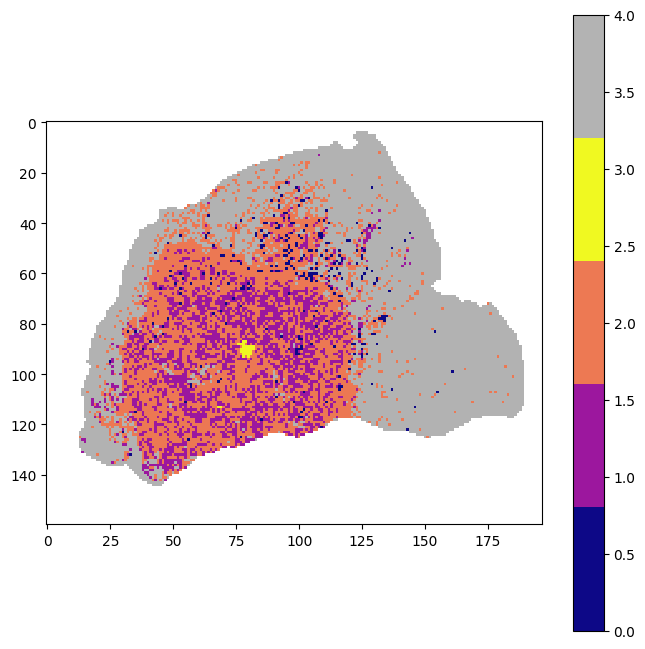

  0%|          | 0/117 [00:00<?, ?it/s]

  3%|▎         | 3/117 [00:01<01:14,  1.52it/s]

  3%|▎         | 4/117 [00:04<02:13,  1.18s/it]

  4%|▍         | 5/117 [00:06<02:57,  1.58s/it]

  5%|▌         | 6/117 [00:09<03:24,  1.84s/it]

  6%|▌         | 7/117 [00:11<03:49,  2.08s/it]

  7%|▋         | 8/117 [00:14<04:04,  2.24s/it]

  8%|▊         | 9/117 [00:17<04:19,  2.40s/it]

  9%|▊         | 10/117 [00:20<04:53,  2.75s/it]

  9%|▉         | 11/117 [00:24<05:21,  3.03s/it]

 10%|█         | 12/117 [00:31<07:36,  4.35s/it]

 11%|█         | 13/117 [00:38<08:53,  5.13s/it]

 12%|█▏        | 14/117 [00:48<11:10,  6.51s/it]

 13%|█▎        | 15/117 [01:00<13:59,  8.23s/it]

 14%|█▎        | 16/117 [01:14<16:55, 10.05s/it]

 15%|█▍        | 17/117 [01:30<19:43, 11.84s/it]

 15%|█▌        | 18/117 [01:49<23:01, 13.95s/it]

 16%|█▌        | 19/117 [02:08<24:52, 15.23s/it]

 17%|█▋        | 20/117 [02:27<26:49, 16.60s/it]

 18%|█▊        | 21/117 [02:48<28:28, 17.80s/it]

 19%|█▉        | 22/117 [03:09<29:47, 18.82s/it]

 20%|█▉        | 23/117 [03:30<30:32, 19.50s/it]

 21%|██        | 24/117 [03:51<30:58, 19.98s/it]

 21%|██▏       | 25/117 [04:13<31:15, 20.38s/it]

 22%|██▏       | 26/117 [04:35<31:35, 20.83s/it]

 23%|██▎       | 27/117 [04:57<31:53, 21.26s/it]

 24%|██▍       | 28/117 [05:20<32:20, 21.80s/it]

 25%|██▍       | 29/117 [05:43<32:36, 22.24s/it]

 26%|██▌       | 30/117 [06:06<32:28, 22.40s/it]

 26%|██▋       | 31/117 [06:29<32:37, 22.76s/it]

 27%|██▋       | 32/117 [06:54<32:51, 23.20s/it]

 28%|██▊       | 33/117 [07:19<33:14, 23.74s/it]

 29%|██▉       | 34/117 [07:43<33:07, 23.95s/it]

 30%|██▉       | 35/117 [08:07<32:33, 23.83s/it]

 31%|███       | 36/117 [08:30<31:53, 23.62s/it]

 32%|███▏      | 37/117 [08:54<31:51, 23.90s/it]

 32%|███▏      | 38/117 [09:19<31:36, 24.01s/it]

 33%|███▎      | 39/117 [09:43<31:10, 23.98s/it]

 34%|███▍      | 40/117 [10:07<30:50, 24.03s/it]

 35%|███▌      | 41/117 [10:31<30:40, 24.22s/it]

 36%|███▌      | 42/117 [10:55<30:03, 24.05s/it]

 37%|███▋      | 43/117 [11:20<30:01, 24.35s/it]

 38%|███▊      | 44/117 [11:46<30:03, 24.70s/it]

 38%|███▊      | 45/117 [12:13<30:40, 25.56s/it]

 39%|███▉      | 46/117 [12:41<30:55, 26.14s/it]

 40%|████      | 47/117 [13:07<30:44, 26.34s/it]

 41%|████      | 48/117 [13:34<30:24, 26.44s/it]

 42%|████▏     | 49/117 [14:01<30:00, 26.47s/it]

 43%|████▎     | 50/117 [14:27<29:35, 26.50s/it]

 44%|████▎     | 51/117 [14:53<28:53, 26.27s/it]

 44%|████▍     | 52/117 [15:20<28:38, 26.45s/it]

 45%|████▌     | 53/117 [15:46<28:12, 26.44s/it]

 46%|████▌     | 54/117 [16:14<28:08, 26.81s/it]

 47%|████▋     | 55/117 [16:43<28:25, 27.51s/it]

 48%|████▊     | 56/117 [17:12<28:24, 27.95s/it]

 49%|████▊     | 57/117 [17:42<28:36, 28.62s/it]

 50%|████▉     | 58/117 [18:12<28:25, 28.91s/it]

 50%|█████     | 59/117 [18:42<28:26, 29.42s/it]

 51%|█████▏    | 60/117 [19:13<28:18, 29.80s/it]

 52%|█████▏    | 61/117 [19:44<28:08, 30.15s/it]

 53%|█████▎    | 62/117 [20:15<27:44, 30.27s/it]

 54%|█████▍    | 63/117 [20:45<27:20, 30.39s/it]

 55%|█████▍    | 64/117 [21:14<26:30, 30.01s/it]

 56%|█████▌    | 65/117 [21:43<25:39, 29.60s/it]

 56%|█████▋    | 66/117 [22:11<24:48, 29.18s/it]

 57%|█████▋    | 67/117 [22:39<24:03, 28.88s/it]

 58%|█████▊    | 68/117 [23:08<23:26, 28.70s/it]

 59%|█████▉    | 69/117 [23:40<23:47, 29.74s/it]

 60%|█████▉    | 70/117 [24:11<23:31, 30.03s/it]

 61%|██████    | 71/117 [24:39<22:44, 29.66s/it]

 62%|██████▏   | 72/117 [25:05<21:26, 28.59s/it]

 62%|██████▏   | 73/117 [25:31<20:22, 27.78s/it]

 63%|██████▎   | 74/117 [25:56<19:18, 26.95s/it]

 64%|██████▍   | 75/117 [26:21<18:18, 26.16s/it]

 65%|██████▍   | 76/117 [26:45<17:23, 25.46s/it]

 66%|██████▌   | 77/117 [27:07<16:21, 24.55s/it]

 67%|██████▋   | 78/117 [27:31<15:47, 24.29s/it]

 68%|██████▊   | 79/117 [27:54<15:15, 24.09s/it]

 68%|██████▊   | 80/117 [28:17<14:34, 23.64s/it]

 69%|██████▉   | 81/117 [28:40<14:04, 23.45s/it]

 70%|███████   | 82/117 [29:03<13:36, 23.33s/it]

 71%|███████   | 83/117 [29:25<12:56, 22.83s/it]

 72%|███████▏  | 84/117 [29:46<12:21, 22.46s/it]

 73%|███████▎  | 85/117 [30:08<11:56, 22.40s/it]

 74%|███████▎  | 86/117 [30:32<11:49, 22.90s/it]

 74%|███████▍  | 87/117 [30:55<11:23, 22.80s/it]

 75%|███████▌  | 88/117 [31:16<10:47, 22.34s/it]

 76%|███████▌  | 89/117 [31:37<10:11, 21.83s/it]

 77%|███████▋  | 90/117 [31:57<09:38, 21.44s/it]

 78%|███████▊  | 91/117 [32:17<09:04, 20.96s/it]

 79%|███████▊  | 92/117 [32:39<08:47, 21.11s/it]

 79%|███████▉  | 93/117 [33:00<08:30, 21.27s/it]

 80%|████████  | 94/117 [33:20<08:00, 20.90s/it]

 81%|████████  | 95/117 [33:40<07:30, 20.50s/it]

 82%|████████▏ | 96/117 [34:00<07:10, 20.48s/it]

 83%|████████▎ | 97/117 [34:18<06:29, 19.46s/it]

 84%|████████▍ | 98/117 [34:36<06:04, 19.16s/it]

 85%|████████▍ | 99/117 [34:52<05:28, 18.27s/it]

 85%|████████▌ | 100/117 [35:08<04:55, 17.39s/it]

 86%|████████▋ | 101/117 [35:22<04:23, 16.45s/it]

 87%|████████▋ | 102/117 [35:35<03:52, 15.50s/it]

 88%|████████▊ | 103/117 [35:46<03:19, 14.24s/it]

 89%|████████▉ | 104/117 [35:57<02:52, 13.29s/it]

 90%|████████▉ | 105/117 [36:07<02:25, 12.10s/it]

 91%|█████████ | 106/117 [36:15<01:59, 10.87s/it]

 91%|█████████▏| 107/117 [36:22<01:38,  9.83s/it]

 92%|█████████▏| 108/117 [36:28<01:18,  8.69s/it]

 93%|█████████▎| 109/117 [36:33<01:00,  7.62s/it]

 94%|█████████▍| 110/117 [36:37<00:45,  6.52s/it]

100%|██████████| 117/117 [36:37<00:00, 18.78s/it]

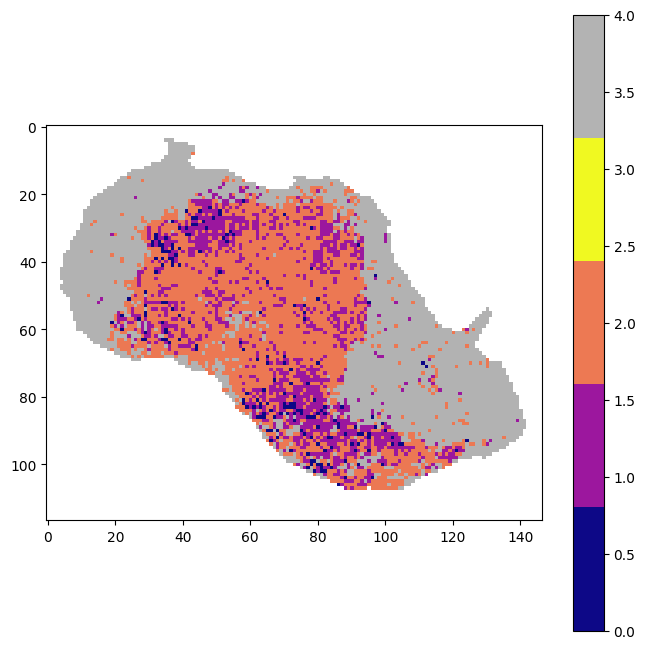

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:16<52:39, 16.20s/it]

  1%|          | 2/196 [00:30<48:31, 15.01s/it]

  2%|▏         | 3/196 [00:44<47:14, 14.69s/it]

  2%|▏         | 4/196 [01:02<50:59, 15.93s/it]

  3%|▎         | 5/196 [01:28<1:02:36, 19.67s/it]

  3%|▎         | 6/196 [01:57<1:11:51, 22.69s/it]

  4%|▎         | 7/196 [02:25<1:17:11, 24.50s/it]

  4%|▍         | 8/196 [02:55<1:22:35, 26.36s/it]

  5%|▍         | 9/196 [03:28<1:28:19, 28.34s/it]

  5%|▌         | 10/196 [03:58<1:29:07, 28.75s/it]

  6%|▌         | 11/196 [04:30<1:31:32, 29.69s/it]

  6%|▌         | 12/196 [05:01<1:33:04, 30.35s/it]

  7%|▋         | 13/196 [05:32<1:32:44, 30.40s/it]

  7%|▋         | 14/196 [06:04<1:33:15, 30.74s/it]

  8%|▊         | 15/196 [06:39<1:36:46, 32.08s/it]

  8%|▊         | 16/196 [07:13<1:38:04, 32.69s/it]

  9%|▊         | 17/196 [07:46<1:38:22, 32.97s/it]

  9%|▉         | 18/196 [08:19<1:37:36, 32.90s/it]

 10%|▉         | 19/196 [08:52<1:37:18, 32.98s/it]

 10%|█         | 20/196 [09:26<1:37:10, 33.13s/it]

 11%|█         | 21/196 [09:59<1:36:24, 33.06s/it]

 11%|█         | 22/196 [10:32<1:36:26, 33.26s/it]

 12%|█▏        | 23/196 [11:06<1:35:54, 33.27s/it]

 12%|█▏        | 24/196 [11:38<1:34:22, 32.92s/it]

 13%|█▎        | 25/196 [12:10<1:32:58, 32.62s/it]

 13%|█▎        | 26/196 [12:42<1:32:27, 32.63s/it]

 14%|█▍        | 27/196 [13:15<1:31:31, 32.49s/it]

 14%|█▍        | 28/196 [13:47<1:31:02, 32.51s/it]

 15%|█▍        | 29/196 [14:20<1:30:50, 32.64s/it]

 15%|█▌        | 30/196 [14:54<1:31:33, 33.09s/it]

 16%|█▌        | 31/196 [15:26<1:30:01, 32.74s/it]

 16%|█▋        | 32/196 [15:56<1:26:46, 31.75s/it]

 17%|█▋        | 33/196 [16:24<1:23:13, 30.64s/it]

 17%|█▋        | 34/196 [16:53<1:22:01, 30.38s/it]

 18%|█▊        | 35/196 [17:22<1:19:54, 29.78s/it]

 18%|█▊        | 36/196 [17:49<1:17:37, 29.11s/it]

 19%|█▉        | 37/196 [18:17<1:16:19, 28.80s/it]

 19%|█▉        | 38/196 [18:44<1:14:27, 28.27s/it]

 20%|█▉        | 39/196 [19:11<1:12:17, 27.63s/it]

 20%|██        | 40/196 [19:37<1:10:55, 27.28s/it]

 21%|██        | 41/196 [20:04<1:09:51, 27.04s/it]

 21%|██▏       | 42/196 [20:27<1:06:49, 26.04s/it]

 22%|██▏       | 43/196 [20:50<1:04:15, 25.20s/it]

 22%|██▏       | 44/196 [21:13<1:01:54, 24.44s/it]

 23%|██▎       | 45/196 [21:37<1:00:51, 24.18s/it]

 23%|██▎       | 46/196 [22:01<1:00:33, 24.22s/it]

 24%|██▍       | 47/196 [22:26<1:01:01, 24.57s/it]

 24%|██▍       | 48/196 [22:52<1:01:31, 24.94s/it]

 25%|██▌       | 49/196 [23:18<1:01:41, 25.18s/it]

 26%|██▌       | 50/196 [23:45<1:02:44, 25.78s/it]

 26%|██▌       | 51/196 [24:15<1:04:53, 26.85s/it]

 27%|██▋       | 52/196 [24:45<1:07:11, 28.00s/it]

 27%|██▋       | 53/196 [25:16<1:09:04, 28.98s/it]

 28%|██▊       | 54/196 [25:49<1:10:51, 29.94s/it]

 28%|██▊       | 55/196 [26:24<1:14:13, 31.59s/it]

 29%|██▊       | 56/196 [27:00<1:16:56, 32.97s/it]

 29%|██▉       | 57/196 [27:38<1:20:00, 34.54s/it]

 30%|██▉       | 58/196 [28:18<1:22:41, 35.95s/it]

 30%|███       | 59/196 [28:57<1:24:29, 37.00s/it]

 31%|███       | 60/196 [29:36<1:24:53, 37.45s/it]

 31%|███       | 61/196 [30:16<1:26:21, 38.38s/it]

 32%|███▏      | 62/196 [30:57<1:27:35, 39.22s/it]

 32%|███▏      | 63/196 [31:39<1:28:23, 39.88s/it]

 33%|███▎      | 64/196 [32:20<1:28:41, 40.32s/it]

 33%|███▎      | 65/196 [33:00<1:27:26, 40.05s/it]

 34%|███▎      | 66/196 [33:41<1:27:43, 40.49s/it]

 34%|███▍      | 67/196 [34:20<1:26:14, 40.11s/it]

 35%|███▍      | 68/196 [35:03<1:26:54, 40.74s/it]

 35%|███▌      | 69/196 [35:45<1:27:07, 41.16s/it]

 36%|███▌      | 70/196 [36:26<1:26:41, 41.28s/it]

 36%|███▌      | 71/196 [37:07<1:25:22, 40.98s/it]

 37%|███▋      | 72/196 [37:48<1:25:05, 41.17s/it]

 37%|███▋      | 73/196 [38:28<1:23:54, 40.93s/it]

 38%|███▊      | 74/196 [39:11<1:24:05, 41.35s/it]

 38%|███▊      | 75/196 [39:55<1:24:54, 42.10s/it]

 39%|███▉      | 76/196 [40:37<1:24:19, 42.16s/it]

 39%|███▉      | 77/196 [41:18<1:23:00, 41.85s/it]

 40%|███▉      | 78/196 [42:00<1:22:03, 41.73s/it]

 40%|████      | 79/196 [42:44<1:22:47, 42.46s/it]

 41%|████      | 80/196 [43:28<1:23:14, 43.05s/it]

 41%|████▏     | 81/196 [44:14<1:24:09, 43.91s/it]

 42%|████▏     | 82/196 [45:00<1:24:49, 44.64s/it]

 42%|████▏     | 83/196 [45:46<1:24:36, 44.93s/it]

 43%|████▎     | 84/196 [46:31<1:23:47, 44.89s/it]

 43%|████▎     | 85/196 [47:17<1:23:33, 45.16s/it]

 44%|████▍     | 86/196 [48:02<1:22:42, 45.12s/it]

 44%|████▍     | 87/196 [48:47<1:22:03, 45.17s/it]

 45%|████▍     | 88/196 [49:32<1:21:08, 45.08s/it]

 45%|████▌     | 89/196 [50:16<1:20:10, 44.96s/it]

 46%|████▌     | 90/196 [51:00<1:18:35, 44.49s/it]

 46%|████▋     | 91/196 [51:46<1:18:51, 45.07s/it]

 47%|████▋     | 92/196 [52:33<1:18:54, 45.53s/it]

 47%|████▋     | 93/196 [53:18<1:17:50, 45.34s/it]

 48%|████▊     | 94/196 [54:03<1:17:02, 45.32s/it]

 48%|████▊     | 95/196 [54:48<1:15:58, 45.13s/it]

 49%|████▉     | 96/196 [55:32<1:14:45, 44.86s/it]

 49%|████▉     | 97/196 [56:18<1:14:42, 45.28s/it]

 50%|█████     | 98/196 [57:03<1:13:39, 45.10s/it]

 51%|█████     | 99/196 [57:50<1:13:39, 45.56s/it]

 51%|█████     | 100/196 [58:36<1:13:12, 45.76s/it]

 52%|█████▏    | 101/196 [59:23<1:13:11, 46.23s/it]

 52%|█████▏    | 102/196 [1:00:09<1:12:13, 46.10s/it]

 53%|█████▎    | 103/196 [1:00:53<1:10:24, 45.42s/it]

 53%|█████▎    | 104/196 [1:01:38<1:09:34, 45.37s/it]

 54%|█████▎    | 105/196 [1:02:25<1:09:28, 45.81s/it]

 54%|█████▍    | 106/196 [1:03:10<1:08:32, 45.69s/it]

 55%|█████▍    | 107/196 [1:03:54<1:07:04, 45.22s/it]

 55%|█████▌    | 108/196 [1:04:39<1:05:58, 44.99s/it]

 56%|█████▌    | 109/196 [1:05:24<1:05:07, 44.91s/it]

 56%|█████▌    | 110/196 [1:06:08<1:04:10, 44.78s/it]

 57%|█████▋    | 111/196 [1:06:53<1:03:34, 44.87s/it]

 57%|█████▋    | 112/196 [1:07:40<1:03:31, 45.37s/it]

 58%|█████▊    | 113/196 [1:08:24<1:02:09, 44.93s/it]

 58%|█████▊    | 114/196 [1:09:08<1:01:25, 44.94s/it]

 59%|█████▊    | 115/196 [1:09:54<1:00:42, 44.97s/it]

 59%|█████▉    | 116/196 [1:10:39<1:00:10, 45.13s/it]

 60%|█████▉    | 117/196 [1:11:24<59:22, 45.09s/it]  

 60%|██████    | 118/196 [1:12:09<58:29, 45.00s/it]

 61%|██████    | 119/196 [1:12:53<57:18, 44.66s/it]

 61%|██████    | 120/196 [1:13:37<56:28, 44.58s/it]

 62%|██████▏   | 121/196 [1:14:23<56:13, 44.98s/it]

 62%|██████▏   | 122/196 [1:15:07<54:57, 44.56s/it]

 63%|██████▎   | 123/196 [1:15:52<54:38, 44.91s/it]

 63%|██████▎   | 124/196 [1:16:37<53:41, 44.75s/it]

 64%|██████▍   | 125/196 [1:17:21<52:54, 44.71s/it]

 64%|██████▍   | 126/196 [1:18:05<51:55, 44.51s/it]

 65%|██████▍   | 127/196 [1:18:50<51:06, 44.44s/it]

 65%|██████▌   | 128/196 [1:19:33<50:06, 44.21s/it]

 66%|██████▌   | 129/196 [1:20:18<49:38, 44.45s/it]

 66%|██████▋   | 130/196 [1:21:02<48:44, 44.31s/it]

 67%|██████▋   | 131/196 [1:21:46<47:46, 44.10s/it]

 67%|██████▋   | 132/196 [1:22:29<46:47, 43.87s/it]

 68%|██████▊   | 133/196 [1:23:11<45:33, 43.39s/it]

 68%|██████▊   | 134/196 [1:23:52<43:57, 42.54s/it]

 69%|██████▉   | 135/196 [1:24:34<43:06, 42.41s/it]

 69%|██████▉   | 136/196 [1:25:16<42:07, 42.13s/it]

 70%|██████▉   | 137/196 [1:25:56<40:51, 41.55s/it]

 70%|███████   | 138/196 [1:26:34<39:08, 40.50s/it]

 71%|███████   | 139/196 [1:27:14<38:24, 40.43s/it]

 71%|███████▏  | 140/196 [1:27:52<37:05, 39.74s/it]

 72%|███████▏  | 141/196 [1:28:31<36:13, 39.52s/it]

 72%|███████▏  | 142/196 [1:29:10<35:18, 39.23s/it]

 73%|███████▎  | 143/196 [1:29:46<33:52, 38.35s/it]

 73%|███████▎  | 144/196 [1:30:21<32:25, 37.40s/it]

 74%|███████▍  | 145/196 [1:30:57<31:13, 36.74s/it]

 74%|███████▍  | 146/196 [1:31:31<30:09, 36.19s/it]

 75%|███████▌  | 147/196 [1:32:07<29:26, 36.05s/it]

 76%|███████▌  | 148/196 [1:32:43<28:42, 35.89s/it]

 76%|███████▌  | 149/196 [1:33:18<27:59, 35.73s/it]

 77%|███████▋  | 150/196 [1:33:51<26:44, 34.88s/it]

 77%|███████▋  | 151/196 [1:34:25<26:00, 34.67s/it]

 78%|███████▊  | 152/196 [1:35:01<25:45, 35.12s/it]

 78%|███████▊  | 153/196 [1:35:36<25:06, 35.03s/it]

 79%|███████▊  | 154/196 [1:36:11<24:29, 34.99s/it]

 79%|███████▉  | 155/196 [1:36:45<23:43, 34.71s/it]

 80%|███████▉  | 156/196 [1:37:17<22:33, 33.83s/it]

 80%|████████  | 157/196 [1:37:50<21:49, 33.58s/it]

 81%|████████  | 158/196 [1:38:21<20:45, 32.79s/it]

 81%|████████  | 159/196 [1:38:49<19:27, 31.55s/it]

 82%|████████▏ | 160/196 [1:39:17<18:12, 30.36s/it]

 82%|████████▏ | 161/196 [1:39:45<17:15, 29.58s/it]

 83%|████████▎ | 162/196 [1:40:11<16:14, 28.68s/it]

 83%|████████▎ | 163/196 [1:40:37<15:18, 27.83s/it]

 84%|████████▎ | 164/196 [1:41:04<14:39, 27.47s/it]

 84%|████████▍ | 165/196 [1:41:29<13:46, 26.65s/it]

 85%|████████▍ | 166/196 [1:41:52<12:50, 25.68s/it]

 85%|████████▌ | 167/196 [1:42:17<12:16, 25.38s/it]

 86%|████████▌ | 168/196 [1:42:40<11:37, 24.93s/it]

 86%|████████▌ | 169/196 [1:43:04<11:00, 24.45s/it]

 87%|████████▋ | 170/196 [1:43:26<10:16, 23.70s/it]

 87%|████████▋ | 171/196 [1:43:46<09:28, 22.75s/it]

 88%|████████▊ | 172/196 [1:44:07<08:51, 22.15s/it]

 88%|████████▊ | 173/196 [1:44:27<08:11, 21.37s/it]

 89%|████████▉ | 174/196 [1:44:46<07:39, 20.90s/it]

 89%|████████▉ | 175/196 [1:45:05<07:03, 20.18s/it]

 90%|████████▉ | 176/196 [1:45:22<06:26, 19.34s/it]

 90%|█████████ | 177/196 [1:45:38<05:44, 18.11s/it]

 91%|█████████ | 178/196 [1:45:52<05:06, 17.02s/it]

 91%|█████████▏| 179/196 [1:46:04<04:24, 15.56s/it]

 92%|█████████▏| 180/196 [1:46:17<03:54, 14.63s/it]

 92%|█████████▏| 181/196 [1:46:28<03:23, 13.56s/it]

 93%|█████████▎| 182/196 [1:46:39<02:59, 12.83s/it]

 93%|█████████▎| 183/196 [1:46:49<02:36, 12.02s/it]

 94%|█████████▍| 184/196 [1:46:57<02:10, 10.90s/it]

 94%|█████████▍| 185/196 [1:47:05<01:50, 10.09s/it]

 95%|█████████▍| 186/196 [1:47:13<01:33,  9.35s/it]

 95%|█████████▌| 187/196 [1:47:19<01:14,  8.31s/it]

 96%|█████████▌| 188/196 [1:47:24<00:58,  7.26s/it]

 96%|█████████▋| 189/196 [1:47:27<00:41,  5.98s/it]

 97%|█████████▋| 190/196 [1:47:30<00:30,  5.01s/it]

 97%|█████████▋| 191/196 [1:47:32<00:21,  4.30s/it]

 98%|█████████▊| 192/196 [1:47:34<00:13,  3.49s/it]

100%|██████████| 196/196 [1:47:34<00:00, 32.93s/it]

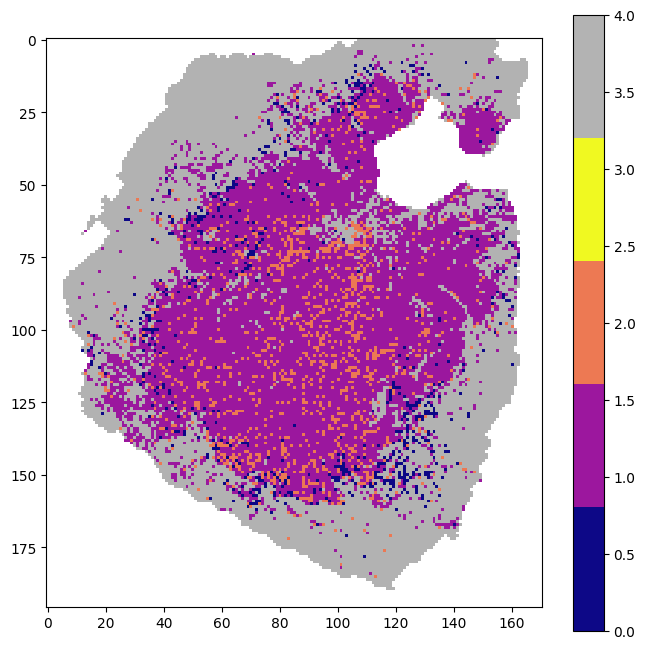

  0%|          | 0/183 [00:00<?, ?it/s]

  1%|          | 2/183 [00:03<05:41,  1.89s/it]

  2%|▏         | 3/183 [00:12<13:48,  4.60s/it]

  2%|▏         | 4/183 [00:22<20:26,  6.85s/it]

  3%|▎         | 5/183 [00:33<24:38,  8.31s/it]

  3%|▎         | 6/183 [00:46<28:56,  9.81s/it]

  4%|▍         | 7/183 [01:00<32:59, 11.25s/it]

  4%|▍         | 8/183 [01:15<35:45, 12.26s/it]

  5%|▍         | 9/183 [01:31<39:13, 13.53s/it]

  5%|▌         | 10/183 [01:49<43:05, 14.94s/it]

  6%|▌         | 11/183 [02:10<47:49, 16.69s/it]

  7%|▋         | 12/183 [02:29<49:54, 17.51s/it]

  7%|▋         | 13/183 [02:50<52:34, 18.56s/it]

  8%|▊         | 14/183 [03:13<55:46, 19.80s/it]

  8%|▊         | 15/183 [03:36<58:04, 20.74s/it]

  9%|▊         | 16/183 [04:01<1:00:55, 21.89s/it]

  9%|▉         | 17/183 [04:24<1:01:58, 22.40s/it]

 10%|▉         | 18/183 [04:49<1:03:59, 23.27s/it]

 10%|█         | 19/183 [05:14<1:04:59, 23.78s/it]

 11%|█         | 20/183 [05:40<1:05:54, 24.26s/it]

 11%|█▏        | 21/183 [06:07<1:07:41, 25.07s/it]

 12%|█▏        | 22/183 [06:34<1:09:18, 25.83s/it]

 13%|█▎        | 23/183 [07:02<1:10:35, 26.47s/it]

 13%|█▎        | 24/183 [07:30<1:11:07, 26.84s/it]

 14%|█▎        | 25/183 [07:58<1:11:56, 27.32s/it]

 14%|█▍        | 26/183 [08:27<1:12:03, 27.54s/it]

 15%|█▍        | 27/183 [08:56<1:13:23, 28.23s/it]

 15%|█▌        | 28/183 [09:28<1:15:45, 29.33s/it]

 16%|█▌        | 29/183 [10:00<1:17:04, 30.03s/it]

 16%|█▋        | 30/183 [10:30<1:16:47, 30.11s/it]

 17%|█▋        | 31/183 [11:02<1:17:12, 30.48s/it]

 17%|█▋        | 32/183 [11:33<1:17:41, 30.87s/it]

 18%|█▊        | 33/183 [12:05<1:17:49, 31.13s/it]

 19%|█▊        | 34/183 [12:37<1:18:10, 31.48s/it]

 19%|█▉        | 35/183 [13:11<1:19:04, 32.06s/it]

 20%|█▉        | 36/183 [13:44<1:19:32, 32.47s/it]

 20%|██        | 37/183 [14:18<1:20:02, 32.90s/it]

 21%|██        | 38/183 [14:53<1:20:48, 33.44s/it]

 21%|██▏       | 39/183 [15:29<1:22:29, 34.37s/it]

 22%|██▏       | 40/183 [16:06<1:23:45, 35.14s/it]

 22%|██▏       | 41/183 [16:44<1:25:08, 35.97s/it]

 23%|██▎       | 42/183 [17:20<1:24:41, 36.04s/it]

 23%|██▎       | 43/183 [17:59<1:26:02, 36.87s/it]

 24%|██▍       | 44/183 [18:37<1:26:13, 37.22s/it]

 25%|██▍       | 45/183 [19:15<1:25:53, 37.34s/it]

 25%|██▌       | 46/183 [19:53<1:25:27, 37.43s/it]

 26%|██▌       | 47/183 [20:31<1:25:28, 37.71s/it]

 26%|██▌       | 48/183 [21:11<1:26:42, 38.54s/it]

 27%|██▋       | 49/183 [21:49<1:25:43, 38.38s/it]

 27%|██▋       | 50/183 [22:28<1:25:30, 38.57s/it]

 28%|██▊       | 51/183 [23:08<1:25:27, 38.84s/it]

 28%|██▊       | 52/183 [23:49<1:26:18, 39.53s/it]

 29%|██▉       | 53/183 [24:28<1:25:16, 39.35s/it]

 30%|██▉       | 54/183 [25:06<1:23:45, 38.96s/it]

 30%|███       | 55/183 [25:46<1:23:40, 39.22s/it]

 31%|███       | 56/183 [26:27<1:24:33, 39.95s/it]

 31%|███       | 57/183 [27:09<1:24:41, 40.33s/it]

 32%|███▏      | 58/183 [27:49<1:23:58, 40.31s/it]

 32%|███▏      | 59/183 [28:30<1:23:31, 40.42s/it]

 33%|███▎      | 60/183 [29:11<1:23:40, 40.82s/it]

 33%|███▎      | 61/183 [29:53<1:23:38, 41.14s/it]

 34%|███▍      | 62/183 [30:36<1:23:42, 41.51s/it]

 34%|███▍      | 63/183 [31:19<1:24:01, 42.01s/it]

 35%|███▍      | 64/183 [32:02<1:24:06, 42.41s/it]

 36%|███▌      | 65/183 [32:46<1:24:15, 42.84s/it]

 36%|███▌      | 66/183 [33:30<1:24:18, 43.24s/it]

 37%|███▋      | 67/183 [34:15<1:24:37, 43.77s/it]

 37%|███▋      | 68/183 [35:00<1:24:46, 44.23s/it]

 38%|███▊      | 69/183 [35:46<1:24:38, 44.55s/it]

 38%|███▊      | 70/183 [36:30<1:23:52, 44.54s/it]

 39%|███▉      | 71/183 [37:16<1:24:03, 45.03s/it]

 39%|███▉      | 72/183 [38:03<1:24:00, 45.41s/it]

 40%|███▉      | 73/183 [38:48<1:23:15, 45.41s/it]

 40%|████      | 74/183 [39:33<1:22:24, 45.37s/it]

 41%|████      | 75/183 [40:19<1:21:56, 45.52s/it]

 42%|████▏     | 76/183 [41:05<1:21:29, 45.70s/it]

 42%|████▏     | 77/183 [41:53<1:21:58, 46.40s/it]

 43%|████▎     | 78/183 [42:42<1:22:28, 47.13s/it]

 43%|████▎     | 79/183 [43:29<1:21:28, 47.00s/it]

 44%|████▎     | 80/183 [44:17<1:21:04, 47.23s/it]

 44%|████▍     | 81/183 [45:04<1:20:03, 47.09s/it]

 45%|████▍     | 82/183 [45:53<1:20:25, 47.78s/it]

 45%|████▌     | 83/183 [46:41<1:19:54, 47.94s/it]

 46%|████▌     | 84/183 [47:31<1:19:53, 48.42s/it]

 46%|████▋     | 85/183 [48:20<1:19:14, 48.52s/it]

 47%|████▋     | 86/183 [49:10<1:19:11, 48.99s/it]

 48%|████▊     | 87/183 [50:01<1:19:39, 49.78s/it]

 48%|████▊     | 88/183 [50:51<1:18:47, 49.76s/it]

 49%|████▊     | 89/183 [51:41<1:18:07, 49.87s/it]

 49%|████▉     | 90/183 [52:29<1:16:34, 49.41s/it]

 50%|████▉     | 91/183 [53:21<1:16:51, 50.13s/it]

 50%|█████     | 92/183 [54:13<1:16:33, 50.48s/it]

 51%|█████     | 93/183 [55:04<1:16:15, 50.84s/it]

 51%|█████▏    | 94/183 [55:57<1:16:05, 51.30s/it]

 52%|█████▏    | 95/183 [56:50<1:15:57, 51.79s/it]

 52%|█████▏    | 96/183 [57:41<1:15:03, 51.76s/it]

 53%|█████▎    | 97/183 [58:34<1:14:25, 51.92s/it]

 54%|█████▎    | 98/183 [59:26<1:13:41, 52.02s/it]

 54%|█████▍    | 99/183 [1:00:19<1:13:21, 52.40s/it]

 55%|█████▍    | 100/183 [1:01:12<1:12:33, 52.45s/it]

 55%|█████▌    | 101/183 [1:02:05<1:12:10, 52.81s/it]

 56%|█████▌    | 102/183 [1:02:58<1:11:15, 52.79s/it]

 56%|█████▋    | 103/183 [1:03:51<1:10:20, 52.75s/it]

 57%|█████▋    | 104/183 [1:04:45<1:10:08, 53.27s/it]

 57%|█████▋    | 105/183 [1:05:37<1:08:46, 52.90s/it]

 58%|█████▊    | 106/183 [1:06:30<1:07:59, 52.97s/it]

 58%|█████▊    | 107/183 [1:07:25<1:07:51, 53.57s/it]

 59%|█████▉    | 108/183 [1:08:20<1:07:28, 53.98s/it]

 60%|█████▉    | 109/183 [1:09:18<1:07:50, 55.00s/it]

 60%|██████    | 110/183 [1:10:13<1:07:03, 55.12s/it]

 61%|██████    | 111/183 [1:11:10<1:06:50, 55.69s/it]

 61%|██████    | 112/183 [1:12:06<1:06:07, 55.88s/it]

 62%|██████▏   | 113/183 [1:13:02<1:05:01, 55.74s/it]

 62%|██████▏   | 114/183 [1:13:58<1:04:20, 55.95s/it]

 63%|██████▎   | 115/183 [1:14:55<1:03:46, 56.27s/it]

 63%|██████▎   | 116/183 [1:15:54<1:03:34, 56.93s/it]

 64%|██████▍   | 117/183 [1:16:52<1:03:10, 57.43s/it]

 64%|██████▍   | 118/183 [1:17:50<1:02:19, 57.52s/it]

 65%|██████▌   | 119/183 [1:18:49<1:01:55, 58.05s/it]

 66%|██████▌   | 120/183 [1:19:46<1:00:37, 57.73s/it]

 66%|██████▌   | 121/183 [1:20:43<59:25, 57.51s/it]  

 67%|██████▋   | 122/183 [1:21:39<58:01, 57.07s/it]

 67%|██████▋   | 123/183 [1:22:38<57:36, 57.61s/it]

 68%|██████▊   | 124/183 [1:23:36<56:50, 57.80s/it]

 68%|██████▊   | 125/183 [1:24:34<55:56, 57.87s/it]

 69%|██████▉   | 126/183 [1:25:33<55:09, 58.07s/it]

 69%|██████▉   | 127/183 [1:26:30<53:53, 57.74s/it]

 70%|██████▉   | 128/183 [1:27:29<53:15, 58.10s/it]

 70%|███████   | 129/183 [1:28:25<51:41, 57.44s/it]

 71%|███████   | 130/183 [1:29:23<50:59, 57.73s/it]

 72%|███████▏  | 131/183 [1:30:19<49:23, 56.99s/it]

 72%|███████▏  | 132/183 [1:31:14<48:10, 56.68s/it]

 73%|███████▎  | 133/183 [1:32:12<47:31, 57.03s/it]

 73%|███████▎  | 134/183 [1:33:11<46:59, 57.55s/it]

 74%|███████▍  | 135/183 [1:34:08<45:55, 57.41s/it]

 74%|███████▍  | 136/183 [1:35:06<45:10, 57.68s/it]

 75%|███████▍  | 137/183 [1:36:04<44:17, 57.77s/it]

 75%|███████▌  | 138/183 [1:37:00<42:48, 57.07s/it]

 76%|███████▌  | 139/183 [1:37:57<41:49, 57.03s/it]

 77%|███████▋  | 140/183 [1:38:56<41:15, 57.57s/it]

 77%|███████▋  | 141/183 [1:39:54<40:24, 57.74s/it]

 78%|███████▊  | 142/183 [1:40:53<39:43, 58.13s/it]

 78%|███████▊  | 143/183 [1:41:51<38:48, 58.21s/it]

 79%|███████▊  | 144/183 [1:42:50<37:59, 58.45s/it]

 79%|███████▉  | 145/183 [1:43:48<36:51, 58.19s/it]

 80%|███████▉  | 146/183 [1:44:47<35:59, 58.37s/it]

 80%|████████  | 147/183 [1:45:44<34:50, 58.07s/it]

 81%|████████  | 148/183 [1:46:42<33:55, 58.17s/it]

 81%|████████▏ | 149/183 [1:47:44<33:38, 59.35s/it]

 82%|████████▏ | 150/183 [1:48:43<32:31, 59.14s/it]

 83%|████████▎ | 151/183 [1:49:46<32:06, 60.19s/it]

 83%|████████▎ | 152/183 [1:50:46<31:05, 60.18s/it]

 84%|████████▎ | 153/183 [1:51:47<30:09, 60.33s/it]

 84%|████████▍ | 154/183 [1:52:46<28:57, 59.91s/it]

 85%|████████▍ | 155/183 [1:53:42<27:32, 59.01s/it]

 85%|████████▌ | 156/183 [1:54:41<26:25, 58.74s/it]

 86%|████████▌ | 157/183 [1:55:35<24:53, 57.43s/it]

 86%|████████▋ | 158/183 [1:56:26<23:11, 55.66s/it]

 87%|████████▋ | 159/183 [1:57:18<21:49, 54.57s/it]

 87%|████████▋ | 160/183 [1:58:08<20:17, 52.92s/it]

 88%|████████▊ | 161/183 [1:58:55<18:48, 51.30s/it]

 89%|████████▊ | 162/183 [1:59:41<17:21, 49.59s/it]

 89%|████████▉ | 163/183 [2:00:24<15:54, 47.73s/it]

 90%|████████▉ | 164/183 [2:01:08<14:46, 46.66s/it]

 90%|█████████ | 165/183 [2:01:51<13:40, 45.59s/it]

 91%|█████████ | 166/183 [2:02:34<12:37, 44.58s/it]

 91%|█████████▏| 167/183 [2:03:16<11:41, 43.82s/it]

 92%|█████████▏| 168/183 [2:03:53<10:29, 41.95s/it]

 92%|█████████▏| 169/183 [2:04:27<09:12, 39.47s/it]

 93%|█████████▎| 170/183 [2:04:57<07:57, 36.74s/it]

 93%|█████████▎| 171/183 [2:05:25<06:49, 34.11s/it]

 94%|█████████▍| 172/183 [2:05:53<05:53, 32.17s/it]

 95%|█████████▍| 173/183 [2:06:13<04:46, 28.66s/it]

 95%|█████████▌| 174/183 [2:06:30<03:44, 24.93s/it]

 96%|█████████▌| 175/183 [2:06:33<02:28, 18.62s/it]

100%|██████████| 183/183 [2:06:33<00:00, 41.50s/it]

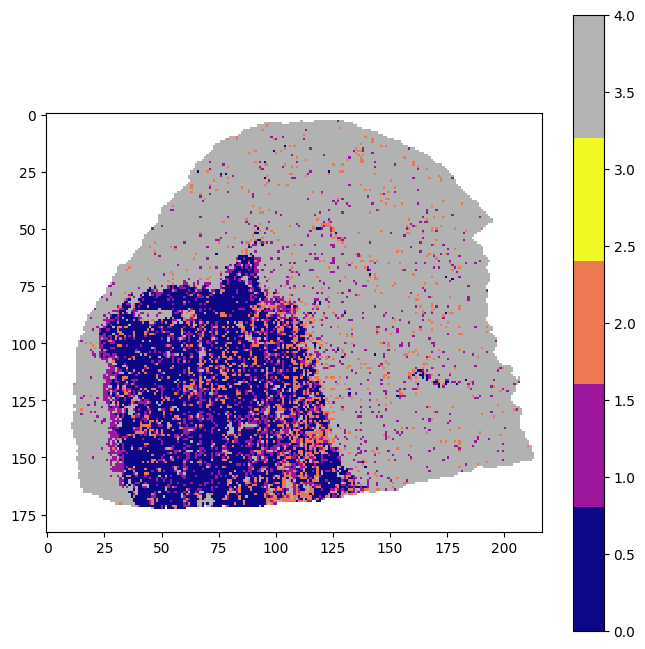

11249.svs Processed
11368.svs Processed
9388.svs Processed


  0%|          | 0/106 [00:00<?, ?it/s]

  3%|▎         | 3/106 [00:00<00:09, 10.93it/s]

  5%|▍         | 5/106 [00:03<01:22,  1.23it/s]

  6%|▌         | 6/106 [00:05<02:01,  1.21s/it]

  7%|▋         | 7/106 [00:08<02:34,  1.56s/it]

  8%|▊         | 8/106 [00:12<03:37,  2.22s/it]

  8%|▊         | 9/106 [00:17<04:48,  2.98s/it]

  9%|▉         | 10/106 [00:22<05:43,  3.58s/it]

 10%|█         | 11/106 [00:28<07:04,  4.47s/it]

 11%|█▏        | 12/106 [00:34<07:46,  4.97s/it]

 12%|█▏        | 13/106 [00:42<08:42,  5.62s/it]

 13%|█▎        | 14/106 [00:49<09:13,  6.02s/it]

 14%|█▍        | 15/106 [00:56<09:37,  6.35s/it]

 15%|█▌        | 16/106 [01:04<10:13,  6.82s/it]

 16%|█▌        | 17/106 [01:13<11:08,  7.51s/it]

 17%|█▋        | 18/106 [01:23<12:07,  8.26s/it]

 18%|█▊        | 19/106 [01:32<12:35,  8.69s/it]

 19%|█▉        | 20/106 [01:43<13:08,  9.17s/it]

 20%|█▉        | 21/106 [01:54<13:49,  9.76s/it]

 21%|██        | 22/106 [02:05<14:11, 10.14s/it]

 22%|██▏       | 23/106 [02:16<14:37, 10.57s/it]

 23%|██▎       | 24/106 [02:28<14:54, 10.91s/it]

 24%|██▎       | 25/106 [02:41<15:26, 11.44s/it]

 25%|██▍       | 26/106 [02:54<15:49, 11.87s/it]

 25%|██▌       | 27/106 [03:07<16:12, 12.31s/it]

 26%|██▋       | 28/106 [03:21<16:28, 12.67s/it]

 27%|██▋       | 29/106 [03:34<16:26, 12.82s/it]

 28%|██▊       | 30/106 [03:48<16:41, 13.17s/it]

 29%|██▉       | 31/106 [04:02<16:57, 13.56s/it]

 30%|███       | 32/106 [04:16<16:57, 13.75s/it]

 31%|███       | 33/106 [04:31<17:03, 14.02s/it]

 32%|███▏      | 34/106 [04:46<17:18, 14.42s/it]

 33%|███▎      | 35/106 [05:02<17:18, 14.63s/it]

 34%|███▍      | 36/106 [05:17<17:28, 14.98s/it]

 35%|███▍      | 37/106 [05:32<17:13, 14.98s/it]

 36%|███▌      | 38/106 [05:49<17:27, 15.41s/it]

 37%|███▋      | 39/106 [06:04<17:09, 15.37s/it]

 38%|███▊      | 40/106 [06:21<17:19, 15.75s/it]

 39%|███▊      | 41/106 [06:37<17:23, 16.06s/it]

 40%|███▉      | 42/106 [06:55<17:38, 16.54s/it]

 41%|████      | 43/106 [07:13<17:46, 16.93s/it]

 42%|████▏     | 44/106 [07:31<17:51, 17.28s/it]

 42%|████▏     | 45/106 [07:50<18:06, 17.81s/it]

 43%|████▎     | 46/106 [08:08<17:48, 17.81s/it]

 44%|████▍     | 47/106 [08:27<17:51, 18.16s/it]

 45%|████▌     | 48/106 [08:45<17:39, 18.26s/it]

 46%|████▌     | 49/106 [09:03<17:18, 18.23s/it]

 47%|████▋     | 50/106 [09:22<17:04, 18.30s/it]

 48%|████▊     | 51/106 [09:41<17:04, 18.63s/it]

 49%|████▉     | 52/106 [10:01<16:58, 18.86s/it]

 50%|█████     | 53/106 [10:21<17:05, 19.35s/it]

 51%|█████     | 54/106 [10:42<17:00, 19.62s/it]

 52%|█████▏    | 55/106 [11:02<16:53, 19.87s/it]

 53%|█████▎    | 56/106 [11:24<17:09, 20.60s/it]

 54%|█████▍    | 57/106 [11:45<16:54, 20.70s/it]

 55%|█████▍    | 58/106 [12:06<16:34, 20.72s/it]

 56%|█████▌    | 59/106 [12:28<16:38, 21.23s/it]

 57%|█████▋    | 60/106 [12:51<16:29, 21.52s/it]

 58%|█████▊    | 61/106 [13:13<16:15, 21.69s/it]

 58%|█████▊    | 62/106 [13:34<15:55, 21.72s/it]

 59%|█████▉    | 63/106 [13:57<15:42, 21.91s/it]

 60%|██████    | 64/106 [14:20<15:41, 22.41s/it]

 61%|██████▏   | 65/106 [14:43<15:18, 22.41s/it]

 62%|██████▏   | 66/106 [15:04<14:47, 22.18s/it]

 63%|██████▎   | 67/106 [15:27<14:25, 22.19s/it]

 64%|██████▍   | 68/106 [15:49<14:08, 22.32s/it]

 65%|██████▌   | 69/106 [16:10<13:30, 21.90s/it]

 66%|██████▌   | 70/106 [16:31<13:00, 21.67s/it]

 67%|██████▋   | 71/106 [16:52<12:27, 21.35s/it]

 68%|██████▊   | 72/106 [17:13<11:59, 21.16s/it]

 69%|██████▉   | 73/106 [17:33<11:31, 20.96s/it]

 70%|██████▉   | 74/106 [17:53<11:00, 20.65s/it]

 71%|███████   | 75/106 [18:13<10:36, 20.53s/it]

 72%|███████▏  | 76/106 [18:33<10:05, 20.18s/it]

 73%|███████▎  | 77/106 [18:54<09:52, 20.43s/it]

 74%|███████▎  | 78/106 [19:13<09:24, 20.17s/it]

 75%|███████▍  | 79/106 [19:33<09:01, 20.06s/it]

 75%|███████▌  | 80/106 [19:55<08:54, 20.57s/it]

 76%|███████▋  | 81/106 [20:16<08:38, 20.73s/it]

 77%|███████▋  | 82/106 [20:36<08:09, 20.38s/it]

 78%|███████▊  | 83/106 [20:55<07:43, 20.13s/it]

 79%|███████▉  | 84/106 [21:14<07:14, 19.74s/it]

 80%|████████  | 85/106 [21:33<06:51, 19.59s/it]

 81%|████████  | 86/106 [21:53<06:31, 19.56s/it]

 82%|████████▏ | 87/106 [22:12<06:10, 19.47s/it]

 83%|████████▎ | 88/106 [22:30<05:44, 19.15s/it]

 84%|████████▍ | 89/106 [22:49<05:23, 19.04s/it]

 85%|████████▍ | 90/106 [23:07<04:59, 18.72s/it]

 86%|████████▌ | 91/106 [23:26<04:42, 18.83s/it]

 87%|████████▋ | 92/106 [23:44<04:17, 18.42s/it]

 88%|████████▊ | 93/106 [24:01<03:54, 18.01s/it]

 89%|████████▊ | 94/106 [24:17<03:30, 17.53s/it]

 90%|████████▉ | 95/106 [24:32<03:04, 16.79s/it]

 91%|█████████ | 96/106 [24:47<02:43, 16.31s/it]

 92%|█████████▏| 97/106 [25:00<02:17, 15.23s/it]

 92%|█████████▏| 98/106 [25:12<01:54, 14.29s/it]

 93%|█████████▎| 99/106 [25:24<01:35, 13.71s/it]

 94%|█████████▍| 100/106 [25:34<01:14, 12.39s/it]

 95%|█████████▌| 101/106 [25:41<00:54, 10.85s/it]

 96%|█████████▌| 102/106 [25:46<00:36,  9.19s/it]

 97%|█████████▋| 103/106 [25:48<00:20,  6.99s/it]

100%|██████████| 106/106 [25:48<00:00, 14.61s/it]

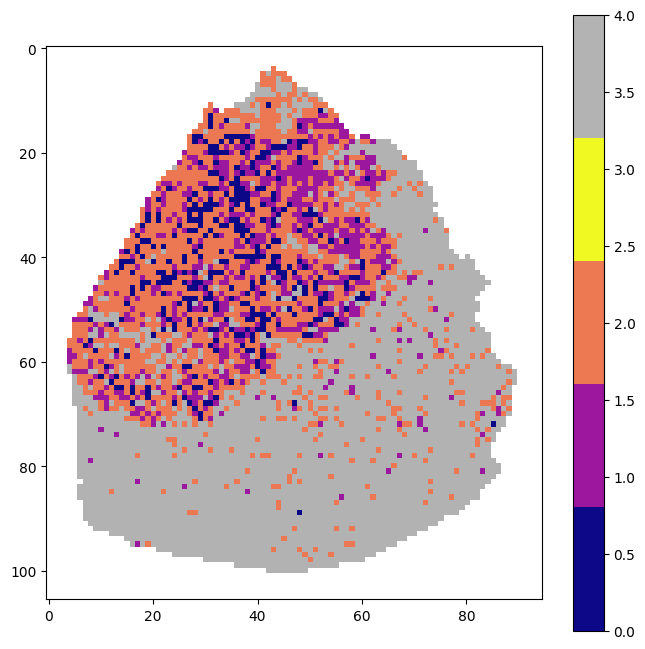

10485.svs Processed
9965.svs Processed
11233.svs Processed
9778.svs Processed
9544.svs Processed
11458.svs Processed
11003.svs Processed


9460.svs Processed
11229.svs Processed


  0%|          | 0/118 [00:00<?, ?it/s]

  2%|▏         | 2/118 [00:00<00:51,  2.26it/s]

  3%|▎         | 3/118 [00:04<03:33,  1.86s/it]

  3%|▎         | 4/118 [00:11<06:59,  3.68s/it]

  4%|▍         | 5/118 [00:20<10:28,  5.56s/it]

  5%|▌         | 6/118 [00:31<13:42,  7.35s/it]

  6%|▌         | 7/118 [00:43<16:07,  8.72s/it]

  7%|▋         | 8/118 [00:55<18:15,  9.95s/it]

  8%|▊         | 9/118 [01:09<20:13, 11.14s/it]

  8%|▊         | 10/118 [01:23<21:47, 12.11s/it]

  9%|▉         | 11/118 [01:39<23:21, 13.10s/it]

 10%|█         | 12/118 [01:55<25:05, 14.21s/it]

 11%|█         | 13/118 [02:12<26:18, 15.03s/it]

 12%|█▏        | 14/118 [02:31<27:49, 16.06s/it]

 13%|█▎        | 15/118 [02:53<30:43, 17.90s/it]

 14%|█▎        | 16/118 [03:16<32:58, 19.39s/it]

 14%|█▍        | 17/118 [03:40<34:57, 20.77s/it]

 15%|█▌        | 18/118 [04:04<36:33, 21.94s/it]

 16%|█▌        | 19/118 [04:32<38:50, 23.54s/it]

 17%|█▋        | 20/118 [05:00<40:53, 25.04s/it]

 18%|█▊        | 21/118 [05:28<41:48, 25.86s/it]

 19%|█▊        | 22/118 [06:06<46:58, 29.36s/it]

 19%|█▉        | 23/118 [06:39<48:22, 30.55s/it]

 20%|██        | 24/118 [07:11<48:46, 31.13s/it]

 21%|██        | 25/118 [07:44<48:47, 31.48s/it]

 22%|██▏       | 26/118 [08:17<49:18, 32.16s/it]

 23%|██▎       | 27/118 [08:53<50:23, 33.22s/it]

 24%|██▎       | 28/118 [09:29<51:01, 34.01s/it]

 25%|██▍       | 29/118 [10:04<50:41, 34.17s/it]

 25%|██▌       | 30/118 [10:36<49:30, 33.75s/it]

 26%|██▋       | 31/118 [11:11<49:34, 34.19s/it]

 27%|██▋       | 32/118 [11:46<49:04, 34.24s/it]

 28%|██▊       | 33/118 [12:21<48:51, 34.48s/it]

 29%|██▉       | 34/118 [12:55<48:04, 34.34s/it]

 30%|██▉       | 35/118 [13:29<47:26, 34.30s/it]

 31%|███       | 36/118 [14:05<47:40, 34.89s/it]

 31%|███▏      | 37/118 [14:40<46:57, 34.78s/it]

 32%|███▏      | 38/118 [15:14<46:05, 34.57s/it]

 33%|███▎      | 39/118 [15:46<44:33, 33.84s/it]

 34%|███▍      | 40/118 [16:20<44:06, 33.93s/it]

 35%|███▍      | 41/118 [16:55<43:39, 34.03s/it]

 36%|███▌      | 42/118 [17:27<42:36, 33.64s/it]

 36%|███▋      | 43/118 [18:01<42:08, 33.71s/it]

 37%|███▋      | 44/118 [18:36<41:57, 34.02s/it]

 38%|███▊      | 45/118 [19:12<41:59, 34.52s/it]

 39%|███▉      | 46/118 [19:47<41:56, 34.95s/it]

 40%|███▉      | 47/118 [20:25<42:14, 35.70s/it]

 41%|████      | 48/118 [21:01<41:42, 35.76s/it]

 42%|████▏     | 49/118 [21:39<41:51, 36.40s/it]

 42%|████▏     | 50/118 [22:16<41:26, 36.56s/it]

 43%|████▎     | 51/118 [22:52<40:48, 36.54s/it]

 44%|████▍     | 52/118 [23:30<40:29, 36.80s/it]

 45%|████▍     | 53/118 [24:07<40:09, 37.07s/it]

 46%|████▌     | 54/118 [24:44<39:34, 37.10s/it]

 47%|████▋     | 55/118 [25:21<38:49, 36.97s/it]

 47%|████▋     | 56/118 [25:58<38:11, 36.96s/it]

 48%|████▊     | 57/118 [26:36<37:47, 37.17s/it]

 49%|████▉     | 58/118 [27:14<37:31, 37.52s/it]

 50%|█████     | 59/118 [27:54<37:35, 38.22s/it]

 51%|█████     | 60/118 [28:31<36:44, 38.01s/it]

 52%|█████▏    | 61/118 [29:10<36:08, 38.05s/it]

 53%|█████▎    | 62/118 [29:49<35:59, 38.57s/it]

 53%|█████▎    | 63/118 [30:28<35:19, 38.54s/it]

 54%|█████▍    | 64/118 [31:04<33:59, 37.76s/it]

 55%|█████▌    | 65/118 [31:40<33:02, 37.41s/it]

 56%|█████▌    | 66/118 [32:17<32:11, 37.15s/it]

 57%|█████▋    | 67/118 [32:55<31:42, 37.31s/it]

 58%|█████▊    | 68/118 [33:33<31:20, 37.60s/it]

 58%|█████▊    | 69/118 [34:11<30:44, 37.65s/it]

 59%|█████▉    | 70/118 [34:50<30:32, 38.18s/it]

 60%|██████    | 71/118 [35:28<29:47, 38.03s/it]

 61%|██████    | 72/118 [36:08<29:38, 38.67s/it]

 62%|██████▏   | 73/118 [36:47<29:04, 38.76s/it]

 63%|██████▎   | 74/118 [37:26<28:29, 38.85s/it]

 64%|██████▎   | 75/118 [38:05<27:47, 38.77s/it]

 64%|██████▍   | 76/118 [38:45<27:27, 39.23s/it]

 65%|██████▌   | 77/118 [39:25<27:05, 39.64s/it]

 66%|██████▌   | 78/118 [40:07<26:49, 40.23s/it]

 67%|██████▋   | 79/118 [40:46<25:57, 39.94s/it]

 68%|██████▊   | 80/118 [41:26<25:14, 39.86s/it]

 69%|██████▊   | 81/118 [42:06<24:37, 39.94s/it]

 69%|██████▉   | 82/118 [42:45<23:48, 39.69s/it]

 70%|███████   | 83/118 [43:21<22:32, 38.64s/it]

 71%|███████   | 84/118 [44:01<22:07, 39.03s/it]

 72%|███████▏  | 85/118 [44:39<21:16, 38.68s/it]

 73%|███████▎  | 86/118 [45:17<20:33, 38.54s/it]

 74%|███████▎  | 87/118 [45:56<19:50, 38.42s/it]

 75%|███████▍  | 88/118 [46:35<19:17, 38.59s/it]

 75%|███████▌  | 89/118 [47:15<18:54, 39.10s/it]

 76%|███████▋  | 90/118 [47:55<18:19, 39.28s/it]

 77%|███████▋  | 91/118 [48:36<18:00, 40.01s/it]

 78%|███████▊  | 92/118 [49:17<17:23, 40.14s/it]

 79%|███████▉  | 93/118 [49:57<16:41, 40.05s/it]

 80%|███████▉  | 94/118 [50:37<16:07, 40.29s/it]

 81%|████████  | 95/118 [51:19<15:35, 40.67s/it]

 81%|████████▏ | 96/118 [51:58<14:46, 40.31s/it]

 82%|████████▏ | 97/118 [52:37<13:53, 39.71s/it]

 83%|████████▎ | 98/118 [53:13<12:53, 38.65s/it]

 84%|████████▍ | 99/118 [53:48<11:54, 37.58s/it]

 85%|████████▍ | 100/118 [54:20<10:47, 35.95s/it]

 86%|████████▌ | 101/118 [54:50<09:41, 34.18s/it]

 86%|████████▋ | 102/118 [55:17<08:31, 31.99s/it]

 87%|████████▋ | 103/118 [55:42<07:26, 29.77s/it]

 88%|████████▊ | 104/118 [56:04<06:25, 27.53s/it]

 89%|████████▉ | 105/118 [56:25<05:32, 25.57s/it]

 90%|████████▉ | 106/118 [56:43<04:40, 23.36s/it]

 91%|█████████ | 107/118 [57:03<04:05, 22.30s/it]

 92%|█████████▏| 108/118 [57:22<03:34, 21.47s/it]

 92%|█████████▏| 109/118 [57:40<03:01, 20.21s/it]

 93%|█████████▎| 110/118 [57:57<02:33, 19.23s/it]

 94%|█████████▍| 111/118 [58:13<02:08, 18.29s/it]

 95%|█████████▍| 112/118 [58:28<01:43, 17.32s/it]

 96%|█████████▌| 113/118 [58:43<01:23, 16.69s/it]

 97%|█████████▋| 114/118 [58:56<01:02, 15.70s/it]

 97%|█████████▋| 115/118 [59:08<00:43, 14.52s/it]

 98%|█████████▊| 116/118 [59:21<00:27, 14.00s/it]

 99%|█████████▉| 117/118 [59:32<00:13, 13.20s/it]

100%|██████████| 118/118 [59:42<00:00, 12.22s/it]

100%|██████████| 118/118 [59:42<00:00, 30.36s/it]

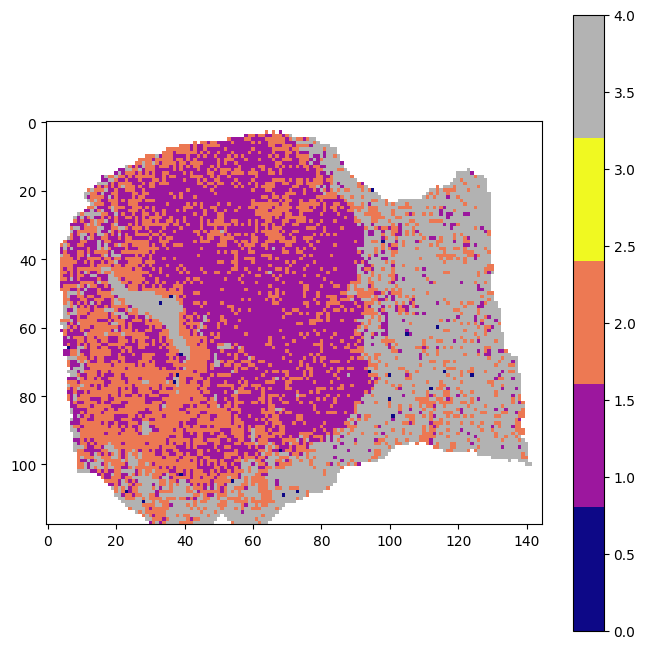

  0%|          | 0/78 [00:00<?, ?it/s]

  4%|▍         | 3/78 [00:02<01:01,  1.23it/s]

  5%|▌         | 4/78 [00:07<02:42,  2.20s/it]

  6%|▋         | 5/78 [00:17<05:33,  4.57s/it]

  8%|▊         | 6/78 [00:29<08:09,  6.80s/it]

  9%|▉         | 7/78 [00:41<10:09,  8.59s/it]

 10%|█         | 8/78 [00:56<12:16, 10.52s/it]

 12%|█▏        | 9/78 [01:12<13:52, 12.07s/it]

 13%|█▎        | 10/78 [01:31<16:02, 14.15s/it]

 14%|█▍        | 11/78 [01:52<18:17, 16.38s/it]

 15%|█▌        | 12/78 [02:16<20:35, 18.72s/it]

 17%|█▋        | 13/78 [02:42<22:33, 20.83s/it]

 18%|█▊        | 14/78 [03:09<24:13, 22.72s/it]

 19%|█▉        | 15/78 [03:36<25:05, 23.90s/it]

 21%|██        | 16/78 [04:05<26:15, 25.40s/it]

 22%|██▏       | 17/78 [04:34<26:55, 26.49s/it]

 23%|██▎       | 18/78 [05:02<27:05, 27.09s/it]

 24%|██▍       | 19/78 [05:30<26:51, 27.31s/it]

 26%|██▌       | 20/78 [05:59<26:50, 27.76s/it]

 27%|██▋       | 21/78 [06:28<26:41, 28.09s/it]

 28%|██▊       | 22/78 [06:56<26:14, 28.12s/it]

 29%|██▉       | 23/78 [07:25<25:54, 28.27s/it]

 31%|███       | 24/78 [07:55<26:01, 28.92s/it]

 32%|███▏      | 25/78 [08:23<25:21, 28.71s/it]

 33%|███▎      | 26/78 [08:54<25:19, 29.21s/it]

 35%|███▍      | 27/78 [09:22<24:45, 29.13s/it]

 36%|███▌      | 28/78 [09:52<24:20, 29.22s/it]

 37%|███▋      | 29/78 [10:19<23:17, 28.52s/it]

 38%|███▊      | 30/78 [10:46<22:31, 28.15s/it]

 40%|███▉      | 31/78 [11:15<22:12, 28.35s/it]

 41%|████      | 32/78 [11:43<21:33, 28.12s/it]

 42%|████▏     | 33/78 [12:11<21:08, 28.19s/it]

 44%|████▎     | 34/78 [12:39<20:37, 28.12s/it]

 45%|████▍     | 35/78 [13:06<19:57, 27.86s/it]

 46%|████▌     | 36/78 [13:35<19:41, 28.13s/it]

 47%|████▋     | 37/78 [14:03<19:12, 28.10s/it]

 49%|████▊     | 38/78 [14:32<19:00, 28.51s/it]

 50%|█████     | 39/78 [15:01<18:32, 28.53s/it]

 51%|█████▏    | 40/78 [15:28<17:44, 28.02s/it]

 53%|█████▎    | 41/78 [15:56<17:14, 27.95s/it]

 54%|█████▍    | 42/78 [16:24<16:54, 28.17s/it]

 55%|█████▌    | 43/78 [16:53<16:31, 28.32s/it]

 56%|█████▋    | 44/78 [17:22<16:09, 28.50s/it]

 58%|█████▊    | 45/78 [17:51<15:44, 28.61s/it]

 59%|█████▉    | 46/78 [18:20<15:21, 28.80s/it]

 60%|██████    | 47/78 [18:49<14:59, 29.01s/it]

 62%|██████▏   | 48/78 [19:21<14:48, 29.63s/it]

 63%|██████▎   | 49/78 [19:52<14:39, 30.34s/it]

 64%|██████▍   | 50/78 [20:23<14:11, 30.40s/it]

 65%|██████▌   | 51/78 [20:54<13:46, 30.62s/it]

 67%|██████▋   | 52/78 [21:24<13:08, 30.32s/it]

 68%|██████▊   | 53/78 [21:49<11:59, 28.78s/it]

 69%|██████▉   | 54/78 [22:08<10:17, 25.71s/it]

 71%|███████   | 55/78 [22:24<08:47, 22.92s/it]

 72%|███████▏  | 56/78 [22:36<07:12, 19.66s/it]

 73%|███████▎  | 57/78 [22:46<05:54, 16.87s/it]

 74%|███████▍  | 58/78 [22:57<04:57, 14.87s/it]

 76%|███████▌  | 59/78 [23:07<04:16, 13.52s/it]

 77%|███████▋  | 60/78 [23:17<03:45, 12.53s/it]

 78%|███████▊  | 61/78 [23:28<03:23, 11.97s/it]

 79%|███████▉  | 62/78 [23:36<02:54, 10.90s/it]

 81%|████████  | 63/78 [23:46<02:37, 10.48s/it]

 82%|████████▏ | 64/78 [23:57<02:28, 10.60s/it]

 83%|████████▎ | 65/78 [24:06<02:14, 10.32s/it]

 85%|████████▍ | 66/78 [24:16<02:00, 10.05s/it]

 86%|████████▌ | 67/78 [24:25<01:49,  9.98s/it]

 87%|████████▋ | 68/78 [24:34<01:35,  9.59s/it]

 88%|████████▊ | 69/78 [24:43<01:23,  9.23s/it]

 90%|████████▉ | 70/78 [24:51<01:10,  8.87s/it]

 91%|█████████ | 71/78 [24:58<00:59,  8.43s/it]

 92%|█████████▏| 72/78 [25:04<00:46,  7.68s/it]

 94%|█████████▎| 73/78 [25:10<00:36,  7.28s/it]

 95%|█████████▍| 74/78 [25:15<00:25,  6.43s/it]

 96%|█████████▌| 75/78 [25:19<00:17,  5.69s/it]

 97%|█████████▋| 76/78 [25:21<00:09,  4.75s/it]

100%|██████████| 78/78 [25:21<00:00, 19.51s/it]

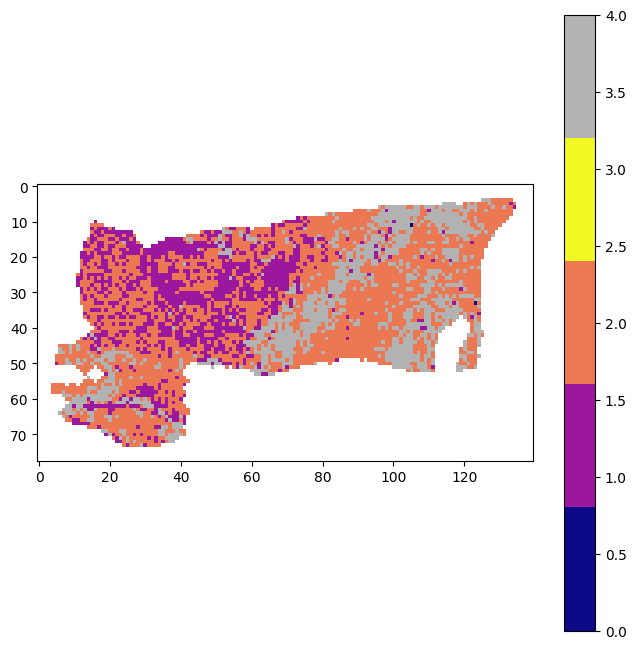

  0%|          | 0/77 [00:00<?, ?it/s]

  4%|▍         | 3/77 [00:00<00:20,  3.67it/s]

  5%|▌         | 4/77 [00:01<00:35,  2.04it/s]

  6%|▋         | 5/77 [00:06<02:02,  1.70s/it]

  8%|▊         | 6/77 [00:10<03:03,  2.58s/it]

  9%|▉         | 7/77 [00:18<04:44,  4.07s/it]

 10%|█         | 8/77 [00:27<06:43,  5.85s/it]

 12%|█▏        | 9/77 [00:43<09:49,  8.67s/it]

 13%|█▎        | 10/77 [01:02<13:13, 11.84s/it]

 14%|█▍        | 11/77 [01:20<15:18, 13.92s/it]

 16%|█▌        | 12/77 [01:39<16:41, 15.41s/it]

 17%|█▋        | 13/77 [01:59<17:38, 16.54s/it]

 18%|█▊        | 14/77 [02:19<18:36, 17.73s/it]

 19%|█▉        | 15/77 [02:39<19:09, 18.54s/it]

 21%|██        | 16/77 [03:01<19:41, 19.36s/it]

 22%|██▏       | 17/77 [03:24<20:28, 20.48s/it]

 23%|██▎       | 18/77 [03:52<22:19, 22.70s/it]

 25%|██▍       | 19/77 [04:19<23:14, 24.05s/it]

 26%|██▌       | 20/77 [04:47<23:54, 25.17s/it]

 27%|██▋       | 21/77 [05:14<24:08, 25.86s/it]

 29%|██▊       | 22/77 [05:43<24:31, 26.76s/it]

 30%|██▉       | 23/77 [06:10<24:11, 26.89s/it]

 31%|███       | 24/77 [06:37<23:48, 26.95s/it]

 32%|███▏      | 25/77 [07:04<23:16, 26.86s/it]

 34%|███▍      | 26/77 [07:31<22:57, 27.01s/it]

 35%|███▌      | 27/77 [07:58<22:19, 26.79s/it]

 36%|███▋      | 28/77 [08:23<21:35, 26.45s/it]

 38%|███▊      | 29/77 [08:48<20:45, 25.96s/it]

 39%|███▉      | 30/77 [09:13<20:04, 25.62s/it]

 40%|████      | 31/77 [09:40<19:53, 25.94s/it]

 42%|████▏     | 32/77 [10:05<19:17, 25.71s/it]

 43%|████▎     | 33/77 [10:31<19:04, 26.00s/it]

 44%|████▍     | 34/77 [10:57<18:36, 25.96s/it]

 45%|████▌     | 35/77 [11:22<17:58, 25.68s/it]

 47%|████▋     | 36/77 [11:50<17:54, 26.20s/it]

 48%|████▊     | 37/77 [12:15<17:18, 25.95s/it]

 49%|████▉     | 38/77 [12:41<16:54, 26.00s/it]

 51%|█████     | 39/77 [13:07<16:26, 25.96s/it]

 52%|█████▏    | 40/77 [13:33<15:57, 25.87s/it]

 53%|█████▎    | 41/77 [13:58<15:25, 25.70s/it]

 55%|█████▍    | 42/77 [14:23<14:48, 25.38s/it]

 56%|█████▌    | 43/77 [14:50<14:41, 25.92s/it]

 57%|█████▋    | 44/77 [15:15<14:12, 25.83s/it]

 58%|█████▊    | 45/77 [15:41<13:46, 25.82s/it]

 60%|█████▉    | 46/77 [16:06<13:12, 25.56s/it]

 61%|██████    | 47/77 [16:31<12:42, 25.42s/it]

 62%|██████▏   | 48/77 [16:57<12:19, 25.48s/it]

 64%|██████▎   | 49/77 [17:22<11:48, 25.30s/it]

 65%|██████▍   | 50/77 [17:47<11:25, 25.39s/it]

 66%|██████▌   | 51/77 [18:13<11:03, 25.51s/it]

 68%|██████▊   | 52/77 [18:39<10:41, 25.66s/it]

 69%|██████▉   | 53/77 [19:05<10:17, 25.73s/it]

 70%|███████   | 54/77 [19:31<09:52, 25.75s/it]

 71%|███████▏  | 55/77 [19:56<09:20, 25.47s/it]

 73%|███████▎  | 56/77 [20:20<08:48, 25.15s/it]

 74%|███████▍  | 57/77 [20:43<08:09, 24.46s/it]

 75%|███████▌  | 58/77 [21:05<07:33, 23.85s/it]

 77%|███████▋  | 59/77 [21:25<06:48, 22.69s/it]

 78%|███████▊  | 60/77 [21:44<06:07, 21.59s/it]

 79%|███████▉  | 61/77 [22:03<05:30, 20.65s/it]

 81%|████████  | 62/77 [22:21<05:00, 20.01s/it]

 82%|████████▏ | 63/77 [22:39<04:31, 19.38s/it]

 83%|████████▎ | 64/77 [22:56<04:02, 18.64s/it]

 84%|████████▍ | 65/77 [23:13<03:38, 18.23s/it]

 86%|████████▌ | 66/77 [23:28<03:09, 17.26s/it]

 87%|████████▋ | 67/77 [23:42<02:42, 16.26s/it]

 88%|████████▊ | 68/77 [23:55<02:15, 15.08s/it]

 90%|████████▉ | 69/77 [24:06<01:52, 14.09s/it]

 91%|█████████ | 70/77 [24:16<01:29, 12.77s/it]

 92%|█████████▏| 71/77 [24:25<01:09, 11.53s/it]

 94%|█████████▎| 72/77 [24:29<00:46,  9.36s/it]

 95%|█████████▍| 73/77 [24:33<00:30,  7.75s/it]

 96%|█████████▌| 74/77 [24:35<00:17,  5.99s/it]

100%|██████████| 77/77 [24:35<00:00, 19.16s/it]

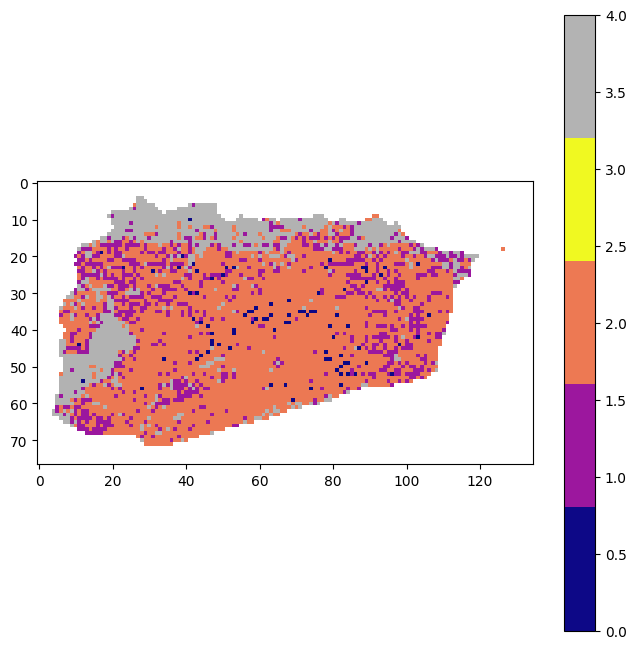

10484.svs Processed
9701.svs Processed
10461.svs Processed
9747.svs Processed
10420.svs Processed


  0%|          | 0/87 [00:00<?, ?it/s]

  5%|▍         | 4/87 [00:00<00:17,  4.83it/s]

  6%|▌         | 5/87 [00:01<00:31,  2.60it/s]

  7%|▋         | 6/87 [00:03<00:53,  1.51it/s]

  8%|▊         | 7/87 [00:04<01:12,  1.10it/s]

  9%|▉         | 8/87 [00:06<01:38,  1.25s/it]

 10%|█         | 9/87 [00:08<01:58,  1.52s/it]

 11%|█▏        | 10/87 [00:12<02:47,  2.17s/it]

 13%|█▎        | 11/87 [00:18<04:09,  3.29s/it]

 14%|█▍        | 12/87 [00:23<04:52,  3.90s/it]

 15%|█▍        | 13/87 [00:29<05:32,  4.49s/it]

 16%|█▌        | 14/87 [00:36<06:18,  5.18s/it]

 17%|█▋        | 15/87 [00:45<07:22,  6.14s/it]

 18%|█▊        | 16/87 [00:53<07:58,  6.74s/it]

 20%|█▉        | 17/87 [01:02<08:41,  7.45s/it]

 21%|██        | 18/87 [01:11<09:10,  7.99s/it]

 22%|██▏       | 19/87 [01:20<09:30,  8.39s/it]

 23%|██▎       | 20/87 [01:34<11:07,  9.97s/it]

 24%|██▍       | 21/87 [01:44<11:05, 10.09s/it]

 25%|██▌       | 22/87 [01:56<11:17, 10.42s/it]

 26%|██▋       | 23/87 [02:08<11:40, 10.95s/it]

 28%|██▊       | 24/87 [02:20<11:54, 11.34s/it]

 29%|██▊       | 25/87 [02:32<11:53, 11.51s/it]

 30%|██▉       | 26/87 [02:45<12:15, 12.06s/it]

 31%|███       | 27/87 [02:59<12:30, 12.51s/it]

 32%|███▏      | 28/87 [03:12<12:28, 12.68s/it]

 33%|███▎      | 29/87 [03:26<12:46, 13.21s/it]

 34%|███▍      | 30/87 [03:42<13:11, 13.88s/it]

 36%|███▌      | 31/87 [03:57<13:21, 14.31s/it]

 37%|███▋      | 32/87 [04:13<13:25, 14.64s/it]

 38%|███▊      | 33/87 [04:27<13:08, 14.60s/it]

 39%|███▉      | 34/87 [04:42<13:00, 14.72s/it]

 40%|████      | 35/87 [04:58<13:05, 15.10s/it]

 41%|████▏     | 36/87 [05:15<13:25, 15.80s/it]

 43%|████▎     | 37/87 [05:34<13:50, 16.60s/it]

 44%|████▎     | 38/87 [05:53<14:08, 17.31s/it]

 45%|████▍     | 39/87 [06:12<14:13, 17.78s/it]

 46%|████▌     | 40/87 [06:30<14:03, 17.94s/it]

 47%|████▋     | 41/87 [06:49<13:59, 18.26s/it]

 48%|████▊     | 42/87 [07:08<13:45, 18.35s/it]

 49%|████▉     | 43/87 [07:27<13:38, 18.60s/it]

 51%|█████     | 44/87 [07:47<13:39, 19.06s/it]

 52%|█████▏    | 45/87 [08:06<13:19, 19.03s/it]

 53%|█████▎    | 46/87 [08:25<13:02, 19.08s/it]

 54%|█████▍    | 47/87 [08:44<12:41, 19.03s/it]

 55%|█████▌    | 48/87 [09:03<12:26, 19.14s/it]

 56%|█████▋    | 49/87 [09:23<12:13, 19.31s/it]

 57%|█████▋    | 50/87 [09:42<11:54, 19.32s/it]

 59%|█████▊    | 51/87 [10:02<11:35, 19.33s/it]

 60%|█████▉    | 52/87 [10:21<11:13, 19.24s/it]

 61%|██████    | 53/87 [10:40<10:55, 19.29s/it]

 62%|██████▏   | 54/87 [11:00<10:41, 19.44s/it]

 63%|██████▎   | 55/87 [11:20<10:27, 19.60s/it]

 64%|██████▍   | 56/87 [11:40<10:08, 19.61s/it]

 66%|██████▌   | 57/87 [12:02<10:08, 20.28s/it]

 67%|██████▋   | 58/87 [12:21<09:42, 20.09s/it]

 68%|██████▊   | 59/87 [12:40<09:08, 19.60s/it]

 69%|██████▉   | 60/87 [12:59<08:48, 19.57s/it]

 70%|███████   | 61/87 [13:18<08:22, 19.34s/it]

 71%|███████▏  | 62/87 [13:36<07:55, 19.02s/it]

 72%|███████▏  | 63/87 [13:55<07:35, 18.96s/it]

 74%|███████▎  | 64/87 [14:13<07:12, 18.79s/it]

 75%|███████▍  | 65/87 [14:30<06:36, 18.02s/it]

 76%|███████▌  | 66/87 [14:44<05:58, 17.07s/it]

 77%|███████▋  | 67/87 [14:57<05:16, 15.84s/it]

 78%|███████▊  | 68/87 [15:10<04:44, 14.98s/it]

 79%|███████▉  | 69/87 [15:24<04:22, 14.57s/it]

 80%|████████  | 70/87 [15:37<04:01, 14.18s/it]

 82%|████████▏ | 71/87 [15:51<03:46, 14.16s/it]

 83%|████████▎ | 72/87 [16:05<03:28, 13.89s/it]

 84%|████████▍ | 73/87 [16:19<03:15, 13.97s/it]

 85%|████████▌ | 74/87 [16:32<02:59, 13.84s/it]

 86%|████████▌ | 75/87 [16:45<02:41, 13.45s/it]

 87%|████████▋ | 76/87 [16:57<02:22, 12.92s/it]

 89%|████████▊ | 77/87 [17:07<02:02, 12.21s/it]

 90%|████████▉ | 78/87 [17:18<01:45, 11.71s/it]

 91%|█████████ | 79/87 [17:27<01:27, 10.98s/it]

 92%|█████████▏| 80/87 [17:36<01:12, 10.40s/it]

 93%|█████████▎| 81/87 [17:45<00:59,  9.93s/it]

 94%|█████████▍| 82/87 [17:51<00:43,  8.74s/it]

 95%|█████████▌| 83/87 [17:56<00:30,  7.71s/it]

 97%|█████████▋| 84/87 [18:00<00:19,  6.48s/it]

 98%|█████████▊| 85/87 [18:00<00:09,  4.60s/it]

100%|██████████| 87/87 [18:00<00:00, 12.42s/it]

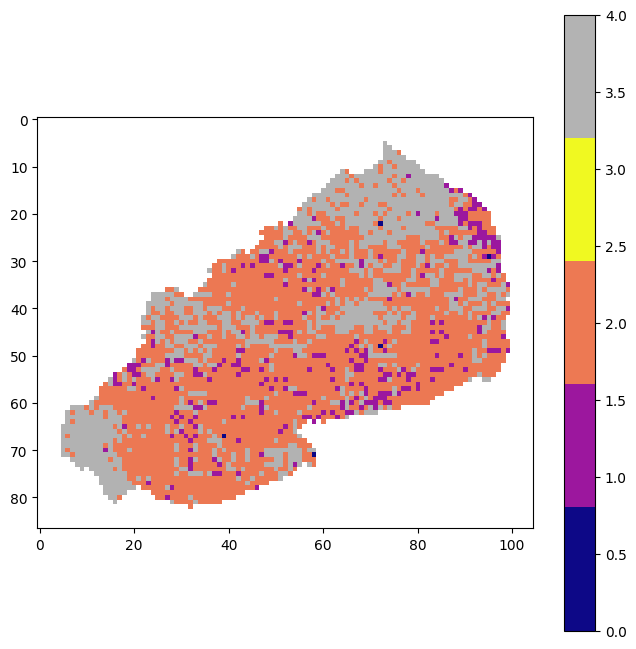

10877.svs Processed
11323.svs Processed
9475.svs Processed


  0%|          | 0/94 [00:00<?, ?it/s]

  6%|▋         | 6/94 [00:03<00:46,  1.91it/s]

  7%|▋         | 7/94 [00:08<01:58,  1.36s/it]

  9%|▊         | 8/94 [00:17<04:22,  3.05s/it]

 10%|▉         | 9/94 [00:27<06:42,  4.73s/it]

 11%|█         | 10/94 [00:39<09:04,  6.49s/it]

 12%|█▏        | 11/94 [00:51<11:05,  8.02s/it]

 13%|█▎        | 12/94 [01:04<12:44,  9.33s/it]

 14%|█▍        | 13/94 [01:18<14:30, 10.75s/it]

 15%|█▍        | 14/94 [01:32<15:29, 11.62s/it]

 16%|█▌        | 15/94 [01:47<16:47, 12.75s/it]

 17%|█▋        | 16/94 [02:02<17:14, 13.27s/it]

 18%|█▊        | 17/94 [02:18<18:03, 14.07s/it]

 19%|█▉        | 18/94 [02:34<18:39, 14.73s/it]

 20%|██        | 19/94 [02:52<19:24, 15.52s/it]

 21%|██▏       | 20/94 [03:09<19:48, 16.05s/it]

 22%|██▏       | 21/94 [03:27<20:14, 16.64s/it]

 23%|██▎       | 22/94 [03:46<20:48, 17.34s/it]

 24%|██▍       | 23/94 [04:06<21:27, 18.14s/it]

 26%|██▌       | 24/94 [04:26<22:01, 18.88s/it]

 27%|██▋       | 25/94 [04:47<22:07, 19.24s/it]

 28%|██▊       | 26/94 [05:07<22:10, 19.56s/it]

 29%|██▊       | 27/94 [05:28<22:15, 19.93s/it]

 30%|██▉       | 28/94 [05:49<22:21, 20.32s/it]

 31%|███       | 29/94 [06:10<22:07, 20.43s/it]

 32%|███▏      | 30/94 [06:32<22:23, 20.99s/it]

 33%|███▎      | 31/94 [06:55<22:34, 21.49s/it]

 34%|███▍      | 32/94 [07:20<23:28, 22.71s/it]

 35%|███▌      | 33/94 [07:47<24:28, 24.08s/it]

 36%|███▌      | 34/94 [08:17<25:37, 25.63s/it]

 37%|███▋      | 35/94 [08:45<25:57, 26.40s/it]

 38%|███▊      | 36/94 [09:15<26:34, 27.50s/it]

 39%|███▉      | 37/94 [09:45<26:48, 28.22s/it]

 40%|████      | 38/94 [10:19<27:56, 29.93s/it]

 41%|████▏     | 39/94 [10:50<27:43, 30.25s/it]

 43%|████▎     | 40/94 [11:22<27:42, 30.79s/it]

 44%|████▎     | 41/94 [11:52<27:08, 30.72s/it]

 45%|████▍     | 42/94 [12:24<26:47, 30.91s/it]

 46%|████▌     | 43/94 [12:58<27:08, 31.93s/it]

 47%|████▋     | 44/94 [13:33<27:15, 32.71s/it]

 48%|████▊     | 45/94 [14:08<27:24, 33.55s/it]

 49%|████▉     | 46/94 [14:44<27:24, 34.26s/it]

 50%|█████     | 47/94 [15:22<27:40, 35.34s/it]

 51%|█████     | 48/94 [16:00<27:42, 36.15s/it]

 52%|█████▏    | 49/94 [16:37<27:20, 36.45s/it]

 53%|█████▎    | 50/94 [17:11<26:05, 35.59s/it]

 54%|█████▍    | 51/94 [17:44<25:03, 34.97s/it]

 55%|█████▌    | 52/94 [18:17<23:56, 34.20s/it]

 56%|█████▋    | 53/94 [18:51<23:21, 34.18s/it]

 57%|█████▋    | 54/94 [19:24<22:34, 33.87s/it]

 59%|█████▊    | 55/94 [19:55<21:32, 33.15s/it]

 60%|█████▉    | 56/94 [20:24<20:15, 31.98s/it]

 61%|██████    | 57/94 [20:53<19:08, 31.03s/it]

 62%|██████▏   | 58/94 [21:22<18:11, 30.33s/it]

 63%|██████▎   | 59/94 [21:52<17:41, 30.32s/it]

 64%|██████▍   | 60/94 [22:23<17:19, 30.58s/it]

 65%|██████▍   | 61/94 [22:54<16:51, 30.65s/it]

 66%|██████▌   | 62/94 [23:26<16:30, 30.95s/it]

 67%|██████▋   | 63/94 [23:57<16:00, 30.99s/it]

 68%|██████▊   | 64/94 [24:26<15:08, 30.29s/it]

 69%|██████▉   | 65/94 [24:53<14:12, 29.41s/it]

 70%|███████   | 66/94 [25:20<13:22, 28.67s/it]

 71%|███████▏  | 67/94 [25:46<12:35, 27.97s/it]

 72%|███████▏  | 68/94 [26:13<11:58, 27.65s/it]

 73%|███████▎  | 69/94 [26:41<11:28, 27.54s/it]

 74%|███████▍  | 70/94 [27:06<10:42, 26.78s/it]

 76%|███████▌  | 71/94 [27:30<10:03, 26.24s/it]

 77%|███████▋  | 72/94 [27:57<09:37, 26.27s/it]

 78%|███████▊  | 73/94 [28:21<09:00, 25.73s/it]

 79%|███████▊  | 74/94 [28:45<08:21, 25.09s/it]

 80%|███████▉  | 75/94 [29:08<07:46, 24.56s/it]

 81%|████████  | 76/94 [29:32<07:15, 24.18s/it]

 82%|████████▏ | 77/94 [29:54<06:42, 23.67s/it]

 83%|████████▎ | 78/94 [30:15<06:08, 23.00s/it]

 84%|████████▍ | 79/94 [30:37<05:37, 22.52s/it]

 85%|████████▌ | 80/94 [30:59<05:13, 22.39s/it]

 86%|████████▌ | 81/94 [31:19<04:42, 21.70s/it]

 87%|████████▋ | 82/94 [31:38<04:09, 20.76s/it]

 88%|████████▊ | 83/94 [31:55<03:38, 19.90s/it]

 89%|████████▉ | 84/94 [32:16<03:19, 19.96s/it]

 90%|█████████ | 85/94 [32:33<02:53, 19.28s/it]

 91%|█████████▏| 86/94 [32:50<02:29, 18.64s/it]

 93%|█████████▎| 87/94 [33:07<02:05, 17.89s/it]

 94%|█████████▎| 88/94 [33:22<01:43, 17.22s/it]

 95%|█████████▍| 89/94 [33:36<01:21, 16.27s/it]

 96%|█████████▌| 90/94 [33:46<00:57, 14.36s/it]

 97%|█████████▋| 91/94 [33:50<00:33, 11.32s/it]

100%|██████████| 94/94 [33:50<00:00, 21.61s/it]

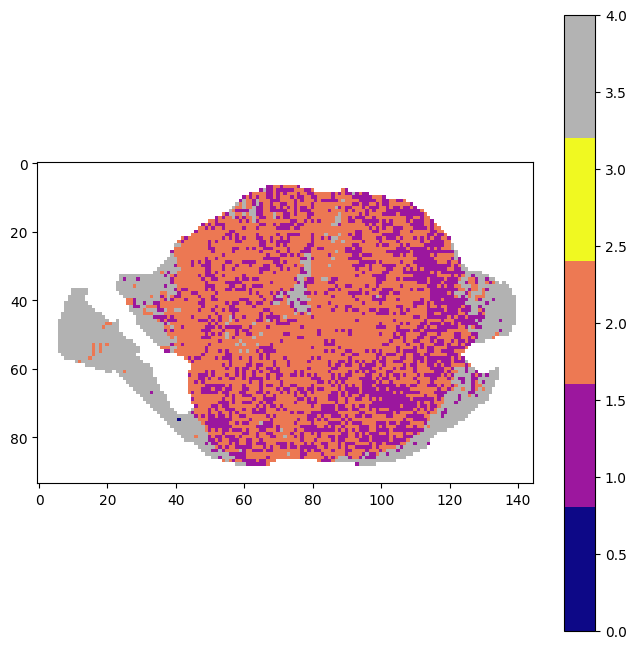

10905.svs Processed
10998.svs Processed
9529.svs Processed
10460.svs Processed
9468.svs Processed
11357.svs Processed
'int' object has no attribute 'properties'
11218.svs Processed
11048.svs Processed


  0%|          | 0/106 [00:00<?, ?it/s]

  3%|▎         | 3/106 [00:01<00:46,  2.21it/s]

  4%|▍         | 4/106 [00:03<01:29,  1.14it/s]

  5%|▍         | 5/106 [00:05<02:09,  1.28s/it]

  6%|▌         | 6/106 [00:07<02:52,  1.72s/it]

  7%|▋         | 7/106 [00:11<03:30,  2.12s/it]

  8%|▊         | 8/106 [00:15<04:32,  2.78s/it]

  8%|▊         | 9/106 [00:19<04:58,  3.08s/it]

  9%|▉         | 10/106 [00:23<05:27,  3.41s/it]

 10%|█         | 11/106 [00:27<05:48,  3.67s/it]

 11%|█▏        | 12/106 [00:31<05:58,  3.82s/it]

 12%|█▏        | 13/106 [00:36<06:28,  4.17s/it]

 13%|█▎        | 14/106 [00:41<06:31,  4.26s/it]

 14%|█▍        | 15/106 [00:45<06:32,  4.31s/it]

 15%|█▌        | 16/106 [00:50<06:34,  4.38s/it]

 16%|█▌        | 17/106 [00:54<06:34,  4.43s/it]

 17%|█▋        | 18/106 [01:00<06:54,  4.71s/it]

 18%|█▊        | 19/106 [01:05<07:11,  4.96s/it]

 19%|█▉        | 20/106 [01:11<07:42,  5.37s/it]

 20%|█▉        | 21/106 [01:18<08:03,  5.69s/it]

 21%|██        | 22/106 [01:26<09:08,  6.53s/it]

 22%|██▏       | 23/106 [01:37<10:39,  7.71s/it]

 23%|██▎       | 24/106 [01:48<12:05,  8.84s/it]

 24%|██▎       | 25/106 [01:59<12:51,  9.52s/it]

 25%|██▍       | 26/106 [02:12<13:49, 10.37s/it]

 25%|██▌       | 27/106 [02:23<14:01, 10.65s/it]

 26%|██▋       | 28/106 [02:35<14:22, 11.06s/it]

 27%|██▋       | 29/106 [02:48<14:52, 11.59s/it]

 28%|██▊       | 30/106 [02:59<14:35, 11.52s/it]

 29%|██▉       | 31/106 [03:11<14:25, 11.55s/it]

 30%|███       | 32/106 [03:23<14:17, 11.59s/it]

 31%|███       | 33/106 [03:33<13:41, 11.25s/it]

 32%|███▏      | 34/106 [03:43<13:10, 10.97s/it]

 33%|███▎      | 35/106 [03:52<12:21, 10.44s/it]

 34%|███▍      | 36/106 [04:02<11:42, 10.03s/it]

 35%|███▍      | 37/106 [04:12<11:50, 10.30s/it]

 36%|███▌      | 38/106 [04:25<12:16, 10.83s/it]

 37%|███▋      | 39/106 [04:38<12:54, 11.56s/it]

 38%|███▊      | 40/106 [04:50<13:01, 11.84s/it]

 39%|███▊      | 41/106 [05:02<12:38, 11.67s/it]

 40%|███▉      | 42/106 [05:15<13:04, 12.26s/it]

 41%|████      | 43/106 [05:29<13:16, 12.64s/it]

 42%|████▏     | 44/106 [05:43<13:24, 12.98s/it]

 42%|████▏     | 45/106 [05:58<14:03, 13.83s/it]

 43%|████▎     | 46/106 [06:16<14:55, 14.92s/it]

 44%|████▍     | 47/106 [06:32<14:58, 15.23s/it]

 45%|████▌     | 48/106 [06:48<14:54, 15.42s/it]

 46%|████▌     | 49/106 [07:03<14:45, 15.53s/it]

 47%|████▋     | 50/106 [07:20<14:41, 15.75s/it]

 48%|████▊     | 51/106 [07:34<14:01, 15.30s/it]

 49%|████▉     | 52/106 [07:48<13:19, 14.81s/it]

 50%|█████     | 53/106 [08:00<12:31, 14.17s/it]

 51%|█████     | 54/106 [08:15<12:19, 14.22s/it]

 52%|█████▏    | 55/106 [08:26<11:29, 13.53s/it]

 53%|█████▎    | 56/106 [08:38<10:50, 13.01s/it]

 54%|█████▍    | 57/106 [08:52<10:45, 13.18s/it]

 55%|█████▍    | 58/106 [09:04<10:19, 12.91s/it]

 56%|█████▌    | 59/106 [09:17<10:05, 12.87s/it]

 57%|█████▋    | 60/106 [09:28<09:21, 12.21s/it]

 58%|█████▊    | 61/106 [09:39<09:03, 12.07s/it]

 58%|█████▊    | 62/106 [09:51<08:45, 11.94s/it]

 59%|█████▉    | 63/106 [10:02<08:18, 11.58s/it]

 60%|██████    | 64/106 [10:13<08:04, 11.52s/it]

 61%|██████▏   | 65/106 [10:24<07:48, 11.44s/it]

 62%|██████▏   | 66/106 [10:34<07:20, 11.02s/it]

 63%|██████▎   | 67/106 [10:44<06:57, 10.71s/it]

 64%|██████▍   | 68/106 [10:54<06:34, 10.38s/it]

 65%|██████▌   | 69/106 [11:02<06:02,  9.79s/it]

 66%|██████▌   | 70/106 [11:12<05:46,  9.63s/it]

 67%|██████▋   | 71/106 [11:22<05:41,  9.76s/it]

 68%|██████▊   | 72/106 [11:33<05:50, 10.30s/it]

 69%|██████▉   | 73/106 [11:44<05:41, 10.35s/it]

 70%|██████▉   | 74/106 [11:54<05:28, 10.28s/it]

 71%|███████   | 75/106 [12:05<05:22, 10.40s/it]

 72%|███████▏  | 76/106 [12:16<05:21, 10.73s/it]

 73%|███████▎  | 77/106 [12:27<05:13, 10.81s/it]

 74%|███████▎  | 78/106 [12:39<05:10, 11.07s/it]

 75%|███████▍  | 79/106 [12:50<05:00, 11.11s/it]

 75%|███████▌  | 80/106 [13:02<04:52, 11.24s/it]

 76%|███████▋  | 81/106 [13:14<04:53, 11.76s/it]

 77%|███████▋  | 82/106 [13:26<04:43, 11.81s/it]

 78%|███████▊  | 83/106 [13:40<04:45, 12.40s/it]

 79%|███████▉  | 84/106 [13:55<04:47, 13.06s/it]

 80%|████████  | 85/106 [14:07<04:28, 12.77s/it]

 81%|████████  | 86/106 [14:20<04:18, 12.95s/it]

 82%|████████▏ | 87/106 [14:33<04:02, 12.77s/it]

 83%|████████▎ | 88/106 [14:46<03:52, 12.92s/it]

 84%|████████▍ | 89/106 [14:56<03:27, 12.18s/it]

 85%|████████▍ | 90/106 [15:05<02:59, 11.23s/it]

 86%|████████▌ | 91/106 [15:15<02:41, 10.79s/it]

 87%|████████▋ | 92/106 [15:25<02:28, 10.58s/it]

 88%|████████▊ | 93/106 [15:34<02:09,  9.96s/it]

 89%|████████▊ | 94/106 [15:42<01:52,  9.39s/it]

 90%|████████▉ | 95/106 [15:50<01:38,  8.98s/it]

 91%|█████████ | 96/106 [15:58<01:26,  8.65s/it]

 92%|█████████▏| 97/106 [16:04<01:12,  8.09s/it]

 92%|█████████▏| 98/106 [16:11<01:01,  7.64s/it]

 93%|█████████▎| 99/106 [16:16<00:48,  6.88s/it]

 94%|█████████▍| 100/106 [16:19<00:33,  5.57s/it]

 95%|█████████▌| 101/106 [16:20<00:21,  4.30s/it]

 96%|█████████▌| 102/106 [16:22<00:14,  3.52s/it]

 97%|█████████▋| 103/106 [16:23<00:08,  2.88s/it]

 98%|█████████▊| 104/106 [16:24<00:04,  2.28s/it]

100%|██████████| 106/106 [16:24<00:00,  9.29s/it]

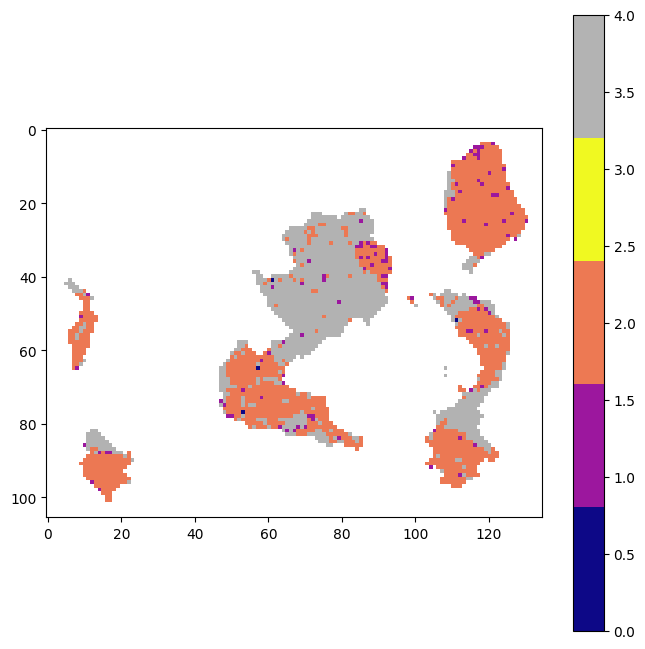

11186.svs Processed
'int' object has no attribute 'properties'
11787.svs Processed
10506.svs Processed


  0%|          | 0/87 [00:00<?, ?it/s]

  3%|▎         | 3/87 [00:01<00:41,  2.04it/s]

  5%|▍         | 4/87 [00:09<03:52,  2.80s/it]

  6%|▌         | 5/87 [00:17<06:14,  4.57s/it]

  7%|▋         | 6/87 [00:27<08:26,  6.26s/it]

  8%|▊         | 7/87 [00:39<10:44,  8.06s/it]

  9%|▉         | 8/87 [00:52<12:23,  9.41s/it]

 10%|█         | 9/87 [01:05<13:53, 10.68s/it]

 11%|█▏        | 10/87 [01:19<15:02, 11.72s/it]

 13%|█▎        | 11/87 [01:34<16:00, 12.64s/it]

 14%|█▍        | 12/87 [01:49<16:45, 13.41s/it]

 15%|█▍        | 13/87 [02:05<17:21, 14.08s/it]

 16%|█▌        | 14/87 [02:21<18:01, 14.81s/it]

 17%|█▋        | 15/87 [02:39<18:44, 15.62s/it]

 18%|█▊        | 16/87 [02:57<19:15, 16.28s/it]

 20%|█▉        | 17/87 [03:15<19:35, 16.80s/it]

 21%|██        | 18/87 [03:33<19:58, 17.36s/it]

 22%|██▏       | 19/87 [03:53<20:19, 17.93s/it]

 23%|██▎       | 20/87 [04:14<21:03, 18.86s/it]

 24%|██▍       | 21/87 [04:33<20:56, 19.03s/it]

 25%|██▌       | 22/87 [04:55<21:32, 19.88s/it]

 26%|██▋       | 23/87 [05:16<21:41, 20.34s/it]

 28%|██▊       | 24/87 [05:39<22:02, 20.99s/it]

 29%|██▊       | 25/87 [06:02<22:16, 21.55s/it]

 30%|██▉       | 26/87 [06:25<22:26, 22.08s/it]

 31%|███       | 27/87 [06:48<22:16, 22.27s/it]

 32%|███▏      | 28/87 [07:09<21:42, 22.08s/it]

 33%|███▎      | 29/87 [07:32<21:24, 22.15s/it]

 34%|███▍      | 30/87 [07:54<20:55, 22.02s/it]

 36%|███▌      | 31/87 [08:15<20:29, 21.95s/it]

 37%|███▋      | 32/87 [08:38<20:13, 22.07s/it]

 38%|███▊      | 33/87 [09:01<20:18, 22.56s/it]

 39%|███▉      | 34/87 [09:24<19:56, 22.58s/it]

 40%|████      | 35/87 [09:47<19:43, 22.76s/it]

 41%|████▏     | 36/87 [10:11<19:42, 23.19s/it]

 43%|████▎     | 37/87 [10:37<19:56, 23.93s/it]

 44%|████▎     | 38/87 [11:02<19:43, 24.14s/it]

 45%|████▍     | 39/87 [11:27<19:37, 24.52s/it]

 46%|████▌     | 40/87 [11:53<19:25, 24.80s/it]

 47%|████▋     | 41/87 [12:18<19:13, 25.08s/it]

 48%|████▊     | 42/87 [12:44<19:00, 25.34s/it]

 49%|████▉     | 43/87 [13:12<19:09, 26.12s/it]

 51%|█████     | 44/87 [13:38<18:45, 26.18s/it]

 52%|█████▏    | 45/87 [14:05<18:22, 26.24s/it]

 53%|█████▎    | 46/87 [14:32<18:10, 26.59s/it]

 54%|█████▍    | 47/87 [15:01<18:05, 27.13s/it]

 55%|█████▌    | 48/87 [15:30<18:00, 27.70s/it]

 56%|█████▋    | 49/87 [15:59<17:46, 28.06s/it]

 57%|█████▋    | 50/87 [16:30<17:51, 28.95s/it]

 59%|█████▊    | 51/87 [17:00<17:34, 29.30s/it]

 60%|█████▉    | 52/87 [17:32<17:37, 30.22s/it]

 61%|██████    | 53/87 [18:04<17:28, 30.84s/it]

 62%|██████▏   | 54/87 [18:37<17:14, 31.36s/it]

 63%|██████▎   | 55/87 [19:09<16:49, 31.54s/it]

 64%|██████▍   | 56/87 [19:40<16:18, 31.56s/it]

 66%|██████▌   | 57/87 [20:12<15:49, 31.66s/it]

 67%|██████▋   | 58/87 [20:45<15:28, 32.01s/it]

 68%|██████▊   | 59/87 [21:19<15:08, 32.46s/it]

 69%|██████▉   | 60/87 [21:51<14:34, 32.38s/it]

 70%|███████   | 61/87 [22:23<13:58, 32.25s/it]

 71%|███████▏  | 62/87 [22:57<13:42, 32.89s/it]

 72%|███████▏  | 63/87 [23:27<12:47, 31.96s/it]

 74%|███████▎  | 64/87 [23:54<11:38, 30.39s/it]

 75%|███████▍  | 65/87 [24:19<10:35, 28.90s/it]

 76%|███████▌  | 66/87 [24:43<09:33, 27.29s/it]

 77%|███████▋  | 67/87 [25:07<08:45, 26.27s/it]

 78%|███████▊  | 68/87 [25:29<07:59, 25.26s/it]

 79%|███████▉  | 69/87 [25:51<07:13, 24.08s/it]

 80%|████████  | 70/87 [26:10<06:23, 22.58s/it]

 82%|████████▏ | 71/87 [26:28<05:38, 21.14s/it]

 83%|████████▎ | 72/87 [26:45<05:00, 20.07s/it]

 84%|████████▍ | 73/87 [26:58<04:11, 17.97s/it]

 85%|████████▌ | 74/87 [27:10<03:27, 15.97s/it]

 86%|████████▌ | 75/87 [27:19<02:48, 14.03s/it]

 87%|████████▋ | 76/87 [27:28<02:15, 12.36s/it]

 89%|████████▊ | 77/87 [27:36<01:50, 11.05s/it]

 90%|████████▉ | 78/87 [27:44<01:32, 10.24s/it]

 91%|█████████ | 79/87 [27:52<01:16,  9.57s/it]

 92%|█████████▏| 80/87 [27:59<01:02,  8.87s/it]

 93%|█████████▎| 81/87 [28:06<00:48,  8.16s/it]

 94%|█████████▍| 82/87 [28:12<00:38,  7.67s/it]

 95%|█████████▌| 83/87 [28:18<00:28,  7.06s/it]

 97%|█████████▋| 84/87 [28:23<00:19,  6.40s/it]

100%|██████████| 87/87 [28:23<00:00, 19.58s/it]

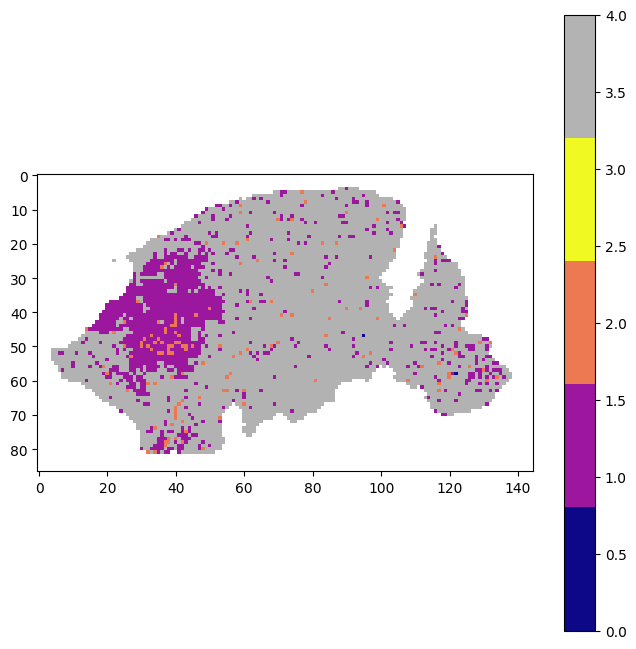

11185.svs Processed


  0%|          | 0/105 [00:00<?, ?it/s]

  2%|▏         | 2/105 [00:02<01:59,  1.16s/it]

  3%|▎         | 3/105 [00:06<04:18,  2.54s/it]

  4%|▍         | 4/105 [00:13<06:48,  4.04s/it]

  5%|▍         | 5/105 [00:21<08:58,  5.38s/it]

  6%|▌         | 6/105 [00:29<10:35,  6.42s/it]

  7%|▋         | 7/105 [00:37<11:20,  6.94s/it]

  8%|▊         | 8/105 [00:45<11:47,  7.29s/it]

  9%|▊         | 9/105 [00:55<13:03,  8.16s/it]

 10%|▉         | 10/105 [01:06<14:15,  9.01s/it]

 10%|█         | 11/105 [01:18<15:15,  9.74s/it]

 11%|█▏        | 12/105 [01:29<15:56, 10.28s/it]

 12%|█▏        | 13/105 [01:41<16:36, 10.83s/it]

 13%|█▎        | 14/105 [02:04<21:49, 14.39s/it]

 14%|█▍        | 15/105 [02:19<21:52, 14.58s/it]

 15%|█▌        | 16/105 [02:34<21:46, 14.68s/it]

 16%|█▌        | 17/105 [02:50<21:59, 14.99s/it]

 17%|█▋        | 18/105 [03:05<21:49, 15.05s/it]

 18%|█▊        | 19/105 [03:22<22:19, 15.58s/it]

 19%|█▉        | 20/105 [03:38<22:18, 15.75s/it]

 20%|██        | 21/105 [03:54<22:13, 15.87s/it]

 21%|██        | 22/105 [04:11<22:22, 16.17s/it]

 22%|██▏       | 23/105 [04:28<22:33, 16.50s/it]

 23%|██▎       | 24/105 [04:46<22:56, 16.99s/it]

 24%|██▍       | 25/105 [05:04<22:52, 17.16s/it]

 25%|██▍       | 26/105 [05:22<23:11, 17.61s/it]

 26%|██▌       | 27/105 [05:41<23:22, 17.98s/it]

 27%|██▋       | 28/105 [06:00<23:11, 18.07s/it]

 28%|██▊       | 29/105 [06:19<23:21, 18.44s/it]

 29%|██▊       | 30/105 [06:37<22:52, 18.30s/it]

 30%|██▉       | 31/105 [06:56<22:45, 18.45s/it]

 30%|███       | 32/105 [07:14<22:32, 18.52s/it]

 31%|███▏      | 33/105 [07:34<22:46, 18.97s/it]

 32%|███▏      | 34/105 [07:56<23:31, 19.89s/it]

 33%|███▎      | 35/105 [08:18<23:44, 20.35s/it]

 34%|███▍      | 36/105 [08:39<23:37, 20.54s/it]

 35%|███▌      | 37/105 [08:59<23:01, 20.32s/it]

 36%|███▌      | 38/105 [09:20<23:02, 20.64s/it]

 37%|███▋      | 39/105 [09:41<22:41, 20.63s/it]

 38%|███▊      | 40/105 [10:02<22:26, 20.72s/it]

 39%|███▉      | 41/105 [10:23<22:17, 20.90s/it]

 40%|████      | 42/105 [10:46<22:33, 21.49s/it]

 41%|████      | 43/105 [11:08<22:34, 21.84s/it]

 42%|████▏     | 44/105 [11:30<22:07, 21.77s/it]

 43%|████▎     | 45/105 [11:54<22:25, 22.43s/it]

 44%|████▍     | 46/105 [12:16<22:01, 22.39s/it]

 45%|████▍     | 47/105 [12:40<22:08, 22.90s/it]

 46%|████▌     | 48/105 [13:02<21:29, 22.63s/it]

 47%|████▋     | 49/105 [13:25<21:15, 22.77s/it]

 48%|████▊     | 50/105 [13:48<20:55, 22.83s/it]

 49%|████▊     | 51/105 [14:11<20:26, 22.71s/it]

 50%|████▉     | 52/105 [14:34<20:08, 22.81s/it]

 50%|█████     | 53/105 [14:58<20:03, 23.14s/it]

 51%|█████▏    | 54/105 [15:23<20:04, 23.62s/it]

 52%|█████▏    | 55/105 [15:47<19:47, 23.75s/it]

 53%|█████▎    | 56/105 [16:13<20:06, 24.62s/it]

 54%|█████▍    | 57/105 [16:38<19:40, 24.59s/it]

 55%|█████▌    | 58/105 [17:02<19:14, 24.56s/it]

 56%|█████▌    | 59/105 [17:28<19:12, 25.05s/it]

 57%|█████▋    | 60/105 [17:54<18:49, 25.10s/it]

 58%|█████▊    | 61/105 [18:17<18:04, 24.64s/it]

 59%|█████▉    | 62/105 [18:40<17:20, 24.21s/it]

 60%|██████    | 63/105 [19:04<16:42, 23.87s/it]

 61%|██████    | 64/105 [19:28<16:20, 23.91s/it]

 62%|██████▏   | 65/105 [19:51<15:47, 23.68s/it]

 63%|██████▎   | 66/105 [20:15<15:35, 24.00s/it]

 64%|██████▍   | 67/105 [20:40<15:14, 24.08s/it]

 65%|██████▍   | 68/105 [21:05<15:02, 24.40s/it]

 66%|██████▌   | 69/105 [21:29<14:36, 24.34s/it]

 67%|██████▋   | 70/105 [21:53<14:08, 24.24s/it]

 68%|██████▊   | 71/105 [22:16<13:35, 23.98s/it]

 69%|██████▊   | 72/105 [22:40<13:06, 23.84s/it]

 70%|██████▉   | 73/105 [23:03<12:37, 23.66s/it]

 70%|███████   | 74/105 [23:27<12:18, 23.82s/it]

 71%|███████▏  | 75/105 [23:53<12:07, 24.25s/it]

 72%|███████▏  | 76/105 [24:17<11:42, 24.23s/it]

 73%|███████▎  | 77/105 [24:40<11:08, 23.87s/it]

 74%|███████▍  | 78/105 [25:04<10:45, 23.90s/it]

 75%|███████▌  | 79/105 [25:28<10:23, 23.97s/it]

 76%|███████▌  | 80/105 [25:52<10:01, 24.06s/it]

 77%|███████▋  | 81/105 [26:15<09:27, 23.65s/it]

 78%|███████▊  | 82/105 [26:37<08:53, 23.20s/it]

 79%|███████▉  | 83/105 [27:00<08:27, 23.06s/it]

 80%|████████  | 84/105 [27:22<07:57, 22.72s/it]

 81%|████████  | 85/105 [27:44<07:30, 22.53s/it]

 82%|████████▏ | 86/105 [28:09<07:21, 23.24s/it]

 83%|████████▎ | 87/105 [28:31<06:51, 22.88s/it]

 84%|████████▍ | 88/105 [28:54<06:30, 22.94s/it]

 85%|████████▍ | 89/105 [29:16<06:03, 22.71s/it]

 86%|████████▌ | 90/105 [29:38<05:35, 22.37s/it]

 87%|████████▋ | 91/105 [30:02<05:21, 22.99s/it]

 88%|████████▊ | 92/105 [30:27<05:05, 23.52s/it]

 89%|████████▊ | 93/105 [30:49<04:38, 23.22s/it]

 90%|████████▉ | 94/105 [31:12<04:15, 23.21s/it]

 90%|█████████ | 95/105 [31:34<03:46, 22.60s/it]

 91%|█████████▏| 96/105 [31:54<03:17, 22.00s/it]

 92%|█████████▏| 97/105 [32:11<02:43, 20.42s/it]

 93%|█████████▎| 98/105 [32:22<02:04, 17.75s/it]

 94%|█████████▍| 99/105 [32:31<01:28, 14.83s/it]

 95%|█████████▌| 100/105 [32:37<01:01, 12.30s/it]

 96%|█████████▌| 101/105 [32:41<00:39,  9.84s/it]

 97%|█████████▋| 102/105 [32:44<00:23,  7.76s/it]

100%|██████████| 105/105 [32:44<00:00, 18.71s/it]

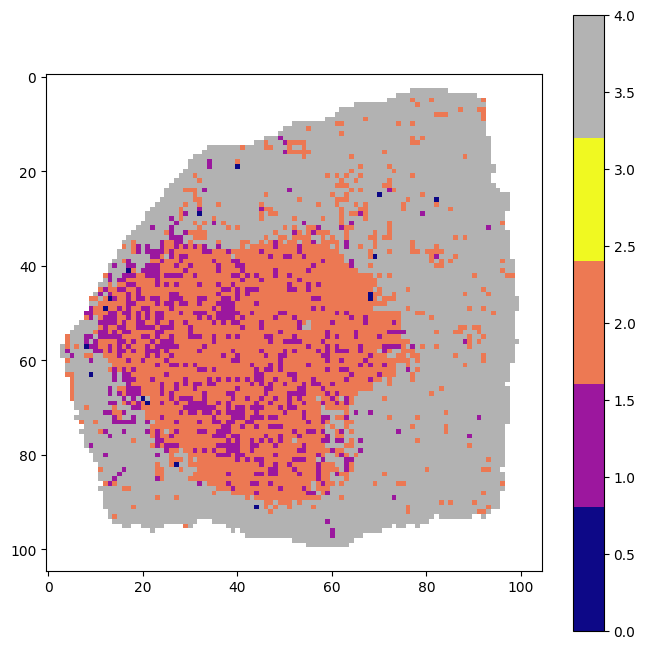

10499.svs Processed


  0%|          | 0/119 [00:00<?, ?it/s]

  1%|          | 1/119 [00:35<1:10:00, 35.60s/it]

  2%|▏         | 2/119 [01:04<1:01:40, 31.63s/it]

  3%|▎         | 3/119 [01:04<33:36, 17.38s/it]  

  4%|▍         | 5/119 [01:05<14:27,  7.61s/it]

  5%|▌         | 6/119 [01:07<11:38,  6.18s/it]

  6%|▌         | 7/119 [01:11<10:10,  5.45s/it]

  7%|▋         | 8/119 [01:16<09:37,  5.20s/it]

  8%|▊         | 9/119 [01:22<10:23,  5.67s/it]

  8%|▊         | 10/119 [01:30<11:36,  6.39s/it]

  9%|▉         | 11/119 [01:39<12:44,  7.08s/it]

 10%|█         | 12/119 [01:51<15:07,  8.48s/it]

 11%|█         | 13/119 [02:06<18:33, 10.50s/it]

 12%|█▏        | 14/119 [02:26<23:13, 13.27s/it]

 13%|█▎        | 15/119 [02:50<28:23, 16.38s/it]

 13%|█▎        | 16/119 [03:12<31:00, 18.06s/it]

 14%|█▍        | 17/119 [03:34<33:07, 19.48s/it]

 15%|█▌        | 18/119 [03:57<34:39, 20.59s/it]

 16%|█▌        | 19/119 [04:20<35:02, 21.03s/it]

 17%|█▋        | 20/119 [04:43<35:46, 21.68s/it]

 18%|█▊        | 21/119 [05:06<36:13, 22.17s/it]

 18%|█▊        | 22/119 [05:31<37:11, 23.01s/it]

 19%|█▉        | 23/119 [05:56<37:45, 23.60s/it]

 20%|██        | 24/119 [06:20<37:36, 23.76s/it]

 21%|██        | 25/119 [06:44<37:21, 23.84s/it]

 22%|██▏       | 26/119 [07:08<37:09, 23.97s/it]

 23%|██▎       | 27/119 [07:34<37:26, 24.42s/it]

 24%|██▎       | 28/119 [07:59<37:24, 24.66s/it]

 24%|██▍       | 29/119 [08:24<37:13, 24.82s/it]

 25%|██▌       | 30/119 [08:47<35:58, 24.25s/it]

 26%|██▌       | 31/119 [09:11<35:28, 24.19s/it]

 27%|██▋       | 32/119 [09:35<34:40, 23.91s/it]

 28%|██▊       | 33/119 [09:59<34:17, 23.93s/it]

 29%|██▊       | 34/119 [10:22<33:45, 23.83s/it]

 29%|██▉       | 35/119 [10:47<33:42, 24.08s/it]

 30%|███       | 36/119 [11:11<33:11, 23.99s/it]

 31%|███       | 37/119 [11:35<32:57, 24.12s/it]

 32%|███▏      | 38/119 [12:00<32:43, 24.24s/it]

 33%|███▎      | 39/119 [12:24<32:27, 24.35s/it]

 34%|███▎      | 40/119 [12:48<31:49, 24.18s/it]

 34%|███▍      | 41/119 [13:12<31:16, 24.06s/it]

 35%|███▌      | 42/119 [13:38<31:51, 24.82s/it]

 36%|███▌      | 43/119 [14:04<31:37, 24.97s/it]

 37%|███▋      | 44/119 [14:31<32:02, 25.63s/it]

 38%|███▊      | 45/119 [14:56<31:34, 25.60s/it]

 39%|███▊      | 46/119 [15:24<31:46, 26.12s/it]

 39%|███▉      | 47/119 [15:49<31:01, 25.85s/it]

 40%|████      | 48/119 [16:15<30:44, 25.98s/it]

 41%|████      | 49/119 [16:41<30:05, 25.80s/it]

 42%|████▏     | 50/119 [17:07<29:55, 26.03s/it]

 43%|████▎     | 51/119 [17:37<30:43, 27.11s/it]

 44%|████▎     | 52/119 [18:03<29:52, 26.75s/it]

 45%|████▍     | 53/119 [18:29<29:16, 26.61s/it]

 45%|████▌     | 54/119 [18:56<28:51, 26.64s/it]

 46%|████▌     | 55/119 [19:22<28:26, 26.66s/it]

 47%|████▋     | 56/119 [19:50<28:10, 26.84s/it]

 48%|████▊     | 57/119 [20:15<27:09, 26.28s/it]

 49%|████▊     | 58/119 [20:40<26:20, 25.91s/it]

 50%|████▉     | 59/119 [21:07<26:15, 26.26s/it]

 50%|█████     | 60/119 [21:32<25:30, 25.94s/it]

 51%|█████▏    | 61/119 [21:57<24:42, 25.57s/it]

 52%|█████▏    | 62/119 [22:20<23:45, 25.01s/it]

 53%|█████▎    | 63/119 [22:45<23:17, 24.95s/it]

 54%|█████▍    | 64/119 [23:11<23:08, 25.24s/it]

 55%|█████▍    | 65/119 [23:39<23:21, 25.96s/it]

 55%|█████▌    | 66/119 [24:05<22:55, 25.94s/it]

 56%|█████▋    | 67/119 [24:30<22:28, 25.92s/it]

 57%|█████▋    | 68/119 [24:58<22:23, 26.34s/it]

 58%|█████▊    | 69/119 [25:24<21:49, 26.19s/it]

 59%|█████▉    | 70/119 [25:50<21:30, 26.33s/it]

 60%|█████▉    | 71/119 [26:15<20:44, 25.93s/it]

 61%|██████    | 72/119 [26:41<20:15, 25.85s/it]

 61%|██████▏   | 73/119 [27:08<20:02, 26.14s/it]

 62%|██████▏   | 74/119 [27:35<19:51, 26.48s/it]

 63%|██████▎   | 75/119 [28:01<19:18, 26.34s/it]

 64%|██████▍   | 76/119 [28:28<19:03, 26.60s/it]

 65%|██████▍   | 77/119 [28:54<18:30, 26.45s/it]

 66%|██████▌   | 78/119 [29:20<17:51, 26.14s/it]

 66%|██████▋   | 79/119 [29:44<17:01, 25.54s/it]

 67%|██████▋   | 80/119 [30:08<16:18, 25.08s/it]

 68%|██████▊   | 81/119 [30:33<15:51, 25.03s/it]

 69%|██████▉   | 82/119 [31:00<15:53, 25.78s/it]

 70%|██████▉   | 83/119 [31:26<15:23, 25.66s/it]

 71%|███████   | 84/119 [31:52<15:02, 25.78s/it]

 71%|███████▏  | 85/119 [32:17<14:31, 25.63s/it]

 72%|███████▏  | 86/119 [32:41<13:50, 25.18s/it]

 73%|███████▎  | 87/119 [33:04<12:58, 24.34s/it]

 74%|███████▍  | 88/119 [33:29<12:46, 24.73s/it]

 75%|███████▍  | 89/119 [33:52<12:04, 24.16s/it]

 76%|███████▌  | 90/119 [34:15<11:32, 23.87s/it]

 76%|███████▋  | 91/119 [34:38<10:55, 23.43s/it]

 77%|███████▋  | 92/119 [35:02<10:36, 23.58s/it]

 78%|███████▊  | 93/119 [35:24<10:05, 23.28s/it]

 79%|███████▉  | 94/119 [35:48<09:48, 23.53s/it]

 80%|███████▉  | 95/119 [36:11<09:16, 23.17s/it]

 81%|████████  | 96/119 [36:31<08:36, 22.48s/it]

 82%|████████▏ | 97/119 [36:53<08:07, 22.16s/it]

 82%|████████▏ | 98/119 [37:14<07:40, 21.91s/it]

 83%|████████▎ | 99/119 [37:39<07:34, 22.71s/it]

 84%|████████▍ | 100/119 [37:59<07:00, 22.11s/it]

 85%|████████▍ | 101/119 [38:19<06:22, 21.27s/it]

 86%|████████▌ | 102/119 [38:39<05:57, 21.02s/it]

 87%|████████▋ | 103/119 [38:58<05:24, 20.29s/it]

 87%|████████▋ | 104/119 [39:15<04:48, 19.25s/it]

 88%|████████▊ | 105/119 [39:32<04:22, 18.78s/it]

 89%|████████▉ | 106/119 [39:50<04:00, 18.47s/it]

 90%|████████▉ | 107/119 [40:06<03:31, 17.64s/it]

 91%|█████████ | 108/119 [40:20<03:02, 16.59s/it]

 92%|█████████▏| 109/119 [40:36<02:43, 16.32s/it]

 92%|█████████▏| 110/119 [40:49<02:19, 15.47s/it]

 93%|█████████▎| 111/119 [41:02<01:58, 14.78s/it]

 94%|█████████▍| 112/119 [41:13<01:35, 13.60s/it]

 95%|█████████▍| 113/119 [41:23<01:15, 12.54s/it]

 96%|█████████▌| 114/119 [41:32<00:57, 11.50s/it]

 97%|█████████▋| 115/119 [41:39<00:40, 10.06s/it]

 97%|█████████▋| 116/119 [41:40<00:22,  7.50s/it]

100%|██████████| 119/119 [41:40<00:00, 21.02s/it]

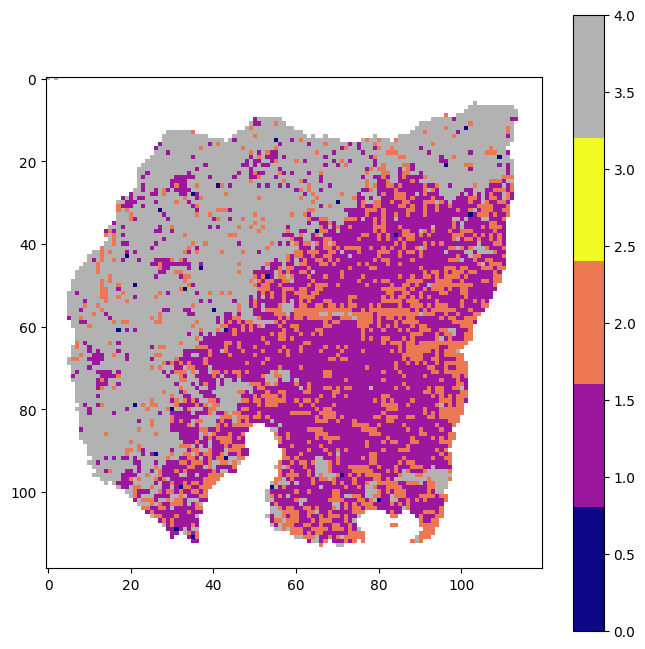

10878.svs Processed
10401.svs Processed
11262.svs Processed


  0%|          | 0/81 [00:00<?, ?it/s]

  2%|▏         | 2/81 [00:00<00:33,  2.38it/s]

  4%|▎         | 3/81 [00:02<01:16,  1.02it/s]

  5%|▍         | 4/81 [00:06<02:29,  1.94s/it]

  6%|▌         | 5/81 [00:10<03:42,  2.92s/it]

  7%|▋         | 6/81 [00:19<06:11,  4.95s/it]

  9%|▊         | 7/81 [00:28<07:38,  6.19s/it]

 10%|▉         | 8/81 [00:38<08:44,  7.18s/it]

 11%|█         | 9/81 [00:49<10:01,  8.36s/it]

 12%|█▏        | 10/81 [01:00<11:04,  9.36s/it]

 14%|█▎        | 11/81 [01:13<12:10, 10.44s/it]

 15%|█▍        | 12/81 [01:27<13:15, 11.53s/it]

 16%|█▌        | 13/81 [01:42<14:17, 12.61s/it]

 17%|█▋        | 14/81 [01:56<14:34, 13.05s/it]

 19%|█▊        | 15/81 [02:10<14:31, 13.21s/it]

 20%|█▉        | 16/81 [02:23<14:12, 13.12s/it]

 21%|██        | 17/81 [02:36<13:58, 13.10s/it]

 22%|██▏       | 18/81 [02:49<13:43, 13.07s/it]

 23%|██▎       | 19/81 [03:02<13:38, 13.19s/it]

 25%|██▍       | 20/81 [03:14<12:53, 12.69s/it]

 26%|██▌       | 21/81 [03:26<12:25, 12.42s/it]

 27%|██▋       | 22/81 [03:40<12:48, 13.03s/it]

 28%|██▊       | 23/81 [03:56<13:29, 13.95s/it]

 30%|██▉       | 24/81 [04:15<14:30, 15.27s/it]

 31%|███       | 25/81 [04:34<15:28, 16.57s/it]

 32%|███▏      | 26/81 [04:54<16:03, 17.52s/it]

 33%|███▎      | 27/81 [05:16<16:52, 18.76s/it]

 35%|███▍      | 28/81 [05:35<16:48, 19.03s/it]

 36%|███▌      | 29/81 [05:55<16:37, 19.19s/it]

 37%|███▋      | 30/81 [06:14<16:22, 19.27s/it]

 38%|███▊      | 31/81 [06:35<16:22, 19.64s/it]

 40%|███▉      | 32/81 [06:55<16:06, 19.73s/it]

 41%|████      | 33/81 [07:15<15:59, 19.99s/it]

 42%|████▏     | 34/81 [07:37<16:01, 20.46s/it]

 43%|████▎     | 35/81 [08:00<16:16, 21.23s/it]

 44%|████▍     | 36/81 [08:20<15:43, 20.96s/it]

 46%|████▌     | 37/81 [08:40<15:08, 20.64s/it]

 47%|████▋     | 38/81 [09:02<15:00, 20.95s/it]

 48%|████▊     | 39/81 [09:23<14:38, 20.91s/it]

 49%|████▉     | 40/81 [09:43<14:16, 20.89s/it]

 51%|█████     | 41/81 [10:07<14:27, 21.68s/it]

 52%|█████▏    | 42/81 [10:30<14:24, 22.15s/it]

 53%|█████▎    | 43/81 [10:52<14:00, 22.11s/it]

 54%|█████▍    | 44/81 [11:13<13:27, 21.83s/it]

 56%|█████▌    | 45/81 [11:36<13:12, 22.03s/it]

 57%|█████▋    | 46/81 [11:59<13:00, 22.31s/it]

 58%|█████▊    | 47/81 [12:21<12:42, 22.41s/it]

 59%|█████▉    | 48/81 [12:42<12:02, 21.91s/it]

 60%|██████    | 49/81 [13:05<11:53, 22.29s/it]

 62%|██████▏   | 50/81 [13:27<11:26, 22.15s/it]

 63%|██████▎   | 51/81 [13:48<10:49, 21.65s/it]

 64%|██████▍   | 52/81 [14:11<10:39, 22.05s/it]

 65%|██████▌   | 53/81 [14:31<10:03, 21.54s/it]

 67%|██████▋   | 54/81 [14:51<09:27, 21.02s/it]

 68%|██████▊   | 55/81 [15:11<09:03, 20.91s/it]

 69%|██████▉   | 56/81 [15:34<08:54, 21.38s/it]

 70%|███████   | 57/81 [15:57<08:42, 21.77s/it]

 72%|███████▏  | 58/81 [16:17<08:08, 21.24s/it]

 73%|███████▎  | 59/81 [16:37<07:38, 20.84s/it]

 74%|███████▍  | 60/81 [16:57<07:15, 20.75s/it]

 75%|███████▌  | 61/81 [17:18<06:58, 20.91s/it]

 77%|███████▋  | 62/81 [17:39<06:33, 20.70s/it]

 78%|███████▊  | 63/81 [17:59<06:11, 20.65s/it]

 79%|███████▉  | 64/81 [18:20<05:50, 20.63s/it]

 80%|████████  | 65/81 [18:44<05:45, 21.60s/it]

 81%|████████▏ | 66/81 [19:03<05:15, 21.06s/it]

 83%|████████▎ | 67/81 [19:24<04:54, 21.03s/it]

 84%|████████▍ | 68/81 [19:44<04:29, 20.71s/it]

 85%|████████▌ | 69/81 [20:03<03:59, 20.00s/it]

 86%|████████▋ | 70/81 [20:20<03:30, 19.14s/it]

 88%|████████▊ | 71/81 [20:38<03:10, 19.00s/it]

 89%|████████▉ | 72/81 [20:54<02:41, 17.96s/it]

 90%|█████████ | 73/81 [21:07<02:12, 16.52s/it]

 91%|█████████▏| 74/81 [21:19<01:45, 15.01s/it]

 93%|█████████▎| 75/81 [21:28<01:19, 13.19s/it]

 94%|█████████▍| 76/81 [21:35<00:57, 11.59s/it]

 95%|█████████▌| 77/81 [21:42<00:40, 10.20s/it]

 96%|█████████▋| 78/81 [21:49<00:27,  9.00s/it]

 98%|█████████▊| 79/81 [21:53<00:15,  7.66s/it]

 99%|█████████▉| 80/81 [21:54<00:05,  5.74s/it]

100%|██████████| 81/81 [21:54<00:00, 16.23s/it]

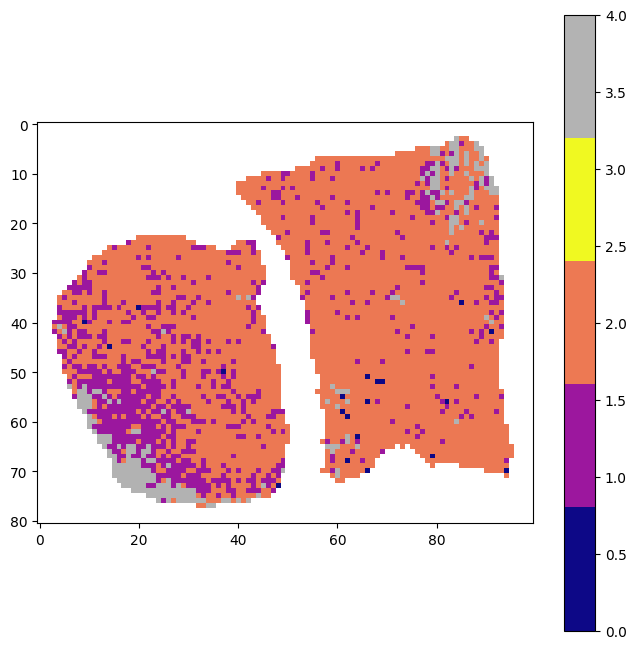

9532.svs Processed
11253.svs Processed
11336.svs Processed
11279.svs Processed
11345.svs Processed
11248.svs Processed


  0%|          | 0/91 [00:00<?, ?it/s]

  2%|▏         | 2/91 [00:00<00:10,  8.61it/s]

  3%|▎         | 3/91 [00:03<01:51,  1.26s/it]

  4%|▍         | 4/91 [00:12<06:19,  4.36s/it]

  5%|▌         | 5/91 [00:26<11:12,  7.82s/it]

  7%|▋         | 6/91 [00:41<14:10, 10.01s/it]

  8%|▊         | 7/91 [00:59<17:35, 12.56s/it]

  9%|▉         | 8/91 [01:18<20:11, 14.60s/it]

 10%|▉         | 9/91 [01:40<23:10, 16.96s/it]

 11%|█         | 10/91 [02:03<25:17, 18.74s/it]

 12%|█▏        | 11/91 [02:25<26:30, 19.89s/it]

 13%|█▎        | 12/91 [02:48<27:14, 20.69s/it]

 14%|█▍        | 13/91 [03:12<28:05, 21.61s/it]

 15%|█▌        | 14/91 [03:39<29:56, 23.33s/it]

 16%|█▋        | 15/91 [04:05<30:27, 24.05s/it]

 18%|█▊        | 16/91 [04:32<31:23, 25.11s/it]

 19%|█▊        | 17/91 [04:58<31:03, 25.18s/it]

 20%|█▉        | 18/91 [05:23<30:46, 25.29s/it]

 21%|██        | 19/91 [05:49<30:28, 25.39s/it]

 22%|██▏       | 20/91 [06:14<29:59, 25.35s/it]

 23%|██▎       | 21/91 [06:43<30:51, 26.45s/it]

 24%|██▍       | 22/91 [07:11<30:55, 26.89s/it]

 25%|██▌       | 23/91 [07:38<30:23, 26.81s/it]

 26%|██▋       | 24/91 [08:04<29:41, 26.60s/it]

 27%|██▋       | 25/91 [08:29<28:46, 26.16s/it]

 29%|██▊       | 26/91 [08:54<28:07, 25.96s/it]

 30%|██▉       | 27/91 [09:19<27:14, 25.53s/it]

 31%|███       | 28/91 [09:44<26:47, 25.52s/it]

 32%|███▏      | 29/91 [10:10<26:20, 25.50s/it]

 33%|███▎      | 30/91 [10:34<25:36, 25.19s/it]

 34%|███▍      | 31/91 [10:59<25:01, 25.02s/it]

 35%|███▌      | 32/91 [11:22<24:05, 24.49s/it]

 36%|███▋      | 33/91 [11:45<23:18, 24.12s/it]

 37%|███▋      | 34/91 [12:08<22:38, 23.83s/it]

 38%|███▊      | 35/91 [12:33<22:18, 23.90s/it]

 40%|███▉      | 36/91 [12:56<21:44, 23.72s/it]

 41%|████      | 37/91 [13:18<20:55, 23.25s/it]

 42%|████▏     | 38/91 [13:40<20:20, 23.02s/it]

 43%|████▎     | 39/91 [14:02<19:35, 22.60s/it]

 44%|████▍     | 40/91 [14:25<19:14, 22.63s/it]

 45%|████▌     | 41/91 [14:47<18:43, 22.47s/it]

 46%|████▌     | 42/91 [15:08<18:07, 22.20s/it]

 47%|████▋     | 43/91 [15:30<17:30, 21.89s/it]

 48%|████▊     | 44/91 [15:49<16:34, 21.16s/it]

 49%|████▉     | 45/91 [16:10<16:08, 21.06s/it]

 51%|█████     | 46/91 [16:33<16:15, 21.68s/it]

 52%|█████▏    | 47/91 [16:59<16:52, 23.01s/it]

 53%|█████▎    | 48/91 [17:23<16:42, 23.32s/it]

 54%|█████▍    | 49/91 [17:48<16:38, 23.78s/it]

 55%|█████▍    | 50/91 [18:16<17:03, 24.97s/it]

 56%|█████▌    | 51/91 [18:43<17:04, 25.60s/it]

 57%|█████▋    | 52/91 [19:12<17:17, 26.60s/it]

 58%|█████▊    | 53/91 [19:40<17:09, 27.10s/it]

 59%|█████▉    | 54/91 [20:13<17:46, 28.83s/it]

 60%|██████    | 55/91 [20:43<17:36, 29.34s/it]

 62%|██████▏   | 56/91 [21:16<17:36, 30.18s/it]

 63%|██████▎   | 57/91 [21:48<17:32, 30.95s/it]

 64%|██████▎   | 58/91 [22:20<17:03, 31.01s/it]

 65%|██████▍   | 59/91 [22:51<16:35, 31.11s/it]

 66%|██████▌   | 60/91 [23:22<16:08, 31.24s/it]

 67%|██████▋   | 61/91 [23:59<16:24, 32.81s/it]

 68%|██████▊   | 62/91 [24:37<16:38, 34.43s/it]

 69%|██████▉   | 63/91 [25:12<16:08, 34.58s/it]

 70%|███████   | 64/91 [25:44<15:15, 33.91s/it]

 71%|███████▏  | 65/91 [26:16<14:24, 33.25s/it]

 73%|███████▎  | 66/91 [26:49<13:49, 33.19s/it]

 74%|███████▎  | 67/91 [27:21<13:09, 32.89s/it]

 75%|███████▍  | 68/91 [27:52<12:22, 32.27s/it]

 76%|███████▌  | 69/91 [28:21<11:29, 31.34s/it]

 77%|███████▋  | 70/91 [28:54<11:08, 31.82s/it]

 78%|███████▊  | 71/91 [29:24<10:22, 31.11s/it]

 79%|███████▉  | 72/91 [29:55<09:54, 31.27s/it]

 80%|████████  | 73/91 [30:24<09:10, 30.59s/it]

 81%|████████▏ | 74/91 [30:53<08:30, 30.04s/it]

 82%|████████▏ | 75/91 [31:19<07:42, 28.90s/it]

 84%|████████▎ | 76/91 [31:41<06:40, 26.69s/it]

 85%|████████▍ | 77/91 [32:02<05:48, 24.90s/it]

 86%|████████▌ | 78/91 [32:20<05:00, 23.08s/it]

 87%|████████▋ | 79/91 [32:39<04:18, 21.58s/it]

 88%|████████▊ | 80/91 [32:57<03:47, 20.65s/it]

 89%|████████▉ | 81/91 [33:13<03:11, 19.14s/it]

 90%|█████████ | 82/91 [33:28<02:41, 17.94s/it]

 91%|█████████ | 83/91 [33:40<02:09, 16.19s/it]

 92%|█████████▏| 84/91 [33:51<01:42, 14.66s/it]

 93%|█████████▎| 85/91 [33:59<01:15, 12.60s/it]

 95%|█████████▍| 86/91 [34:03<00:50, 10.06s/it]

 96%|█████████▌| 87/91 [34:04<00:29,  7.47s/it]

100%|██████████| 91/91 [34:04<00:00, 22.47s/it]

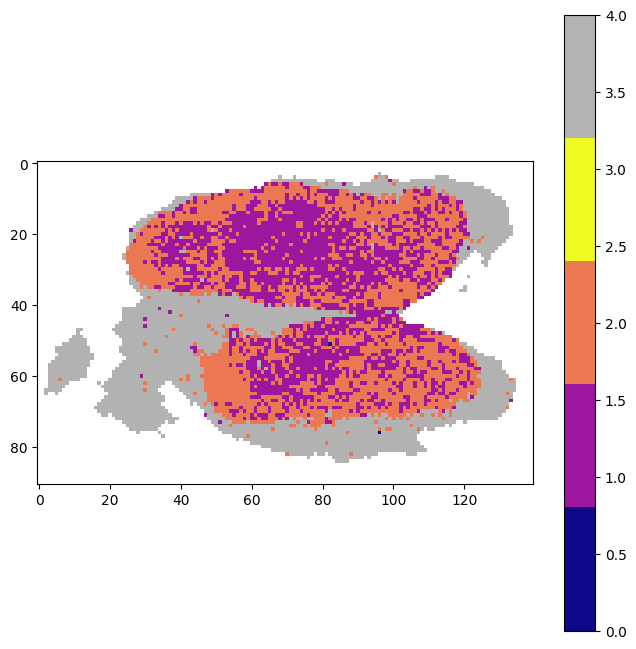

11471.svs Processed
11429.svs Processed
9463.svs Processed
11240.svs Processed
10989.svs Processed
'int' object has no attribute 'properties'
10419.svs Processed


  0%|          | 0/96 [00:00<?, ?it/s]

  3%|▎         | 3/96 [00:02<01:10,  1.32it/s]

  4%|▍         | 4/96 [00:05<02:32,  1.66s/it]

  5%|▌         | 5/96 [00:10<04:05,  2.69s/it]

  6%|▋         | 6/96 [00:15<05:12,  3.47s/it]

  7%|▋         | 7/96 [00:21<06:02,  4.07s/it]

  8%|▊         | 8/96 [00:27<06:44,  4.60s/it]

  9%|▉         | 9/96 [00:33<07:26,  5.13s/it]

 10%|█         | 10/96 [00:41<08:44,  6.09s/it]

 11%|█▏        | 11/96 [00:50<09:55,  7.00s/it]

 12%|█▎        | 12/96 [00:59<10:27,  7.48s/it]

 14%|█▎        | 13/96 [01:09<11:14,  8.13s/it]

 15%|█▍        | 14/96 [01:18<11:32,  8.44s/it]

 16%|█▌        | 15/96 [01:27<11:48,  8.75s/it]

 17%|█▋        | 16/96 [01:38<12:21,  9.27s/it]

 18%|█▊        | 17/96 [01:49<13:07,  9.96s/it]

 19%|█▉        | 18/96 [02:01<13:45, 10.59s/it]

 20%|█▉        | 19/96 [02:16<15:04, 11.74s/it]

 21%|██        | 20/96 [02:33<16:55, 13.37s/it]

 22%|██▏       | 21/96 [02:49<17:52, 14.30s/it]

 23%|██▎       | 22/96 [03:06<18:37, 15.11s/it]

 24%|██▍       | 23/96 [03:25<19:47, 16.27s/it]

 25%|██▌       | 24/96 [03:46<21:02, 17.53s/it]

 26%|██▌       | 25/96 [04:07<22:08, 18.71s/it]

 27%|██▋       | 26/96 [04:32<24:01, 20.60s/it]

 28%|██▊       | 27/96 [04:56<24:38, 21.42s/it]

 29%|██▉       | 28/96 [05:20<25:08, 22.19s/it]

 30%|███       | 29/96 [05:45<25:45, 23.07s/it]

 31%|███▏      | 30/96 [06:09<25:50, 23.49s/it]

 32%|███▏      | 31/96 [06:33<25:36, 23.64s/it]

 33%|███▎      | 32/96 [06:57<25:12, 23.64s/it]

 34%|███▍      | 33/96 [07:23<25:39, 24.44s/it]

 35%|███▌      | 34/96 [07:51<26:21, 25.51s/it]

 36%|███▋      | 35/96 [08:18<26:17, 25.85s/it]

 38%|███▊      | 36/96 [08:45<26:14, 26.25s/it]

 39%|███▊      | 37/96 [09:13<26:24, 26.85s/it]

 40%|███▉      | 38/96 [09:39<25:38, 26.52s/it]

 41%|████      | 39/96 [10:06<25:21, 26.70s/it]

 42%|████▏     | 40/96 [10:34<25:19, 27.14s/it]

 43%|████▎     | 41/96 [11:02<25:00, 27.28s/it]

 44%|████▍     | 42/96 [11:31<24:55, 27.70s/it]

 45%|████▍     | 43/96 [12:00<24:54, 28.20s/it]

 46%|████▌     | 44/96 [12:30<25:01, 28.88s/it]

 47%|████▋     | 45/96 [13:01<24:54, 29.31s/it]

 48%|████▊     | 46/96 [13:30<24:29, 29.40s/it]

 49%|████▉     | 47/96 [14:02<24:36, 30.12s/it]

 50%|█████     | 48/96 [14:32<24:06, 30.13s/it]

 51%|█████     | 49/96 [15:05<24:11, 30.89s/it]

 52%|█████▏    | 50/96 [15:36<23:41, 30.91s/it]

 53%|█████▎    | 51/96 [16:07<23:09, 30.87s/it]

 54%|█████▍    | 52/96 [16:38<22:45, 31.03s/it]

 55%|█████▌    | 53/96 [17:08<21:59, 30.68s/it]

 56%|█████▋    | 54/96 [17:39<21:34, 30.82s/it]

 57%|█████▋    | 55/96 [18:09<20:53, 30.57s/it]

 58%|█████▊    | 56/96 [18:39<20:08, 30.22s/it]

 59%|█████▉    | 57/96 [19:10<19:53, 30.61s/it]

 60%|██████    | 58/96 [19:39<19:08, 30.21s/it]

 61%|██████▏   | 59/96 [20:10<18:46, 30.44s/it]

 62%|██████▎   | 60/96 [20:44<18:46, 31.30s/it]

 64%|██████▎   | 61/96 [21:15<18:16, 31.33s/it]

 65%|██████▍   | 62/96 [21:47<17:47, 31.39s/it]

 66%|██████▌   | 63/96 [22:17<17:03, 31.02s/it]

 67%|██████▋   | 64/96 [22:47<16:22, 30.72s/it]

 68%|██████▊   | 65/96 [23:20<16:13, 31.39s/it]

 69%|██████▉   | 66/96 [23:51<15:37, 31.25s/it]

 70%|██████▉   | 67/96 [24:22<15:07, 31.30s/it]

 71%|███████   | 68/96 [24:53<14:34, 31.22s/it]

 72%|███████▏  | 69/96 [25:25<14:08, 31.42s/it]

 73%|███████▎  | 70/96 [25:56<13:34, 31.31s/it]

 74%|███████▍  | 71/96 [26:27<13:01, 31.28s/it]

 75%|███████▌  | 72/96 [27:00<12:38, 31.62s/it]

 76%|███████▌  | 73/96 [27:33<12:17, 32.08s/it]

 77%|███████▋  | 74/96 [28:04<11:42, 31.95s/it]

 78%|███████▊  | 75/96 [28:36<11:11, 31.96s/it]

 79%|███████▉  | 76/96 [29:07<10:33, 31.68s/it]

 80%|████████  | 77/96 [29:39<10:04, 31.79s/it]

 81%|████████▏ | 78/96 [30:12<09:33, 31.86s/it]

 82%|████████▏ | 79/96 [30:44<09:04, 32.05s/it]

 83%|████████▎ | 80/96 [31:15<08:28, 31.79s/it]

 84%|████████▍ | 81/96 [31:42<07:36, 30.43s/it]

 85%|████████▌ | 82/96 [32:05<06:31, 27.96s/it]

 86%|████████▋ | 83/96 [32:26<05:36, 25.85s/it]

 88%|████████▊ | 84/96 [32:46<04:50, 24.19s/it]

 89%|████████▊ | 85/96 [33:04<04:05, 22.34s/it]

 90%|████████▉ | 86/96 [33:21<03:27, 20.80s/it]

 91%|█████████ | 87/96 [33:37<02:53, 19.26s/it]

 92%|█████████▏| 88/96 [33:52<02:24, 18.06s/it]

 93%|█████████▎| 89/96 [34:05<01:54, 16.39s/it]

 94%|█████████▍| 90/96 [34:15<01:27, 14.56s/it]

 95%|█████████▍| 91/96 [34:23<01:02, 12.54s/it]

 96%|█████████▌| 92/96 [34:29<00:42, 10.67s/it]

 97%|█████████▋| 93/96 [34:30<00:23,  7.82s/it]

100%|██████████| 96/96 [34:30<00:00, 21.57s/it]

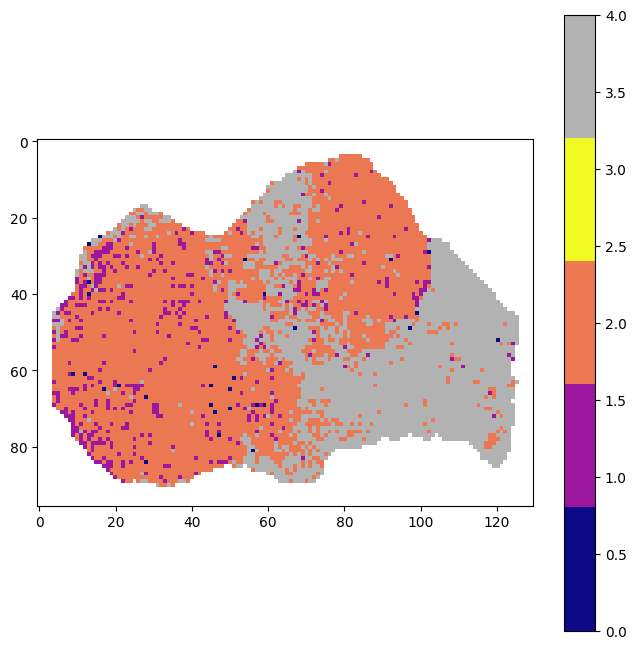

  0%|          | 0/110 [00:00<?, ?it/s]

  6%|▋         | 7/110 [00:00<00:11,  8.88it/s]

  7%|▋         | 8/110 [00:03<01:04,  1.59it/s]

  8%|▊         | 9/110 [00:08<02:26,  1.45s/it]

  9%|▉         | 10/110 [00:14<03:49,  2.29s/it]

 10%|█         | 11/110 [00:21<05:43,  3.47s/it]

 11%|█         | 12/110 [00:30<07:57,  4.87s/it]

 12%|█▏        | 13/110 [00:42<10:47,  6.68s/it]

 13%|█▎        | 14/110 [00:54<13:09,  8.22s/it]

 14%|█▎        | 15/110 [01:08<15:45,  9.95s/it]

 15%|█▍        | 16/110 [01:22<17:30, 11.17s/it]

 15%|█▌        | 17/110 [01:38<19:13, 12.41s/it]

 16%|█▋        | 18/110 [01:54<20:44, 13.53s/it]

 17%|█▋        | 19/110 [02:12<22:21, 14.75s/it]

 18%|█▊        | 20/110 [02:30<23:46, 15.85s/it]

 19%|█▉        | 21/110 [02:48<24:19, 16.40s/it]

 20%|██        | 22/110 [03:06<24:54, 16.99s/it]

 21%|██        | 23/110 [03:25<25:30, 17.60s/it]

 22%|██▏       | 24/110 [03:44<25:54, 18.07s/it]

 23%|██▎       | 25/110 [04:04<26:10, 18.47s/it]

 24%|██▎       | 26/110 [04:23<26:13, 18.74s/it]

 25%|██▍       | 27/110 [04:45<27:02, 19.55s/it]

 25%|██▌       | 28/110 [05:06<27:22, 20.03s/it]

 26%|██▋       | 29/110 [05:27<27:32, 20.40s/it]

 27%|██▋       | 30/110 [05:49<27:37, 20.72s/it]

 28%|██▊       | 31/110 [06:10<27:45, 21.08s/it]

 29%|██▉       | 32/110 [06:35<28:42, 22.08s/it]

 30%|███       | 33/110 [06:59<28:58, 22.58s/it]

 31%|███       | 34/110 [07:22<28:47, 22.73s/it]

 32%|███▏      | 35/110 [07:45<28:44, 23.00s/it]

 33%|███▎      | 36/110 [08:10<28:53, 23.43s/it]

 34%|███▎      | 37/110 [08:33<28:19, 23.28s/it]

 35%|███▍      | 38/110 [08:57<28:17, 23.57s/it]

 35%|███▌      | 39/110 [09:20<27:37, 23.34s/it]

 36%|███▋      | 40/110 [09:44<27:24, 23.49s/it]

 37%|███▋      | 41/110 [10:08<27:22, 23.80s/it]

 38%|███▊      | 42/110 [10:33<27:20, 24.12s/it]

 39%|███▉      | 43/110 [11:00<27:57, 25.03s/it]

 40%|████      | 44/110 [11:27<28:08, 25.59s/it]

 41%|████      | 45/110 [11:53<27:41, 25.57s/it]

 42%|████▏     | 46/110 [12:16<26:36, 24.94s/it]

 43%|████▎     | 47/110 [12:42<26:32, 25.27s/it]

 44%|████▎     | 48/110 [13:08<26:17, 25.44s/it]

 45%|████▍     | 49/110 [13:33<25:53, 25.47s/it]

 45%|████▌     | 50/110 [13:59<25:29, 25.50s/it]

 46%|████▋     | 51/110 [14:25<25:08, 25.56s/it]

 47%|████▋     | 52/110 [14:51<24:53, 25.75s/it]

 48%|████▊     | 53/110 [15:19<24:59, 26.31s/it]

 49%|████▉     | 54/110 [15:44<24:26, 26.19s/it]

 50%|█████     | 55/110 [16:10<23:53, 26.06s/it]

 51%|█████     | 56/110 [16:36<23:26, 26.06s/it]

 52%|█████▏    | 57/110 [17:03<23:16, 26.35s/it]

 53%|█████▎    | 58/110 [17:30<22:53, 26.40s/it]

 54%|█████▎    | 59/110 [17:59<23:09, 27.24s/it]

 55%|█████▍    | 60/110 [18:26<22:43, 27.27s/it]

 55%|█████▌    | 61/110 [18:53<22:11, 27.17s/it]

 56%|█████▋    | 62/110 [19:21<21:57, 27.44s/it]

 57%|█████▋    | 63/110 [19:49<21:30, 27.45s/it]

 58%|█████▊    | 64/110 [20:16<20:55, 27.30s/it]

 59%|█████▉    | 65/110 [20:42<20:16, 27.03s/it]

 60%|██████    | 66/110 [21:08<19:35, 26.72s/it]

 61%|██████    | 67/110 [21:35<19:04, 26.61s/it]

 62%|██████▏   | 68/110 [22:00<18:29, 26.41s/it]

 63%|██████▎   | 69/110 [22:30<18:37, 27.26s/it]

 64%|██████▎   | 70/110 [22:55<17:50, 26.77s/it]

 65%|██████▍   | 71/110 [23:21<17:13, 26.51s/it]

 65%|██████▌   | 72/110 [23:48<16:48, 26.54s/it]

 66%|██████▋   | 73/110 [24:13<16:04, 26.07s/it]

 67%|██████▋   | 74/110 [24:37<15:22, 25.63s/it]

 68%|██████▊   | 75/110 [25:00<14:22, 24.65s/it]

 69%|██████▉   | 76/110 [25:20<13:14, 23.37s/it]

 70%|███████   | 77/110 [25:39<12:06, 22.02s/it]

 71%|███████   | 78/110 [25:55<10:49, 20.29s/it]

 72%|███████▏  | 79/110 [26:14<10:16, 19.90s/it]

 73%|███████▎  | 80/110 [26:29<09:13, 18.46s/it]

 74%|███████▎  | 81/110 [26:45<08:27, 17.51s/it]

 75%|███████▍  | 82/110 [26:59<07:46, 16.67s/it]

 75%|███████▌  | 83/110 [27:15<07:19, 16.27s/it]

 76%|███████▋  | 84/110 [27:31<07:00, 16.18s/it]

 77%|███████▋  | 85/110 [27:45<06:27, 15.50s/it]

 78%|███████▊  | 86/110 [27:58<05:54, 14.75s/it]

 79%|███████▉  | 87/110 [28:10<05:22, 14.04s/it]

 80%|████████  | 88/110 [28:20<04:42, 12.83s/it]

 81%|████████  | 89/110 [28:30<04:10, 11.92s/it]

 82%|████████▏ | 90/110 [28:40<03:47, 11.37s/it]

 83%|████████▎ | 91/110 [28:50<03:26, 10.89s/it]

 84%|████████▎ | 92/110 [28:59<03:06, 10.34s/it]

 85%|████████▍ | 93/110 [29:08<02:49,  9.95s/it]

 85%|████████▌ | 94/110 [29:16<02:32,  9.55s/it]

 86%|████████▋ | 95/110 [29:24<02:13,  8.90s/it]

 87%|████████▋ | 96/110 [29:30<01:53,  8.08s/it]

 88%|████████▊ | 97/110 [29:35<01:32,  7.11s/it]

 89%|████████▉ | 98/110 [29:39<01:14,  6.23s/it]

 90%|█████████ | 99/110 [29:43<01:00,  5.49s/it]

 91%|█████████ | 100/110 [29:46<00:49,  4.91s/it]

 92%|█████████▏| 101/110 [29:50<00:39,  4.42s/it]

 93%|█████████▎| 102/110 [29:52<00:31,  3.93s/it]

 94%|█████████▎| 103/110 [29:55<00:24,  3.56s/it]

 95%|█████████▍| 104/110 [29:57<00:18,  3.12s/it]

 95%|█████████▌| 105/110 [29:59<00:13,  2.75s/it]

 96%|█████████▋| 106/110 [30:01<00:09,  2.43s/it]

 97%|█████████▋| 107/110 [30:02<00:06,  2.16s/it]

 98%|█████████▊| 108/110 [30:02<00:03,  1.58s/it]

100%|██████████| 110/110 [30:02<00:00, 16.39s/it]

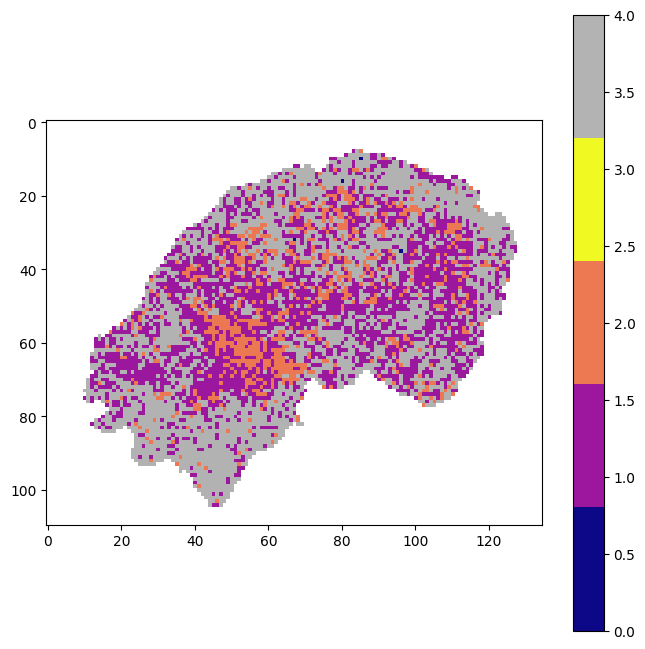

9689.svs Processed


  0%|          | 0/117 [00:00<?, ?it/s]

  3%|▎         | 4/117 [00:02<01:22,  1.37it/s]

  4%|▍         | 5/117 [00:07<03:22,  1.81s/it]

  5%|▌         | 6/117 [00:14<05:55,  3.20s/it]

  6%|▌         | 7/117 [00:21<07:58,  4.35s/it]

  7%|▋         | 8/117 [00:30<10:14,  5.64s/it]

  8%|▊         | 9/117 [00:38<11:13,  6.23s/it]

  9%|▊         | 10/117 [00:46<12:05,  6.78s/it]

  9%|▉         | 11/117 [00:55<13:19,  7.54s/it]

 10%|█         | 12/117 [01:04<13:48,  7.89s/it]

 11%|█         | 13/117 [01:14<14:50,  8.56s/it]

 12%|█▏        | 14/117 [01:25<15:37,  9.10s/it]

 13%|█▎        | 15/117 [01:35<16:17,  9.59s/it]

 14%|█▎        | 16/117 [01:45<16:21,  9.72s/it]

 15%|█▍        | 17/117 [01:57<16:58, 10.18s/it]

 15%|█▌        | 18/117 [02:08<17:33, 10.64s/it]

 16%|█▌        | 19/117 [02:23<19:31, 11.95s/it]

 17%|█▋        | 20/117 [02:39<20:55, 12.95s/it]

 18%|█▊        | 21/117 [02:56<22:34, 14.11s/it]

 19%|█▉        | 22/117 [03:14<24:30, 15.48s/it]

 20%|█▉        | 23/117 [03:32<25:31, 16.29s/it]

 21%|██        | 24/117 [03:53<27:19, 17.63s/it]

 21%|██▏       | 25/117 [04:14<28:41, 18.72s/it]

 22%|██▏       | 26/117 [04:37<30:18, 19.98s/it]

 23%|██▎       | 27/117 [05:00<31:14, 20.83s/it]

 24%|██▍       | 28/117 [05:25<32:35, 21.98s/it]

 25%|██▍       | 29/117 [05:47<32:27, 22.13s/it]

 26%|██▌       | 30/117 [06:12<33:00, 22.76s/it]

 26%|██▋       | 31/117 [06:35<33:06, 23.10s/it]

 27%|██▋       | 32/117 [06:59<33:08, 23.39s/it]

 28%|██▊       | 33/117 [07:27<34:25, 24.59s/it]

 29%|██▉       | 34/117 [07:51<33:47, 24.43s/it]

 30%|██▉       | 35/117 [08:13<32:28, 23.76s/it]

 31%|███       | 36/117 [08:36<31:47, 23.55s/it]

 32%|███▏      | 37/117 [09:02<32:18, 24.23s/it]

 32%|███▏      | 38/117 [09:24<31:07, 23.64s/it]

 33%|███▎      | 39/117 [09:47<30:20, 23.34s/it]

 34%|███▍      | 40/117 [10:11<30:06, 23.46s/it]

 35%|███▌      | 41/117 [10:35<30:01, 23.71s/it]

 36%|███▌      | 42/117 [10:59<29:39, 23.73s/it]

 37%|███▋      | 43/117 [11:22<29:02, 23.54s/it]

 38%|███▊      | 44/117 [11:46<28:49, 23.70s/it]

 38%|███▊      | 45/117 [12:08<27:55, 23.27s/it]

 39%|███▉      | 46/117 [12:30<26:56, 22.76s/it]

 40%|████      | 47/117 [12:53<26:47, 22.97s/it]

 41%|████      | 48/117 [13:17<26:48, 23.31s/it]

 42%|████▏     | 49/117 [13:41<26:41, 23.55s/it]

 43%|████▎     | 50/117 [14:04<25:54, 23.20s/it]

 44%|████▎     | 51/117 [14:28<26:01, 23.67s/it]

 44%|████▍     | 52/117 [14:52<25:44, 23.76s/it]

 45%|████▌     | 53/117 [15:15<24:59, 23.42s/it]

 46%|████▌     | 54/117 [15:41<25:17, 24.09s/it]

 47%|████▋     | 55/117 [16:07<25:25, 24.60s/it]

 48%|████▊     | 56/117 [16:33<25:34, 25.16s/it]

 49%|████▊     | 57/117 [17:01<26:05, 26.10s/it]

 50%|████▉     | 58/117 [17:28<25:45, 26.20s/it]

 50%|█████     | 59/117 [17:56<25:52, 26.77s/it]

 51%|█████▏    | 60/117 [18:24<25:43, 27.08s/it]

 52%|█████▏    | 61/117 [18:54<26:17, 28.17s/it]

 53%|█████▎    | 62/117 [19:24<26:10, 28.56s/it]

 54%|█████▍    | 63/117 [19:52<25:36, 28.45s/it]

 55%|█████▍    | 64/117 [20:19<24:43, 28.00s/it]

 56%|█████▌    | 65/117 [20:45<23:52, 27.55s/it]

 56%|█████▋    | 66/117 [21:12<23:05, 27.17s/it]

 57%|█████▋    | 67/117 [21:42<23:18, 27.97s/it]

 58%|█████▊    | 68/117 [22:07<22:19, 27.34s/it]

 59%|█████▉    | 69/117 [22:31<20:57, 26.19s/it]

 60%|█████▉    | 70/117 [22:52<19:24, 24.78s/it]

 61%|██████    | 71/117 [23:12<17:54, 23.35s/it]

 62%|██████▏   | 72/117 [23:31<16:27, 21.94s/it]

 62%|██████▏   | 73/117 [23:48<15:03, 20.53s/it]

 63%|██████▎   | 74/117 [24:06<14:06, 19.67s/it]

 64%|██████▍   | 75/117 [24:24<13:23, 19.14s/it]

 65%|██████▍   | 76/117 [24:42<12:53, 18.87s/it]

 66%|██████▌   | 77/117 [25:01<12:34, 18.85s/it]

 67%|██████▋   | 78/117 [25:19<12:04, 18.57s/it]

 68%|██████▊   | 79/117 [25:38<11:55, 18.84s/it]

 68%|██████▊   | 80/117 [25:57<11:35, 18.79s/it]

 69%|██████▉   | 81/117 [26:15<11:12, 18.68s/it]

 70%|███████   | 82/117 [26:34<10:48, 18.53s/it]

 71%|███████   | 83/117 [26:51<10:22, 18.32s/it]

 72%|███████▏  | 84/117 [27:10<10:06, 18.37s/it]

 73%|███████▎  | 85/117 [27:28<09:45, 18.30s/it]

 74%|███████▎  | 86/117 [27:47<09:31, 18.44s/it]

 74%|███████▍  | 87/117 [28:05<09:06, 18.20s/it]

 75%|███████▌  | 88/117 [28:22<08:44, 18.08s/it]

 76%|███████▌  | 89/117 [28:40<08:23, 17.98s/it]

 77%|███████▋  | 90/117 [28:59<08:09, 18.14s/it]

 78%|███████▊  | 91/117 [29:19<08:09, 18.84s/it]

 79%|███████▊  | 92/117 [29:36<07:34, 18.16s/it]

 79%|███████▉  | 93/117 [29:52<07:02, 17.58s/it]

 80%|████████  | 94/117 [30:10<06:45, 17.64s/it]

 81%|████████  | 95/117 [30:27<06:25, 17.52s/it]

 82%|████████▏ | 96/117 [30:44<06:02, 17.26s/it]

 83%|████████▎ | 97/117 [31:02<05:50, 17.51s/it]

 84%|████████▍ | 98/117 [31:19<05:30, 17.41s/it]

 85%|████████▍ | 99/117 [31:35<05:04, 16.91s/it]

 85%|████████▌ | 100/117 [31:50<04:39, 16.44s/it]

 86%|████████▋ | 101/117 [32:07<04:26, 16.66s/it]

 87%|████████▋ | 102/117 [32:23<04:05, 16.34s/it]

 88%|████████▊ | 103/117 [32:38<03:44, 16.03s/it]

 89%|████████▉ | 104/117 [32:53<03:23, 15.66s/it]

 90%|████████▉ | 105/117 [33:08<03:07, 15.59s/it]

 91%|█████████ | 106/117 [33:23<02:49, 15.38s/it]

 91%|█████████▏| 107/117 [33:37<02:30, 15.08s/it]

 92%|█████████▏| 108/117 [33:52<02:13, 14.88s/it]

 93%|█████████▎| 109/117 [34:07<01:58, 14.84s/it]

 94%|█████████▍| 110/117 [34:20<01:41, 14.52s/it]

 95%|█████████▍| 111/117 [34:34<01:25, 14.28s/it]

 96%|█████████▌| 112/117 [34:47<01:09, 13.90s/it]

 97%|█████████▋| 113/117 [35:00<00:54, 13.64s/it]

 97%|█████████▋| 114/117 [35:12<00:38, 12.99s/it]

 98%|█████████▊| 115/117 [35:22<00:24, 12.21s/it]

 99%|█████████▉| 116/117 [35:31<00:11, 11.27s/it]

100%|██████████| 117/117 [35:37<00:00,  9.76s/it]

100%|██████████| 117/117 [35:37<00:00, 18.27s/it]

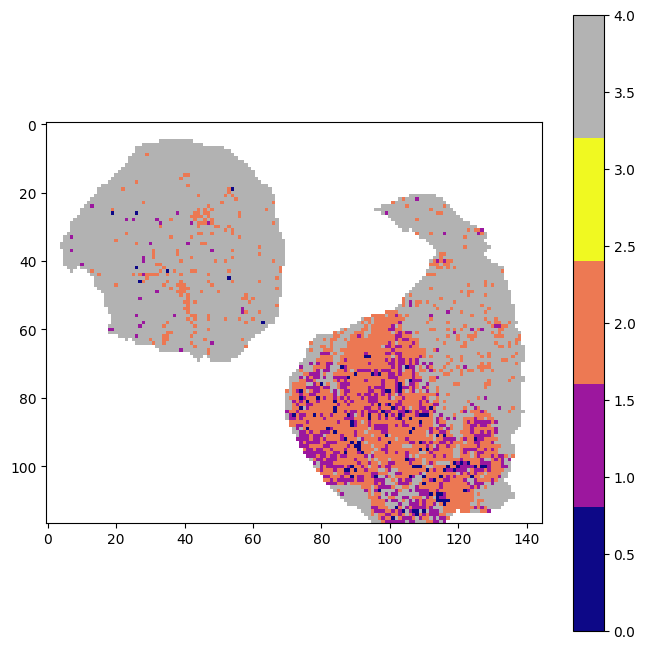

  0%|          | 0/76 [00:00<?, ?it/s]

  4%|▍         | 3/76 [00:02<00:50,  1.45it/s]

  5%|▌         | 4/76 [00:06<02:15,  1.88s/it]

  7%|▋         | 5/76 [00:12<03:39,  3.10s/it]

  8%|▊         | 6/76 [00:19<05:13,  4.47s/it]

  9%|▉         | 7/76 [00:28<06:40,  5.80s/it]

 11%|█         | 8/76 [00:38<07:56,  7.00s/it]

 12%|█▏        | 9/76 [00:49<09:12,  8.24s/it]

 13%|█▎        | 10/76 [01:00<10:11,  9.26s/it]

 14%|█▍        | 11/76 [01:14<11:17, 10.42s/it]

 16%|█▌        | 12/76 [01:27<12:03, 11.30s/it]

 17%|█▋        | 13/76 [01:42<12:58, 12.35s/it]

 18%|█▊        | 14/76 [01:57<13:33, 13.13s/it]

 20%|█▉        | 15/76 [02:16<15:13, 14.98s/it]

 21%|██        | 16/76 [02:35<16:07, 16.13s/it]

 22%|██▏       | 17/76 [02:54<16:53, 17.18s/it]

 24%|██▎       | 18/76 [03:15<17:33, 18.17s/it]

 25%|██▌       | 19/76 [03:36<18:03, 19.00s/it]

 26%|██▋       | 20/76 [03:59<18:55, 20.28s/it]

 28%|██▊       | 21/76 [04:21<19:06, 20.84s/it]

 29%|██▉       | 22/76 [04:44<19:17, 21.44s/it]

 30%|███       | 23/76 [05:06<19:08, 21.68s/it]

 32%|███▏      | 24/76 [05:29<19:06, 22.04s/it]

 33%|███▎      | 25/76 [05:53<19:12, 22.59s/it]

 34%|███▍      | 26/76 [06:17<19:12, 23.04s/it]

 36%|███▌      | 27/76 [06:42<19:19, 23.67s/it]

 37%|███▋      | 28/76 [07:07<19:12, 24.02s/it]

 38%|███▊      | 29/76 [07:32<18:57, 24.19s/it]

 39%|███▉      | 30/76 [07:58<19:03, 24.86s/it]

 41%|████      | 31/76 [08:24<18:55, 25.23s/it]

 42%|████▏     | 32/76 [08:51<18:46, 25.61s/it]

 43%|████▎     | 33/76 [09:16<18:14, 25.45s/it]

 45%|████▍     | 34/76 [09:41<17:51, 25.52s/it]

 46%|████▌     | 35/76 [10:08<17:33, 25.70s/it]

 47%|████▋     | 36/76 [10:35<17:27, 26.18s/it]

 49%|████▊     | 37/76 [11:03<17:21, 26.70s/it]

 50%|█████     | 38/76 [11:29<16:54, 26.70s/it]

 51%|█████▏    | 39/76 [11:54<16:09, 26.19s/it]

 53%|█████▎    | 40/76 [12:21<15:47, 26.33s/it]

 54%|█████▍    | 41/76 [12:48<15:30, 26.59s/it]

 55%|█████▌    | 42/76 [13:14<14:52, 26.24s/it]

 57%|█████▋    | 43/76 [13:40<14:30, 26.37s/it]

 58%|█████▊    | 44/76 [14:06<13:58, 26.20s/it]

 59%|█████▉    | 45/76 [14:31<13:15, 25.67s/it]

 61%|██████    | 46/76 [14:55<12:40, 25.36s/it]

 62%|██████▏   | 47/76 [15:20<12:08, 25.12s/it]

 63%|██████▎   | 48/76 [15:43<11:26, 24.53s/it]

 64%|██████▍   | 49/76 [16:04<10:37, 23.60s/it]

 66%|██████▌   | 50/76 [16:25<09:49, 22.69s/it]

 67%|██████▋   | 51/76 [16:41<08:40, 20.82s/it]

 68%|██████▊   | 52/76 [16:59<07:52, 19.68s/it]

 70%|██████▉   | 53/76 [17:13<06:58, 18.18s/it]

 71%|███████   | 54/76 [17:26<06:06, 16.68s/it]

 72%|███████▏  | 55/76 [17:40<05:33, 15.89s/it]

 74%|███████▎  | 56/76 [17:53<04:55, 14.78s/it]

 75%|███████▌  | 57/76 [18:05<04:25, 13.97s/it]

 76%|███████▋  | 58/76 [18:16<03:59, 13.29s/it]

 78%|███████▊  | 59/76 [18:27<03:31, 12.43s/it]

 79%|███████▉  | 60/76 [18:38<03:10, 11.94s/it]

 80%|████████  | 61/76 [18:47<02:47, 11.18s/it]

 82%|████████▏ | 62/76 [18:56<02:27, 10.54s/it]

 83%|████████▎ | 63/76 [19:05<02:11, 10.09s/it]

 84%|████████▍ | 64/76 [19:13<01:54,  9.57s/it]

 86%|████████▌ | 65/76 [19:20<01:34,  8.59s/it]

 87%|████████▋ | 66/76 [19:25<01:16,  7.68s/it]

 88%|████████▊ | 67/76 [19:30<01:02,  6.91s/it]

 89%|████████▉ | 68/76 [19:35<00:50,  6.26s/it]

 91%|█████████ | 69/76 [19:39<00:39,  5.62s/it]

 92%|█████████▏| 70/76 [19:43<00:29,  4.96s/it]

 93%|█████████▎| 71/76 [19:45<00:21,  4.30s/it]

 95%|█████████▍| 72/76 [19:48<00:14,  3.71s/it]

 96%|█████████▌| 73/76 [19:50<00:09,  3.23s/it]

 97%|█████████▋| 74/76 [19:51<00:05,  2.61s/it]

100%|██████████| 76/76 [19:51<00:00, 15.68s/it]

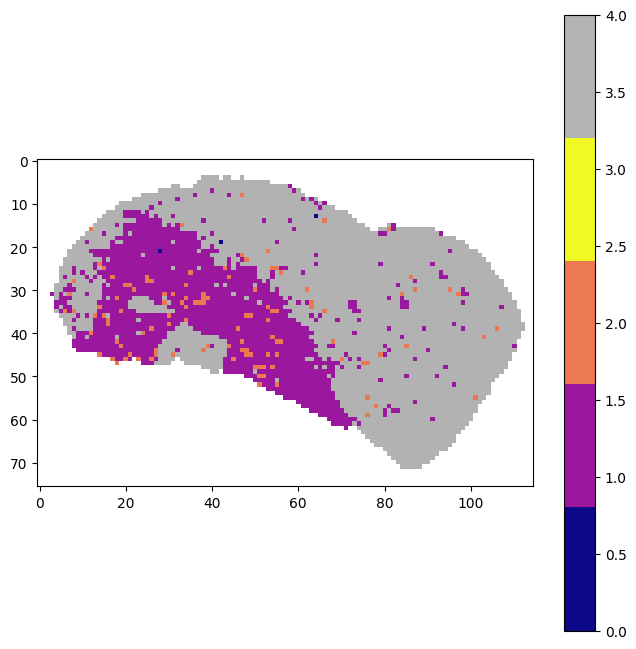

10851.svs Processed
10130.svs Processed


  0%|          | 0/34 [00:00<?, ?it/s]

  9%|▉         | 3/34 [00:00<00:06,  5.08it/s]

 12%|█▏        | 4/34 [00:02<00:23,  1.28it/s]

 15%|█▍        | 5/34 [00:04<00:34,  1.21s/it]

 18%|█▊        | 6/34 [00:08<00:59,  2.13s/it]

 21%|██        | 7/34 [00:12<01:13,  2.71s/it]

 24%|██▎       | 8/34 [00:17<01:24,  3.27s/it]

 26%|██▋       | 9/34 [00:24<01:48,  4.32s/it]

 29%|██▉       | 10/34 [00:31<02:03,  5.13s/it]

 32%|███▏      | 11/34 [00:41<02:31,  6.57s/it]

 35%|███▌      | 12/34 [00:50<02:45,  7.53s/it]

 38%|███▊      | 13/34 [00:59<02:44,  7.84s/it]

 41%|████      | 14/34 [01:08<02:42,  8.10s/it]

 44%|████▍     | 15/34 [01:16<02:37,  8.30s/it]

 47%|████▋     | 16/34 [01:25<02:31,  8.40s/it]

 50%|█████     | 17/34 [01:33<02:23,  8.42s/it]

 53%|█████▎    | 18/34 [01:43<02:18,  8.64s/it]

 56%|█████▌    | 19/34 [01:51<02:08,  8.58s/it]

 59%|█████▉    | 20/34 [01:59<01:56,  8.35s/it]

 62%|██████▏   | 21/34 [02:06<01:45,  8.10s/it]

 65%|██████▍   | 22/34 [02:14<01:36,  8.02s/it]

 68%|██████▊   | 23/34 [02:20<01:21,  7.44s/it]

 71%|███████   | 24/34 [02:27<01:11,  7.13s/it]

 74%|███████▎  | 25/34 [02:33<01:01,  6.85s/it]

 76%|███████▋  | 26/34 [02:39<00:53,  6.65s/it]

 79%|███████▉  | 27/34 [02:44<00:43,  6.23s/it]

 82%|████████▏ | 28/34 [02:49<00:34,  5.76s/it]

 85%|████████▌ | 29/34 [02:53<00:26,  5.24s/it]

 88%|████████▊ | 30/34 [02:56<00:18,  4.66s/it]

 91%|█████████ | 31/34 [02:59<00:11,  3.93s/it]

 94%|█████████▍| 32/34 [03:00<00:06,  3.08s/it]

100%|██████████| 34/34 [03:00<00:00,  5.30s/it]

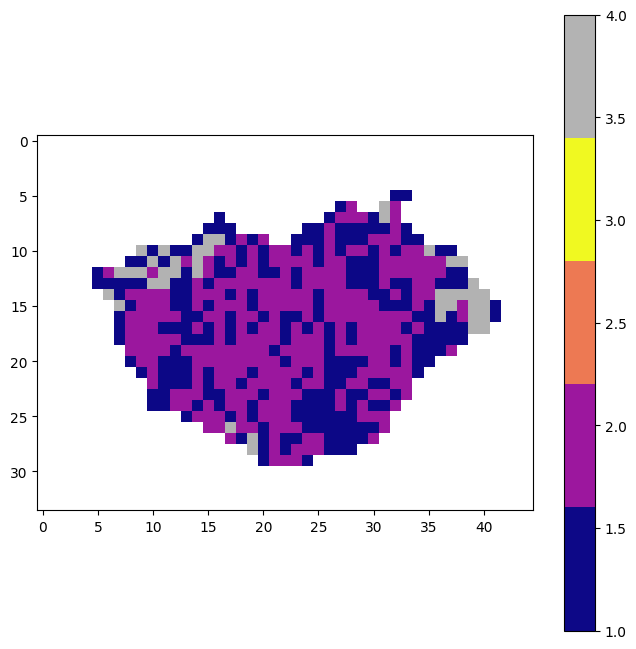

10862.svs Processed
9401.svs Processed
11004.svs Processed
11436.svs Processed


  0%|          | 0/105 [00:00<?, ?it/s]

  1%|          | 1/105 [00:40<1:09:20, 40.00s/it]

  2%|▏         | 2/105 [01:17<1:06:26, 38.71s/it]

  4%|▍         | 4/105 [01:19<25:24, 15.10s/it]  

  5%|▍         | 5/105 [01:22<18:46, 11.27s/it]

  6%|▌         | 6/105 [01:25<14:33,  8.83s/it]

  7%|▋         | 7/105 [01:30<12:07,  7.43s/it]

  8%|▊         | 8/105 [01:36<11:16,  6.98s/it]

  9%|▊         | 9/105 [01:42<11:06,  6.94s/it]

 10%|▉         | 10/105 [01:51<11:53,  7.51s/it]

 10%|█         | 11/105 [01:59<12:00,  7.67s/it]

 11%|█▏        | 12/105 [02:09<12:48,  8.26s/it]

 12%|█▏        | 13/105 [02:20<13:48,  9.00s/it]

 13%|█▎        | 14/105 [02:31<14:38,  9.66s/it]

 14%|█▍        | 15/105 [02:44<16:03, 10.70s/it]

 15%|█▌        | 16/105 [02:57<16:49, 11.34s/it]

 16%|█▌        | 17/105 [03:13<18:37, 12.69s/it]

 17%|█▋        | 18/105 [03:29<19:55, 13.75s/it]

 18%|█▊        | 19/105 [03:48<22:01, 15.37s/it]

 19%|█▉        | 20/105 [04:07<23:29, 16.58s/it]

 20%|██        | 21/105 [04:29<25:25, 18.16s/it]

 21%|██        | 22/105 [04:53<27:29, 19.87s/it]

 22%|██▏       | 23/105 [05:19<29:46, 21.79s/it]

 23%|██▎       | 24/105 [05:46<31:29, 23.33s/it]

 24%|██▍       | 25/105 [06:15<33:12, 24.90s/it]

 25%|██▍       | 26/105 [06:42<33:29, 25.44s/it]

 26%|██▌       | 27/105 [07:09<34:00, 26.16s/it]

 27%|██▋       | 28/105 [07:37<34:01, 26.51s/it]

 28%|██▊       | 29/105 [08:06<34:27, 27.21s/it]

 29%|██▊       | 30/105 [08:34<34:26, 27.56s/it]

 30%|██▉       | 31/105 [09:08<36:27, 29.56s/it]

 30%|███       | 32/105 [09:39<36:13, 29.78s/it]

 31%|███▏      | 33/105 [10:09<36:04, 30.07s/it]

 32%|███▏      | 34/105 [10:39<35:22, 29.89s/it]

 33%|███▎      | 35/105 [11:10<35:16, 30.24s/it]

 34%|███▍      | 36/105 [11:42<35:34, 30.94s/it]

 35%|███▌      | 37/105 [12:16<35:51, 31.63s/it]

 36%|███▌      | 38/105 [12:48<35:38, 31.92s/it]

 37%|███▋      | 39/105 [13:21<35:15, 32.05s/it]

 38%|███▊      | 40/105 [13:54<35:03, 32.37s/it]

 39%|███▉      | 41/105 [14:28<35:07, 32.93s/it]

 40%|████      | 42/105 [15:02<34:51, 33.20s/it]

 41%|████      | 43/105 [15:38<35:11, 34.06s/it]

 42%|████▏     | 44/105 [16:10<34:07, 33.56s/it]

 43%|████▎     | 45/105 [16:44<33:41, 33.70s/it]

 44%|████▍     | 46/105 [17:16<32:37, 33.18s/it]

 45%|████▍     | 47/105 [17:49<31:50, 32.94s/it]

 46%|████▌     | 48/105 [18:23<31:47, 33.46s/it]

 47%|████▋     | 49/105 [18:56<30:56, 33.15s/it]

 48%|████▊     | 50/105 [19:28<30:05, 32.83s/it]

 49%|████▊     | 51/105 [20:01<29:38, 32.93s/it]

 50%|████▉     | 52/105 [20:32<28:30, 32.27s/it]

 50%|█████     | 53/105 [21:01<27:12, 31.39s/it]

 51%|█████▏    | 54/105 [21:32<26:28, 31.15s/it]

 52%|█████▏    | 55/105 [22:02<25:52, 31.05s/it]

 53%|█████▎    | 56/105 [22:32<25:07, 30.76s/it]

 54%|█████▍    | 57/105 [23:04<24:49, 31.04s/it]

 55%|█████▌    | 58/105 [23:33<23:51, 30.46s/it]

 56%|█████▌    | 59/105 [24:04<23:19, 30.42s/it]

 57%|█████▋    | 60/105 [24:35<22:55, 30.56s/it]

 58%|█████▊    | 61/105 [25:04<22:14, 30.32s/it]

 59%|█████▉    | 62/105 [25:35<21:51, 30.49s/it]

 60%|██████    | 63/105 [26:09<22:03, 31.51s/it]

 61%|██████    | 64/105 [26:40<21:20, 31.23s/it]

 62%|██████▏   | 65/105 [27:10<20:44, 31.11s/it]

 63%|██████▎   | 66/105 [27:40<20:00, 30.78s/it]

 64%|██████▍   | 67/105 [28:10<19:12, 30.33s/it]

 65%|██████▍   | 68/105 [28:39<18:34, 30.12s/it]

 66%|██████▌   | 69/105 [29:09<18:00, 30.01s/it]

 67%|██████▋   | 70/105 [29:39<17:25, 29.88s/it]

 68%|██████▊   | 71/105 [30:08<16:52, 29.78s/it]

 69%|██████▊   | 72/105 [30:36<16:07, 29.32s/it]

 70%|██████▉   | 73/105 [31:04<15:24, 28.89s/it]

 70%|███████   | 74/105 [31:34<15:02, 29.12s/it]

 71%|███████▏  | 75/105 [32:01<14:18, 28.62s/it]

 72%|███████▏  | 76/105 [32:29<13:38, 28.24s/it]

 73%|███████▎  | 77/105 [32:57<13:06, 28.10s/it]

 74%|███████▍  | 78/105 [33:23<12:24, 27.57s/it]

 75%|███████▌  | 79/105 [33:51<11:58, 27.62s/it]

 76%|███████▌  | 80/105 [34:16<11:16, 27.07s/it]

 77%|███████▋  | 81/105 [34:42<10:36, 26.51s/it]

 78%|███████▊  | 82/105 [35:07<10:01, 26.15s/it]

 79%|███████▉  | 83/105 [35:31<09:24, 25.64s/it]

 80%|████████  | 84/105 [35:56<08:48, 25.17s/it]

 81%|████████  | 85/105 [36:18<08:07, 24.36s/it]

 82%|████████▏ | 86/105 [36:39<07:23, 23.36s/it]

 83%|████████▎ | 87/105 [36:59<06:43, 22.44s/it]

 84%|████████▍ | 88/105 [37:19<06:08, 21.69s/it]

 85%|████████▍ | 89/105 [37:39<05:36, 21.03s/it]

 86%|████████▌ | 90/105 [37:56<04:59, 19.99s/it]

 87%|████████▋ | 91/105 [38:12<04:20, 18.61s/it]

 88%|████████▊ | 92/105 [38:23<03:34, 16.53s/it]

 89%|████████▊ | 93/105 [38:34<02:56, 14.71s/it]

 90%|████████▉ | 94/105 [38:45<02:29, 13.55s/it]

 90%|█████████ | 95/105 [38:54<02:04, 12.42s/it]

 91%|█████████▏| 96/105 [39:03<01:41, 11.29s/it]

 92%|█████████▏| 97/105 [39:11<01:21, 10.21s/it]

 93%|█████████▎| 98/105 [39:17<01:03,  9.04s/it]

 94%|█████████▍| 99/105 [39:22<00:47,  7.88s/it]

 95%|█████████▌| 100/105 [39:26<00:32,  6.60s/it]

 96%|█████████▌| 101/105 [39:28<00:21,  5.39s/it]

 97%|█████████▋| 102/105 [39:30<00:12,  4.21s/it]

100%|██████████| 105/105 [39:30<00:00, 22.58s/it]

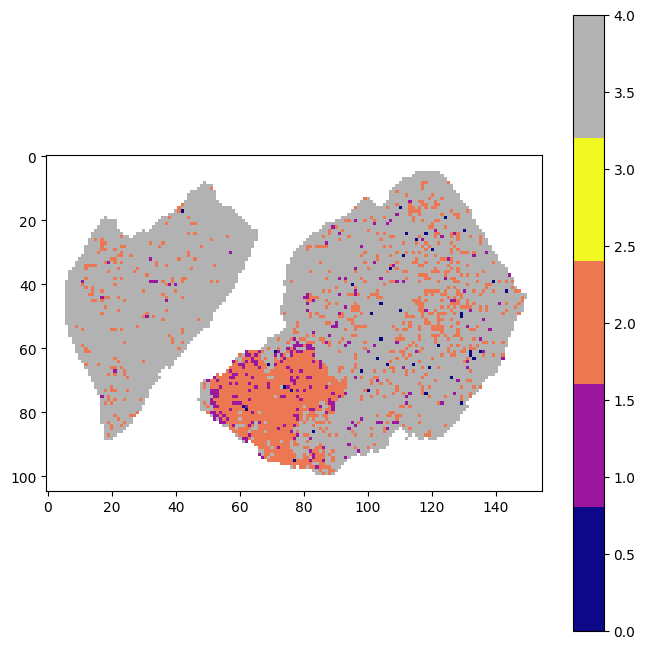

10992.svs Processed
10931.svs Processed
9550.svs Processed


  0%|          | 0/84 [00:00<?, ?it/s]

 15%|█▌        | 13/84 [00:01<00:09,  7.22it/s]

 17%|█▋        | 14/84 [00:03<00:20,  3.35it/s]

 18%|█▊        | 15/84 [00:06<00:45,  1.51it/s]

 19%|█▉        | 16/84 [00:11<01:22,  1.22s/it]

 20%|██        | 17/84 [00:16<02:11,  1.97s/it]

 21%|██▏       | 18/84 [00:23<03:16,  2.98s/it]

 23%|██▎       | 19/84 [00:33<04:49,  4.46s/it]

 24%|██▍       | 20/84 [00:42<06:05,  5.71s/it]

 25%|██▌       | 21/84 [00:53<07:18,  6.96s/it]

 26%|██▌       | 22/84 [01:06<08:52,  8.58s/it]

 27%|██▋       | 23/84 [01:20<10:16, 10.10s/it]

 29%|██▊       | 24/84 [01:36<11:51, 11.86s/it]

 30%|██▉       | 25/84 [01:53<12:59, 13.21s/it]

 31%|███       | 26/84 [02:09<13:39, 14.12s/it]

 32%|███▏      | 27/84 [02:26<14:05, 14.84s/it]

 33%|███▎      | 28/84 [02:43<14:25, 15.46s/it]

 35%|███▍      | 29/84 [03:00<14:40, 16.00s/it]

 36%|███▌      | 30/84 [03:18<15:04, 16.74s/it]

 37%|███▋      | 31/84 [03:38<15:26, 17.48s/it]

 38%|███▊      | 32/84 [03:57<15:41, 18.10s/it]

 39%|███▉      | 33/84 [04:18<16:03, 18.89s/it]

 40%|████      | 34/84 [04:39<16:13, 19.48s/it]

 42%|████▏     | 35/84 [05:00<16:24, 20.10s/it]

 43%|████▎     | 36/84 [05:22<16:22, 20.46s/it]

 44%|████▍     | 37/84 [05:45<16:41, 21.32s/it]

 45%|████▌     | 38/84 [06:10<17:13, 22.46s/it]

 46%|████▋     | 39/84 [06:35<17:21, 23.15s/it]

 48%|████▊     | 40/84 [07:01<17:37, 24.04s/it]

 49%|████▉     | 41/84 [07:28<17:49, 24.86s/it]

 50%|█████     | 42/84 [07:56<18:04, 25.82s/it]

 51%|█████     | 43/84 [08:21<17:35, 25.73s/it]

 52%|█████▏    | 44/84 [08:47<17:14, 25.87s/it]

 54%|█████▎    | 45/84 [09:12<16:36, 25.55s/it]

 55%|█████▍    | 46/84 [09:36<15:53, 25.10s/it]

 56%|█████▌    | 47/84 [10:00<15:15, 24.75s/it]

 57%|█████▋    | 48/84 [10:24<14:35, 24.32s/it]

 58%|█████▊    | 49/84 [10:47<13:56, 23.91s/it]

 60%|█████▉    | 50/84 [11:10<13:30, 23.84s/it]

 61%|██████    | 51/84 [11:33<12:55, 23.50s/it]

 62%|██████▏   | 52/84 [11:56<12:30, 23.47s/it]

 63%|██████▎   | 53/84 [12:17<11:46, 22.78s/it]

 64%|██████▍   | 54/84 [12:38<11:02, 22.07s/it]

 65%|██████▌   | 55/84 [12:58<10:21, 21.41s/it]

 67%|██████▋   | 56/84 [13:17<09:39, 20.71s/it]

 68%|██████▊   | 57/84 [13:36<09:09, 20.34s/it]

 69%|██████▉   | 58/84 [13:54<08:30, 19.63s/it]

 70%|███████   | 59/84 [14:13<08:00, 19.20s/it]

 71%|███████▏  | 60/84 [14:31<07:32, 18.85s/it]

 73%|███████▎  | 61/84 [14:48<07:01, 18.33s/it]

 74%|███████▍  | 62/84 [15:04<06:32, 17.83s/it]

 75%|███████▌  | 63/84 [15:20<05:59, 17.12s/it]

 76%|███████▌  | 64/84 [15:35<05:29, 16.47s/it]

 77%|███████▋  | 65/84 [15:48<04:56, 15.63s/it]

 79%|███████▊  | 66/84 [16:01<04:26, 14.80s/it]

 80%|███████▉  | 67/84 [16:14<03:58, 14.06s/it]

 81%|████████  | 68/84 [16:25<03:32, 13.31s/it]

 82%|████████▏ | 69/84 [16:36<03:08, 12.55s/it]

 83%|████████▎ | 70/84 [16:45<02:41, 11.56s/it]

 85%|████████▍ | 71/84 [16:54<02:21, 10.86s/it]

 86%|████████▌ | 72/84 [17:03<02:00, 10.05s/it]

 87%|████████▋ | 73/84 [17:09<01:39,  9.04s/it]

 88%|████████▊ | 74/84 [17:15<01:21,  8.11s/it]

 89%|████████▉ | 75/84 [17:20<01:05,  7.27s/it]

 90%|█████████ | 76/84 [17:26<00:53,  6.69s/it]

 92%|█████████▏| 77/84 [17:30<00:42,  6.01s/it]

 93%|█████████▎| 78/84 [17:35<00:33,  5.50s/it]

 94%|█████████▍| 79/84 [17:38<00:23,  4.80s/it]

100%|██████████| 84/84 [17:38<00:00, 12.60s/it]

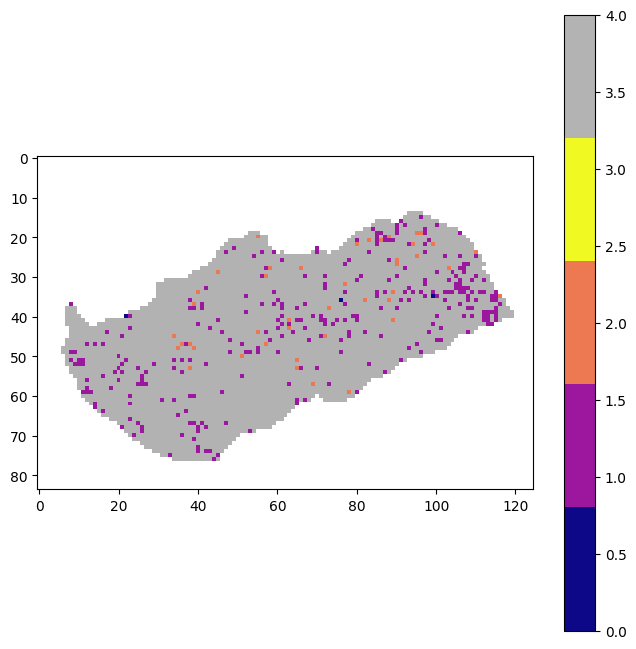

  0%|          | 0/114 [00:00<?, ?it/s]

  4%|▍         | 5/114 [00:03<01:11,  1.53it/s]

  5%|▌         | 6/114 [00:09<03:31,  1.95s/it]

  6%|▌         | 7/114 [00:16<05:43,  3.21s/it]

  7%|▋         | 8/114 [00:23<07:18,  4.13s/it]

  8%|▊         | 9/114 [00:31<08:48,  5.04s/it]

  9%|▉         | 10/114 [00:40<10:53,  6.29s/it]

 10%|▉         | 11/114 [00:55<15:05,  8.79s/it]

 11%|█         | 12/114 [01:12<18:39, 10.97s/it]

 11%|█▏        | 13/114 [01:30<22:08, 13.16s/it]

 12%|█▏        | 14/114 [01:50<24:55, 14.95s/it]

 13%|█▎        | 15/114 [02:08<26:20, 15.97s/it]

 14%|█▍        | 16/114 [02:27<27:47, 17.02s/it]

 15%|█▍        | 17/114 [02:47<28:45, 17.79s/it]

 16%|█▌        | 18/114 [03:09<30:28, 19.05s/it]

 17%|█▋        | 19/114 [03:31<31:32, 19.92s/it]

 18%|█▊        | 20/114 [03:55<32:55, 21.01s/it]

 18%|█▊        | 21/114 [04:20<34:32, 22.29s/it]

 19%|█▉        | 22/114 [04:46<35:59, 23.47s/it]

 20%|██        | 23/114 [05:13<37:19, 24.61s/it]

 21%|██        | 24/114 [05:40<37:48, 25.20s/it]

 22%|██▏       | 25/114 [06:07<38:18, 25.83s/it]

 23%|██▎       | 26/114 [06:37<39:35, 26.99s/it]

 24%|██▎       | 27/114 [07:07<40:25, 27.88s/it]

 25%|██▍       | 28/114 [07:38<41:22, 28.86s/it]

 25%|██▌       | 29/114 [08:09<41:58, 29.62s/it]

 26%|██▋       | 30/114 [08:41<42:26, 30.32s/it]

 27%|██▋       | 31/114 [09:14<43:05, 31.15s/it]

 28%|██▊       | 32/114 [09:49<43:47, 32.05s/it]

 29%|██▉       | 33/114 [10:21<43:24, 32.16s/it]

 30%|██▉       | 34/114 [10:54<43:20, 32.50s/it]

 31%|███       | 35/114 [11:26<42:38, 32.39s/it]

 32%|███▏      | 36/114 [12:00<42:36, 32.78s/it]

 32%|███▏      | 37/114 [12:33<42:00, 32.74s/it]

 33%|███▎      | 38/114 [13:08<42:22, 33.45s/it]

 34%|███▍      | 39/114 [13:43<42:15, 33.81s/it]

 35%|███▌      | 40/114 [14:18<42:14, 34.25s/it]

 36%|███▌      | 41/114 [14:53<41:59, 34.51s/it]

 37%|███▋      | 42/114 [15:28<41:29, 34.57s/it]

 38%|███▊      | 43/114 [16:02<40:48, 34.48s/it]

 39%|███▊      | 44/114 [16:36<40:11, 34.45s/it]

 39%|███▉      | 45/114 [17:10<39:28, 34.32s/it]

 40%|████      | 46/114 [17:45<39:08, 34.54s/it]

 41%|████      | 47/114 [18:22<39:25, 35.31s/it]

 42%|████▏     | 48/114 [18:57<38:42, 35.20s/it]

 43%|████▎     | 49/114 [19:35<38:50, 35.86s/it]

 44%|████▍     | 50/114 [20:11<38:17, 35.90s/it]

 45%|████▍     | 51/114 [20:45<37:02, 35.27s/it]

 46%|████▌     | 52/114 [21:19<36:18, 35.14s/it]

 46%|████▋     | 53/114 [21:53<35:10, 34.60s/it]

 47%|████▋     | 54/114 [22:26<34:09, 34.16s/it]

 48%|████▊     | 55/114 [22:58<33:05, 33.65s/it]

 49%|████▉     | 56/114 [23:31<32:13, 33.34s/it]

 50%|█████     | 57/114 [24:05<31:47, 33.47s/it]

 51%|█████     | 58/114 [24:39<31:25, 33.66s/it]

 52%|█████▏    | 59/114 [25:12<30:45, 33.56s/it]

 53%|█████▎    | 60/114 [25:47<30:31, 33.91s/it]

 54%|█████▎    | 61/114 [26:22<30:10, 34.16s/it]

 54%|█████▍    | 62/114 [26:57<30:01, 34.65s/it]

 55%|█████▌    | 63/114 [27:34<29:54, 35.18s/it]

 56%|█████▌    | 64/114 [28:13<30:15, 36.30s/it]

 57%|█████▋    | 65/114 [28:53<30:40, 37.57s/it]

 58%|█████▊    | 66/114 [29:34<30:40, 38.35s/it]

 59%|█████▉    | 67/114 [30:14<30:37, 39.09s/it]

 60%|█████▉    | 68/114 [30:55<30:18, 39.53s/it]

 61%|██████    | 69/114 [31:37<30:10, 40.23s/it]

 61%|██████▏   | 70/114 [32:18<29:45, 40.59s/it]

 62%|██████▏   | 71/114 [33:00<29:15, 40.83s/it]

 63%|██████▎   | 72/114 [33:40<28:29, 40.71s/it]

 64%|██████▍   | 73/114 [34:20<27:40, 40.49s/it]

 65%|██████▍   | 74/114 [35:00<26:51, 40.28s/it]

 66%|██████▌   | 75/114 [35:39<25:58, 39.96s/it]

 67%|██████▋   | 76/114 [36:21<25:46, 40.70s/it]

 68%|██████▊   | 77/114 [37:00<24:44, 40.11s/it]

 68%|██████▊   | 78/114 [37:37<23:32, 39.24s/it]

 69%|██████▉   | 79/114 [38:14<22:23, 38.38s/it]

 70%|███████   | 80/114 [38:50<21:28, 37.88s/it]

 71%|███████   | 81/114 [39:28<20:45, 37.75s/it]

 72%|███████▏  | 82/114 [40:06<20:14, 37.97s/it]

 73%|███████▎  | 83/114 [40:42<19:13, 37.21s/it]

 74%|███████▎  | 84/114 [41:17<18:16, 36.56s/it]

 75%|███████▍  | 85/114 [41:55<17:53, 37.01s/it]

 75%|███████▌  | 86/114 [42:32<17:16, 37.01s/it]

 76%|███████▋  | 87/114 [43:07<16:26, 36.53s/it]

 77%|███████▋  | 88/114 [43:42<15:37, 36.04s/it]

 78%|███████▊  | 89/114 [44:16<14:41, 35.27s/it]

 79%|███████▉  | 90/114 [44:47<13:38, 34.12s/it]

 80%|███████▉  | 91/114 [45:19<12:48, 33.42s/it]

 81%|████████  | 92/114 [45:46<11:36, 31.66s/it]

 82%|████████▏ | 93/114 [46:11<10:19, 29.51s/it]

 82%|████████▏ | 94/114 [46:36<09:25, 28.27s/it]

 83%|████████▎ | 95/114 [47:00<08:33, 27.01s/it]

 84%|████████▍ | 96/114 [47:23<07:44, 25.81s/it]

 85%|████████▌ | 97/114 [47:46<07:03, 24.93s/it]

 86%|████████▌ | 98/114 [48:08<06:21, 23.86s/it]

 87%|████████▋ | 99/114 [48:28<05:42, 22.87s/it]

 88%|████████▊ | 100/114 [48:49<05:11, 22.25s/it]

 89%|████████▊ | 101/114 [49:08<04:36, 21.28s/it]

 89%|████████▉ | 102/114 [49:28<04:10, 20.91s/it]

 90%|█████████ | 103/114 [49:47<03:42, 20.27s/it]

 91%|█████████ | 104/114 [50:04<03:12, 19.23s/it]

 92%|█████████▏| 105/114 [50:17<02:36, 17.40s/it]

 93%|█████████▎| 106/114 [50:28<02:05, 15.69s/it]

 94%|█████████▍| 107/114 [50:39<01:39, 14.20s/it]

 95%|█████████▍| 108/114 [50:51<01:20, 13.42s/it]

 96%|█████████▌| 109/114 [51:01<01:02, 12.49s/it]

 96%|█████████▋| 110/114 [51:10<00:45, 11.42s/it]

 97%|█████████▋| 111/114 [51:19<00:31, 10.59s/it]

 98%|█████████▊| 112/114 [51:26<00:19,  9.58s/it]

 99%|█████████▉| 113/114 [51:32<00:08,  8.61s/it]

100%|██████████| 114/114 [51:38<00:00,  7.62s/it]

100%|██████████| 114/114 [51:38<00:00, 27.18s/it]

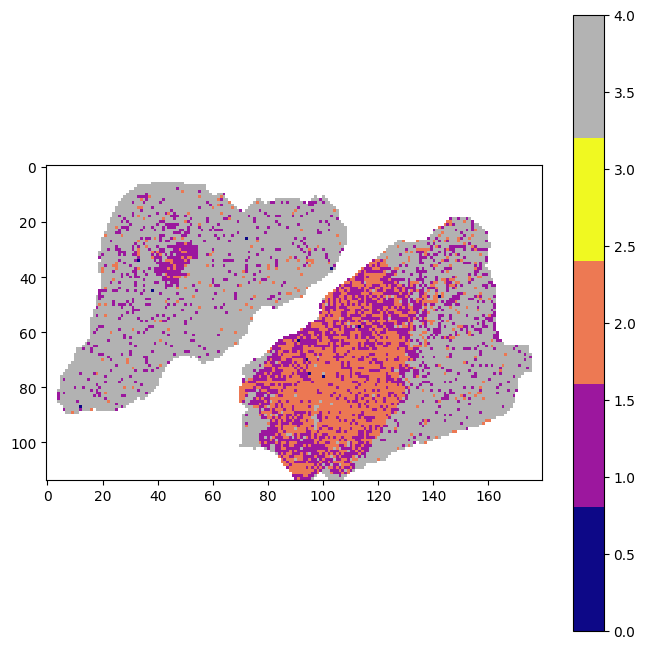

11030.svs Processed
9776.svs Processed


  0%|          | 0/111 [00:00<?, ?it/s]

  5%|▍         | 5/111 [00:00<00:11,  9.40it/s]

  5%|▌         | 6/111 [00:04<01:41,  1.03it/s]

  6%|▋         | 7/111 [00:12<04:26,  2.56s/it]

  7%|▋         | 8/111 [00:19<06:21,  3.70s/it]

  8%|▊         | 9/111 [00:27<08:27,  4.97s/it]

  9%|▉         | 10/111 [00:35<09:46,  5.80s/it]

 10%|▉         | 11/111 [00:42<10:24,  6.25s/it]

 11%|█         | 12/111 [00:50<10:58,  6.65s/it]

 12%|█▏        | 13/111 [00:58<11:36,  7.11s/it]

 13%|█▎        | 14/111 [01:08<12:58,  8.03s/it]

 14%|█▎        | 15/111 [01:22<15:37,  9.77s/it]

 14%|█▍        | 16/111 [01:38<18:04, 11.42s/it]

 15%|█▌        | 17/111 [01:55<20:42, 13.22s/it]

 16%|█▌        | 18/111 [02:13<22:23, 14.44s/it]

 17%|█▋        | 19/111 [02:32<24:23, 15.91s/it]

 18%|█▊        | 20/111 [02:52<26:10, 17.26s/it]

 19%|█▉        | 21/111 [03:12<27:02, 18.02s/it]

 20%|█▉        | 22/111 [03:33<27:51, 18.78s/it]

 21%|██        | 23/111 [03:52<27:43, 18.90s/it]

 22%|██▏       | 24/111 [04:12<28:01, 19.33s/it]

 23%|██▎       | 25/111 [04:35<29:12, 20.38s/it]

 23%|██▎       | 26/111 [04:59<30:35, 21.59s/it]

 24%|██▍       | 27/111 [05:24<31:41, 22.64s/it]

 25%|██▌       | 28/111 [05:49<31:57, 23.10s/it]

 26%|██▌       | 29/111 [06:13<32:13, 23.58s/it]

 27%|██▋       | 30/111 [06:38<32:11, 23.85s/it]

 28%|██▊       | 31/111 [07:05<33:04, 24.81s/it]

 29%|██▉       | 32/111 [07:31<32:59, 25.06s/it]

 30%|██▉       | 33/111 [07:58<33:36, 25.86s/it]

 31%|███       | 34/111 [08:25<33:25, 26.05s/it]

 32%|███▏      | 35/111 [08:50<32:50, 25.93s/it]

 32%|███▏      | 36/111 [09:19<33:21, 26.69s/it]

 33%|███▎      | 37/111 [09:46<32:59, 26.75s/it]

 34%|███▍      | 38/111 [10:13<32:43, 26.89s/it]

 35%|███▌      | 39/111 [10:40<32:24, 27.01s/it]

 36%|███▌      | 40/111 [11:09<32:35, 27.55s/it]

 37%|███▋      | 41/111 [11:37<32:12, 27.61s/it]

 38%|███▊      | 42/111 [12:07<32:28, 28.24s/it]

 39%|███▊      | 43/111 [12:35<32:00, 28.24s/it]

 40%|███▉      | 44/111 [13:03<31:38, 28.34s/it]

 41%|████      | 45/111 [13:34<31:53, 28.99s/it]

 41%|████▏     | 46/111 [14:03<31:34, 29.15s/it]

 42%|████▏     | 47/111 [14:35<31:44, 29.76s/it]

 43%|████▎     | 48/111 [15:06<31:41, 30.18s/it]

 44%|████▍     | 49/111 [15:38<31:56, 30.91s/it]

 45%|████▌     | 50/111 [16:12<32:13, 31.70s/it]

 46%|████▌     | 51/111 [16:44<31:42, 31.71s/it]

 47%|████▋     | 52/111 [17:15<31:09, 31.68s/it]

 48%|████▊     | 53/111 [17:48<30:55, 32.00s/it]

 49%|████▊     | 54/111 [18:20<30:16, 31.87s/it]

 50%|████▉     | 55/111 [18:54<30:22, 32.54s/it]

 50%|█████     | 56/111 [19:29<30:29, 33.26s/it]

 51%|█████▏    | 57/111 [20:03<30:17, 33.66s/it]

 52%|█████▏    | 58/111 [20:36<29:32, 33.45s/it]

 53%|█████▎    | 59/111 [21:10<29:03, 33.54s/it]

 54%|█████▍    | 60/111 [21:44<28:42, 33.77s/it]

 55%|█████▍    | 61/111 [22:19<28:29, 34.19s/it]

 56%|█████▌    | 62/111 [22:54<28:01, 34.32s/it]

 57%|█████▋    | 63/111 [23:30<27:56, 34.93s/it]

 58%|█████▊    | 64/111 [24:06<27:27, 35.05s/it]

 59%|█████▊    | 65/111 [24:41<26:56, 35.15s/it]

 59%|█████▉    | 66/111 [25:14<25:57, 34.61s/it]

 60%|██████    | 67/111 [25:49<25:29, 34.75s/it]

 61%|██████▏   | 68/111 [26:25<25:06, 35.04s/it]

 62%|██████▏   | 69/111 [27:01<24:39, 35.22s/it]

 63%|██████▎   | 70/111 [27:35<23:50, 34.90s/it]

 64%|██████▍   | 71/111 [28:10<23:15, 34.88s/it]

 65%|██████▍   | 72/111 [28:44<22:34, 34.74s/it]

 66%|██████▌   | 73/111 [29:20<22:08, 34.96s/it]

 67%|██████▋   | 74/111 [29:56<21:45, 35.28s/it]

 68%|██████▊   | 75/111 [30:32<21:16, 35.46s/it]

 68%|██████▊   | 76/111 [31:07<20:42, 35.51s/it]

 69%|██████▉   | 77/111 [31:42<20:00, 35.31s/it]

 70%|███████   | 78/111 [32:15<19:04, 34.69s/it]

 71%|███████   | 79/111 [32:49<18:25, 34.54s/it]

 72%|███████▏  | 80/111 [33:25<17:55, 34.70s/it]

 73%|███████▎  | 81/111 [33:58<17:12, 34.41s/it]

 74%|███████▍  | 82/111 [34:30<16:15, 33.63s/it]

 75%|███████▍  | 83/111 [35:06<16:03, 34.40s/it]

 76%|███████▌  | 84/111 [35:41<15:30, 34.46s/it]

 77%|███████▋  | 85/111 [36:13<14:40, 33.86s/it]

 77%|███████▋  | 86/111 [36:46<14:00, 33.60s/it]

 78%|███████▊  | 87/111 [37:18<13:13, 33.07s/it]

 79%|███████▉  | 88/111 [37:51<12:38, 32.99s/it]

 80%|████████  | 89/111 [38:22<11:55, 32.54s/it]

 81%|████████  | 90/111 [38:54<11:17, 32.25s/it]

 82%|████████▏ | 91/111 [39:23<10:25, 31.30s/it]

 83%|████████▎ | 92/111 [39:51<09:37, 30.38s/it]

 84%|████████▍ | 93/111 [40:20<08:57, 29.83s/it]

 85%|████████▍ | 94/111 [40:46<08:08, 28.74s/it]

 86%|████████▌ | 95/111 [41:13<07:33, 28.32s/it]

 86%|████████▋ | 96/111 [41:39<06:52, 27.47s/it]

 87%|████████▋ | 97/111 [42:04<06:16, 26.88s/it]

 88%|████████▊ | 98/111 [42:31<05:47, 26.75s/it]

 89%|████████▉ | 99/111 [42:57<05:18, 26.57s/it]

 90%|█████████ | 100/111 [43:19<04:38, 25.28s/it]

 91%|█████████ | 101/111 [43:41<04:01, 24.20s/it]

 92%|█████████▏| 102/111 [44:00<03:24, 22.75s/it]

 93%|█████████▎| 103/111 [44:18<02:49, 21.22s/it]

 94%|█████████▎| 104/111 [44:33<02:15, 19.42s/it]

 95%|█████████▍| 105/111 [44:46<01:44, 17.35s/it]

 95%|█████████▌| 106/111 [44:57<01:17, 15.51s/it]

 96%|█████████▋| 107/111 [45:05<00:53, 13.32s/it]

 97%|█████████▋| 108/111 [45:09<00:31, 10.47s/it]

100%|██████████| 111/111 [45:09<00:00, 24.41s/it]

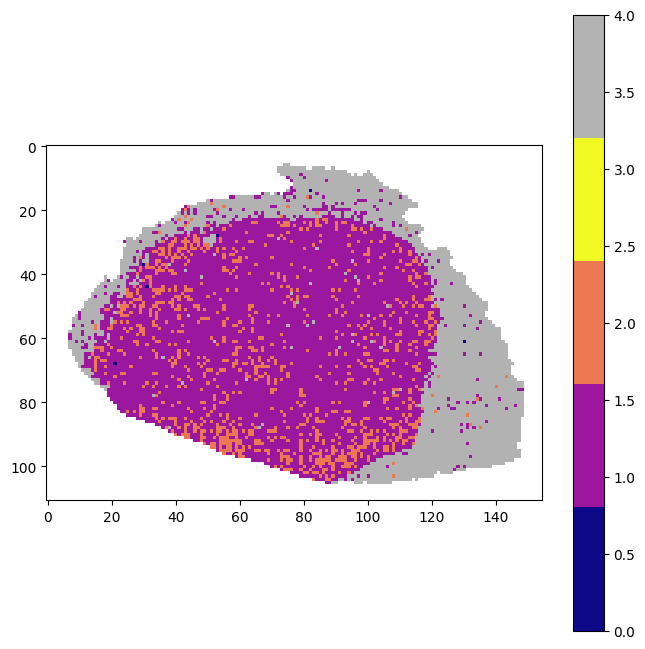

9481.svs Processed


  0%|          | 0/114 [00:00<?, ?it/s]

  2%|▏         | 2/114 [00:01<01:34,  1.19it/s]

  3%|▎         | 3/114 [00:09<07:03,  3.82s/it]

  4%|▎         | 4/114 [00:25<15:20,  8.37s/it]

  4%|▍         | 5/114 [00:40<19:27, 10.71s/it]

  5%|▌         | 6/114 [00:56<22:14, 12.35s/it]

  6%|▌         | 7/114 [01:18<27:33, 15.46s/it]

  7%|▋         | 8/114 [01:42<32:10, 18.22s/it]

  8%|▊         | 9/114 [02:08<36:16, 20.73s/it]

  9%|▉         | 10/114 [02:39<41:22, 23.87s/it]

 10%|▉         | 11/114 [03:14<46:44, 27.23s/it]

 11%|█         | 12/114 [03:49<50:00, 29.42s/it]

 11%|█▏        | 13/114 [04:23<51:54, 30.83s/it]

 12%|█▏        | 14/114 [04:57<53:07, 31.88s/it]

 13%|█▎        | 15/114 [05:32<54:16, 32.90s/it]

 14%|█▍        | 16/114 [06:08<55:06, 33.74s/it]

 15%|█▍        | 17/114 [06:44<55:29, 34.32s/it]

 16%|█▌        | 18/114 [07:18<54:51, 34.28s/it]

 17%|█▋        | 19/114 [07:54<55:00, 34.74s/it]

 18%|█▊        | 20/114 [08:29<54:48, 34.98s/it]

 18%|█▊        | 21/114 [09:04<54:15, 35.01s/it]

 19%|█▉        | 22/114 [09:39<53:18, 34.77s/it]

 20%|██        | 23/114 [10:13<52:38, 34.71s/it]

 21%|██        | 24/114 [10:49<52:26, 34.97s/it]

 22%|██▏       | 25/114 [11:22<51:09, 34.49s/it]

 23%|██▎       | 26/114 [11:57<50:33, 34.47s/it]

 24%|██▎       | 27/114 [12:33<50:55, 35.12s/it]

 25%|██▍       | 28/114 [13:07<49:58, 34.87s/it]

 25%|██▌       | 29/114 [13:43<49:39, 35.05s/it]

 26%|██▋       | 30/114 [14:19<49:30, 35.37s/it]

 27%|██▋       | 31/114 [14:56<49:25, 35.73s/it]

 28%|██▊       | 32/114 [15:32<49:16, 36.05s/it]

 29%|██▉       | 33/114 [16:09<48:50, 36.18s/it]

 30%|██▉       | 34/114 [16:47<48:59, 36.75s/it]

 31%|███       | 35/114 [17:27<49:46, 37.80s/it]

 32%|███▏      | 36/114 [18:06<49:19, 37.94s/it]

 32%|███▏      | 37/114 [18:42<48:10, 37.54s/it]

 33%|███▎      | 38/114 [19:19<47:28, 37.48s/it]

 34%|███▍      | 39/114 [19:57<46:43, 37.39s/it]

 35%|███▌      | 40/114 [20:34<46:15, 37.51s/it]

 36%|███▌      | 41/114 [21:13<45:52, 37.71s/it]

 37%|███▋      | 42/114 [21:51<45:38, 38.03s/it]

 38%|███▊      | 43/114 [22:30<45:10, 38.18s/it]

 39%|███▊      | 44/114 [23:10<45:20, 38.86s/it]

 39%|███▉      | 45/114 [23:51<45:22, 39.45s/it]

 40%|████      | 46/114 [24:33<45:37, 40.26s/it]

 41%|████      | 47/114 [25:15<45:35, 40.83s/it]

 42%|████▏     | 48/114 [25:58<45:19, 41.20s/it]

 43%|████▎     | 49/114 [26:42<45:32, 42.05s/it]

 44%|████▍     | 50/114 [27:24<45:06, 42.29s/it]

 45%|████▍     | 51/114 [28:10<45:22, 43.22s/it]

 46%|████▌     | 52/114 [28:52<44:23, 42.96s/it]

 46%|████▋     | 53/114 [29:34<43:20, 42.64s/it]

 47%|████▋     | 54/114 [30:18<43:02, 43.05s/it]

 48%|████▊     | 55/114 [31:00<41:59, 42.71s/it]

 49%|████▉     | 56/114 [31:41<40:52, 42.29s/it]

 50%|█████     | 57/114 [32:23<40:00, 42.11s/it]

 51%|█████     | 58/114 [33:05<39:13, 42.02s/it]

 52%|█████▏    | 59/114 [33:45<37:53, 41.34s/it]

 53%|█████▎    | 60/114 [34:27<37:35, 41.78s/it]

 54%|█████▎    | 61/114 [35:11<37:17, 42.22s/it]

 54%|█████▍    | 62/114 [35:53<36:46, 42.42s/it]

 55%|█████▌    | 63/114 [36:37<36:27, 42.88s/it]

 56%|█████▌    | 64/114 [37:20<35:40, 42.81s/it]

 57%|█████▋    | 65/114 [38:05<35:30, 43.47s/it]

 58%|█████▊    | 66/114 [38:50<35:05, 43.86s/it]

 59%|█████▉    | 67/114 [39:37<35:01, 44.72s/it]

 60%|█████▉    | 68/114 [40:21<34:16, 44.71s/it]

 61%|██████    | 69/114 [41:08<33:53, 45.18s/it]

 61%|██████▏   | 70/114 [41:53<33:17, 45.39s/it]

 62%|██████▏   | 71/114 [42:41<32:56, 45.96s/it]

 63%|██████▎   | 72/114 [43:28<32:26, 46.35s/it]

 64%|██████▍   | 73/114 [44:15<31:47, 46.51s/it]

 65%|██████▍   | 74/114 [45:01<30:51, 46.28s/it]

 66%|██████▌   | 75/114 [45:45<29:47, 45.84s/it]

 67%|██████▋   | 76/114 [46:29<28:41, 45.30s/it]

 68%|██████▊   | 77/114 [47:15<27:54, 45.25s/it]

 68%|██████▊   | 78/114 [48:00<27:09, 45.26s/it]

 69%|██████▉   | 79/114 [48:45<26:19, 45.12s/it]

 70%|███████   | 80/114 [49:27<25:08, 44.35s/it]

 71%|███████   | 81/114 [50:09<24:02, 43.71s/it]

 72%|███████▏  | 82/114 [50:54<23:27, 43.98s/it]

 73%|███████▎  | 83/114 [51:39<22:54, 44.35s/it]

 74%|███████▎  | 84/114 [52:25<22:24, 44.83s/it]

 75%|███████▍  | 85/114 [53:10<21:40, 44.85s/it]

 75%|███████▌  | 86/114 [53:54<20:45, 44.48s/it]

 76%|███████▋  | 87/114 [54:38<19:55, 44.27s/it]

 77%|███████▋  | 88/114 [55:20<18:53, 43.60s/it]

 78%|███████▊  | 89/114 [56:00<17:44, 42.60s/it]

 79%|███████▉  | 90/114 [56:39<16:37, 41.58s/it]

 80%|███████▉  | 91/114 [57:19<15:43, 41.02s/it]

 81%|████████  | 92/114 [57:55<14:32, 39.68s/it]

 82%|████████▏ | 93/114 [58:30<13:21, 38.17s/it]

 82%|████████▏ | 94/114 [59:03<12:14, 36.74s/it]

 83%|████████▎ | 95/114 [59:37<11:17, 35.66s/it]

 84%|████████▍ | 96/114 [1:00:12<10:38, 35.50s/it]

 85%|████████▌ | 97/114 [1:00:44<09:47, 34.54s/it]

 86%|████████▌ | 98/114 [1:01:15<08:56, 33.51s/it]

 87%|████████▋ | 99/114 [1:01:44<08:02, 32.14s/it]

 88%|████████▊ | 100/114 [1:02:12<07:12, 30.92s/it]

 89%|████████▊ | 101/114 [1:02:38<06:23, 29.52s/it]

 89%|████████▉ | 102/114 [1:03:00<05:25, 27.12s/it]

 90%|█████████ | 103/114 [1:03:20<04:34, 24.92s/it]

 91%|█████████ | 104/114 [1:03:36<03:44, 22.41s/it]

 92%|█████████▏| 105/114 [1:03:52<03:03, 20.37s/it]

 93%|█████████▎| 106/114 [1:04:07<02:30, 18.76s/it]

 94%|█████████▍| 107/114 [1:04:21<02:01, 17.36s/it]

 95%|█████████▍| 108/114 [1:04:34<01:36, 16.01s/it]

 96%|█████████▌| 109/114 [1:04:47<01:16, 15.20s/it]

 96%|█████████▋| 110/114 [1:05:00<00:57, 14.45s/it]

 97%|█████████▋| 111/114 [1:05:10<00:39, 13.19s/it]

 98%|█████████▊| 112/114 [1:05:19<00:23, 11.91s/it]

 99%|█████████▉| 113/114 [1:05:27<00:10, 10.76s/it]

100%|██████████| 114/114 [1:05:33<00:00,  9.43s/it]

100%|██████████| 114/114 [1:05:33<00:00, 34.51s/it]

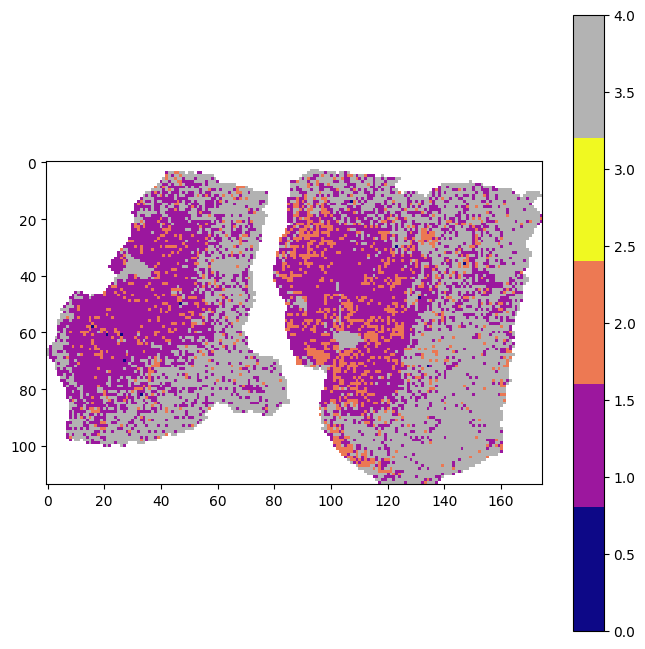

11391.svs Processed
10997.svs Processed
11295.svs Processed
10494.svs Processed
9684.svs Processed
9497.svs Processed
11010.svs Processed
10619.svs Processed


11358.svs Processed
10492.svs Processed
9738.svs Processed


  0%|          | 0/77 [00:00<?, ?it/s]

  3%|▎         | 2/77 [00:01<00:45,  1.64it/s]

  4%|▍         | 3/77 [00:04<02:07,  1.72s/it]

  5%|▌         | 4/77 [00:07<02:53,  2.38s/it]

  6%|▋         | 5/77 [00:12<03:46,  3.14s/it]

  8%|▊         | 6/77 [00:19<05:23,  4.56s/it]

  9%|▉         | 7/77 [00:28<06:47,  5.82s/it]

 10%|█         | 8/77 [00:38<08:09,  7.10s/it]

 12%|█▏        | 9/77 [00:48<09:08,  8.07s/it]

 13%|█▎        | 10/77 [00:59<10:01,  8.98s/it]

 14%|█▍        | 11/77 [01:11<10:56,  9.95s/it]

 16%|█▌        | 12/77 [01:24<11:41, 10.80s/it]

 17%|█▋        | 13/77 [01:38<12:29, 11.71s/it]

 18%|█▊        | 14/77 [01:53<13:21, 12.72s/it]

 19%|█▉        | 15/77 [02:11<14:46, 14.30s/it]

 21%|██        | 16/77 [02:30<15:56, 15.67s/it]

 22%|██▏       | 17/77 [02:49<16:54, 16.90s/it]

 23%|██▎       | 18/77 [03:09<17:32, 17.84s/it]

 25%|██▍       | 19/77 [03:31<18:22, 19.01s/it]

 26%|██▌       | 20/77 [03:52<18:37, 19.61s/it]

 27%|██▋       | 21/77 [04:14<19:01, 20.38s/it]

 29%|██▊       | 22/77 [04:39<19:50, 21.64s/it]

 30%|██▉       | 23/77 [05:03<20:12, 22.45s/it]

 31%|███       | 24/77 [05:27<20:06, 22.77s/it]

 32%|███▏      | 25/77 [05:52<20:13, 23.34s/it]

 34%|███▍      | 26/77 [06:16<20:13, 23.79s/it]

 35%|███▌      | 27/77 [06:42<20:10, 24.20s/it]

 36%|███▋      | 28/77 [07:08<20:20, 24.91s/it]

 38%|███▊      | 29/77 [07:35<20:21, 25.45s/it]

 39%|███▉      | 30/77 [08:03<20:28, 26.15s/it]

 40%|████      | 31/77 [08:31<20:35, 26.86s/it]

 42%|████▏     | 32/77 [08:59<20:26, 27.27s/it]

 43%|████▎     | 33/77 [09:28<20:20, 27.74s/it]

 44%|████▍     | 34/77 [09:58<20:16, 28.29s/it]

 45%|████▌     | 35/77 [10:28<20:11, 28.84s/it]

 47%|████▋     | 36/77 [10:57<19:41, 28.81s/it]

 48%|████▊     | 37/77 [11:25<19:12, 28.80s/it]

 49%|████▉     | 38/77 [11:54<18:45, 28.86s/it]

 51%|█████     | 39/77 [12:24<18:22, 29.00s/it]

 52%|█████▏    | 40/77 [12:53<17:51, 28.95s/it]

 53%|█████▎    | 41/77 [13:23<17:36, 29.34s/it]

 55%|█████▍    | 42/77 [13:52<17:09, 29.40s/it]

 56%|█████▌    | 43/77 [14:22<16:45, 29.58s/it]

 57%|█████▋    | 44/77 [14:52<16:13, 29.50s/it]

 58%|█████▊    | 45/77 [15:21<15:44, 29.51s/it]

 60%|█████▉    | 46/77 [15:49<14:59, 29.02s/it]

 61%|██████    | 47/77 [16:18<14:32, 29.09s/it]

 62%|██████▏   | 48/77 [16:46<13:51, 28.67s/it]

 64%|██████▎   | 49/77 [17:13<13:06, 28.10s/it]

 65%|██████▍   | 50/77 [17:40<12:30, 27.78s/it]

 66%|██████▌   | 51/77 [18:06<11:47, 27.20s/it]

 68%|██████▊   | 52/77 [18:30<10:55, 26.23s/it]

 69%|██████▉   | 53/77 [18:48<09:35, 23.98s/it]

 70%|███████   | 54/77 [19:04<08:16, 21.59s/it]

 71%|███████▏  | 55/77 [19:19<07:07, 19.43s/it]

 73%|███████▎  | 56/77 [19:32<06:07, 17.50s/it]

 74%|███████▍  | 57/77 [19:44<05:17, 15.88s/it]

 75%|███████▌  | 58/77 [19:56<04:39, 14.69s/it]

 77%|███████▋  | 59/77 [20:06<04:02, 13.48s/it]

 78%|███████▊  | 60/77 [20:16<03:31, 12.46s/it]

 79%|███████▉  | 61/77 [20:26<03:04, 11.50s/it]

 81%|████████  | 62/77 [20:35<02:42, 10.80s/it]

 82%|████████▏ | 63/77 [20:43<02:19,  9.97s/it]

 83%|████████▎ | 64/77 [20:51<02:01,  9.33s/it]

 84%|████████▍ | 65/77 [20:57<01:39,  8.32s/it]

 86%|████████▌ | 66/77 [21:03<01:23,  7.59s/it]

 87%|████████▋ | 67/77 [21:07<01:06,  6.67s/it]

 88%|████████▊ | 68/77 [21:11<00:52,  5.89s/it]

 90%|████████▉ | 69/77 [21:14<00:40,  5.08s/it]

 91%|█████████ | 70/77 [21:17<00:30,  4.36s/it]

 92%|█████████▏| 71/77 [21:20<00:22,  3.79s/it]

 94%|█████████▎| 72/77 [21:21<00:15,  3.09s/it]

 95%|█████████▍| 73/77 [21:21<00:08,  2.25s/it]

100%|██████████| 77/77 [21:21<00:00, 16.65s/it]

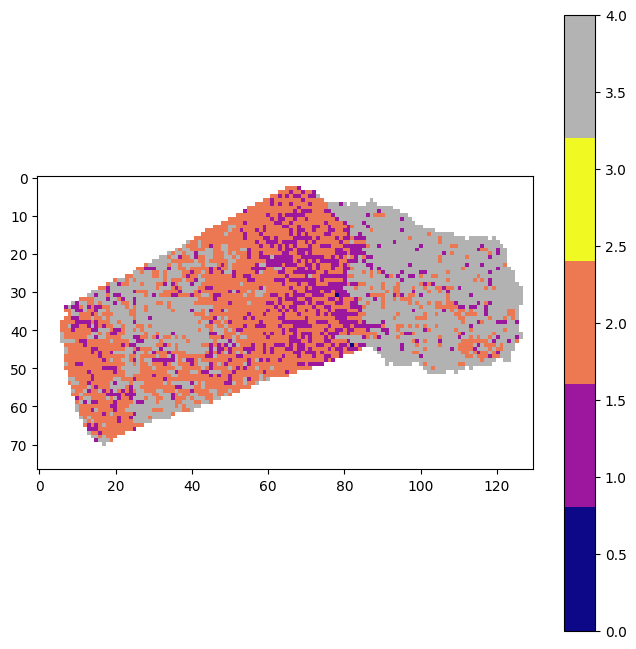

  0%|          | 0/83 [00:00<?, ?it/s]

  4%|▎         | 3/83 [00:05<02:30,  1.88s/it]

  5%|▍         | 4/83 [00:17<06:46,  5.15s/it]

  6%|▌         | 5/83 [00:31<10:15,  7.89s/it]

  7%|▋         | 6/83 [00:49<14:01, 10.93s/it]

  8%|▊         | 7/83 [01:10<17:55, 14.16s/it]

 10%|▉         | 8/83 [01:34<21:26, 17.16s/it]

 11%|█         | 9/83 [01:58<23:37, 19.16s/it]

 12%|█▏        | 10/83 [02:22<25:16, 20.77s/it]

 13%|█▎        | 11/83 [02:47<26:30, 22.10s/it]

 14%|█▍        | 12/83 [03:13<27:26, 23.19s/it]

 16%|█▌        | 13/83 [03:41<28:32, 24.47s/it]

 17%|█▋        | 14/83 [04:07<28:44, 25.00s/it]

 18%|█▊        | 15/83 [04:34<29:02, 25.62s/it]

 19%|█▉        | 16/83 [05:04<30:02, 26.90s/it]

 20%|██        | 17/83 [05:31<29:47, 27.08s/it]

 22%|██▏       | 18/83 [05:59<29:38, 27.36s/it]

 23%|██▎       | 19/83 [06:28<29:41, 27.83s/it]

 24%|██▍       | 20/83 [06:56<29:17, 27.90s/it]

 25%|██▌       | 21/83 [07:24<28:54, 27.97s/it]

 27%|██▋       | 22/83 [07:52<28:21, 27.89s/it]

 28%|██▊       | 23/83 [08:20<27:44, 27.75s/it]

 29%|██▉       | 24/83 [08:47<27:11, 27.66s/it]

 30%|███       | 25/83 [09:15<26:55, 27.84s/it]

 31%|███▏      | 26/83 [09:44<26:32, 27.95s/it]

 33%|███▎      | 27/83 [10:12<26:10, 28.05s/it]

 34%|███▎      | 28/83 [10:40<25:41, 28.02s/it]

 35%|███▍      | 29/83 [11:07<24:57, 27.74s/it]

 36%|███▌      | 30/83 [11:34<24:16, 27.48s/it]

 37%|███▋      | 31/83 [12:00<23:27, 27.06s/it]

 39%|███▊      | 32/83 [12:25<22:36, 26.61s/it]

 40%|███▉      | 33/83 [12:50<21:45, 26.11s/it]

 41%|████      | 34/83 [13:16<21:10, 25.92s/it]

 42%|████▏     | 35/83 [13:42<20:42, 25.89s/it]

 43%|████▎     | 36/83 [14:06<19:52, 25.38s/it]

 45%|████▍     | 37/83 [14:30<19:15, 25.12s/it]

 46%|████▌     | 38/83 [14:55<18:46, 25.03s/it]

 47%|████▋     | 39/83 [15:18<17:58, 24.50s/it]

 48%|████▊     | 40/83 [15:42<17:20, 24.20s/it]

 49%|████▉     | 41/83 [16:05<16:41, 23.84s/it]

 51%|█████     | 42/83 [16:28<16:12, 23.71s/it]

 52%|█████▏    | 43/83 [16:51<15:31, 23.29s/it]

 53%|█████▎    | 44/83 [17:12<14:50, 22.83s/it]

 54%|█████▍    | 45/83 [17:35<14:29, 22.89s/it]

 55%|█████▌    | 46/83 [17:56<13:41, 22.19s/it]

 57%|█████▋    | 47/83 [18:16<12:58, 21.62s/it]

 58%|█████▊    | 48/83 [18:36<12:20, 21.15s/it]

 59%|█████▉    | 49/83 [18:56<11:41, 20.62s/it]

 60%|██████    | 50/83 [19:14<11:01, 20.06s/it]

 61%|██████▏   | 51/83 [19:33<10:31, 19.73s/it]

 63%|██████▎   | 52/83 [19:52<09:59, 19.33s/it]

 64%|██████▍   | 53/83 [20:10<09:29, 18.98s/it]

 65%|██████▌   | 54/83 [20:27<08:55, 18.47s/it]

 66%|██████▋   | 55/83 [20:44<08:26, 18.08s/it]

 67%|██████▋   | 56/83 [21:02<08:07, 18.05s/it]

 69%|██████▊   | 57/83 [21:19<07:38, 17.64s/it]

 70%|██████▉   | 58/83 [21:35<07:06, 17.06s/it]

 71%|███████   | 59/83 [21:52<06:53, 17.21s/it]

 72%|███████▏  | 60/83 [22:08<06:26, 16.80s/it]

 73%|███████▎  | 61/83 [22:25<06:08, 16.77s/it]

 75%|███████▍  | 62/83 [22:39<05:36, 16.04s/it]

 76%|███████▌  | 63/83 [22:54<05:12, 15.61s/it]

 77%|███████▋  | 64/83 [23:06<04:39, 14.69s/it]

 78%|███████▊  | 65/83 [23:20<04:19, 14.41s/it]

 80%|███████▉  | 66/83 [23:33<03:57, 13.95s/it]

 81%|████████  | 67/83 [23:45<03:36, 13.50s/it]

 82%|████████▏ | 68/83 [23:57<03:12, 12.86s/it]

 83%|████████▎ | 69/83 [24:07<02:48, 12.07s/it]

 84%|████████▍ | 70/83 [24:17<02:27, 11.37s/it]

 86%|████████▌ | 71/83 [24:25<02:06, 10.52s/it]

 87%|████████▋ | 72/83 [24:34<01:48,  9.83s/it]

 88%|████████▊ | 73/83 [24:41<01:30,  9.03s/it]

 89%|████████▉ | 74/83 [24:47<01:14,  8.28s/it]

 90%|█████████ | 75/83 [24:53<01:00,  7.61s/it]

 92%|█████████▏| 76/83 [24:58<00:46,  6.67s/it]

 93%|█████████▎| 77/83 [25:01<00:33,  5.52s/it]

 94%|█████████▍| 78/83 [25:03<00:22,  4.58s/it]

 95%|█████████▌| 79/83 [25:06<00:16,  4.19s/it]

 96%|█████████▋| 80/83 [25:09<00:10,  3.64s/it]

 98%|█████████▊| 81/83 [25:09<00:05,  2.69s/it]

100%|██████████| 83/83 [25:09<00:00, 18.19s/it]

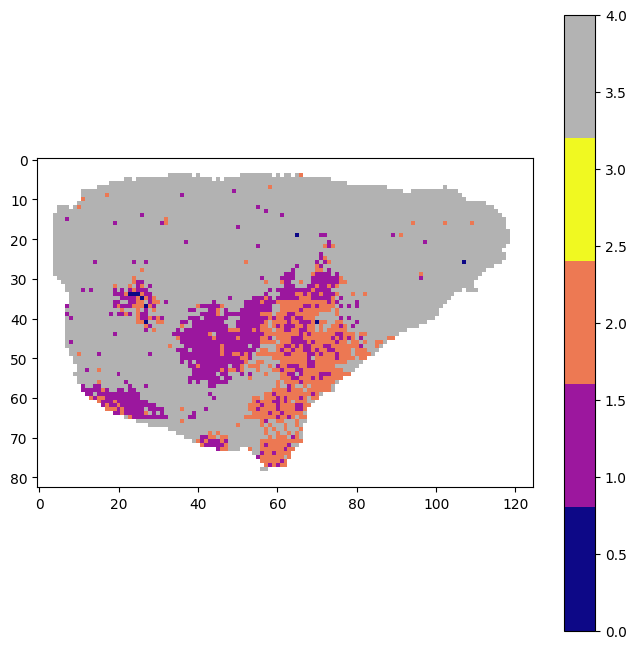

11433.svs Processed


  0%|          | 0/102 [00:00<?, ?it/s]

  2%|▏         | 2/102 [00:01<01:09,  1.43it/s]

  3%|▎         | 3/102 [00:03<01:48,  1.10s/it]

  4%|▍         | 4/102 [00:05<02:34,  1.58s/it]

  5%|▍         | 5/102 [00:08<03:24,  2.11s/it]

  6%|▌         | 6/102 [00:12<04:14,  2.65s/it]

  7%|▋         | 7/102 [00:17<05:37,  3.56s/it]

  8%|▊         | 8/102 [00:24<06:54,  4.41s/it]

  9%|▉         | 9/102 [00:30<07:52,  5.08s/it]

 10%|▉         | 10/102 [00:38<09:05,  5.93s/it]

 11%|█         | 11/102 [00:45<09:41,  6.40s/it]

 12%|█▏        | 12/102 [00:53<10:21,  6.91s/it]

 13%|█▎        | 13/102 [01:02<11:01,  7.43s/it]

 14%|█▎        | 14/102 [01:12<11:56,  8.14s/it]

 15%|█▍        | 15/102 [01:22<12:50,  8.85s/it]

 16%|█▌        | 16/102 [01:34<13:44,  9.59s/it]

 17%|█▋        | 17/102 [01:44<14:03,  9.93s/it]

 18%|█▊        | 18/102 [01:56<14:33, 10.40s/it]

 19%|█▊        | 19/102 [02:09<15:21, 11.10s/it]

 20%|█▉        | 20/102 [02:21<15:36, 11.42s/it]

 21%|██        | 21/102 [02:33<15:55, 11.79s/it]

 22%|██▏       | 22/102 [02:45<15:38, 11.73s/it]

 23%|██▎       | 23/102 [02:57<15:38, 11.88s/it]

 24%|██▎       | 24/102 [03:09<15:22, 11.83s/it]

 25%|██▍       | 25/102 [03:20<14:44, 11.49s/it]

 25%|██▌       | 26/102 [03:30<13:55, 10.99s/it]

 26%|██▋       | 27/102 [03:40<13:42, 10.97s/it]

 27%|██▋       | 28/102 [03:48<12:21, 10.02s/it]

 28%|██▊       | 29/102 [03:55<10:55,  8.98s/it]

 29%|██▉       | 30/102 [04:01<09:53,  8.24s/it]

 30%|███       | 31/102 [04:07<09:00,  7.61s/it]

 31%|███▏      | 32/102 [04:11<07:37,  6.53s/it]

 32%|███▏      | 33/102 [04:16<06:39,  5.80s/it]

 33%|███▎      | 34/102 [04:20<06:06,  5.38s/it]

 34%|███▍      | 35/102 [04:27<06:30,  5.83s/it]

 35%|███▌      | 36/102 [04:34<06:59,  6.36s/it]

 36%|███▋      | 37/102 [04:43<07:33,  6.98s/it]

 37%|███▋      | 38/102 [04:53<08:29,  7.96s/it]

 38%|███▊      | 39/102 [05:06<09:49,  9.36s/it]

 39%|███▉      | 40/102 [05:19<10:57, 10.61s/it]

 40%|████      | 41/102 [05:33<11:43, 11.53s/it]

 41%|████      | 42/102 [05:47<12:09, 12.16s/it]

 42%|████▏     | 43/102 [06:00<12:27, 12.68s/it]

 43%|████▎     | 44/102 [06:15<12:43, 13.16s/it]

 44%|████▍     | 45/102 [06:30<13:07, 13.82s/it]

 45%|████▌     | 46/102 [06:46<13:22, 14.33s/it]

 46%|████▌     | 47/102 [07:02<13:35, 14.83s/it]

 47%|████▋     | 48/102 [07:18<13:40, 15.20s/it]

 48%|████▊     | 49/102 [07:34<13:39, 15.45s/it]

 49%|████▉     | 50/102 [07:50<13:35, 15.68s/it]

 50%|█████     | 51/102 [08:06<13:23, 15.75s/it]

 51%|█████     | 52/102 [08:22<13:20, 16.00s/it]

 52%|█████▏    | 53/102 [08:40<13:23, 16.40s/it]

 53%|█████▎    | 54/102 [08:57<13:15, 16.58s/it]

 54%|█████▍    | 55/102 [09:13<12:55, 16.51s/it]

 55%|█████▍    | 56/102 [09:29<12:36, 16.46s/it]

 56%|█████▌    | 57/102 [09:45<12:11, 16.26s/it]

 57%|█████▋    | 58/102 [10:02<12:03, 16.44s/it]

 58%|█████▊    | 59/102 [10:19<11:50, 16.53s/it]

 59%|█████▉    | 60/102 [10:35<11:26, 16.34s/it]

 60%|█████▉    | 61/102 [10:51<11:09, 16.33s/it]

 61%|██████    | 62/102 [11:07<10:50, 16.26s/it]

 62%|██████▏   | 63/102 [11:22<10:20, 15.91s/it]

 63%|██████▎   | 64/102 [11:38<10:06, 15.95s/it]

 64%|██████▎   | 65/102 [11:55<09:54, 16.06s/it]

 65%|██████▍   | 66/102 [12:11<09:37, 16.04s/it]

 66%|██████▌   | 67/102 [12:26<09:09, 15.71s/it]

 67%|██████▋   | 68/102 [12:42<09:04, 16.03s/it]

 68%|██████▊   | 69/102 [12:56<08:29, 15.45s/it]

 69%|██████▊   | 70/102 [13:11<08:04, 15.15s/it]

 70%|██████▉   | 71/102 [13:25<07:38, 14.78s/it]

 71%|███████   | 72/102 [13:39<07:21, 14.71s/it]

 72%|███████▏  | 73/102 [13:52<06:51, 14.20s/it]

 73%|███████▎  | 74/102 [14:06<06:33, 14.04s/it]

 74%|███████▎  | 75/102 [14:19<06:09, 13.69s/it]

 75%|███████▍  | 76/102 [14:32<05:52, 13.56s/it]

 75%|███████▌  | 77/102 [14:45<05:34, 13.36s/it]

 76%|███████▋  | 78/102 [14:57<05:07, 12.81s/it]

 77%|███████▋  | 79/102 [15:08<04:48, 12.52s/it]

 78%|███████▊  | 80/102 [15:18<04:19, 11.78s/it]

 79%|███████▉  | 81/102 [15:28<03:52, 11.06s/it]

 80%|████████  | 82/102 [15:37<03:30, 10.52s/it]

 81%|████████▏ | 83/102 [15:45<03:05,  9.77s/it]

 82%|████████▏ | 84/102 [15:53<02:46,  9.27s/it]

 83%|████████▎ | 85/102 [16:01<02:27,  8.69s/it]

 84%|████████▍ | 86/102 [16:07<02:07,  7.94s/it]

 85%|████████▌ | 87/102 [16:12<01:47,  7.17s/it]

 86%|████████▋ | 88/102 [16:17<01:30,  6.43s/it]

 87%|████████▋ | 89/102 [16:21<01:15,  5.78s/it]

 88%|████████▊ | 90/102 [16:25<01:01,  5.15s/it]

 89%|████████▉ | 91/102 [16:28<00:50,  4.55s/it]

 90%|█████████ | 92/102 [16:31<00:40,  4.00s/it]

 91%|█████████ | 93/102 [16:33<00:32,  3.61s/it]

 92%|█████████▏| 94/102 [16:36<00:26,  3.31s/it]

 93%|█████████▎| 95/102 [16:38<00:20,  2.96s/it]

 94%|█████████▍| 96/102 [16:40<00:15,  2.56s/it]

 95%|█████████▌| 97/102 [16:41<00:11,  2.21s/it]

 96%|█████████▌| 98/102 [16:42<00:07,  1.90s/it]

 97%|█████████▋| 99/102 [16:43<00:05,  1.68s/it]

 98%|█████████▊| 100/102 [16:44<00:02,  1.38s/it]

100%|██████████| 102/102 [16:44<00:00,  9.85s/it]

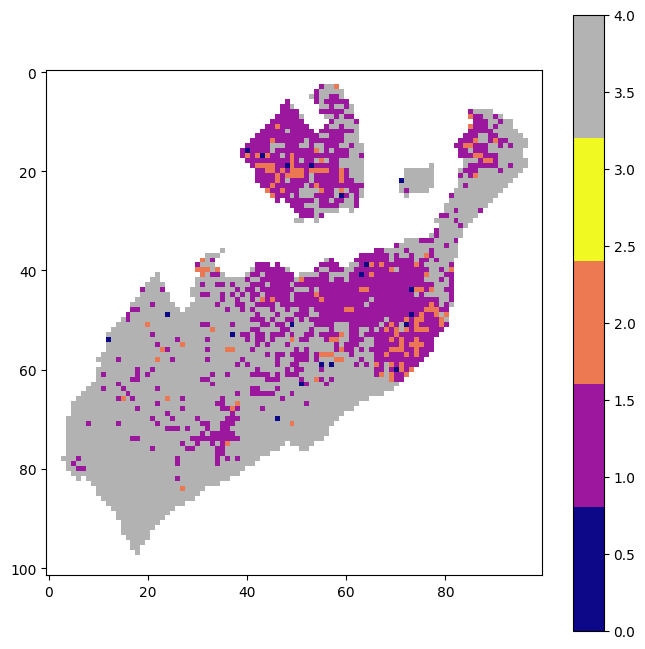

10380.svs Processed
11312.svs Processed
10994.svs Processed
10409.svs Processed
'int' object has no attribute 'properties'
11293.svs Processed
9707.svs Processed


  0%|          | 0/99 [00:00<?, ?it/s]

  3%|▎         | 3/99 [00:00<00:09,  9.97it/s]

  4%|▍         | 4/99 [00:03<01:49,  1.15s/it]

  5%|▌         | 5/99 [00:09<03:53,  2.49s/it]

  6%|▌         | 6/99 [00:15<05:41,  3.67s/it]

  7%|▋         | 7/99 [00:21<06:50,  4.46s/it]

  8%|▊         | 8/99 [00:29<08:10,  5.39s/it]

  9%|▉         | 9/99 [00:37<09:15,  6.18s/it]

 10%|█         | 10/99 [00:46<10:38,  7.17s/it]

 11%|█         | 11/99 [00:56<11:43,  7.99s/it]

 12%|█▏        | 12/99 [01:06<12:40,  8.74s/it]

 13%|█▎        | 13/99 [01:18<13:39,  9.53s/it]

 14%|█▍        | 14/99 [01:29<14:12, 10.03s/it]

 15%|█▌        | 15/99 [01:40<14:30, 10.37s/it]

 16%|█▌        | 16/99 [01:52<15:06, 10.92s/it]

 17%|█▋        | 17/99 [02:05<15:33, 11.38s/it]

 18%|█▊        | 18/99 [02:18<15:55, 11.80s/it]

 19%|█▉        | 19/99 [02:31<16:23, 12.30s/it]

 20%|██        | 20/99 [02:46<17:07, 13.01s/it]

 21%|██        | 21/99 [03:03<18:41, 14.38s/it]

 22%|██▏       | 22/99 [03:18<18:46, 14.63s/it]

 23%|██▎       | 23/99 [03:34<18:55, 14.95s/it]

 24%|██▍       | 24/99 [03:50<19:03, 15.25s/it]

 25%|██▌       | 25/99 [04:07<19:24, 15.73s/it]

 26%|██▋       | 26/99 [04:24<19:33, 16.08s/it]

 27%|██▋       | 27/99 [04:40<19:25, 16.19s/it]

 28%|██▊       | 28/99 [04:58<19:49, 16.75s/it]

 29%|██▉       | 29/99 [05:16<20:00, 17.16s/it]

 30%|███       | 30/99 [05:34<19:57, 17.35s/it]

 31%|███▏      | 31/99 [05:51<19:36, 17.30s/it]

 32%|███▏      | 32/99 [06:08<19:00, 17.02s/it]

 33%|███▎      | 33/99 [06:26<19:01, 17.30s/it]

 34%|███▍      | 34/99 [06:43<18:39, 17.23s/it]

 35%|███▌      | 35/99 [07:00<18:27, 17.31s/it]

 36%|███▋      | 36/99 [07:19<18:35, 17.70s/it]

 37%|███▋      | 37/99 [07:37<18:26, 17.85s/it]

 38%|███▊      | 38/99 [07:54<17:55, 17.64s/it]

 39%|███▉      | 39/99 [08:12<17:39, 17.66s/it]

 40%|████      | 40/99 [08:30<17:32, 17.84s/it]

 41%|████▏     | 41/99 [08:47<16:56, 17.53s/it]

 42%|████▏     | 42/99 [09:05<16:42, 17.58s/it]

 43%|████▎     | 43/99 [09:23<16:30, 17.68s/it]

 44%|████▍     | 44/99 [09:41<16:18, 17.80s/it]

 45%|████▌     | 45/99 [10:00<16:29, 18.32s/it]

 46%|████▋     | 46/99 [10:20<16:26, 18.62s/it]

 47%|████▋     | 47/99 [10:38<16:09, 18.65s/it]

 48%|████▊     | 48/99 [10:59<16:15, 19.14s/it]

 49%|████▉     | 49/99 [11:20<16:28, 19.76s/it]

 51%|█████     | 50/99 [11:42<16:41, 20.45s/it]

 52%|█████▏    | 51/99 [12:05<17:02, 21.30s/it]

 53%|█████▎    | 52/99 [12:29<17:10, 21.92s/it]

 54%|█████▎    | 53/99 [12:52<17:08, 22.35s/it]

 55%|█████▍    | 54/99 [13:15<16:59, 22.67s/it]

 56%|█████▌    | 55/99 [13:38<16:32, 22.56s/it]

 57%|█████▋    | 56/99 [14:02<16:32, 23.09s/it]

 58%|█████▊    | 57/99 [14:25<16:14, 23.19s/it]

 59%|█████▊    | 58/99 [14:50<16:05, 23.56s/it]

 60%|█████▉    | 59/99 [15:13<15:42, 23.57s/it]

 61%|██████    | 60/99 [15:37<15:14, 23.45s/it]

 62%|██████▏   | 61/99 [16:00<14:54, 23.54s/it]

 63%|██████▎   | 62/99 [16:24<14:36, 23.70s/it]

 64%|██████▎   | 63/99 [16:48<14:07, 23.55s/it]

 65%|██████▍   | 64/99 [17:10<13:31, 23.19s/it]

 66%|██████▌   | 65/99 [17:33<13:10, 23.25s/it]

 67%|██████▋   | 66/99 [17:56<12:40, 23.04s/it]

 68%|██████▊   | 67/99 [18:17<11:58, 22.47s/it]

 69%|██████▊   | 68/99 [18:38<11:22, 22.02s/it]

 70%|██████▉   | 69/99 [18:59<10:51, 21.73s/it]

 71%|███████   | 70/99 [19:20<10:27, 21.63s/it]

 72%|███████▏  | 71/99 [19:40<09:48, 21.00s/it]

 73%|███████▎  | 72/99 [19:59<09:14, 20.52s/it]

 74%|███████▎  | 73/99 [20:19<08:47, 20.30s/it]

 75%|███████▍  | 74/99 [20:38<08:19, 19.97s/it]

 76%|███████▌  | 75/99 [20:58<07:56, 19.85s/it]

 77%|███████▋  | 76/99 [21:16<07:21, 19.21s/it]

 78%|███████▊  | 77/99 [21:33<06:53, 18.80s/it]

 79%|███████▉  | 78/99 [21:52<06:35, 18.85s/it]

 80%|███████▉  | 79/99 [22:09<06:03, 18.18s/it]

 81%|████████  | 80/99 [22:27<05:44, 18.15s/it]

 82%|████████▏ | 81/99 [22:44<05:17, 17.64s/it]

 83%|████████▎ | 82/99 [23:00<04:53, 17.27s/it]

 84%|████████▍ | 83/99 [23:16<04:31, 16.99s/it]

 85%|████████▍ | 84/99 [23:33<04:13, 16.89s/it]

 86%|████████▌ | 85/99 [23:48<03:48, 16.34s/it]

 87%|████████▋ | 86/99 [24:01<03:20, 15.46s/it]

 88%|████████▊ | 87/99 [24:11<02:42, 13.56s/it]

 89%|████████▉ | 88/99 [24:20<02:15, 12.30s/it]

 90%|████████▉ | 89/99 [24:29<01:52, 11.23s/it]

 91%|█████████ | 90/99 [24:38<01:35, 10.56s/it]

 92%|█████████▏| 91/99 [24:46<01:20, 10.01s/it]

 93%|█████████▎| 92/99 [24:54<01:04,  9.25s/it]

 94%|█████████▍| 93/99 [25:01<00:51,  8.52s/it]

 95%|█████████▍| 94/99 [25:07<00:38,  7.73s/it]

 96%|█████████▌| 95/99 [25:12<00:27,  7.00s/it]

 97%|█████████▋| 96/99 [25:15<00:17,  5.90s/it]

100%|██████████| 99/99 [25:15<00:00, 15.31s/it]

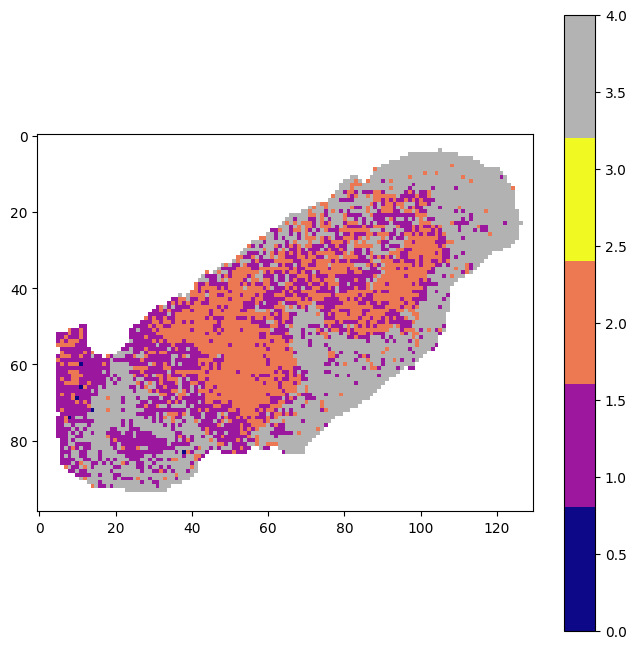

  0%|          | 0/71 [00:00<?, ?it/s]

  6%|▌         | 4/71 [00:00<00:06,  9.74it/s]

  7%|▋         | 5/71 [00:01<00:30,  2.18it/s]

  8%|▊         | 6/71 [00:03<00:56,  1.15it/s]

 10%|▉         | 7/71 [00:07<01:38,  1.53s/it]

 11%|█▏        | 8/71 [00:10<02:13,  2.13s/it]

 13%|█▎        | 9/71 [00:15<02:56,  2.84s/it]

 14%|█▍        | 10/71 [00:21<04:01,  3.95s/it]

 15%|█▌        | 11/71 [00:28<04:46,  4.78s/it]

 17%|█▋        | 12/71 [00:35<05:20,  5.43s/it]

 18%|█▊        | 13/71 [00:42<05:40,  5.88s/it]

 20%|█▉        | 14/71 [00:50<06:03,  6.37s/it]

 21%|██        | 15/71 [00:57<06:16,  6.72s/it]

 23%|██▎       | 16/71 [01:04<06:06,  6.66s/it]

 24%|██▍       | 17/71 [01:10<06:02,  6.71s/it]

 25%|██▌       | 18/71 [01:17<05:52,  6.65s/it]

 27%|██▋       | 19/71 [01:24<05:59,  6.91s/it]

 28%|██▊       | 20/71 [01:34<06:32,  7.69s/it]

 30%|██▉       | 21/71 [01:44<06:55,  8.32s/it]

 31%|███       | 22/71 [01:54<07:17,  8.92s/it]

 32%|███▏      | 23/71 [02:05<07:29,  9.37s/it]

 34%|███▍      | 24/71 [02:17<07:58, 10.17s/it]

 35%|███▌      | 25/71 [02:30<08:26, 11.01s/it]

 37%|███▋      | 26/71 [02:45<09:18, 12.41s/it]

 38%|███▊      | 27/71 [03:07<11:16, 15.36s/it]

 39%|███▉      | 28/71 [03:29<12:18, 17.18s/it]

 41%|████      | 29/71 [03:49<12:38, 18.05s/it]

 42%|████▏     | 30/71 [04:08<12:30, 18.31s/it]

 44%|████▎     | 31/71 [04:28<12:35, 18.88s/it]

 45%|████▌     | 32/71 [04:47<12:20, 19.00s/it]

 46%|████▋     | 33/71 [05:07<12:13, 19.31s/it]

 48%|████▊     | 34/71 [05:26<11:42, 18.98s/it]

 49%|████▉     | 35/71 [05:44<11:11, 18.65s/it]

 51%|█████     | 36/71 [06:02<10:51, 18.61s/it]

 52%|█████▏    | 37/71 [06:19<10:14, 18.06s/it]

 54%|█████▎    | 38/71 [06:35<09:32, 17.35s/it]

 55%|█████▍    | 39/71 [06:48<08:41, 16.30s/it]

 56%|█████▋    | 40/71 [07:02<07:56, 15.36s/it]

 58%|█████▊    | 41/71 [07:13<07:10, 14.34s/it]

 59%|█████▉    | 42/71 [07:25<06:28, 13.41s/it]

 61%|██████    | 43/71 [07:36<05:56, 12.72s/it]

 62%|██████▏   | 44/71 [07:49<05:45, 12.81s/it]

 63%|██████▎   | 45/71 [08:04<05:51, 13.53s/it]

 65%|██████▍   | 46/71 [08:21<06:01, 14.45s/it]

 66%|██████▌   | 47/71 [08:38<06:06, 15.28s/it]

 68%|██████▊   | 48/71 [08:58<06:23, 16.68s/it]

 69%|██████▉   | 49/71 [09:18<06:32, 17.82s/it]

 70%|███████   | 50/71 [09:38<06:27, 18.46s/it]

 72%|███████▏  | 51/71 [09:59<06:24, 19.22s/it]

 73%|███████▎  | 52/71 [10:19<06:09, 19.46s/it]

 75%|███████▍  | 53/71 [10:40<05:54, 19.69s/it]

 76%|███████▌  | 54/71 [10:59<05:33, 19.59s/it]

 77%|███████▋  | 55/71 [11:17<05:06, 19.17s/it]

 79%|███████▉  | 56/71 [11:35<04:39, 18.67s/it]

 80%|████████  | 57/71 [11:51<04:12, 18.04s/it]

 82%|████████▏ | 58/71 [12:06<03:43, 17.16s/it]

 83%|████████▎ | 59/71 [12:21<03:18, 16.52s/it]

 85%|████████▍ | 60/71 [12:34<02:49, 15.40s/it]

 86%|████████▌ | 61/71 [12:44<02:16, 13.69s/it]

 87%|████████▋ | 62/71 [12:52<01:47, 11.92s/it]

 89%|████████▊ | 63/71 [12:59<01:24, 10.53s/it]

 90%|█████████ | 64/71 [13:05<01:04,  9.21s/it]

 92%|█████████▏| 65/71 [13:10<00:47,  7.99s/it]

 93%|█████████▎| 66/71 [13:15<00:35,  7.01s/it]

 94%|█████████▍| 67/71 [13:18<00:22,  5.73s/it]

 96%|█████████▌| 68/71 [13:19<00:13,  4.42s/it]

 97%|█████████▋| 69/71 [13:19<00:06,  3.16s/it]

100%|██████████| 71/71 [13:19<00:00, 11.26s/it]

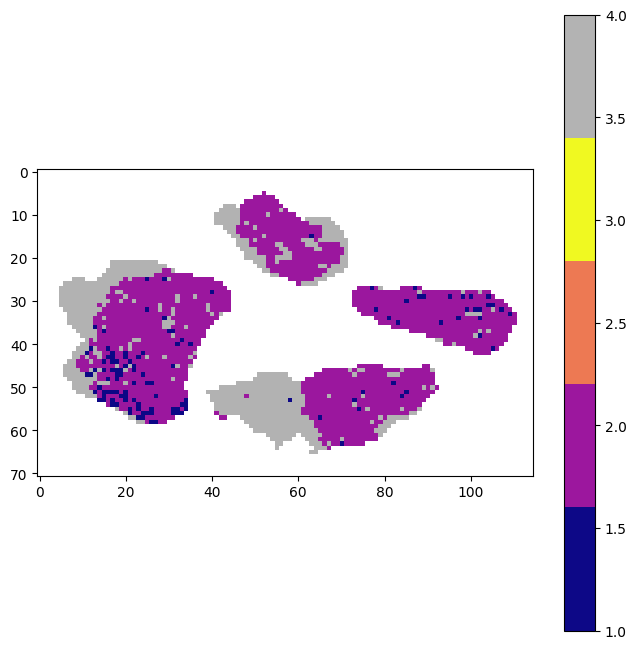

11454.svs Processed
11280.svs Processed
11036.svs Processed
10382.svs Processed
10408.svs Processed
10505.svs Processed


  0%|          | 0/75 [00:00<?, ?it/s]

  5%|▌         | 4/75 [00:00<00:08,  8.40it/s]

  7%|▋         | 5/75 [00:02<00:39,  1.76it/s]

  8%|▊         | 6/75 [00:04<01:01,  1.12it/s]

  9%|▉         | 7/75 [00:06<01:34,  1.39s/it]

 11%|█         | 8/75 [00:10<02:17,  2.05s/it]

 12%|█▏        | 9/75 [00:14<02:49,  2.57s/it]

 13%|█▎        | 10/75 [00:18<03:18,  3.05s/it]

 15%|█▍        | 11/75 [00:23<03:54,  3.66s/it]

 16%|█▌        | 12/75 [00:28<04:21,  4.14s/it]

 17%|█▋        | 13/75 [00:33<04:26,  4.30s/it]

 19%|█▊        | 14/75 [00:38<04:27,  4.39s/it]

 20%|██        | 15/75 [00:44<04:49,  4.83s/it]

 21%|██▏       | 16/75 [00:49<04:56,  5.02s/it]

 23%|██▎       | 17/75 [00:56<05:27,  5.65s/it]

 24%|██▍       | 18/75 [01:03<05:44,  6.05s/it]

 25%|██▌       | 19/75 [01:10<05:47,  6.20s/it]

 27%|██▋       | 20/75 [01:16<05:50,  6.37s/it]

 28%|██▊       | 21/75 [01:24<05:55,  6.59s/it]

 29%|██▉       | 22/75 [01:30<05:49,  6.59s/it]

 31%|███       | 23/75 [01:37<05:49,  6.72s/it]

 32%|███▏      | 24/75 [01:45<05:59,  7.04s/it]

 33%|███▎      | 25/75 [01:52<05:46,  6.92s/it]

 35%|███▍      | 26/75 [01:59<05:51,  7.17s/it]

 36%|███▌      | 27/75 [02:06<05:33,  6.95s/it]

 37%|███▋      | 28/75 [02:12<05:22,  6.86s/it]

 39%|███▊      | 29/75 [02:18<05:02,  6.57s/it]

 40%|████      | 30/75 [02:24<04:47,  6.39s/it]

 41%|████▏     | 31/75 [02:29<04:24,  6.01s/it]

 43%|████▎     | 32/75 [02:34<04:00,  5.59s/it]

 44%|████▍     | 33/75 [02:39<03:45,  5.36s/it]

 45%|████▌     | 34/75 [02:46<04:04,  5.96s/it]

 47%|████▋     | 35/75 [02:55<04:37,  6.94s/it]

 48%|████▊     | 36/75 [03:04<04:47,  7.37s/it]

 49%|████▉     | 37/75 [03:13<05:03,  7.98s/it]

 51%|█████     | 38/75 [03:23<05:18,  8.61s/it]

 52%|█████▏    | 39/75 [03:32<05:14,  8.74s/it]

 53%|█████▎    | 40/75 [03:41<05:10,  8.87s/it]

 55%|█████▍    | 41/75 [03:51<05:10,  9.13s/it]

 56%|█████▌    | 42/75 [04:01<05:04,  9.22s/it]

 57%|█████▋    | 43/75 [04:10<04:57,  9.29s/it]

 59%|█████▊    | 44/75 [04:19<04:45,  9.21s/it]

 60%|██████    | 45/75 [04:27<04:27,  8.91s/it]

 61%|██████▏   | 46/75 [04:35<04:10,  8.63s/it]

 63%|██████▎   | 47/75 [04:44<03:58,  8.52s/it]

 64%|██████▍   | 48/75 [04:52<03:48,  8.46s/it]

 65%|██████▌   | 49/75 [05:01<03:48,  8.79s/it]

 67%|██████▋   | 50/75 [05:10<03:34,  8.59s/it]

 68%|██████▊   | 51/75 [05:17<03:16,  8.20s/it]

 69%|██████▉   | 52/75 [05:24<03:00,  7.86s/it]

 71%|███████   | 53/75 [05:31<02:46,  7.58s/it]

 72%|███████▏  | 54/75 [05:37<02:28,  7.08s/it]

 73%|███████▎  | 55/75 [05:43<02:18,  6.94s/it]

 75%|███████▍  | 56/75 [05:49<02:04,  6.57s/it]

 76%|███████▌  | 57/75 [05:55<01:56,  6.49s/it]

 77%|███████▋  | 58/75 [06:01<01:48,  6.37s/it]

 79%|███████▊  | 59/75 [06:07<01:37,  6.12s/it]

 80%|████████  | 60/75 [06:12<01:27,  5.82s/it]

 81%|████████▏ | 61/75 [06:17<01:19,  5.68s/it]

 83%|████████▎ | 62/75 [06:23<01:14,  5.72s/it]

 84%|████████▍ | 63/75 [06:30<01:10,  5.90s/it]

 85%|████████▌ | 64/75 [06:35<01:04,  5.83s/it]

 87%|████████▋ | 65/75 [06:41<00:57,  5.73s/it]

 88%|████████▊ | 66/75 [06:47<00:52,  5.79s/it]

 89%|████████▉ | 67/75 [06:52<00:44,  5.53s/it]

 91%|█████████ | 68/75 [06:56<00:36,  5.20s/it]

 92%|█████████▏| 69/75 [07:00<00:29,  4.92s/it]

 93%|█████████▎| 70/75 [07:03<00:21,  4.35s/it]

 95%|█████████▍| 71/75 [07:05<00:14,  3.55s/it]

 96%|█████████▌| 72/75 [07:07<00:08,  2.95s/it]

 97%|█████████▋| 73/75 [07:07<00:04,  2.33s/it]

100%|██████████| 75/75 [07:07<00:00,  5.71s/it]

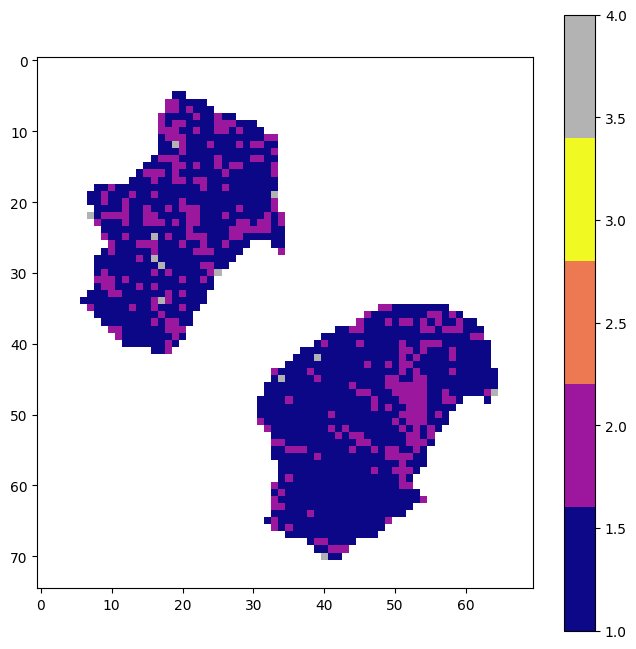

10903.svs Processed
10514.svs Processed
10025.svs Processed
9740.svs Processed
9530.svs Processed
9389.svs Processed
11296.svs Processed


  0%|          | 0/97 [00:00<?, ?it/s]

  5%|▌         | 5/97 [00:03<01:00,  1.51it/s]

  6%|▌         | 6/97 [00:07<02:10,  1.44s/it]

  7%|▋         | 7/97 [00:13<03:51,  2.57s/it]

  8%|▊         | 8/97 [00:20<05:38,  3.80s/it]

  9%|▉         | 9/97 [00:29<07:20,  5.00s/it]

 10%|█         | 10/97 [00:37<08:23,  5.79s/it]

 11%|█▏        | 11/97 [00:44<09:07,  6.36s/it]

 12%|█▏        | 12/97 [00:52<09:23,  6.63s/it]

 13%|█▎        | 13/97 [00:59<09:28,  6.76s/it]

 14%|█▍        | 14/97 [01:07<09:48,  7.09s/it]

 15%|█▌        | 15/97 [01:16<10:34,  7.74s/it]

 16%|█▋        | 16/97 [01:25<10:59,  8.14s/it]

 18%|█▊        | 17/97 [01:36<11:54,  8.93s/it]

 19%|█▊        | 18/97 [01:47<12:46,  9.71s/it]

 20%|█▉        | 19/97 [02:00<13:44, 10.57s/it]

 21%|██        | 20/97 [02:13<14:39, 11.42s/it]

 22%|██▏       | 21/97 [02:28<15:46, 12.45s/it]

 23%|██▎       | 22/97 [02:42<15:56, 12.75s/it]

 24%|██▎       | 23/97 [02:56<16:08, 13.08s/it]

 25%|██▍       | 24/97 [03:10<16:20, 13.43s/it]

 26%|██▌       | 25/97 [03:25<16:41, 13.92s/it]

 27%|██▋       | 26/97 [03:40<16:55, 14.30s/it]

 28%|██▊       | 27/97 [03:57<17:45, 15.23s/it]

 29%|██▉       | 28/97 [04:17<18:50, 16.39s/it]

 30%|██▉       | 29/97 [04:35<19:14, 16.98s/it]

 31%|███       | 30/97 [04:53<19:21, 17.34s/it]

 32%|███▏      | 31/97 [05:13<19:54, 18.10s/it]

 33%|███▎      | 32/97 [05:31<19:37, 18.12s/it]

 34%|███▍      | 33/97 [05:51<19:48, 18.57s/it]

 35%|███▌      | 34/97 [06:09<19:22, 18.46s/it]

 36%|███▌      | 35/97 [06:27<19:05, 18.48s/it]

 37%|███▋      | 36/97 [06:45<18:38, 18.34s/it]

 38%|███▊      | 37/97 [07:04<18:24, 18.41s/it]

 39%|███▉      | 38/97 [07:22<17:52, 18.17s/it]

 40%|████      | 39/97 [07:40<17:39, 18.27s/it]

 41%|████      | 40/97 [07:59<17:30, 18.43s/it]

 42%|████▏     | 41/97 [08:18<17:15, 18.48s/it]

 43%|████▎     | 42/97 [08:37<17:17, 18.87s/it]

 44%|████▍     | 43/97 [08:59<17:52, 19.86s/it]

 45%|████▌     | 44/97 [09:20<17:37, 19.95s/it]

 46%|████▋     | 45/97 [09:39<17:07, 19.77s/it]

 47%|████▋     | 46/97 [10:00<17:08, 20.18s/it]

 48%|████▊     | 47/97 [10:20<16:46, 20.12s/it]

 49%|████▉     | 48/97 [10:39<16:14, 19.89s/it]

 51%|█████     | 49/97 [11:00<16:01, 20.03s/it]

 52%|█████▏    | 50/97 [11:20<15:39, 19.99s/it]

 53%|█████▎    | 51/97 [11:40<15:20, 20.02s/it]

 54%|█████▎    | 52/97 [12:00<15:04, 20.10s/it]

 55%|█████▍    | 53/97 [12:21<14:50, 20.24s/it]

 56%|█████▌    | 54/97 [12:41<14:29, 20.23s/it]

 57%|█████▋    | 55/97 [13:03<14:32, 20.77s/it]

 58%|█████▊    | 56/97 [13:24<14:14, 20.84s/it]

 59%|█████▉    | 57/97 [13:45<13:57, 20.94s/it]

 60%|█████▉    | 58/97 [14:06<13:40, 21.04s/it]

 61%|██████    | 59/97 [14:27<13:18, 21.00s/it]

 62%|██████▏   | 60/97 [14:47<12:41, 20.57s/it]

 63%|██████▎   | 61/97 [15:06<12:04, 20.13s/it]

 64%|██████▍   | 62/97 [15:24<11:25, 19.60s/it]

 65%|██████▍   | 63/97 [15:42<10:51, 19.16s/it]

 66%|██████▌   | 64/97 [16:01<10:23, 18.88s/it]

 67%|██████▋   | 65/97 [16:19<10:03, 18.86s/it]

 68%|██████▊   | 66/97 [16:37<09:35, 18.55s/it]

 69%|██████▉   | 67/97 [16:56<09:16, 18.56s/it]

 70%|███████   | 68/97 [17:14<08:53, 18.40s/it]

 71%|███████   | 69/97 [17:33<08:38, 18.51s/it]

 72%|███████▏  | 70/97 [17:51<08:20, 18.54s/it]

 73%|███████▎  | 71/97 [18:09<07:52, 18.16s/it]

 74%|███████▍  | 72/97 [18:25<07:23, 17.76s/it]

 75%|███████▌  | 73/97 [18:42<07:01, 17.56s/it]

 76%|███████▋  | 74/97 [18:59<06:35, 17.17s/it]

 77%|███████▋  | 75/97 [19:15<06:12, 16.95s/it]

 78%|███████▊  | 76/97 [19:31<05:48, 16.62s/it]

 79%|███████▉  | 77/97 [19:47<05:29, 16.49s/it]

 80%|████████  | 78/97 [20:03<05:07, 16.20s/it]

 81%|████████▏ | 79/97 [20:19<04:54, 16.36s/it]

 82%|████████▏ | 80/97 [20:35<04:31, 15.99s/it]

 84%|████████▎ | 81/97 [20:51<04:17, 16.12s/it]

 85%|████████▍ | 82/97 [21:05<03:53, 15.54s/it]

 86%|████████▌ | 83/97 [21:19<03:31, 15.08s/it]

 87%|████████▋ | 84/97 [21:32<03:08, 14.50s/it]

 88%|████████▊ | 85/97 [21:45<02:46, 13.87s/it]

 89%|████████▊ | 86/97 [21:56<02:24, 13.14s/it]

 90%|████████▉ | 87/97 [22:05<01:58, 11.87s/it]

 91%|█████████ | 88/97 [22:13<01:35, 10.62s/it]

 92%|█████████▏| 89/97 [22:20<01:15,  9.45s/it]

 93%|█████████▎| 90/97 [22:26<00:59,  8.45s/it]

 94%|█████████▍| 91/97 [22:31<00:44,  7.43s/it]

 95%|█████████▍| 92/97 [22:34<00:31,  6.22s/it]

 96%|█████████▌| 93/97 [22:37<00:20,  5.15s/it]

 97%|█████████▋| 94/97 [22:37<00:11,  3.81s/it]

 98%|█████████▊| 95/97 [22:38<00:05,  2.94s/it]

 99%|█████████▉| 96/97 [22:39<00:02,  2.27s/it]

100%|██████████| 97/97 [22:39<00:00, 14.02s/it]

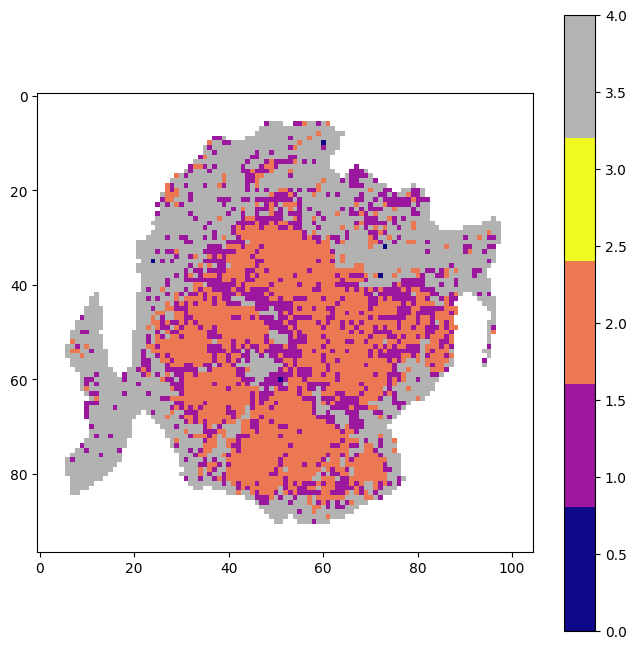

11427.svs Processed
9966.svs Processed
9756.svs Processed
11786.svs Processed
9545.svs Processed
10837.svs Processed
9461.svs Processed
10509.svs Processed


11334.svs Processed
11259.svs Processed
11127.svs Processed
10901.svs Processed
10934.svs Processed
10400.svs Processed


  0%|          | 0/77 [00:00<?, ?it/s]

  4%|▍         | 3/77 [00:00<00:17,  4.14it/s]

  5%|▌         | 4/77 [00:02<00:58,  1.24it/s]

  6%|▋         | 5/77 [00:04<01:25,  1.19s/it]

  8%|▊         | 6/77 [00:06<01:37,  1.37s/it]

  9%|▉         | 7/77 [00:08<01:57,  1.68s/it]

 10%|█         | 8/77 [00:12<02:26,  2.13s/it]

 12%|█▏        | 9/77 [00:15<02:58,  2.63s/it]

 13%|█▎        | 10/77 [00:20<03:38,  3.26s/it]

 14%|█▍        | 11/77 [00:26<04:20,  3.94s/it]

 16%|█▌        | 12/77 [00:32<05:14,  4.84s/it]

 17%|█▋        | 13/77 [00:41<06:27,  6.05s/it]

 18%|█▊        | 14/77 [00:51<07:32,  7.18s/it]

 19%|█▉        | 15/77 [01:02<08:35,  8.32s/it]

 21%|██        | 16/77 [01:14<09:30,  9.35s/it]

 22%|██▏       | 17/77 [01:25<09:50,  9.84s/it]

 23%|██▎       | 18/77 [01:37<10:15, 10.44s/it]

 25%|██▍       | 19/77 [01:49<10:34, 10.94s/it]

 26%|██▌       | 20/77 [02:02<11:09, 11.75s/it]

 27%|██▋       | 21/77 [02:16<11:27, 12.28s/it]

 29%|██▊       | 22/77 [02:31<11:53, 12.98s/it]

 30%|██▉       | 23/77 [02:44<11:53, 13.22s/it]

 31%|███       | 24/77 [02:59<12:05, 13.70s/it]

 32%|███▏      | 25/77 [03:16<12:43, 14.69s/it]

 34%|███▍      | 26/77 [03:34<13:16, 15.62s/it]

 35%|███▌      | 27/77 [03:52<13:44, 16.49s/it]

 36%|███▋      | 28/77 [04:11<13:56, 17.07s/it]

 38%|███▊      | 29/77 [04:30<14:07, 17.66s/it]

 39%|███▉      | 30/77 [04:50<14:19, 18.29s/it]

 40%|████      | 31/77 [05:10<14:28, 18.87s/it]

 42%|████▏     | 32/77 [05:30<14:19, 19.10s/it]

 43%|████▎     | 33/77 [05:50<14:19, 19.54s/it]

 44%|████▍     | 34/77 [06:12<14:32, 20.30s/it]

 45%|████▌     | 35/77 [06:34<14:29, 20.70s/it]

 47%|████▋     | 36/77 [06:55<14:18, 20.94s/it]

 48%|████▊     | 37/77 [07:18<14:12, 21.32s/it]

 49%|████▉     | 38/77 [07:42<14:26, 22.21s/it]

 51%|█████     | 39/77 [08:04<14:08, 22.33s/it]

 52%|█████▏    | 40/77 [08:27<13:49, 22.43s/it]

 53%|█████▎    | 41/77 [08:50<13:32, 22.58s/it]

 55%|█████▍    | 42/77 [09:13<13:17, 22.78s/it]

 56%|█████▌    | 43/77 [09:36<12:57, 22.88s/it]

 57%|█████▋    | 44/77 [09:59<12:33, 22.85s/it]

 58%|█████▊    | 45/77 [10:22<12:07, 22.73s/it]

 60%|█████▉    | 46/77 [10:46<11:59, 23.21s/it]

 61%|██████    | 47/77 [11:09<11:37, 23.27s/it]

 62%|██████▏   | 48/77 [11:34<11:29, 23.77s/it]

 64%|██████▎   | 49/77 [11:58<11:07, 23.85s/it]

 65%|██████▍   | 50/77 [12:22<10:40, 23.73s/it]

 66%|██████▌   | 51/77 [12:44<10:09, 23.44s/it]

 68%|██████▊   | 52/77 [13:07<09:38, 23.15s/it]

 69%|██████▉   | 53/77 [13:29<09:10, 22.92s/it]

 70%|███████   | 54/77 [13:51<08:37, 22.52s/it]

 71%|███████▏  | 55/77 [14:13<08:10, 22.28s/it]

 73%|███████▎  | 56/77 [14:34<07:43, 22.08s/it]

 74%|███████▍  | 57/77 [14:55<07:10, 21.53s/it]

 75%|███████▌  | 58/77 [15:15<06:42, 21.17s/it]

 77%|███████▋  | 59/77 [15:36<06:22, 21.26s/it]

 78%|███████▊  | 60/77 [15:55<05:50, 20.62s/it]

 79%|███████▉  | 61/77 [16:15<05:25, 20.37s/it]

 81%|████████  | 62/77 [16:33<04:55, 19.70s/it]

 82%|████████▏ | 63/77 [16:51<04:25, 18.96s/it]

 83%|████████▎ | 64/77 [17:08<03:58, 18.36s/it]

 84%|████████▍ | 65/77 [17:23<03:31, 17.61s/it]

 86%|████████▌ | 66/77 [17:39<03:07, 17.09s/it]

 87%|████████▋ | 67/77 [17:54<02:43, 16.33s/it]

 88%|████████▊ | 68/77 [18:06<02:16, 15.15s/it]

 90%|████████▉ | 69/77 [18:16<01:49, 13.65s/it]

 91%|█████████ | 70/77 [18:24<01:23, 11.86s/it]

 92%|█████████▏| 71/77 [18:30<01:00, 10.16s/it]

 94%|█████████▎| 72/77 [18:34<00:40,  8.19s/it]

 95%|█████████▍| 73/77 [18:37<00:26,  6.54s/it]

 96%|█████████▌| 74/77 [18:38<00:15,  5.06s/it]

100%|██████████| 77/77 [18:38<00:00, 14.53s/it]

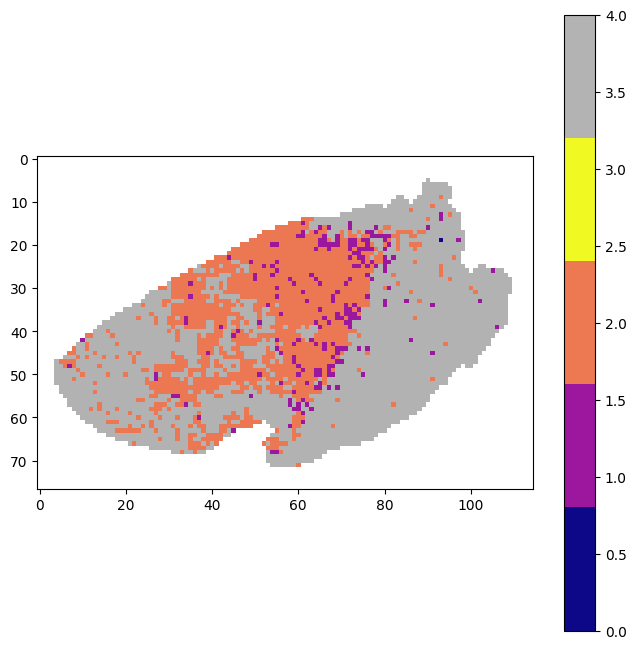

10128.svs Processed
10122.svs Processed
9469.svs Processed
11105.svs Processed
11192.svs Processed


  0%|          | 0/101 [00:00<?, ?it/s]

  4%|▍         | 4/101 [00:00<00:11,  8.73it/s]

  5%|▍         | 5/101 [00:00<00:21,  4.52it/s]

  6%|▌         | 6/101 [00:03<01:16,  1.25it/s]

  7%|▋         | 7/101 [00:08<03:20,  2.14s/it]

  8%|▊         | 8/101 [00:18<06:47,  4.39s/it]

  9%|▉         | 9/101 [00:28<09:14,  6.02s/it]

 10%|▉         | 10/101 [00:41<12:10,  8.02s/it]

 11%|█         | 11/101 [00:56<15:08, 10.09s/it]

 12%|█▏        | 12/101 [01:12<17:29, 11.79s/it]

 13%|█▎        | 13/101 [01:30<19:59, 13.63s/it]

 14%|█▍        | 14/101 [01:47<21:02, 14.51s/it]

 15%|█▍        | 15/101 [02:03<21:44, 15.17s/it]

 16%|█▌        | 16/101 [02:21<22:40, 16.01s/it]

 17%|█▋        | 17/101 [02:40<23:20, 16.67s/it]

 18%|█▊        | 18/101 [02:58<23:51, 17.25s/it]

 19%|█▉        | 19/101 [03:18<24:30, 17.93s/it]

 20%|█▉        | 20/101 [03:38<25:10, 18.65s/it]

 21%|██        | 21/101 [03:59<25:38, 19.24s/it]

 22%|██▏       | 22/101 [04:20<26:13, 19.92s/it]

 23%|██▎       | 23/101 [04:40<26:02, 20.03s/it]

 24%|██▍       | 24/101 [05:03<26:38, 20.75s/it]

 25%|██▍       | 25/101 [05:25<26:55, 21.26s/it]

 26%|██▌       | 26/101 [05:50<27:47, 22.23s/it]

 27%|██▋       | 27/101 [06:14<27:57, 22.67s/it]

 28%|██▊       | 28/101 [06:37<27:44, 22.81s/it]

 29%|██▊       | 29/101 [07:01<28:04, 23.40s/it]

 30%|██▉       | 30/101 [07:25<27:36, 23.33s/it]

 31%|███       | 31/101 [07:51<28:10, 24.15s/it]

 32%|███▏      | 32/101 [08:17<28:24, 24.71s/it]

 33%|███▎      | 33/101 [08:43<28:25, 25.08s/it]

 34%|███▎      | 34/101 [09:10<28:50, 25.83s/it]

 35%|███▍      | 35/101 [09:36<28:19, 25.75s/it]

 36%|███▌      | 36/101 [10:02<28:06, 25.94s/it]

 37%|███▋      | 37/101 [10:30<28:08, 26.39s/it]

 38%|███▊      | 38/101 [10:57<27:59, 26.65s/it]

 39%|███▊      | 39/101 [11:25<28:00, 27.10s/it]

 40%|███▉      | 40/101 [11:53<27:51, 27.40s/it]

 41%|████      | 41/101 [12:21<27:26, 27.44s/it]

 42%|████▏     | 42/101 [12:49<27:09, 27.62s/it]

 43%|████▎     | 43/101 [13:16<26:43, 27.64s/it]

 44%|████▎     | 44/101 [13:44<26:21, 27.75s/it]

 45%|████▍     | 45/101 [14:14<26:24, 28.30s/it]

 46%|████▌     | 46/101 [14:42<25:52, 28.22s/it]

 47%|████▋     | 47/101 [15:11<25:36, 28.46s/it]

 48%|████▊     | 48/101 [15:41<25:25, 28.78s/it]

 49%|████▊     | 49/101 [16:09<24:45, 28.57s/it]

 50%|████▉     | 50/101 [16:37<24:11, 28.46s/it]

 50%|█████     | 51/101 [17:04<23:19, 27.98s/it]

 51%|█████▏    | 52/101 [17:31<22:40, 27.76s/it]

 52%|█████▏    | 53/101 [17:59<22:20, 27.92s/it]

 53%|█████▎    | 54/101 [18:26<21:43, 27.73s/it]

 54%|█████▍    | 55/101 [18:53<21:03, 27.47s/it]

 55%|█████▌    | 56/101 [19:21<20:41, 27.60s/it]

 56%|█████▋    | 57/101 [19:50<20:26, 27.86s/it]

 57%|█████▋    | 58/101 [20:17<19:51, 27.72s/it]

 58%|█████▊    | 59/101 [20:45<19:20, 27.63s/it]

 59%|█████▉    | 60/101 [21:13<18:57, 27.75s/it]

 60%|██████    | 61/101 [21:40<18:32, 27.81s/it]

 61%|██████▏   | 62/101 [22:09<18:09, 27.94s/it]

 62%|██████▏   | 63/101 [22:36<17:36, 27.80s/it]

 63%|██████▎   | 64/101 [23:04<17:03, 27.66s/it]

 64%|██████▍   | 65/101 [23:31<16:30, 27.53s/it]

 65%|██████▌   | 66/101 [24:00<16:16, 27.90s/it]

 66%|██████▋   | 67/101 [24:27<15:42, 27.72s/it]

 67%|██████▋   | 68/101 [24:55<15:18, 27.84s/it]

 68%|██████▊   | 69/101 [25:22<14:45, 27.68s/it]

 69%|██████▉   | 70/101 [25:49<14:08, 27.37s/it]

 70%|███████   | 71/101 [26:15<13:28, 26.96s/it]

 71%|███████▏  | 72/101 [26:41<12:56, 26.76s/it]

 72%|███████▏  | 73/101 [27:06<12:15, 26.27s/it]

 73%|███████▎  | 74/101 [27:32<11:41, 25.97s/it]

 74%|███████▍  | 75/101 [27:59<11:24, 26.33s/it]

 75%|███████▌  | 76/101 [28:26<11:01, 26.46s/it]

 76%|███████▌  | 77/101 [28:52<10:32, 26.37s/it]

 77%|███████▋  | 78/101 [29:18<10:06, 26.38s/it]

 78%|███████▊  | 79/101 [29:44<09:38, 26.29s/it]

 79%|███████▉  | 80/101 [30:10<09:09, 26.16s/it]

 80%|████████  | 81/101 [30:36<08:39, 26.00s/it]

 81%|████████  | 82/101 [31:01<08:08, 25.70s/it]

 82%|████████▏ | 83/101 [31:25<07:34, 25.27s/it]

 83%|████████▎ | 84/101 [31:49<07:04, 24.99s/it]

 84%|████████▍ | 85/101 [32:15<06:41, 25.07s/it]

 85%|████████▌ | 86/101 [32:39<06:13, 24.90s/it]

 86%|████████▌ | 87/101 [33:05<05:51, 25.10s/it]

 87%|████████▋ | 88/101 [33:27<05:17, 24.42s/it]

 88%|████████▊ | 89/101 [33:49<04:42, 23.55s/it]

 89%|████████▉ | 90/101 [34:08<04:04, 22.21s/it]

 90%|█████████ | 91/101 [34:27<03:31, 21.10s/it]

 91%|█████████ | 92/101 [34:45<03:01, 20.18s/it]

 92%|█████████▏| 93/101 [35:03<02:37, 19.65s/it]

 93%|█████████▎| 94/101 [35:21<02:12, 19.00s/it]

 94%|█████████▍| 95/101 [35:37<01:48, 18.15s/it]

 95%|█████████▌| 96/101 [35:51<01:25, 17.13s/it]

 96%|█████████▌| 97/101 [36:02<01:00, 15.09s/it]

 97%|█████████▋| 98/101 [36:08<00:37, 12.41s/it]

 98%|█████████▊| 99/101 [36:09<00:18,  9.11s/it]

100%|██████████| 101/101 [36:09<00:00, 21.48s/it]

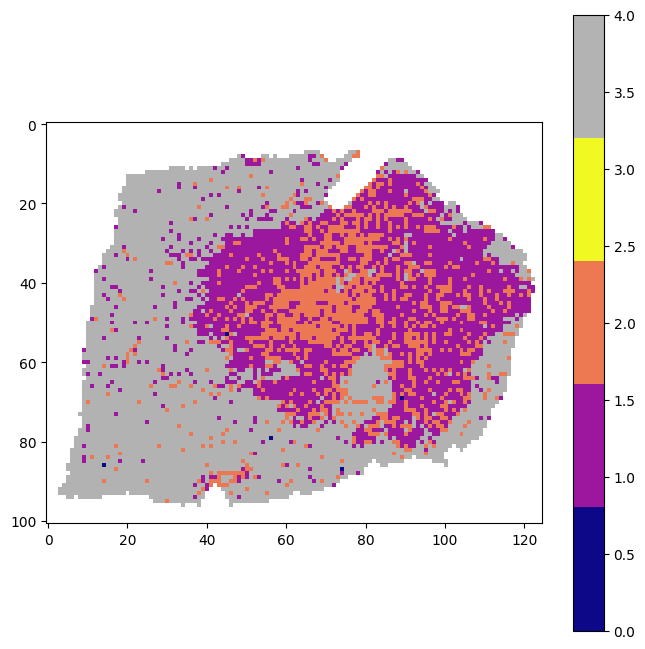

  0%|          | 0/71 [00:00<?, ?it/s]

  8%|▊         | 6/71 [00:02<00:28,  2.32it/s]

 10%|▉         | 7/71 [00:06<01:06,  1.03s/it]

 11%|█▏        | 8/71 [00:10<01:52,  1.78s/it]

 13%|█▎        | 9/71 [00:15<02:34,  2.48s/it]

 14%|█▍        | 10/71 [00:20<03:14,  3.19s/it]

 15%|█▌        | 11/71 [00:26<03:50,  3.85s/it]

 17%|█▋        | 12/71 [00:31<04:13,  4.30s/it]

 18%|█▊        | 13/71 [00:37<04:27,  4.61s/it]

 20%|█▉        | 14/71 [00:43<04:46,  5.03s/it]

 21%|██        | 15/71 [00:49<05:03,  5.42s/it]

 23%|██▎       | 16/71 [00:57<05:28,  5.97s/it]

 24%|██▍       | 17/71 [01:04<05:43,  6.36s/it]

 25%|██▌       | 18/71 [01:12<06:03,  6.86s/it]

 27%|██▋       | 19/71 [01:23<07:05,  8.18s/it]

 28%|██▊       | 20/71 [01:35<07:47,  9.18s/it]

 30%|██▉       | 21/71 [01:48<08:37, 10.34s/it]

 31%|███       | 22/71 [02:01<09:07, 11.17s/it]

 32%|███▏      | 23/71 [02:13<09:08, 11.42s/it]

 34%|███▍      | 24/71 [02:25<09:12, 11.76s/it]

 35%|███▌      | 25/71 [02:38<09:15, 12.07s/it]

 37%|███▋      | 26/71 [02:51<09:06, 12.14s/it]

 38%|███▊      | 27/71 [03:03<08:58, 12.24s/it]

 39%|███▉      | 28/71 [03:16<08:54, 12.43s/it]

 41%|████      | 29/71 [03:31<09:14, 13.20s/it]

 42%|████▏     | 30/71 [03:46<09:24, 13.77s/it]

 44%|████▎     | 31/71 [04:02<09:39, 14.49s/it]

 45%|████▌     | 32/71 [04:18<09:38, 14.84s/it]

 46%|████▋     | 33/71 [04:33<09:23, 14.84s/it]

 48%|████▊     | 34/71 [04:46<08:50, 14.34s/it]

 49%|████▉     | 35/71 [04:58<08:16, 13.78s/it]

 51%|█████     | 36/71 [05:09<07:35, 13.01s/it]

 52%|█████▏    | 37/71 [05:21<07:06, 12.53s/it]

 54%|█████▎    | 38/71 [05:32<06:43, 12.21s/it]

 55%|█████▍    | 39/71 [05:43<06:12, 11.64s/it]

 56%|█████▋    | 40/71 [05:54<05:54, 11.44s/it]

 58%|█████▊    | 41/71 [06:03<05:25, 10.85s/it]

 59%|█████▉    | 42/71 [06:13<05:04, 10.51s/it]

 61%|██████    | 43/71 [06:23<04:51, 10.41s/it]

 62%|██████▏   | 44/71 [06:34<04:47, 10.66s/it]

 63%|██████▎   | 45/71 [06:45<04:34, 10.56s/it]

 65%|██████▍   | 46/71 [06:56<04:27, 10.69s/it]

 66%|██████▌   | 47/71 [07:06<04:16, 10.68s/it]

 68%|██████▊   | 48/71 [07:17<04:08, 10.79s/it]

 69%|██████▉   | 49/71 [07:28<03:59, 10.89s/it]

 70%|███████   | 50/71 [07:39<03:44, 10.68s/it]

 72%|███████▏  | 51/71 [07:49<03:32, 10.64s/it]

 73%|███████▎  | 52/71 [08:00<03:24, 10.76s/it]

 75%|███████▍  | 53/71 [08:10<03:09, 10.52s/it]

 76%|███████▌  | 54/71 [08:20<02:53, 10.23s/it]

 77%|███████▋  | 55/71 [08:30<02:42, 10.16s/it]

 79%|███████▉  | 56/71 [08:40<02:31, 10.07s/it]

 80%|████████  | 57/71 [08:48<02:15,  9.68s/it]

 82%|████████▏ | 58/71 [08:58<02:04,  9.58s/it]

 83%|████████▎ | 59/71 [09:06<01:52,  9.34s/it]

 85%|████████▍ | 60/71 [09:15<01:40,  9.11s/it]

 86%|████████▌ | 61/71 [09:24<01:29,  8.93s/it]

 87%|████████▋ | 62/71 [09:32<01:18,  8.73s/it]

 89%|████████▊ | 63/71 [09:40<01:08,  8.57s/it]

 90%|█████████ | 64/71 [09:47<00:57,  8.22s/it]

 92%|█████████▏| 65/71 [09:55<00:48,  8.05s/it]

 93%|█████████▎| 66/71 [10:01<00:37,  7.46s/it]

 94%|█████████▍| 67/71 [10:07<00:27,  6.90s/it]

 96%|█████████▌| 68/71 [10:12<00:19,  6.36s/it]

 97%|█████████▋| 69/71 [10:14<00:10,  5.07s/it]

 99%|█████████▊| 70/71 [10:14<00:03,  3.62s/it]

100%|██████████| 71/71 [10:14<00:00,  8.66s/it]

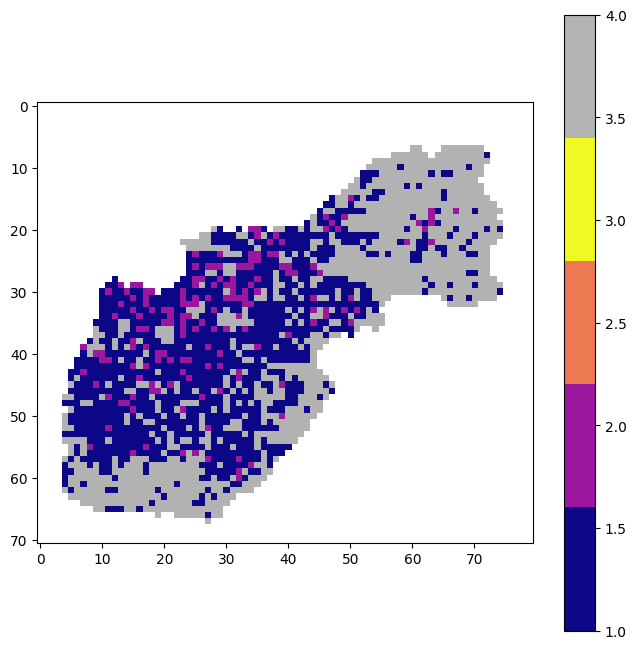

11398.svs Processed


  0%|          | 0/115 [00:00<?, ?it/s]

  3%|▎         | 3/115 [00:00<00:32,  3.41it/s]

  3%|▎         | 4/115 [00:02<01:33,  1.19it/s]

  4%|▍         | 5/115 [00:05<02:32,  1.38s/it]

  5%|▌         | 6/115 [00:11<05:18,  2.92s/it]

  6%|▌         | 7/115 [00:20<08:26,  4.69s/it]

  7%|▋         | 8/115 [00:33<12:43,  7.13s/it]

  8%|▊         | 9/115 [00:47<16:27,  9.31s/it]

  9%|▊         | 10/115 [01:02<19:13, 10.98s/it]

 10%|▉         | 11/115 [01:19<22:02, 12.72s/it]

 10%|█         | 12/115 [01:36<24:25, 14.23s/it]

 11%|█▏        | 13/115 [01:55<26:29, 15.58s/it]

 12%|█▏        | 14/115 [02:16<28:57, 17.20s/it]

 13%|█▎        | 15/115 [02:37<30:38, 18.38s/it]

 14%|█▍        | 16/115 [02:58<31:39, 19.18s/it]

 15%|█▍        | 17/115 [03:20<32:37, 19.97s/it]

 16%|█▌        | 18/115 [03:42<33:28, 20.71s/it]

 17%|█▋        | 19/115 [04:05<34:12, 21.38s/it]

 17%|█▋        | 20/115 [04:28<34:20, 21.69s/it]

 18%|█▊        | 21/115 [04:49<33:59, 21.70s/it]

 19%|█▉        | 22/115 [05:14<35:02, 22.61s/it]

 20%|██        | 23/115 [05:39<35:28, 23.14s/it]

 21%|██        | 24/115 [06:03<35:30, 23.42s/it]

 22%|██▏       | 25/115 [06:30<36:58, 24.65s/it]

 23%|██▎       | 26/115 [06:56<37:00, 24.95s/it]

 23%|██▎       | 27/115 [07:23<37:25, 25.51s/it]

 24%|██▍       | 28/115 [07:50<37:46, 26.05s/it]

 25%|██▌       | 29/115 [08:17<37:49, 26.39s/it]

 26%|██▌       | 30/115 [08:44<37:38, 26.57s/it]

 27%|██▋       | 31/115 [09:13<38:20, 27.38s/it]

 28%|██▊       | 32/115 [09:42<38:22, 27.74s/it]

 29%|██▊       | 33/115 [10:10<38:13, 27.98s/it]

 30%|██▉       | 34/115 [10:39<37:52, 28.05s/it]

 30%|███       | 35/115 [11:08<37:52, 28.40s/it]

 31%|███▏      | 36/115 [11:37<37:39, 28.60s/it]

 32%|███▏      | 37/115 [12:07<37:32, 28.88s/it]

 33%|███▎      | 38/115 [12:37<37:32, 29.26s/it]

 34%|███▍      | 39/115 [13:06<37:11, 29.36s/it]

 35%|███▍      | 40/115 [13:36<36:54, 29.53s/it]

 36%|███▌      | 41/115 [14:06<36:39, 29.72s/it]

 37%|███▋      | 42/115 [14:36<36:04, 29.66s/it]

 37%|███▋      | 43/115 [15:07<36:06, 30.09s/it]

 38%|███▊      | 44/115 [15:37<35:26, 29.95s/it]

 39%|███▉      | 45/115 [16:04<34:01, 29.16s/it]

 40%|████      | 46/115 [16:31<32:41, 28.42s/it]

 41%|████      | 47/115 [16:57<31:27, 27.76s/it]

 42%|████▏     | 48/115 [17:22<30:17, 27.13s/it]

 43%|████▎     | 49/115 [17:44<28:07, 25.57s/it]

 43%|████▎     | 50/115 [18:05<26:00, 24.00s/it]

 44%|████▍     | 51/115 [18:25<24:33, 23.02s/it]

 45%|████▌     | 52/115 [18:45<22:55, 21.83s/it]

 46%|████▌     | 53/115 [19:02<21:15, 20.57s/it]

 47%|████▋     | 54/115 [19:20<20:02, 19.72s/it]

 48%|████▊     | 55/115 [19:36<18:39, 18.66s/it]

 49%|████▊     | 56/115 [19:52<17:33, 17.85s/it]

 50%|████▉     | 57/115 [20:09<17:02, 17.64s/it]

 50%|█████     | 58/115 [20:27<16:42, 17.59s/it]

 51%|█████▏    | 59/115 [20:44<16:16, 17.44s/it]

 52%|█████▏    | 60/115 [21:01<15:50, 17.28s/it]

 53%|█████▎    | 61/115 [21:19<15:51, 17.62s/it]

 54%|█████▍    | 62/115 [21:37<15:31, 17.58s/it]

 55%|█████▍    | 63/115 [21:55<15:27, 17.84s/it]

 56%|█████▌    | 64/115 [22:18<16:23, 19.28s/it]

 57%|█████▋    | 65/115 [22:46<18:14, 21.88s/it]

 57%|█████▋    | 66/115 [23:13<19:17, 23.62s/it]

 58%|█████▊    | 67/115 [23:42<20:04, 25.09s/it]

 59%|█████▉    | 68/115 [24:13<21:11, 27.05s/it]

 60%|██████    | 69/115 [24:45<21:43, 28.33s/it]

 61%|██████    | 70/115 [25:17<22:14, 29.66s/it]

 62%|██████▏   | 71/115 [25:49<22:09, 30.21s/it]

 63%|██████▎   | 72/115 [26:22<22:15, 31.05s/it]

 63%|██████▎   | 73/115 [26:55<22:14, 31.77s/it]

 64%|██████▍   | 74/115 [27:29<22:02, 32.26s/it]

 65%|██████▌   | 75/115 [28:02<21:41, 32.53s/it]

 66%|██████▌   | 76/115 [28:35<21:18, 32.78s/it]

 67%|██████▋   | 77/115 [29:10<21:03, 33.25s/it]

 68%|██████▊   | 78/115 [29:42<20:18, 32.93s/it]

 69%|██████▊   | 79/115 [30:15<19:44, 32.90s/it]

 70%|██████▉   | 80/115 [30:46<18:59, 32.56s/it]

 70%|███████   | 81/115 [31:18<18:18, 32.30s/it]

 71%|███████▏  | 82/115 [31:50<17:45, 32.29s/it]

 72%|███████▏  | 83/115 [32:24<17:21, 32.55s/it]

 73%|███████▎  | 84/115 [32:57<16:57, 32.84s/it]

 74%|███████▍  | 85/115 [33:30<16:28, 32.94s/it]

 75%|███████▍  | 86/115 [34:03<15:57, 33.02s/it]

 76%|███████▌  | 87/115 [34:38<15:40, 33.58s/it]

 77%|███████▋  | 88/115 [35:14<15:21, 34.14s/it]

 77%|███████▋  | 89/115 [35:48<14:47, 34.14s/it]

 78%|███████▊  | 90/115 [36:22<14:15, 34.21s/it]

 79%|███████▉  | 91/115 [36:54<13:25, 33.58s/it]

 80%|████████  | 92/115 [37:26<12:35, 32.84s/it]

 81%|████████  | 93/115 [37:56<11:49, 32.27s/it]

 82%|████████▏ | 94/115 [38:28<11:09, 31.90s/it]

 83%|████████▎ | 95/115 [38:59<10:36, 31.81s/it]

 83%|████████▎ | 96/115 [39:27<09:39, 30.48s/it]

 84%|████████▍ | 97/115 [39:54<08:53, 29.64s/it]

 85%|████████▌ | 98/115 [40:21<08:10, 28.87s/it]

 86%|████████▌ | 99/115 [40:51<07:44, 29.05s/it]

 87%|████████▋ | 100/115 [41:18<07:08, 28.58s/it]

 88%|████████▊ | 101/115 [41:46<06:35, 28.22s/it]

 89%|████████▊ | 102/115 [42:13<06:02, 27.85s/it]

 90%|████████▉ | 103/115 [42:42<05:39, 28.29s/it]

 90%|█████████ | 104/115 [43:09<05:07, 27.97s/it]

 91%|█████████▏| 105/115 [43:36<04:36, 27.67s/it]

 92%|█████████▏| 106/115 [44:02<04:04, 27.13s/it]

 93%|█████████▎| 107/115 [44:29<03:37, 27.15s/it]

 94%|█████████▍| 108/115 [44:52<03:01, 25.99s/it]

 95%|█████████▍| 109/115 [45:13<02:26, 24.34s/it]

 96%|█████████▌| 110/115 [45:28<01:48, 21.69s/it]

 97%|█████████▋| 111/115 [45:42<01:16, 19.14s/it]

 97%|█████████▋| 112/115 [45:53<00:50, 16.68s/it]

 98%|█████████▊| 113/115 [46:02<00:28, 14.40s/it]

 99%|█████████▉| 114/115 [46:11<00:12, 12.84s/it]

100%|██████████| 115/115 [46:19<00:00, 11.52s/it]

100%|██████████| 115/115 [46:19<00:00, 24.17s/it]

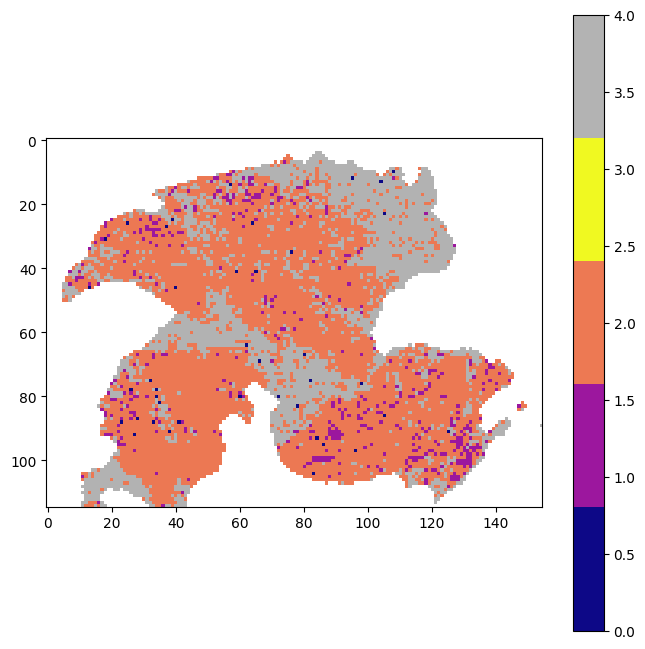

  0%|          | 0/107 [00:00<?, ?it/s]

  2%|▏         | 2/107 [00:00<00:16,  6.34it/s]

  3%|▎         | 3/107 [00:01<00:52,  1.98it/s]

  4%|▎         | 4/107 [00:05<03:17,  1.92s/it]

  5%|▍         | 5/107 [00:09<04:42,  2.77s/it]

  6%|▌         | 6/107 [00:15<06:16,  3.73s/it]

  7%|▋         | 7/107 [00:23<08:34,  5.14s/it]

  7%|▋         | 8/107 [00:34<11:14,  6.81s/it]

  8%|▊         | 9/107 [00:46<14:00,  8.58s/it]

  9%|▉         | 10/107 [01:02<17:15, 10.68s/it]

 10%|█         | 11/107 [01:20<20:50, 13.03s/it]

 11%|█         | 12/107 [01:41<24:14, 15.31s/it]

 12%|█▏        | 13/107 [02:01<26:17, 16.78s/it]

 13%|█▎        | 14/107 [02:22<27:55, 18.02s/it]

 14%|█▍        | 15/107 [02:43<29:22, 19.16s/it]

 15%|█▍        | 16/107 [03:05<30:10, 19.89s/it]

 16%|█▌        | 17/107 [03:27<30:59, 20.66s/it]

 17%|█▋        | 18/107 [03:52<32:12, 21.71s/it]

 18%|█▊        | 19/107 [04:16<32:55, 22.45s/it]

 19%|█▊        | 20/107 [04:41<33:46, 23.30s/it]

 20%|█▉        | 21/107 [05:06<33:54, 23.66s/it]

 21%|██        | 22/107 [05:33<34:56, 24.66s/it]

 21%|██▏       | 23/107 [05:59<35:09, 25.12s/it]

 22%|██▏       | 24/107 [06:25<35:02, 25.33s/it]

 23%|██▎       | 25/107 [06:51<35:14, 25.78s/it]

 24%|██▍       | 26/107 [07:19<35:25, 26.24s/it]

 25%|██▌       | 27/107 [07:46<35:13, 26.41s/it]

 26%|██▌       | 28/107 [08:13<35:00, 26.59s/it]

 27%|██▋       | 29/107 [08:39<34:27, 26.51s/it]

 28%|██▊       | 30/107 [09:05<33:44, 26.30s/it]

 29%|██▉       | 31/107 [09:31<33:11, 26.21s/it]

 30%|██▉       | 32/107 [09:58<33:01, 26.42s/it]

 31%|███       | 33/107 [10:25<32:56, 26.72s/it]

 32%|███▏      | 34/107 [10:53<33:02, 27.16s/it]

 33%|███▎      | 35/107 [11:21<32:49, 27.35s/it]

 34%|███▎      | 36/107 [11:48<32:07, 27.15s/it]

 35%|███▍      | 37/107 [12:16<32:09, 27.56s/it]

 36%|███▌      | 38/107 [12:44<31:39, 27.52s/it]

 36%|███▋      | 39/107 [13:09<30:19, 26.76s/it]

 37%|███▋      | 40/107 [13:34<29:23, 26.32s/it]

 38%|███▊      | 41/107 [13:59<28:40, 26.07s/it]

 39%|███▉      | 42/107 [14:24<27:39, 25.54s/it]

 40%|████      | 43/107 [14:47<26:33, 24.90s/it]

 41%|████      | 44/107 [15:11<25:55, 24.69s/it]

 42%|████▏     | 45/107 [15:37<25:52, 25.04s/it]

 43%|████▎     | 46/107 [16:01<25:09, 24.75s/it]

 44%|████▍     | 47/107 [16:27<24:59, 25.00s/it]

 45%|████▍     | 48/107 [16:52<24:42, 25.13s/it]

 46%|████▌     | 49/107 [17:19<24:41, 25.55s/it]

 47%|████▋     | 50/107 [17:44<24:10, 25.45s/it]

 48%|████▊     | 51/107 [18:09<23:42, 25.40s/it]

 49%|████▊     | 52/107 [18:35<23:16, 25.38s/it]

 50%|████▉     | 53/107 [19:01<23:12, 25.80s/it]

 50%|█████     | 54/107 [19:27<22:37, 25.62s/it]

 51%|█████▏    | 55/107 [19:54<22:47, 26.29s/it]

 52%|█████▏    | 56/107 [20:23<22:49, 26.85s/it]

 53%|█████▎    | 57/107 [20:50<22:27, 26.94s/it]

 54%|█████▍    | 58/107 [21:16<21:49, 26.72s/it]

 55%|█████▌    | 59/107 [21:44<21:40, 27.09s/it]

 56%|█████▌    | 60/107 [22:12<21:23, 27.31s/it]

 57%|█████▋    | 61/107 [22:40<21:05, 27.51s/it]

 58%|█████▊    | 62/107 [23:08<20:43, 27.64s/it]

 59%|█████▉    | 63/107 [23:36<20:20, 27.74s/it]

 60%|█████▉    | 64/107 [24:04<20:01, 27.94s/it]

 61%|██████    | 65/107 [24:32<19:30, 27.87s/it]

 62%|██████▏   | 66/107 [25:00<19:11, 28.09s/it]

 63%|██████▎   | 67/107 [25:29<18:51, 28.29s/it]

 64%|██████▎   | 68/107 [25:59<18:47, 28.91s/it]

 64%|██████▍   | 69/107 [26:27<18:08, 28.63s/it]

 65%|██████▌   | 70/107 [26:57<17:49, 28.91s/it]

 66%|██████▋   | 71/107 [27:26<17:22, 28.96s/it]

 67%|██████▋   | 72/107 [27:54<16:45, 28.71s/it]

 68%|██████▊   | 73/107 [28:23<16:19, 28.81s/it]

 69%|██████▉   | 74/107 [28:51<15:43, 28.59s/it]

 70%|███████   | 75/107 [29:19<15:09, 28.41s/it]

 71%|███████   | 76/107 [29:46<14:20, 27.76s/it]

 72%|███████▏  | 77/107 [30:11<13:36, 27.20s/it]

 73%|███████▎  | 78/107 [30:40<13:22, 27.66s/it]

 74%|███████▍  | 79/107 [31:05<12:29, 26.77s/it]

 75%|███████▍  | 80/107 [31:30<11:48, 26.25s/it]

 76%|███████▌  | 81/107 [31:55<11:14, 25.96s/it]

 77%|███████▋  | 82/107 [32:20<10:41, 25.66s/it]

 78%|███████▊  | 83/107 [32:44<10:00, 25.01s/it]

 79%|███████▊  | 84/107 [33:05<09:10, 23.93s/it]

 79%|███████▉  | 85/107 [33:19<07:40, 20.94s/it]

 80%|████████  | 86/107 [33:27<05:57, 17.00s/it]

 81%|████████▏ | 87/107 [33:31<04:21, 13.09s/it]

 82%|████████▏ | 88/107 [33:32<02:59,  9.44s/it]

 83%|████████▎ | 89/107 [33:33<02:04,  6.89s/it]

 84%|████████▍ | 90/107 [33:36<01:41,  5.95s/it]

 85%|████████▌ | 91/107 [33:41<01:26,  5.43s/it]

 86%|████████▌ | 92/107 [33:45<01:16,  5.12s/it]

 87%|████████▋ | 93/107 [33:50<01:11,  5.09s/it]

 88%|████████▊ | 94/107 [33:55<01:05,  5.03s/it]

 89%|████████▉ | 95/107 [33:57<00:49,  4.16s/it]

 93%|█████████▎| 99/107 [34:00<00:16,  2.04s/it]

 93%|█████████▎| 100/107 [34:04<00:16,  2.43s/it]

 94%|█████████▍| 101/107 [34:08<00:16,  2.73s/it]

 95%|█████████▌| 102/107 [34:12<00:14,  2.98s/it]

 96%|█████████▋| 103/107 [34:15<00:11,  3.00s/it]

 97%|█████████▋| 104/107 [34:18<00:08,  2.97s/it]

 98%|█████████▊| 105/107 [34:20<00:05,  2.81s/it]

 99%|█████████▉| 106/107 [34:23<00:02,  2.62s/it]

100%|██████████| 107/107 [34:24<00:00,  2.29s/it]

100%|██████████| 107/107 [34:24<00:00, 19.29s/it]

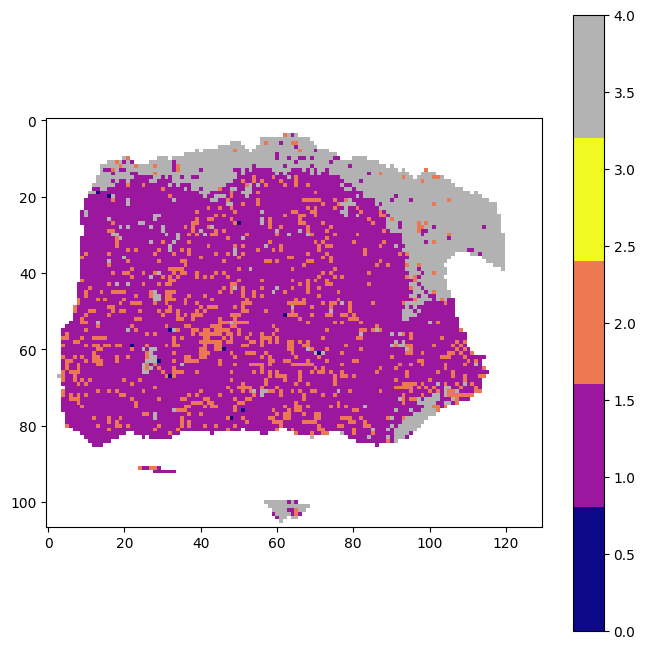

11031.svs Processed


  0%|          | 0/118 [00:00<?, ?it/s]

  1%|          | 1/118 [00:43<1:25:19, 43.75s/it]

  2%|▏         | 2/118 [00:49<41:18, 21.37s/it]  

  3%|▎         | 3/118 [00:56<28:01, 14.62s/it]

  3%|▎         | 4/118 [01:05<24:08, 12.70s/it]

  4%|▍         | 5/118 [01:17<23:16, 12.35s/it]

  5%|▌         | 6/118 [01:34<25:44, 13.79s/it]

  6%|▌         | 7/118 [01:57<31:35, 17.08s/it]

  7%|▋         | 8/118 [02:23<36:02, 19.66s/it]

  8%|▊         | 9/118 [02:47<38:33, 21.22s/it]

  8%|▊         | 10/118 [03:16<42:09, 23.42s/it]

  9%|▉         | 11/118 [03:44<44:40, 25.05s/it]

 10%|█         | 12/118 [04:12<45:39, 25.85s/it]

 11%|█         | 13/118 [04:44<48:24, 27.66s/it]

 12%|█▏        | 14/118 [05:13<48:57, 28.24s/it]

 13%|█▎        | 15/118 [05:43<49:15, 28.69s/it]

 14%|█▎        | 16/118 [06:15<50:14, 29.55s/it]

 14%|█▍        | 17/118 [06:47<51:08, 30.38s/it]

 15%|█▌        | 18/118 [07:19<51:12, 30.73s/it]

 16%|█▌        | 19/118 [07:50<51:14, 31.05s/it]

 17%|█▋        | 20/118 [08:22<51:03, 31.26s/it]

 18%|█▊        | 21/118 [08:54<50:36, 31.30s/it]

 19%|█▊        | 22/118 [09:27<51:14, 32.03s/it]

 19%|█▉        | 23/118 [09:58<50:04, 31.62s/it]

 20%|██        | 24/118 [10:30<49:45, 31.76s/it]

 21%|██        | 25/118 [11:05<50:53, 32.83s/it]

 22%|██▏       | 26/118 [11:37<49:39, 32.38s/it]

 23%|██▎       | 27/118 [12:11<49:49, 32.86s/it]

 24%|██▎       | 28/118 [12:45<49:45, 33.18s/it]

 25%|██▍       | 29/118 [13:18<49:26, 33.33s/it]

 25%|██▌       | 30/118 [13:52<48:50, 33.30s/it]

 26%|██▋       | 31/118 [14:26<48:50, 33.68s/it]

 27%|██▋       | 32/118 [15:01<48:51, 34.08s/it]

 28%|██▊       | 33/118 [15:37<48:59, 34.59s/it]

 29%|██▉       | 34/118 [16:12<48:26, 34.61s/it]

 30%|██▉       | 35/118 [16:45<47:31, 34.35s/it]

 31%|███       | 36/118 [17:21<47:20, 34.64s/it]

 31%|███▏      | 37/118 [17:56<46:59, 34.81s/it]

 32%|███▏      | 38/118 [18:30<46:05, 34.57s/it]

 33%|███▎      | 39/118 [19:03<45:08, 34.29s/it]

 34%|███▍      | 40/118 [19:39<45:12, 34.77s/it]

 35%|███▍      | 41/118 [20:13<44:02, 34.31s/it]

 36%|███▌      | 42/118 [20:46<43:14, 34.14s/it]

 36%|███▋      | 43/118 [21:22<43:10, 34.54s/it]

 37%|███▋      | 44/118 [21:57<42:48, 34.71s/it]

 38%|███▊      | 45/118 [22:32<42:24, 34.86s/it]

 39%|███▉      | 46/118 [23:08<42:23, 35.32s/it]

 40%|███▉      | 47/118 [23:43<41:37, 35.18s/it]

 41%|████      | 48/118 [24:18<40:56, 35.09s/it]

 42%|████▏     | 49/118 [24:55<41:02, 35.68s/it]

 42%|████▏     | 50/118 [25:30<40:07, 35.41s/it]

 43%|████▎     | 51/118 [26:07<40:12, 36.00s/it]

 44%|████▍     | 52/118 [26:47<40:49, 37.11s/it]

 45%|████▍     | 53/118 [27:23<39:56, 36.87s/it]

 46%|████▌     | 54/118 [28:01<39:28, 37.00s/it]

 47%|████▋     | 55/118 [28:40<39:26, 37.56s/it]

 47%|████▋     | 56/118 [29:16<38:27, 37.22s/it]

 48%|████▊     | 57/118 [29:52<37:30, 36.90s/it]

 49%|████▉     | 58/118 [30:30<37:04, 37.08s/it]

 50%|█████     | 59/118 [31:06<36:14, 36.86s/it]

 51%|█████     | 60/118 [31:43<35:38, 36.87s/it]

 52%|█████▏    | 61/118 [32:22<35:33, 37.44s/it]

 53%|█████▎    | 62/118 [32:59<34:53, 37.39s/it]

 53%|█████▎    | 63/118 [33:36<34:18, 37.42s/it]

 54%|█████▍    | 64/118 [34:14<33:42, 37.46s/it]

 55%|█████▌    | 65/118 [34:50<32:47, 37.13s/it]

 56%|█████▌    | 66/118 [35:28<32:23, 37.37s/it]

 57%|█████▋    | 67/118 [36:07<32:12, 37.88s/it]

 58%|█████▊    | 68/118 [36:46<31:44, 38.09s/it]

 58%|█████▊    | 69/118 [37:24<30:59, 37.95s/it]

 59%|█████▉    | 70/118 [38:03<30:48, 38.52s/it]

 60%|██████    | 71/118 [38:41<29:51, 38.12s/it]

 61%|██████    | 72/118 [39:19<29:22, 38.31s/it]

 62%|██████▏   | 73/118 [39:59<29:07, 38.84s/it]

 63%|██████▎   | 74/118 [40:39<28:41, 39.12s/it]

 64%|██████▎   | 75/118 [41:19<28:15, 39.43s/it]

 64%|██████▍   | 76/118 [42:00<27:52, 39.82s/it]

 65%|██████▌   | 77/118 [42:39<27:03, 39.59s/it]

 66%|██████▌   | 78/118 [43:17<25:59, 39.00s/it]

 67%|██████▋   | 79/118 [43:56<25:27, 39.17s/it]

 68%|██████▊   | 80/118 [44:34<24:28, 38.65s/it]

 69%|██████▊   | 81/118 [45:12<23:49, 38.65s/it]

 69%|██████▉   | 82/118 [45:51<23:15, 38.77s/it]

 70%|███████   | 83/118 [46:34<23:11, 39.75s/it]

 71%|███████   | 84/118 [47:15<22:48, 40.25s/it]

 72%|███████▏  | 85/118 [47:55<22:06, 40.19s/it]

 73%|███████▎  | 86/118 [48:38<21:55, 41.10s/it]

 74%|███████▎  | 87/118 [49:20<21:16, 41.17s/it]

 75%|███████▍  | 88/118 [50:00<20:24, 40.83s/it]

 75%|███████▌  | 89/118 [50:40<19:44, 40.85s/it]

 76%|███████▋  | 90/118 [51:23<19:17, 41.34s/it]

 77%|███████▋  | 91/118 [52:05<18:41, 41.55s/it]

 78%|███████▊  | 92/118 [52:45<17:44, 40.94s/it]

 79%|███████▉  | 93/118 [53:25<17:01, 40.86s/it]

 80%|███████▉  | 94/118 [54:03<15:58, 39.93s/it]

 81%|████████  | 95/118 [54:41<15:03, 39.29s/it]

 81%|████████▏ | 96/118 [55:18<14:13, 38.81s/it]

 82%|████████▏ | 97/118 [55:54<13:17, 37.97s/it]

 83%|████████▎ | 98/118 [56:30<12:25, 37.25s/it]

 84%|████████▍ | 99/118 [57:05<11:33, 36.48s/it]

 85%|████████▍ | 100/118 [57:39<10:45, 35.88s/it]

 86%|████████▌ | 101/118 [58:14<10:02, 35.45s/it]

 86%|████████▋ | 102/118 [58:48<09:19, 35.00s/it]

 87%|████████▋ | 103/118 [59:21<08:38, 34.54s/it]

 88%|████████▊ | 104/118 [59:53<07:52, 33.74s/it]

 89%|████████▉ | 105/118 [1:00:25<07:13, 33.37s/it]

 90%|████████▉ | 106/118 [1:00:57<06:32, 32.74s/it]

 91%|█████████ | 107/118 [1:01:29<05:57, 32.54s/it]

 92%|█████████▏| 108/118 [1:02:00<05:22, 32.25s/it]

 92%|█████████▏| 109/118 [1:02:30<04:43, 31.49s/it]

 93%|█████████▎| 110/118 [1:02:59<04:05, 30.73s/it]

 94%|█████████▍| 111/118 [1:03:28<03:32, 30.29s/it]

 95%|█████████▍| 112/118 [1:03:55<02:55, 29.18s/it]

 96%|█████████▌| 113/118 [1:04:22<02:22, 28.49s/it]

 97%|█████████▋| 114/118 [1:04:47<01:50, 27.53s/it]

 97%|█████████▋| 115/118 [1:05:12<01:20, 26.79s/it]

 98%|█████████▊| 116/118 [1:05:36<00:51, 25.81s/it]

 99%|█████████▉| 117/118 [1:05:59<00:25, 25.00s/it]

100%|██████████| 118/118 [1:06:18<00:00, 23.34s/it]

100%|██████████| 118/118 [1:06:18<00:00, 33.72s/it]

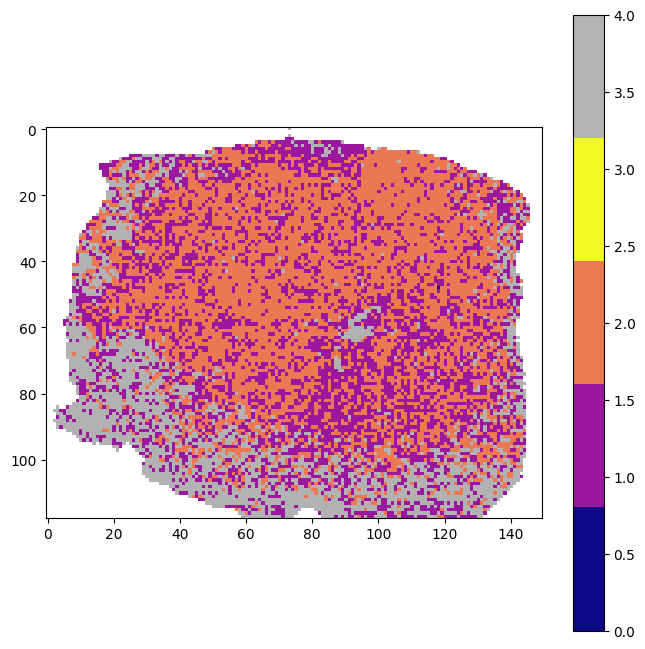

11456.svs Processed
11372.svs Processed
11351.svs Processed
11438.svs Processed
10171.svs Processed
10497.svs Processed
11286.svs Processed
10379.svs Processed


11005.svs Processed
11122.svs Processed


  0%|          | 0/98 [00:00<?, ?it/s]

  7%|▋         | 7/98 [00:02<00:35,  2.54it/s]

  8%|▊         | 8/98 [00:06<01:21,  1.10it/s]

  9%|▉         | 9/98 [00:09<02:11,  1.47s/it]

 10%|█         | 10/98 [00:14<03:07,  2.14s/it]

 11%|█         | 11/98 [00:19<04:00,  2.77s/it]

 12%|█▏        | 12/98 [00:24<04:47,  3.34s/it]

 13%|█▎        | 13/98 [00:29<05:30,  3.89s/it]

 14%|█▍        | 14/98 [00:35<06:10,  4.41s/it]

 15%|█▌        | 15/98 [00:41<06:32,  4.73s/it]

 16%|█▋        | 16/98 [00:46<06:44,  4.94s/it]

 17%|█▋        | 17/98 [00:52<06:53,  5.10s/it]

 18%|█▊        | 18/98 [00:57<07:03,  5.29s/it]

 19%|█▉        | 19/98 [01:04<07:30,  5.71s/it]

 20%|██        | 20/98 [01:10<07:31,  5.79s/it]

 21%|██▏       | 21/98 [01:16<07:34,  5.91s/it]

 22%|██▏       | 22/98 [01:23<07:48,  6.17s/it]

 23%|██▎       | 23/98 [01:30<07:57,  6.36s/it]

 24%|██▍       | 24/98 [01:36<07:57,  6.45s/it]

 26%|██▌       | 25/98 [01:45<08:30,  6.99s/it]

 27%|██▋       | 26/98 [01:54<09:04,  7.56s/it]

 28%|██▊       | 27/98 [02:05<10:16,  8.68s/it]

 29%|██▊       | 28/98 [02:17<11:28,  9.83s/it]

 30%|██▉       | 29/98 [02:32<12:54, 11.23s/it]

 31%|███       | 30/98 [02:46<13:39, 12.05s/it]

 32%|███▏      | 31/98 [03:00<14:20, 12.84s/it]

 33%|███▎      | 32/98 [03:16<14:55, 13.57s/it]

 34%|███▎      | 33/98 [03:31<15:17, 14.11s/it]

 35%|███▍      | 34/98 [03:46<15:19, 14.37s/it]

 36%|███▌      | 35/98 [04:01<15:16, 14.55s/it]

 37%|███▋      | 36/98 [04:16<15:10, 14.69s/it]

 38%|███▊      | 37/98 [04:33<15:42, 15.45s/it]

 39%|███▉      | 38/98 [04:50<15:42, 15.70s/it]

 40%|███▉      | 39/98 [05:06<15:38, 15.90s/it]

 41%|████      | 40/98 [05:23<15:34, 16.12s/it]

 42%|████▏     | 41/98 [05:40<15:46, 16.61s/it]

 43%|████▎     | 42/98 [05:58<15:39, 16.78s/it]

 44%|████▍     | 43/98 [06:16<15:44, 17.18s/it]

 45%|████▍     | 44/98 [06:34<15:45, 17.52s/it]

 46%|████▌     | 45/98 [06:52<15:39, 17.73s/it]

 47%|████▋     | 46/98 [07:12<15:48, 18.24s/it]

 48%|████▊     | 47/98 [07:31<15:50, 18.63s/it]

 49%|████▉     | 48/98 [07:50<15:34, 18.70s/it]

 50%|█████     | 49/98 [08:10<15:30, 18.99s/it]

 51%|█████     | 50/98 [08:30<15:28, 19.35s/it]

 52%|█████▏    | 51/98 [08:49<15:12, 19.41s/it]

 53%|█████▎    | 52/98 [09:10<15:04, 19.65s/it]

 54%|█████▍    | 53/98 [09:31<15:10, 20.24s/it]

 55%|█████▌    | 54/98 [09:51<14:44, 20.11s/it]

 56%|█████▌    | 55/98 [10:12<14:29, 20.21s/it]

 57%|█████▋    | 56/98 [10:31<14:00, 20.02s/it]

 58%|█████▊    | 57/98 [10:51<13:41, 20.03s/it]

 59%|█████▉    | 58/98 [11:11<13:16, 19.91s/it]

 60%|██████    | 59/98 [11:31<12:56, 19.91s/it]

 61%|██████    | 60/98 [11:50<12:34, 19.86s/it]

 62%|██████▏   | 61/98 [12:09<12:05, 19.62s/it]

 63%|██████▎   | 62/98 [12:28<11:35, 19.32s/it]

 64%|██████▍   | 63/98 [12:47<11:16, 19.34s/it]

 65%|██████▌   | 64/98 [13:06<10:53, 19.23s/it]

 66%|██████▋   | 65/98 [13:25<10:29, 19.08s/it]

 67%|██████▋   | 66/98 [13:46<10:23, 19.47s/it]

 68%|██████▊   | 67/98 [14:05<10:03, 19.47s/it]

 69%|██████▉   | 68/98 [14:26<09:56, 19.89s/it]

 70%|███████   | 69/98 [14:46<09:39, 19.98s/it]

 71%|███████▏  | 70/98 [15:05<09:12, 19.74s/it]

 72%|███████▏  | 71/98 [15:23<08:36, 19.12s/it]

 73%|███████▎  | 72/98 [15:42<08:16, 19.09s/it]

 74%|███████▍  | 73/98 [16:01<07:56, 19.04s/it]

 76%|███████▌  | 74/98 [16:19<07:29, 18.73s/it]

 77%|███████▋  | 75/98 [16:35<06:55, 18.06s/it]

 78%|███████▊  | 76/98 [16:51<06:23, 17.41s/it]

 79%|███████▊  | 77/98 [17:06<05:51, 16.73s/it]

 80%|███████▉  | 78/98 [17:20<05:18, 15.92s/it]

 81%|████████  | 79/98 [17:33<04:41, 14.83s/it]

 82%|████████▏ | 80/98 [17:43<04:01, 13.43s/it]

 83%|████████▎ | 81/98 [17:52<03:24, 12.02s/it]

 84%|████████▎ | 82/98 [18:00<02:53, 10.85s/it]

 85%|████████▍ | 83/98 [18:07<02:27,  9.84s/it]

 86%|████████▌ | 84/98 [18:13<02:01,  8.70s/it]

 87%|████████▋ | 85/98 [18:18<01:35,  7.37s/it]

 88%|████████▊ | 86/98 [18:22<01:17,  6.45s/it]

 89%|████████▉ | 87/98 [18:26<01:03,  5.81s/it]

 90%|████████▉ | 88/98 [18:32<00:56,  5.68s/it]

 91%|█████████ | 89/98 [18:36<00:47,  5.25s/it]

 92%|█████████▏| 90/98 [18:39<00:38,  4.77s/it]

 93%|█████████▎| 91/98 [18:42<00:29,  4.23s/it]

 94%|█████████▍| 92/98 [18:45<00:21,  3.65s/it]

 95%|█████████▍| 93/98 [18:47<00:16,  3.33s/it]

 96%|█████████▌| 94/98 [18:49<00:11,  2.81s/it]

 97%|█████████▋| 95/98 [18:49<00:06,  2.10s/it]

100%|██████████| 98/98 [18:49<00:00, 11.53s/it]

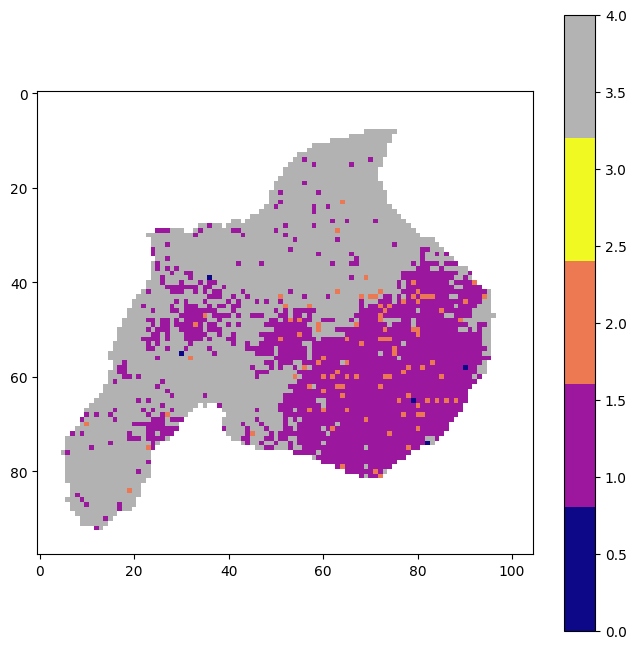

  0%|          | 0/112 [00:00<?, ?it/s]

  4%|▎         | 4/112 [00:05<02:29,  1.38s/it]

  4%|▍         | 5/112 [00:12<05:01,  2.82s/it]

  5%|▌         | 6/112 [00:20<07:32,  4.26s/it]

  6%|▋         | 7/112 [00:29<10:01,  5.72s/it]

  7%|▋         | 8/112 [00:39<11:45,  6.78s/it]

  8%|▊         | 9/112 [00:48<12:53,  7.51s/it]

  9%|▉         | 10/112 [00:58<13:59,  8.23s/it]

 10%|▉         | 11/112 [01:09<15:10,  9.02s/it]

 11%|█         | 12/112 [01:19<15:41,  9.41s/it]

 12%|█▏        | 13/112 [01:33<17:35, 10.66s/it]

 12%|█▎        | 14/112 [01:46<18:20, 11.23s/it]

 13%|█▎        | 15/112 [02:02<20:42, 12.81s/it]

 14%|█▍        | 16/112 [02:21<23:26, 14.65s/it]

 15%|█▌        | 17/112 [02:41<25:52, 16.34s/it]

 16%|█▌        | 18/112 [03:01<27:15, 17.40s/it]

 17%|█▋        | 19/112 [03:22<28:37, 18.47s/it]

 18%|█▊        | 20/112 [03:45<30:16, 19.75s/it]

 19%|█▉        | 21/112 [04:07<30:59, 20.43s/it]

 20%|█▉        | 22/112 [04:30<31:52, 21.25s/it]

 21%|██        | 23/112 [04:53<32:06, 21.65s/it]

 21%|██▏       | 24/112 [05:16<32:30, 22.17s/it]

 22%|██▏       | 25/112 [05:41<33:21, 23.00s/it]

 23%|██▎       | 26/112 [06:05<33:23, 23.30s/it]

 24%|██▍       | 27/112 [06:29<33:07, 23.38s/it]

 25%|██▌       | 28/112 [06:53<33:18, 23.79s/it]

 26%|██▌       | 29/112 [07:18<33:12, 24.01s/it]

 27%|██▋       | 30/112 [07:46<34:22, 25.15s/it]

 28%|██▊       | 31/112 [08:12<34:37, 25.65s/it]

 29%|██▊       | 32/112 [08:39<34:33, 25.92s/it]

 29%|██▉       | 33/112 [09:05<34:06, 25.91s/it]

 30%|███       | 34/112 [09:31<33:53, 26.07s/it]

 31%|███▏      | 35/112 [09:57<33:16, 25.92s/it]

 32%|███▏      | 36/112 [10:22<32:28, 25.64s/it]

 33%|███▎      | 37/112 [10:49<32:26, 25.95s/it]

 34%|███▍      | 38/112 [11:13<31:31, 25.56s/it]

 35%|███▍      | 39/112 [11:39<31:13, 25.67s/it]

 36%|███▌      | 40/112 [12:04<30:29, 25.41s/it]

 37%|███▋      | 41/112 [12:28<29:32, 24.96s/it]

 38%|███▊      | 42/112 [12:51<28:30, 24.43s/it]

 38%|███▊      | 43/112 [13:14<27:40, 24.06s/it]

 39%|███▉      | 44/112 [13:35<26:17, 23.20s/it]

 40%|████      | 45/112 [13:55<24:39, 22.09s/it]

 41%|████      | 46/112 [14:13<23:06, 21.01s/it]

 42%|████▏     | 47/112 [14:31<21:32, 19.89s/it]

 43%|████▎     | 48/112 [14:48<20:20, 19.06s/it]

 44%|████▍     | 49/112 [15:04<19:10, 18.27s/it]

 45%|████▍     | 50/112 [15:20<18:12, 17.62s/it]

 46%|████▌     | 51/112 [15:38<17:48, 17.52s/it]

 46%|████▋     | 52/112 [15:54<17:17, 17.29s/it]

 47%|████▋     | 53/112 [16:11<16:46, 17.06s/it]

 48%|████▊     | 54/112 [16:27<16:13, 16.79s/it]

 49%|████▉     | 55/112 [16:44<16:05, 16.94s/it]

 50%|█████     | 56/112 [17:02<16:07, 17.27s/it]

 51%|█████     | 57/112 [17:21<16:07, 17.60s/it]

 52%|█████▏    | 58/112 [17:40<16:19, 18.13s/it]

 53%|█████▎    | 59/112 [17:59<16:08, 18.27s/it]

 54%|█████▎    | 60/112 [18:20<16:30, 19.05s/it]

 54%|█████▍    | 61/112 [18:43<17:16, 20.32s/it]

 55%|█████▌    | 62/112 [19:07<17:53, 21.47s/it]

 56%|█████▋    | 63/112 [19:31<18:10, 22.24s/it]

 57%|█████▋    | 64/112 [19:56<18:25, 23.02s/it]

 58%|█████▊    | 65/112 [20:23<19:04, 24.34s/it]

 59%|█████▉    | 66/112 [20:52<19:34, 25.54s/it]

 60%|█████▉    | 67/112 [21:19<19:35, 26.13s/it]

 61%|██████    | 68/112 [21:48<19:40, 26.82s/it]

 62%|██████▏   | 69/112 [22:17<19:45, 27.58s/it]

 62%|██████▎   | 70/112 [22:46<19:37, 28.02s/it]

 63%|██████▎   | 71/112 [23:15<19:20, 28.30s/it]

 64%|██████▍   | 72/112 [23:44<19:02, 28.56s/it]

 65%|██████▌   | 73/112 [24:14<18:52, 29.03s/it]

 66%|██████▌   | 74/112 [24:45<18:47, 29.67s/it]

 67%|██████▋   | 75/112 [25:16<18:27, 29.92s/it]

 68%|██████▊   | 76/112 [25:48<18:19, 30.54s/it]

 69%|██████▉   | 77/112 [26:20<18:07, 31.08s/it]

 70%|██████▉   | 78/112 [26:54<18:04, 31.91s/it]

 71%|███████   | 79/112 [27:27<17:42, 32.20s/it]

 71%|███████▏  | 80/112 [28:00<17:17, 32.42s/it]

 72%|███████▏  | 81/112 [28:35<17:08, 33.17s/it]

 73%|███████▎  | 82/112 [29:07<16:30, 33.00s/it]

 74%|███████▍  | 83/112 [29:38<15:38, 32.37s/it]

 75%|███████▌  | 84/112 [30:09<14:50, 31.79s/it]

 76%|███████▌  | 85/112 [30:40<14:15, 31.69s/it]

 77%|███████▋  | 86/112 [31:12<13:48, 31.85s/it]

 78%|███████▊  | 87/112 [31:45<13:19, 31.98s/it]

 79%|███████▊  | 88/112 [32:18<12:59, 32.48s/it]

 79%|███████▉  | 89/112 [32:52<12:36, 32.88s/it]

 80%|████████  | 90/112 [33:25<12:01, 32.81s/it]

 81%|████████▏ | 91/112 [33:56<11:18, 32.32s/it]

 82%|████████▏ | 92/112 [34:25<10:24, 31.22s/it]

 83%|████████▎ | 93/112 [34:54<09:40, 30.56s/it]

 84%|████████▍ | 94/112 [35:20<08:45, 29.18s/it]

 85%|████████▍ | 95/112 [35:44<07:49, 27.61s/it]

 86%|████████▌ | 96/112 [36:05<06:52, 25.79s/it]

 87%|████████▋ | 97/112 [36:23<05:50, 23.36s/it]

 88%|████████▊ | 98/112 [36:41<05:03, 21.68s/it]

 88%|████████▊ | 99/112 [36:58<04:24, 20.38s/it]

 89%|████████▉ | 100/112 [37:14<03:48, 19.04s/it]

 90%|█████████ | 101/112 [37:29<03:16, 17.88s/it]

 91%|█████████ | 102/112 [37:45<02:51, 17.20s/it]

 92%|█████████▏| 103/112 [37:58<02:24, 16.02s/it]

 93%|█████████▎| 104/112 [38:11<02:00, 15.12s/it]

 94%|█████████▍| 105/112 [38:23<01:40, 14.35s/it]

 95%|█████████▍| 106/112 [38:35<01:20, 13.43s/it]

 96%|█████████▌| 107/112 [38:46<01:04, 12.80s/it]

 96%|█████████▋| 108/112 [38:56<00:47, 11.97s/it]

 97%|█████████▋| 109/112 [39:04<00:32, 10.72s/it]

 98%|█████████▊| 110/112 [39:06<00:16,  8.01s/it]

100%|██████████| 112/112 [39:06<00:00, 20.95s/it]

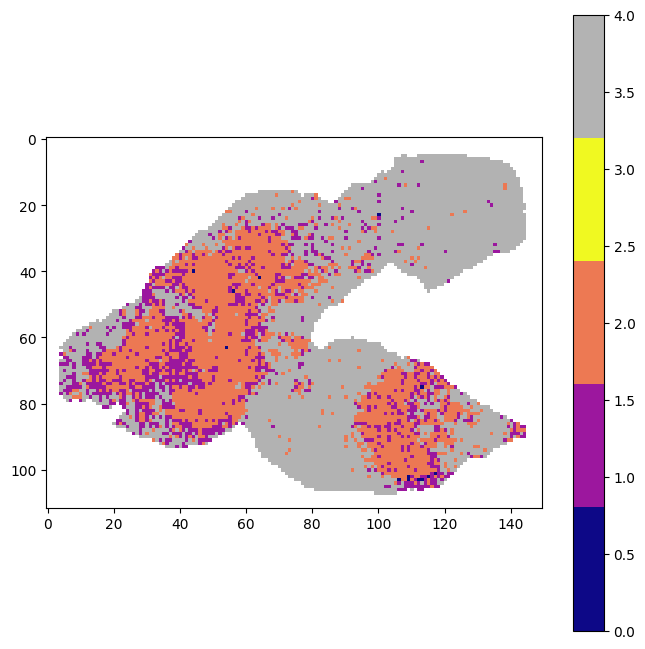

9946.svs Processed
9548.svs Processed
10374.svs Processed
'int' object has no attribute 'properties'
10136.svs Processed
10939.svs Processed
11107.svs Processed
10894.svs Processed


10669.svs Processed
10384.svs Processed
10988.svs Processed
11038.svs Processed
10865.svs Processed
9980.svs Processed


  0%|          | 0/83 [00:00<?, ?it/s]

  4%|▎         | 3/83 [00:01<00:27,  2.92it/s]

  5%|▍         | 4/83 [00:02<00:52,  1.50it/s]

  6%|▌         | 5/83 [00:03<01:07,  1.15it/s]

  7%|▋         | 6/83 [00:04<01:17,  1.00s/it]

  8%|▊         | 7/83 [00:06<01:29,  1.18s/it]

 10%|▉         | 8/83 [00:08<01:47,  1.43s/it]

 11%|█         | 9/83 [00:10<02:03,  1.67s/it]

 12%|█▏        | 10/83 [00:13<02:14,  1.84s/it]

 13%|█▎        | 11/83 [00:16<02:45,  2.30s/it]

 14%|█▍        | 12/83 [00:19<03:08,  2.66s/it]

 16%|█▌        | 13/83 [00:23<03:33,  3.05s/it]

 17%|█▋        | 14/83 [00:27<03:45,  3.27s/it]

 18%|█▊        | 15/83 [00:31<03:57,  3.50s/it]

 19%|█▉        | 16/83 [00:35<03:59,  3.58s/it]

 20%|██        | 17/83 [00:39<04:08,  3.76s/it]

 22%|██▏       | 18/83 [00:44<04:24,  4.07s/it]

 23%|██▎       | 19/83 [00:49<04:42,  4.42s/it]

 24%|██▍       | 20/83 [00:54<04:53,  4.66s/it]

 25%|██▌       | 21/83 [01:00<05:03,  4.90s/it]

 27%|██▋       | 22/83 [01:05<05:11,  5.10s/it]

 28%|██▊       | 23/83 [01:11<05:21,  5.36s/it]

 29%|██▉       | 24/83 [01:18<05:31,  5.61s/it]

 30%|███       | 25/83 [01:24<05:44,  5.94s/it]

 31%|███▏      | 26/83 [01:31<05:58,  6.30s/it]

 33%|███▎      | 27/83 [01:38<06:01,  6.46s/it]

 34%|███▎      | 28/83 [01:45<06:01,  6.58s/it]

 35%|███▍      | 29/83 [01:52<06:00,  6.67s/it]

 36%|███▌      | 30/83 [02:02<06:46,  7.67s/it]

 37%|███▋      | 31/83 [02:14<07:52,  9.09s/it]

 39%|███▊      | 32/83 [02:28<08:58, 10.56s/it]

 40%|███▉      | 33/83 [02:43<09:45, 11.71s/it]

 41%|████      | 34/83 [02:58<10:29, 12.84s/it]

 42%|████▏     | 35/83 [03:13<10:49, 13.54s/it]

 43%|████▎     | 36/83 [03:27<10:43, 13.70s/it]

 45%|████▍     | 37/83 [03:42<10:36, 13.83s/it]

 46%|████▌     | 38/83 [03:55<10:15, 13.67s/it]

 47%|████▋     | 39/83 [04:06<09:30, 12.96s/it]

 48%|████▊     | 40/83 [04:18<08:58, 12.53s/it]

 49%|████▉     | 41/83 [04:28<08:14, 11.76s/it]

 51%|█████     | 42/83 [04:38<07:38, 11.19s/it]

 52%|█████▏    | 43/83 [04:46<06:58, 10.46s/it]

 53%|█████▎    | 44/83 [04:53<06:01,  9.26s/it]

 54%|█████▍    | 45/83 [04:58<05:06,  8.06s/it]

 55%|█████▌    | 46/83 [05:02<04:18,  6.98s/it]

 57%|█████▋    | 47/83 [05:06<03:29,  5.82s/it]

 58%|█████▊    | 48/83 [05:08<02:50,  4.87s/it]

 59%|█████▉    | 49/83 [05:10<02:18,  4.07s/it]

 60%|██████    | 50/83 [05:13<01:55,  3.51s/it]

 61%|██████▏   | 51/83 [05:14<01:35,  2.99s/it]

 63%|██████▎   | 52/83 [05:16<01:22,  2.66s/it]

 64%|██████▍   | 53/83 [05:20<01:29,  2.97s/it]

 65%|██████▌   | 54/83 [05:23<01:26,  2.97s/it]

 66%|██████▋   | 55/83 [05:26<01:24,  3.02s/it]

 67%|██████▋   | 56/83 [05:29<01:24,  3.12s/it]

 69%|██████▊   | 57/83 [05:34<01:29,  3.44s/it]

 70%|██████▉   | 58/83 [05:38<01:30,  3.63s/it]

 71%|███████   | 59/83 [05:42<01:33,  3.88s/it]

 72%|███████▏  | 60/83 [05:47<01:34,  4.12s/it]

 73%|███████▎  | 61/83 [05:52<01:36,  4.39s/it]

 75%|███████▍  | 62/83 [05:57<01:37,  4.64s/it]

 76%|███████▌  | 63/83 [06:02<01:36,  4.82s/it]

 77%|███████▋  | 64/83 [06:08<01:33,  4.91s/it]

 78%|███████▊  | 65/83 [06:13<01:30,  5.01s/it]

 80%|███████▉  | 66/83 [06:18<01:28,  5.22s/it]

 81%|████████  | 67/83 [06:24<01:24,  5.29s/it]

 82%|████████▏ | 68/83 [06:29<01:19,  5.31s/it]

 83%|████████▎ | 69/83 [06:35<01:15,  5.42s/it]

 84%|████████▍ | 70/83 [06:41<01:11,  5.52s/it]

 86%|████████▌ | 71/83 [06:46<01:06,  5.51s/it]

 87%|████████▋ | 72/83 [06:52<01:00,  5.50s/it]

 88%|████████▊ | 73/83 [06:57<00:54,  5.49s/it]

 89%|████████▉ | 74/83 [07:02<00:47,  5.28s/it]

 90%|█████████ | 75/83 [07:06<00:40,  5.05s/it]

 92%|█████████▏| 76/83 [07:11<00:34,  5.00s/it]

 93%|█████████▎| 77/83 [07:17<00:30,  5.07s/it]

 94%|█████████▍| 78/83 [07:22<00:25,  5.15s/it]

 95%|█████████▌| 79/83 [07:27<00:20,  5.05s/it]

 96%|█████████▋| 80/83 [07:29<00:12,  4.28s/it]

 98%|█████████▊| 81/83 [07:30<00:06,  3.33s/it]

 99%|█████████▉| 82/83 [07:31<00:02,  2.40s/it]

100%|██████████| 83/83 [07:31<00:00,  5.43s/it]

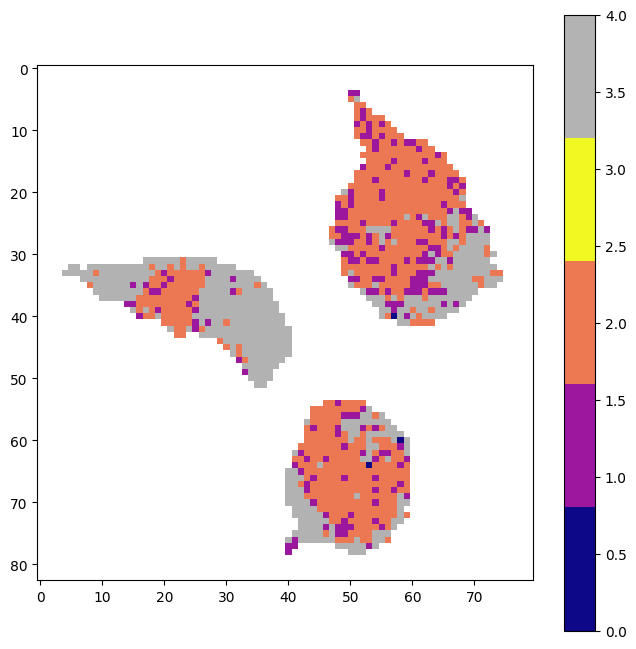

  0%|          | 0/115 [00:00<?, ?it/s]

  1%|          | 1/115 [00:28<54:05, 28.47s/it]

  2%|▏         | 2/115 [00:54<50:55, 27.04s/it]

  3%|▎         | 4/115 [00:55<19:02, 10.29s/it]

  4%|▍         | 5/115 [00:56<13:47,  7.52s/it]

  5%|▌         | 6/115 [00:57<09:58,  5.49s/it]

  6%|▌         | 7/115 [00:59<07:57,  4.42s/it]

  7%|▋         | 8/115 [01:01<06:50,  3.84s/it]

  8%|▊         | 9/115 [01:04<06:18,  3.57s/it]

  9%|▊         | 10/115 [01:08<06:06,  3.49s/it]

 10%|▉         | 11/115 [01:11<05:51,  3.38s/it]

 10%|█         | 12/115 [01:15<06:01,  3.51s/it]

 11%|█▏        | 13/115 [01:19<06:27,  3.80s/it]

 12%|█▏        | 14/115 [01:23<06:36,  3.93s/it]

 13%|█▎        | 15/115 [01:28<07:01,  4.21s/it]

 14%|█▍        | 16/115 [01:33<07:17,  4.42s/it]

 15%|█▍        | 17/115 [01:39<07:57,  4.87s/it]

 16%|█▌        | 18/115 [01:46<08:56,  5.53s/it]

 17%|█▋        | 19/115 [01:54<10:01,  6.26s/it]

 17%|█▋        | 20/115 [02:02<10:56,  6.91s/it]

 18%|█▊        | 21/115 [02:11<11:33,  7.38s/it]

 19%|█▉        | 22/115 [02:21<12:38,  8.16s/it]

 20%|██        | 23/115 [02:30<13:03,  8.52s/it]

 21%|██        | 24/115 [02:39<13:05,  8.64s/it]

 22%|██▏       | 25/115 [02:50<13:54,  9.27s/it]

 23%|██▎       | 26/115 [03:00<14:02,  9.47s/it]

 23%|██▎       | 27/115 [03:10<14:11,  9.67s/it]

 24%|██▍       | 28/115 [03:20<14:24,  9.93s/it]

 25%|██▌       | 29/115 [03:31<14:38, 10.22s/it]

 26%|██▌       | 30/115 [03:42<14:42, 10.39s/it]

 27%|██▋       | 31/115 [03:54<15:07, 10.80s/it]

 28%|██▊       | 32/115 [04:05<15:05, 10.91s/it]

 29%|██▊       | 33/115 [04:16<15:05, 11.04s/it]

 30%|██▉       | 34/115 [04:29<15:38, 11.59s/it]

 30%|███       | 35/115 [04:43<16:27, 12.35s/it]

 31%|███▏      | 36/115 [04:57<16:38, 12.64s/it]

 32%|███▏      | 37/115 [05:10<16:45, 12.89s/it]

 33%|███▎      | 38/115 [05:25<17:08, 13.36s/it]

 34%|███▍      | 39/115 [05:39<17:20, 13.69s/it]

 35%|███▍      | 40/115 [05:55<17:52, 14.30s/it]

 36%|███▌      | 41/115 [06:10<17:53, 14.51s/it]

 37%|███▋      | 42/115 [06:26<18:24, 15.13s/it]

 37%|███▋      | 43/115 [06:42<18:25, 15.36s/it]

 38%|███▊      | 44/115 [06:59<18:35, 15.72s/it]

 39%|███▉      | 45/115 [07:16<18:41, 16.02s/it]

 40%|████      | 46/115 [07:32<18:33, 16.14s/it]

 41%|████      | 47/115 [07:50<18:50, 16.62s/it]

 42%|████▏     | 48/115 [08:07<18:40, 16.72s/it]

 43%|████▎     | 49/115 [08:24<18:43, 17.03s/it]

 43%|████▎     | 50/115 [08:43<18:53, 17.44s/it]

 44%|████▍     | 51/115 [09:02<19:10, 17.98s/it]

 45%|████▌     | 52/115 [09:21<19:14, 18.32s/it]

 46%|████▌     | 53/115 [09:39<18:53, 18.28s/it]

 47%|████▋     | 54/115 [09:59<19:00, 18.70s/it]

 48%|████▊     | 55/115 [10:19<18:59, 18.99s/it]

 49%|████▊     | 56/115 [10:39<19:01, 19.35s/it]

 50%|████▉     | 57/115 [10:58<18:35, 19.23s/it]

 50%|█████     | 58/115 [11:16<18:01, 18.97s/it]

 51%|█████▏    | 59/115 [11:35<17:42, 18.97s/it]

 52%|█████▏    | 60/115 [11:54<17:21, 18.93s/it]

 53%|█████▎    | 61/115 [12:12<16:48, 18.68s/it]

 54%|█████▍    | 62/115 [12:31<16:27, 18.64s/it]

 55%|█████▍    | 63/115 [12:49<16:09, 18.64s/it]

 56%|█████▌    | 64/115 [13:08<15:56, 18.76s/it]

 57%|█████▋    | 65/115 [13:29<16:02, 19.25s/it]

 57%|█████▋    | 66/115 [13:49<16:02, 19.64s/it]

 58%|█████▊    | 67/115 [14:09<15:37, 19.54s/it]

 59%|█████▉    | 68/115 [14:28<15:10, 19.36s/it]

 60%|██████    | 69/115 [14:46<14:41, 19.17s/it]

 61%|██████    | 70/115 [15:05<14:16, 19.02s/it]

 62%|██████▏   | 71/115 [15:24<13:50, 18.88s/it]

 63%|██████▎   | 72/115 [15:41<13:19, 18.60s/it]

 63%|██████▎   | 73/115 [15:59<12:46, 18.26s/it]

 64%|██████▍   | 74/115 [16:16<12:11, 17.83s/it]

 65%|██████▌   | 75/115 [16:33<11:49, 17.73s/it]

 66%|██████▌   | 76/115 [16:52<11:37, 17.89s/it]

 67%|██████▋   | 77/115 [17:09<11:18, 17.85s/it]

 68%|██████▊   | 78/115 [17:28<11:12, 18.18s/it]

 69%|██████▊   | 79/115 [17:47<11:03, 18.42s/it]

 70%|██████▉   | 80/115 [18:06<10:49, 18.55s/it]

 70%|███████   | 81/115 [18:24<10:29, 18.51s/it]

 71%|███████▏  | 82/115 [18:44<10:17, 18.70s/it]

 72%|███████▏  | 83/115 [19:04<10:10, 19.06s/it]

 73%|███████▎  | 84/115 [19:23<09:58, 19.30s/it]

 74%|███████▍  | 85/115 [19:44<09:50, 19.69s/it]

 75%|███████▍  | 86/115 [20:05<09:45, 20.18s/it]

 76%|███████▌  | 87/115 [20:28<09:45, 20.90s/it]

 77%|███████▋  | 88/115 [20:49<09:28, 21.04s/it]

 77%|███████▋  | 89/115 [21:09<08:57, 20.68s/it]

 78%|███████▊  | 90/115 [21:30<08:37, 20.70s/it]

 79%|███████▉  | 91/115 [21:50<08:15, 20.65s/it]

 80%|████████  | 92/115 [22:10<07:50, 20.46s/it]

 81%|████████  | 93/115 [22:31<07:30, 20.48s/it]

 82%|████████▏ | 94/115 [22:51<07:06, 20.33s/it]

 83%|████████▎ | 95/115 [23:11<06:44, 20.22s/it]

 83%|████████▎ | 96/115 [23:31<06:26, 20.33s/it]

 84%|████████▍ | 97/115 [23:52<06:04, 20.25s/it]

 85%|████████▌ | 98/115 [24:11<05:41, 20.06s/it]

 86%|████████▌ | 99/115 [24:31<05:21, 20.07s/it]

 87%|████████▋ | 100/115 [24:51<05:00, 20.03s/it]

 88%|████████▊ | 101/115 [25:09<04:32, 19.44s/it]

 89%|████████▊ | 102/115 [25:26<04:01, 18.55s/it]

 90%|████████▉ | 103/115 [25:40<03:27, 17.30s/it]

 90%|█████████ | 104/115 [25:54<03:00, 16.42s/it]

 91%|█████████▏| 105/115 [26:08<02:34, 15.41s/it]

 92%|█████████▏| 106/115 [26:21<02:12, 14.76s/it]

 93%|█████████▎| 107/115 [26:34<01:53, 14.19s/it]

 94%|█████████▍| 108/115 [26:46<01:35, 13.61s/it]

 95%|█████████▍| 109/115 [26:57<01:17, 12.89s/it]

 96%|█████████▌| 110/115 [27:07<00:59, 11.86s/it]

 97%|█████████▋| 111/115 [27:14<00:41, 10.43s/it]

 97%|█████████▋| 112/115 [27:20<00:27,  9.18s/it]

 98%|█████████▊| 113/115 [27:24<00:15,  7.65s/it]

100%|██████████| 115/115 [27:24<00:00, 14.30s/it]

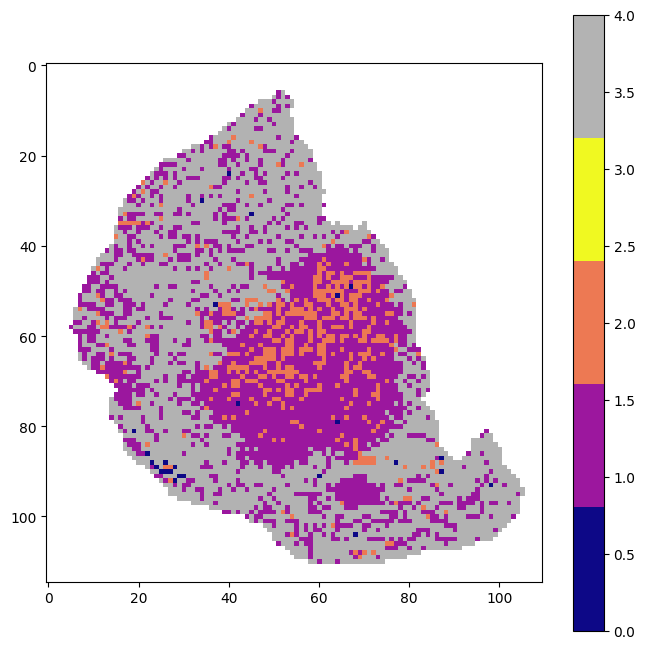

11361.svs Processed
10381.svs Processed
11321.svs Processed
10887.svs Processed


  0%|          | 0/116 [00:00<?, ?it/s]

  3%|▎         | 3/116 [00:01<01:11,  1.58it/s]

  3%|▎         | 4/116 [00:04<02:21,  1.26s/it]

  4%|▍         | 5/116 [00:07<03:22,  1.82s/it]

  5%|▌         | 6/116 [00:11<04:20,  2.37s/it]

  6%|▌         | 7/116 [00:15<05:38,  3.10s/it]

  7%|▋         | 8/116 [00:20<06:11,  3.44s/it]

  8%|▊         | 9/116 [00:24<06:34,  3.68s/it]

  9%|▊         | 10/116 [00:28<06:41,  3.79s/it]

  9%|▉         | 11/116 [00:33<07:17,  4.17s/it]

 10%|█         | 12/116 [00:37<07:26,  4.30s/it]

 11%|█         | 13/116 [00:42<07:35,  4.42s/it]

 12%|█▏        | 14/116 [00:47<07:50,  4.61s/it]

 13%|█▎        | 15/116 [00:53<08:10,  4.85s/it]

 14%|█▍        | 16/116 [00:58<08:17,  4.98s/it]

 15%|█▍        | 17/116 [01:03<08:22,  5.08s/it]

 16%|█▌        | 18/116 [01:09<08:33,  5.24s/it]

 16%|█▋        | 19/116 [01:15<09:00,  5.58s/it]

 17%|█▋        | 20/116 [01:22<09:18,  5.82s/it]

 18%|█▊        | 21/116 [01:28<09:29,  5.99s/it]

 19%|█▉        | 22/116 [01:35<09:42,  6.20s/it]

 20%|█▉        | 23/116 [01:42<09:56,  6.42s/it]

 21%|██        | 24/116 [01:50<10:53,  7.11s/it]

 22%|██▏       | 25/116 [02:00<11:46,  7.77s/it]

 22%|██▏       | 26/116 [02:09<12:09,  8.11s/it]

 23%|██▎       | 27/116 [02:19<13:02,  8.79s/it]

 24%|██▍       | 28/116 [02:29<13:35,  9.26s/it]

 25%|██▌       | 29/116 [02:40<13:54,  9.60s/it]

 26%|██▌       | 30/116 [02:50<13:56,  9.73s/it]

 27%|██▋       | 31/116 [03:00<14:05,  9.95s/it]

 28%|██▊       | 32/116 [03:12<14:38, 10.46s/it]

 28%|██▊       | 33/116 [03:24<15:05, 10.91s/it]

 29%|██▉       | 34/116 [03:36<15:22, 11.25s/it]

 30%|███       | 35/116 [03:51<16:42, 12.38s/it]

 31%|███       | 36/116 [04:10<19:07, 14.35s/it]

 32%|███▏      | 37/116 [04:27<19:57, 15.16s/it]

 33%|███▎      | 38/116 [04:47<21:32, 16.57s/it]

 34%|███▎      | 39/116 [05:10<23:41, 18.46s/it]

 34%|███▍      | 40/116 [05:31<24:36, 19.43s/it]

 35%|███▌      | 41/116 [05:53<24:59, 19.99s/it]

 36%|███▌      | 42/116 [06:16<25:56, 21.04s/it]

 37%|███▋      | 43/116 [06:40<26:48, 22.04s/it]

 38%|███▊      | 44/116 [07:07<28:03, 23.38s/it]

 39%|███▉      | 45/116 [07:34<28:48, 24.34s/it]

 40%|███▉      | 46/116 [08:02<29:44, 25.49s/it]

 41%|████      | 47/116 [08:30<30:16, 26.32s/it]

 41%|████▏     | 48/116 [08:58<30:25, 26.85s/it]

 42%|████▏     | 49/116 [09:28<30:55, 27.70s/it]

 43%|████▎     | 50/116 [09:59<31:46, 28.89s/it]

 44%|████▍     | 51/116 [10:30<32:00, 29.55s/it]

 45%|████▍     | 52/116 [11:07<33:53, 31.77s/it]

 46%|████▌     | 53/116 [11:42<34:23, 32.75s/it]

 47%|████▋     | 54/116 [12:16<34:14, 33.13s/it]

 47%|████▋     | 55/116 [12:51<33:59, 33.43s/it]

 48%|████▊     | 56/116 [13:26<33:53, 33.90s/it]

 49%|████▉     | 57/116 [14:00<33:21, 33.92s/it]

 50%|█████     | 58/116 [14:33<32:33, 33.68s/it]

 51%|█████     | 59/116 [15:07<32:11, 33.88s/it]

 52%|█████▏    | 60/116 [15:43<32:05, 34.38s/it]

 53%|█████▎    | 61/116 [16:17<31:25, 34.27s/it]

 53%|█████▎    | 62/116 [16:51<30:53, 34.32s/it]

 54%|█████▍    | 63/116 [17:27<30:52, 34.95s/it]

 55%|█████▌    | 64/116 [18:02<30:17, 34.95s/it]

 56%|█████▌    | 65/116 [18:39<30:02, 35.34s/it]

 57%|█████▋    | 66/116 [19:15<29:40, 35.61s/it]

 58%|█████▊    | 67/116 [19:52<29:20, 35.93s/it]

 59%|█████▊    | 68/116 [20:30<29:19, 36.66s/it]

 59%|█████▉    | 69/116 [21:07<28:53, 36.89s/it]

 60%|██████    | 70/116 [21:44<28:11, 36.78s/it]

 61%|██████    | 71/116 [22:21<27:45, 37.00s/it]

 62%|██████▏   | 72/116 [23:01<27:36, 37.64s/it]

 63%|██████▎   | 73/116 [23:39<27:05, 37.81s/it]

 64%|██████▍   | 74/116 [24:18<26:42, 38.15s/it]

 65%|██████▍   | 75/116 [24:57<26:15, 38.42s/it]

 66%|██████▌   | 76/116 [25:35<25:33, 38.34s/it]

 66%|██████▋   | 77/116 [26:15<25:13, 38.80s/it]

 67%|██████▋   | 78/116 [26:56<25:04, 39.60s/it]

 68%|██████▊   | 79/116 [27:35<24:12, 39.25s/it]

 69%|██████▉   | 80/116 [28:15<23:39, 39.43s/it]

 70%|██████▉   | 81/116 [28:55<23:06, 39.60s/it]

 71%|███████   | 82/116 [29:35<22:37, 39.92s/it]

 72%|███████▏  | 83/116 [30:14<21:44, 39.53s/it]

 72%|███████▏  | 84/116 [30:54<21:09, 39.67s/it]

 73%|███████▎  | 85/116 [31:32<20:13, 39.13s/it]

 74%|███████▍  | 86/116 [32:09<19:21, 38.73s/it]

 75%|███████▌  | 87/116 [32:48<18:44, 38.78s/it]

 76%|███████▌  | 88/116 [33:27<18:07, 38.84s/it]

 77%|███████▋  | 89/116 [34:06<17:24, 38.67s/it]

 78%|███████▊  | 90/116 [34:44<16:39, 38.45s/it]

 78%|███████▊  | 91/116 [35:22<16:04, 38.60s/it]

 79%|███████▉  | 92/116 [36:00<15:16, 38.20s/it]

 80%|████████  | 93/116 [36:37<14:29, 37.82s/it]

 81%|████████  | 94/116 [37:15<13:55, 37.99s/it]

 82%|████████▏ | 95/116 [37:52<13:10, 37.65s/it]

 83%|████████▎ | 96/116 [38:30<12:37, 37.89s/it]

 84%|████████▎ | 97/116 [39:06<11:49, 37.35s/it]

 84%|████████▍ | 98/116 [39:43<11:08, 37.16s/it]

 85%|████████▌ | 99/116 [40:18<10:20, 36.49s/it]

 86%|████████▌ | 100/116 [40:52<09:31, 35.70s/it]

 87%|████████▋ | 101/116 [41:28<08:56, 35.73s/it]

 88%|████████▊ | 102/116 [42:03<08:18, 35.61s/it]

 89%|████████▉ | 103/116 [42:36<07:33, 34.92s/it]

 90%|████████▉ | 104/116 [43:08<06:45, 33.80s/it]

 91%|█████████ | 105/116 [43:36<05:55, 32.28s/it]

 91%|█████████▏| 106/116 [44:05<05:11, 31.13s/it]

 92%|█████████▏| 107/116 [44:33<04:32, 30.32s/it]

 93%|█████████▎| 108/116 [44:59<03:51, 28.90s/it]

 94%|█████████▍| 109/116 [45:23<03:12, 27.45s/it]

 95%|█████████▍| 110/116 [45:44<02:32, 25.49s/it]

 96%|█████████▌| 111/116 [46:02<01:56, 23.26s/it]

 97%|█████████▋| 112/116 [46:17<01:23, 20.80s/it]

 97%|█████████▋| 113/116 [46:28<00:53, 17.86s/it]

 98%|█████████▊| 114/116 [46:35<00:29, 14.62s/it]

 99%|█████████▉| 115/116 [46:39<00:11, 11.57s/it]

100%|██████████| 116/116 [46:41<00:00,  8.47s/it]

100%|██████████| 116/116 [46:41<00:00, 24.15s/it]

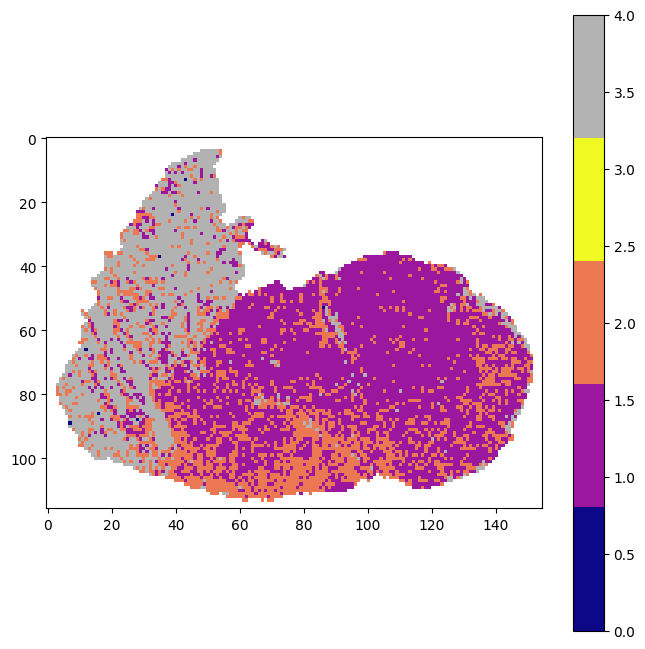

10504.svs Processed
9402.svs Processed
9972.svs Processed


  0%|          | 0/83 [00:00<?, ?it/s]

  6%|▌         | 5/83 [00:03<00:47,  1.65it/s]

  7%|▋         | 6/83 [00:09<02:27,  1.92s/it]

  8%|▊         | 7/83 [00:17<04:10,  3.30s/it]

 10%|▉         | 8/83 [00:26<06:10,  4.93s/it]

 11%|█         | 9/83 [00:38<08:18,  6.74s/it]

 12%|█▏        | 10/83 [00:51<10:18,  8.48s/it]

 13%|█▎        | 11/83 [01:05<12:07, 10.10s/it]

 14%|█▍        | 12/83 [01:21<13:58, 11.81s/it]

 16%|█▌        | 13/83 [01:39<15:38, 13.40s/it]

 17%|█▋        | 14/83 [01:56<16:45, 14.57s/it]

 18%|█▊        | 15/83 [02:15<17:59, 15.87s/it]

 19%|█▉        | 16/83 [02:33<18:35, 16.65s/it]

 20%|██        | 17/83 [02:53<19:23, 17.63s/it]

 22%|██▏       | 18/83 [03:15<20:19, 18.76s/it]

 23%|██▎       | 19/83 [03:34<20:10, 18.92s/it]

 24%|██▍       | 20/83 [03:54<20:07, 19.17s/it]

 25%|██▌       | 21/83 [04:14<20:02, 19.40s/it]

 27%|██▋       | 22/83 [04:35<20:08, 19.82s/it]

 28%|██▊       | 23/83 [04:55<19:52, 19.87s/it]

 29%|██▉       | 24/83 [05:15<19:40, 20.01s/it]

 30%|███       | 25/83 [05:35<19:22, 20.03s/it]

 31%|███▏      | 26/83 [05:55<18:58, 19.96s/it]

 33%|███▎      | 27/83 [06:15<18:38, 19.97s/it]

 34%|███▎      | 28/83 [06:35<18:16, 19.93s/it]

 35%|███▍      | 29/83 [06:55<18:05, 20.09s/it]

 36%|███▌      | 30/83 [07:14<17:33, 19.87s/it]

 37%|███▋      | 31/83 [07:34<17:13, 19.87s/it]

 39%|███▊      | 32/83 [07:52<16:26, 19.35s/it]

 40%|███▉      | 33/83 [08:10<15:36, 18.74s/it]

 41%|████      | 34/83 [08:27<14:51, 18.19s/it]

 42%|████▏     | 35/83 [08:43<14:07, 17.65s/it]

 43%|████▎     | 36/83 [09:00<13:37, 17.40s/it]

 45%|████▍     | 37/83 [09:16<13:08, 17.14s/it]

 46%|████▌     | 38/83 [09:34<12:52, 17.18s/it]

 47%|████▋     | 39/83 [09:51<12:35, 17.17s/it]

 48%|████▊     | 40/83 [10:06<11:57, 16.68s/it]

 49%|████▉     | 41/83 [10:22<11:23, 16.28s/it]

 51%|█████     | 42/83 [10:37<11:01, 16.12s/it]

 52%|█████▏    | 43/83 [10:54<10:46, 16.16s/it]

 53%|█████▎    | 44/83 [11:10<10:31, 16.20s/it]

 54%|█████▍    | 45/83 [11:27<10:30, 16.58s/it]

 55%|█████▌    | 46/83 [11:43<10:04, 16.35s/it]

 57%|█████▋    | 47/83 [12:01<10:07, 16.89s/it]

 58%|█████▊    | 48/83 [12:18<09:47, 16.78s/it]

 59%|█████▉    | 49/83 [12:33<09:17, 16.40s/it]

 60%|██████    | 50/83 [12:48<08:47, 15.98s/it]

 61%|██████▏   | 51/83 [13:03<08:16, 15.52s/it]

 63%|██████▎   | 52/83 [13:17<07:50, 15.18s/it]

 64%|██████▍   | 53/83 [13:31<07:25, 14.84s/it]

 65%|██████▌   | 54/83 [13:45<07:02, 14.57s/it]

 66%|██████▋   | 55/83 [13:59<06:41, 14.33s/it]

 67%|██████▋   | 56/83 [14:13<06:23, 14.21s/it]

 69%|██████▊   | 57/83 [14:27<06:09, 14.20s/it]

 70%|██████▉   | 58/83 [14:40<05:48, 13.92s/it]

 71%|███████   | 59/83 [14:54<05:35, 13.97s/it]

 72%|███████▏  | 60/83 [15:07<05:14, 13.68s/it]

 73%|███████▎  | 61/83 [15:20<04:56, 13.46s/it]

 75%|███████▍  | 62/83 [15:33<04:38, 13.27s/it]

 76%|███████▌  | 63/83 [15:46<04:20, 13.02s/it]

 77%|███████▋  | 64/83 [16:00<04:14, 13.40s/it]

 78%|███████▊  | 65/83 [16:12<03:55, 13.11s/it]

 80%|███████▉  | 66/83 [16:25<03:42, 13.08s/it]

 81%|████████  | 67/83 [16:38<03:25, 12.83s/it]

 82%|████████▏ | 68/83 [16:48<03:02, 12.19s/it]

 83%|████████▎ | 69/83 [16:59<02:44, 11.72s/it]

 84%|████████▍ | 70/83 [17:10<02:28, 11.39s/it]

 86%|████████▌ | 71/83 [17:20<02:12, 11.07s/it]

 87%|████████▋ | 72/83 [17:30<01:59, 10.89s/it]

 88%|████████▊ | 73/83 [17:39<01:42, 10.25s/it]

 89%|████████▉ | 74/83 [17:48<01:27,  9.69s/it]

 90%|█████████ | 75/83 [17:56<01:15,  9.48s/it]

 92%|█████████▏| 76/83 [18:05<01:03,  9.06s/it]

 93%|█████████▎| 77/83 [18:11<00:50,  8.39s/it]

 94%|█████████▍| 78/83 [18:16<00:35,  7.12s/it]

 95%|█████████▌| 79/83 [18:17<00:22,  5.54s/it]

100%|██████████| 83/83 [18:17<00:00, 13.23s/it]

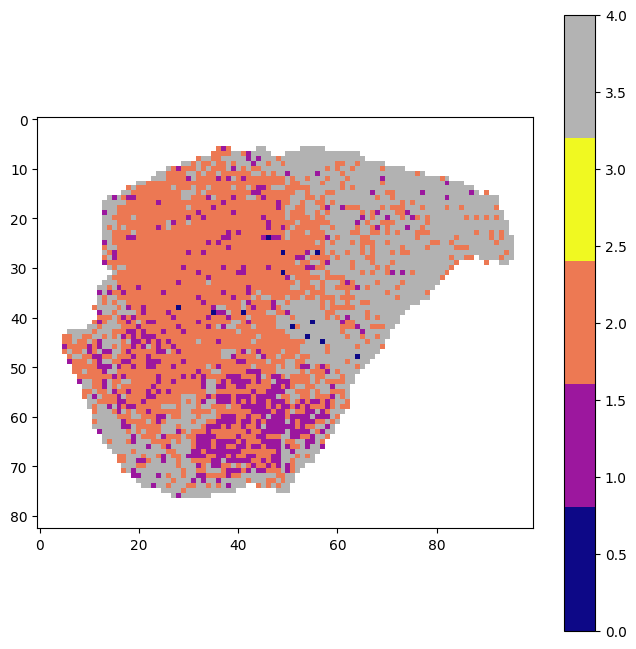

  0%|          | 0/95 [00:00<?, ?it/s]

  3%|▎         | 3/95 [00:01<00:32,  2.86it/s]

  4%|▍         | 4/95 [00:05<02:36,  1.72s/it]

  5%|▌         | 5/95 [00:09<03:35,  2.39s/it]

  6%|▋         | 6/95 [00:14<04:31,  3.05s/it]

  7%|▋         | 7/95 [00:21<06:23,  4.35s/it]

  8%|▊         | 8/95 [00:30<08:37,  5.95s/it]

  9%|▉         | 9/95 [00:41<10:29,  7.32s/it]

 11%|█         | 10/95 [00:52<12:07,  8.56s/it]

 12%|█▏        | 11/95 [01:06<14:00, 10.00s/it]

 13%|█▎        | 12/95 [01:20<15:45, 11.39s/it]

 14%|█▎        | 13/95 [01:38<18:08, 13.27s/it]

 15%|█▍        | 14/95 [01:55<19:26, 14.40s/it]

 16%|█▌        | 15/95 [02:13<20:49, 15.61s/it]

 17%|█▋        | 16/95 [02:33<22:16, 16.92s/it]

 18%|█▊        | 17/95 [02:54<23:26, 18.04s/it]

 19%|█▉        | 18/95 [03:17<25:01, 19.50s/it]

 20%|██        | 19/95 [03:41<26:23, 20.83s/it]

 21%|██        | 20/95 [04:04<27:01, 21.62s/it]

 22%|██▏       | 21/95 [04:27<27:01, 21.92s/it]

 23%|██▎       | 22/95 [04:51<27:23, 22.51s/it]

 24%|██▍       | 23/95 [05:12<26:40, 22.23s/it]

 25%|██▌       | 24/95 [05:35<26:27, 22.36s/it]

 26%|██▋       | 25/95 [05:54<25:01, 21.45s/it]

 27%|██▋       | 26/95 [06:16<24:37, 21.42s/it]

 28%|██▊       | 27/95 [06:36<23:49, 21.03s/it]

 29%|██▉       | 28/95 [06:54<22:32, 20.19s/it]

 31%|███       | 29/95 [07:13<21:42, 19.73s/it]

 32%|███▏      | 30/95 [07:31<20:49, 19.22s/it]

 33%|███▎      | 31/95 [07:49<20:09, 18.89s/it]

 34%|███▎      | 32/95 [08:04<18:48, 17.91s/it]

 35%|███▍      | 33/95 [08:18<17:01, 16.48s/it]

 36%|███▌      | 34/95 [08:30<15:23, 15.14s/it]

 37%|███▋      | 35/95 [08:35<12:15, 12.26s/it]

 38%|███▊      | 36/95 [08:39<09:30,  9.67s/it]

 39%|███▉      | 37/95 [08:43<07:45,  8.03s/it]

 40%|████      | 38/95 [08:47<06:30,  6.84s/it]

 41%|████      | 39/95 [08:51<05:42,  6.12s/it]

 42%|████▏     | 40/95 [08:56<05:08,  5.61s/it]

 43%|████▎     | 41/95 [09:00<04:33,  5.06s/it]

 44%|████▍     | 42/95 [09:03<03:57,  4.47s/it]

 45%|████▌     | 43/95 [09:06<03:35,  4.14s/it]

 46%|████▋     | 44/95 [09:11<03:37,  4.26s/it]

 47%|████▋     | 45/95 [09:17<04:10,  5.00s/it]

 48%|████▊     | 46/95 [09:26<04:53,  5.98s/it]

 49%|████▉     | 47/95 [09:35<05:29,  6.86s/it]

 51%|█████     | 48/95 [09:44<05:54,  7.54s/it]

 52%|█████▏    | 49/95 [09:54<06:23,  8.33s/it]

 53%|█████▎    | 50/95 [10:05<06:47,  9.06s/it]

 54%|█████▎    | 51/95 [10:15<06:52,  9.38s/it]

 55%|█████▍    | 52/95 [10:29<07:40, 10.71s/it]

 56%|█████▌    | 53/95 [10:46<08:51, 12.66s/it]

 57%|█████▋    | 54/95 [11:04<09:48, 14.34s/it]

 58%|█████▊    | 55/95 [11:23<10:25, 15.63s/it]

 59%|█████▉    | 56/95 [11:45<11:21, 17.48s/it]

 60%|██████    | 57/95 [12:04<11:31, 18.20s/it]

 61%|██████    | 58/95 [12:25<11:42, 18.99s/it]

 62%|██████▏   | 59/95 [12:51<12:31, 20.87s/it]

 63%|██████▎   | 60/95 [13:16<12:58, 22.23s/it]

 64%|██████▍   | 61/95 [13:42<13:16, 23.43s/it]

 65%|██████▌   | 62/95 [14:09<13:31, 24.59s/it]

 66%|██████▋   | 63/95 [14:36<13:22, 25.07s/it]

 67%|██████▋   | 64/95 [15:02<13:12, 25.57s/it]

 68%|██████▊   | 65/95 [15:29<12:56, 25.87s/it]

 69%|██████▉   | 66/95 [15:57<12:49, 26.53s/it]

 71%|███████   | 67/95 [16:23<12:16, 26.31s/it]

 72%|███████▏  | 68/95 [16:48<11:43, 26.06s/it]

 73%|███████▎  | 69/95 [17:13<11:08, 25.71s/it]

 74%|███████▎  | 70/95 [17:37<10:28, 25.13s/it]

 75%|███████▍  | 71/95 [17:59<09:42, 24.26s/it]

 76%|███████▌  | 72/95 [18:22<09:07, 23.83s/it]

 77%|███████▋  | 73/95 [18:45<08:36, 23.47s/it]

 78%|███████▊  | 74/95 [19:06<08:01, 22.95s/it]

 79%|███████▉  | 75/95 [19:27<07:24, 22.25s/it]

 80%|████████  | 76/95 [19:47<06:51, 21.68s/it]

 81%|████████  | 77/95 [20:07<06:18, 21.02s/it]

 82%|████████▏ | 78/95 [20:25<05:43, 20.22s/it]

 83%|████████▎ | 79/95 [20:43<05:14, 19.64s/it]

 84%|████████▍ | 80/95 [21:02<04:47, 19.18s/it]

 85%|████████▌ | 81/95 [21:17<04:13, 18.11s/it]

 86%|████████▋ | 82/95 [21:32<03:44, 17.28s/it]

 87%|████████▋ | 83/95 [21:47<03:16, 16.39s/it]

 88%|████████▊ | 84/95 [22:00<02:49, 15.45s/it]

 89%|████████▉ | 85/95 [22:11<02:19, 13.96s/it]

 91%|█████████ | 86/95 [22:19<01:51, 12.35s/it]

 92%|█████████▏| 87/95 [22:26<01:24, 10.58s/it]

 93%|█████████▎| 88/95 [22:31<01:04,  9.15s/it]

 94%|█████████▎| 89/95 [22:37<00:48,  8.07s/it]

 95%|█████████▍| 90/95 [22:42<00:36,  7.21s/it]

 96%|█████████▌| 91/95 [22:47<00:26,  6.54s/it]

 97%|█████████▋| 92/95 [22:50<00:16,  5.45s/it]

 98%|█████████▊| 93/95 [22:52<00:08,  4.47s/it]

 99%|█████████▉| 94/95 [22:53<00:03,  3.49s/it]

100%|██████████| 95/95 [22:53<00:00, 14.46s/it]

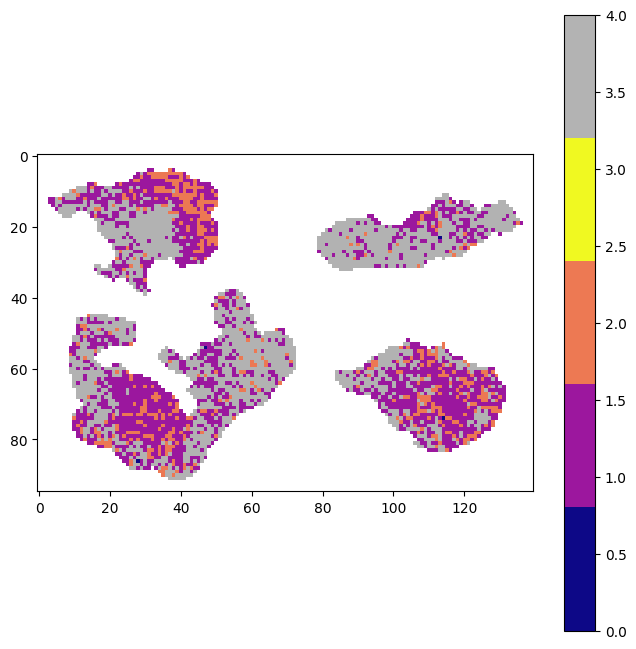

  0%|          | 0/78 [00:00<?, ?it/s]

  6%|▋         | 5/78 [00:00<00:10,  6.88it/s]

  8%|▊         | 6/78 [00:02<00:29,  2.47it/s]

  9%|▉         | 7/78 [00:04<01:03,  1.11it/s]

 10%|█         | 8/78 [00:10<02:30,  2.15s/it]

 12%|█▏        | 9/78 [00:20<04:54,  4.27s/it]

 13%|█▎        | 10/78 [00:34<07:53,  6.96s/it]

 14%|█▍        | 11/78 [00:48<10:04,  9.02s/it]

 15%|█▌        | 12/78 [01:03<11:50, 10.77s/it]

 17%|█▋        | 13/78 [01:19<13:25, 12.39s/it]

 18%|█▊        | 14/78 [01:37<14:43, 13.80s/it]

 19%|█▉        | 15/78 [01:52<14:54, 14.20s/it]

 21%|██        | 16/78 [02:10<15:57, 15.44s/it]

 22%|██▏       | 17/78 [02:33<17:53, 17.59s/it]

 23%|██▎       | 18/78 [02:57<19:29, 19.49s/it]

 24%|██▍       | 19/78 [03:22<20:43, 21.08s/it]

 26%|██▌       | 20/78 [03:47<21:34, 22.31s/it]

 27%|██▋       | 21/78 [04:12<22:06, 23.28s/it]

 28%|██▊       | 22/78 [04:39<22:36, 24.22s/it]

 29%|██▉       | 23/78 [05:06<23:04, 25.17s/it]

 31%|███       | 24/78 [05:33<23:13, 25.80s/it]

 32%|███▏      | 25/78 [06:01<23:16, 26.35s/it]

 33%|███▎      | 26/78 [06:28<23:00, 26.55s/it]

 35%|███▍      | 27/78 [06:56<22:56, 26.99s/it]

 36%|███▌      | 28/78 [07:23<22:34, 27.08s/it]

 37%|███▋      | 29/78 [07:52<22:28, 27.53s/it]

 38%|███▊      | 30/78 [08:21<22:16, 27.85s/it]

 40%|███▉      | 31/78 [08:48<21:44, 27.75s/it]

 41%|████      | 32/78 [09:16<21:19, 27.81s/it]

 42%|████▏     | 33/78 [09:45<21:02, 28.06s/it]

 44%|████▎     | 34/78 [10:14<20:56, 28.55s/it]

 45%|████▍     | 35/78 [10:42<20:21, 28.40s/it]

 46%|████▌     | 36/78 [11:10<19:48, 28.29s/it]

 47%|████▋     | 37/78 [11:39<19:18, 28.26s/it]

 49%|████▊     | 38/78 [12:07<18:55, 28.38s/it]

 50%|█████     | 39/78 [12:35<18:20, 28.22s/it]

 51%|█████▏    | 40/78 [13:03<17:46, 28.07s/it]

 53%|█████▎    | 41/78 [13:33<17:45, 28.80s/it]

 54%|█████▍    | 42/78 [14:02<17:13, 28.71s/it]

 55%|█████▌    | 43/78 [14:30<16:39, 28.55s/it]

 56%|█████▋    | 44/78 [14:58<15:59, 28.22s/it]

 58%|█████▊    | 45/78 [15:24<15:12, 27.65s/it]

 59%|█████▉    | 46/78 [15:50<14:34, 27.34s/it]

 60%|██████    | 47/78 [16:17<14:01, 27.15s/it]

 62%|██████▏   | 48/78 [16:43<13:20, 26.67s/it]

 63%|██████▎   | 49/78 [17:07<12:34, 26.01s/it]

 64%|██████▍   | 50/78 [17:30<11:44, 25.15s/it]

 65%|██████▌   | 51/78 [17:55<11:14, 25.00s/it]

 67%|██████▋   | 52/78 [18:18<10:34, 24.39s/it]

 68%|██████▊   | 53/78 [18:41<09:58, 23.95s/it]

 69%|██████▉   | 54/78 [19:02<09:18, 23.26s/it]

 71%|███████   | 55/78 [19:24<08:42, 22.73s/it]

 72%|███████▏  | 56/78 [19:47<08:19, 22.70s/it]

 73%|███████▎  | 57/78 [20:08<07:47, 22.24s/it]

 74%|███████▍  | 58/78 [20:28<07:14, 21.74s/it]

 76%|███████▌  | 59/78 [20:47<06:37, 20.92s/it]

 77%|███████▋  | 60/78 [21:07<06:08, 20.47s/it]

 78%|███████▊  | 61/78 [21:26<05:39, 19.99s/it]

 79%|███████▉  | 62/78 [21:45<05:16, 19.79s/it]

 81%|████████  | 63/78 [22:02<04:43, 18.88s/it]

 82%|████████▏ | 64/78 [22:16<04:04, 17.49s/it]

 83%|████████▎ | 65/78 [22:28<03:26, 15.90s/it]

 85%|████████▍ | 66/78 [22:38<02:50, 14.23s/it]

 86%|████████▌ | 67/78 [22:48<02:21, 12.88s/it]

 87%|████████▋ | 68/78 [22:58<01:58, 11.84s/it]

 88%|████████▊ | 69/78 [23:07<01:40, 11.18s/it]

 90%|████████▉ | 70/78 [23:16<01:23, 10.38s/it]

 91%|█████████ | 71/78 [23:22<01:04,  9.22s/it]

 92%|█████████▏| 72/78 [23:29<00:50,  8.48s/it]

 94%|█████████▎| 73/78 [23:33<00:35,  7.01s/it]

 95%|█████████▍| 74/78 [23:35<00:22,  5.61s/it]

100%|██████████| 78/78 [23:35<00:00, 18.15s/it]

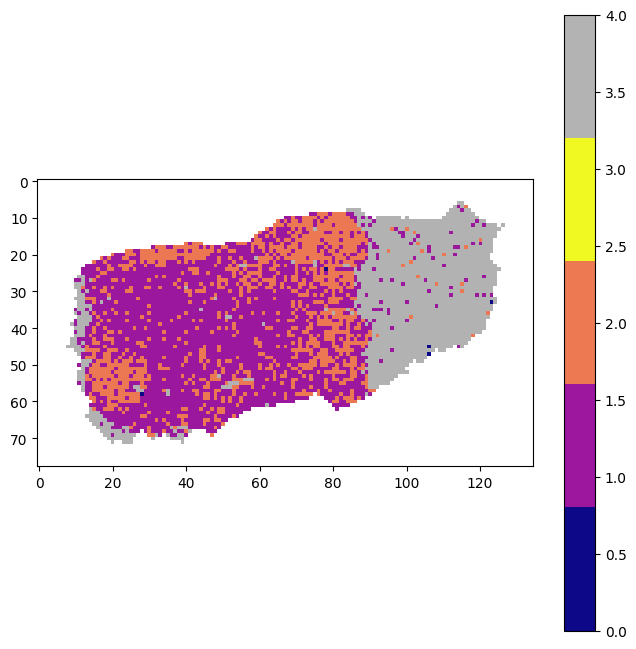

11042.svs Processed


In [12]:
import numexpr as ne
from tqdm import tqdm
import torch.nn.functional as F

# Slide processing functions
import cv2
import skimage
from openslide import open_slide
# from utils_data import normalize

# Self-defined functions
from segmentation_functions import parseXML, createMask, get_mask_for_slide_image

Extractor = ViTModel.from_pretrained("owkin/phikon", add_pooling_layer=False)
train_transform = transforms.Compose(transform_ops)
PATCH_SIZE = 400 #### for the phikon model
PATCH_SIZE_EXTRACT = 224

keys = list(slides_dict.keys())
keys.reverse()

for slide_id in keys[100:]:
    slide_dict = slides_dict[slide_id]

    try:
        if slide_dict['slide'].slide.properties['openslide.objective-power']  not in ("40", "20"):
            continue
        if slide_id == '9528.svs':
            continue
        slide_file = slide_dict['slide_path']
        slide = slide_dict['slide'].slide
        mask = None

        magnitude = slide.properties['openslide.objective-power']
        dims = slide.level_dimensions
        #print(slide_id)

        col_names = ['n_col', 'n_row', 'pred_class']
        col_names.extend(["x{}".format(_) for _ in range(768)])
        slide_df = pd.DataFrame(columns=col_names)
        #print(slide_df)

        n_rows = int(np.ceil(dims[0][1]/PATCH_SIZE))
        n_cols = int(np.ceil(dims[0][0]/PATCH_SIZE))
        #print(n_rows, n_cols)

        if os.path.exists(os.path.join(params['feature_save_path'], 
                                     "{}_{}cols_{}rows.csv".format(slide_id, n_cols, n_rows))) and magnitude == "40":
            print(slide_id + " Processed")
            continue
            #pass

        if mask is None:
            # Get tissue mask
            mask, _ = get_mask_for_slide_image(slide_file)
            #print(mask.shape)
            mask = skimage.transform.resize(mask, (n_rows, n_cols), order=0, preserve_range=True)
            #print(mask.shape)
        
            
        for n_row in tqdm(range(int(n_rows))):
            for n_col in range(int(n_cols)):
                if mask is None:
                    coord_x = feature_df['coordinate_x']
                    coord_y = feature_df['coordinate_y']
                    coord_x_start = n_col * PATCH_SIZE * 2
                    coord_x_end = (n_col + 1) * PATCH_SIZE * 2
                    coord_y_start = n_row * PATCH_SIZE * 2
                    coord_y_end = (n_row + 1) * PATCH_SIZE * 2
                    expr = "(coord_x >= coord_x_start) & (coord_x < coord_x_end) & (coord_y >= coord_y_start) & (coord_y < coord_y_end)"
                    select = ne.evaluate(expr)

                    if sum(select) == 0:
                        continue

                else:
                    if mask[n_row, n_col] < 1:
                        continue

                
                coord_x_start = n_col * PATCH_SIZE
                coord_y_start = n_row * PATCH_SIZE

                if slide.properties['openslide.objective-power'] == "20":
                    #print(print(slide_dict['slide'].slide.properties['openslide.objective-power']))
                    #print(slide_id)
                    patch = np.array(slide.read_region((coord_x_start, coord_y_start), 0, 
                                                   (int(PATCH_SIZE_EXTRACT/2) , int(PATCH_SIZE_EXTRACT/2) )), dtype=np.uint8)[..., :3]
                    
                    #plt.imshow(patch)
                    #plt.show()
                    
                    #patch = skimage.transform.rescale(patch, 2, preserve_range=True)
                    patch = skimage.transform.resize(patch, (PATCH_SIZE_EXTRACT,PATCH_SIZE_EXTRACT), 
                                                     clip=True,order=1, cval=0, anti_aliasing=True)
                    #plt.imshow(patch)
                    #plt.show()
                    
                else:
                    patch = np.array(slide.read_region((coord_x_start, coord_y_start), 0, 
                                                   (PATCH_SIZE_EXTRACT , PATCH_SIZE_EXTRACT )), dtype=np.uint8)[..., :3]

                patch_tensor = train_transform(patch).unsqueeze(0)
                patch_feature = Extractor(patch_tensor).last_hidden_state[:, 0, :]
                patch_feature = patch_feature.squeeze().detach().cpu().numpy()
                out = model(patch_tensor)
                proba = F.softmax(out, dim=1)
                pred = torch.argmax(proba, dim=1).detach().cpu().numpy()[0]

                i = len(slide_df)
                #i=i+1
                a = np.array([n_col, n_row, pred])
                newRow = np.concatenate((a,patch_feature))
                slide_df.loc[i] = newRow

                
        cols = ['n_col','n_row','pred_class']
        slide_df[cols] = slide_df[cols].apply(np.int64)
        pred_WSI = np.zeros((n_rows, n_cols))
        pred_WSI[:] = np.nan
        for i in slide_df.index.values:
            pred_WSI[slide_df.loc[i, 'n_row'], slide_df.loc[i, 'n_col']] = slide_df.loc[i, 'pred_class']

        # Shinkage border as the border prediction is weird
        mask = np.logical_not(np.isnan(pred_WSI))
        mask = skimage.morphology.erosion(mask, skimage.morphology.disk(2))
        pred_WSI[mask == 0] = np.nan

        plt.figure(figsize=(8, 8))    
        plt.imshow(pred_WSI, cmap=mycmap, interpolation="Nearest")
        plt.colorbar()
        plt.show()

        # Save data
        slide_df.to_csv(os.path.join(params['feature_save_path'], 
                                     "{}_{}cols_{}rows.csv".format(slide_id, n_cols, n_rows)), index=False)
        
    except Exception as e:
        print(e)
        continue
